In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,SubsetRandomSampler
from PIL import Image
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1751,), (0.3332,))])
train_dataset = datasets.EMNIST(root='./data',split = 'balanced',train=True,download=True,transform = transform)
test_dataset = datasets.EMNIST(root='./data',split = 'balanced',train=False,download=True,transform = transform)

In [5]:
batch_size = 128
train_loader = DataLoader(train_dataset,batch_size = batch_size,shuffle = True)
test_loader = DataLoader(test_dataset,batch_size = batch_size,shuffle = False)

In [6]:
print(f"训练集样本数: {len(train_dataset)}")
print(f"测试集样本数: {len(test_dataset)}")
print(f"类别数: {len(train_dataset.classes)}")

训练集样本数: 112800
测试集样本数: 18800
类别数: 47


可视化数据集样本

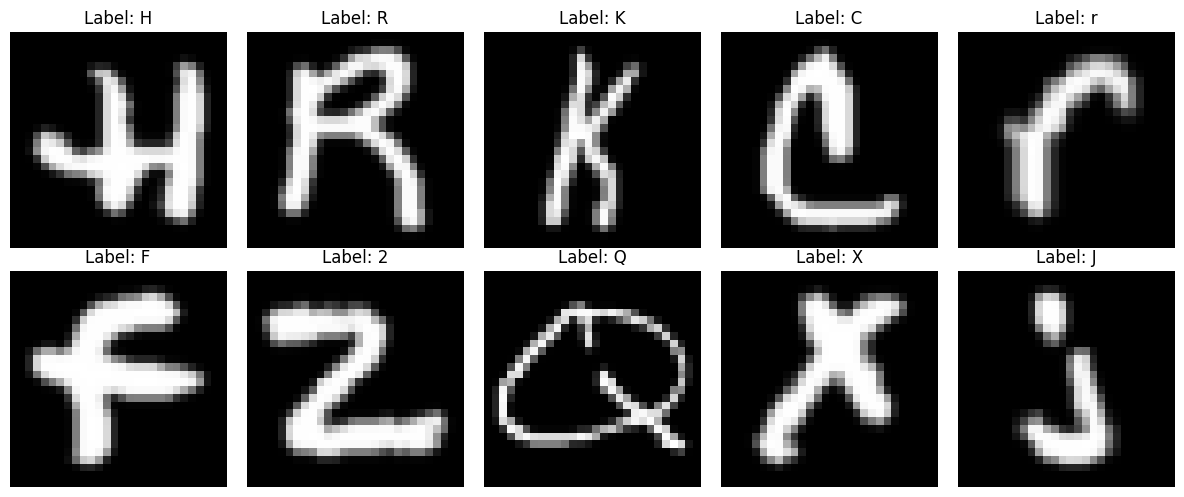

In [7]:
def get_class_mapping():
    """返回EMNIST balanced数据集的官方类别映射（基于ASCII码）"""
    mapping = {}
    
    # 官方ASCII映射
    ascii_mapping = {
        0: 48,   1: 49,   2: 50,   3: 51,   4: 52,
        5: 53,   6: 54,   7: 55,   8: 56,   9: 57,
        10: 65,  11: 66,  12: 67,  13: 68,  14: 69,
        15: 70,  16: 71,  17: 72,  18: 73,  19: 74,
        20: 75,  21: 76,  22: 77,  23: 78,  24: 79,
        25: 80,  26: 81,  27: 82,  28: 83,  29: 84,
        30: 85,  31: 86,  32: 87,  33: 88,  34: 89,
        35: 90,  36: 97,  37: 98,  38: 100, 39: 101,
        40: 102, 41: 103, 42: 104, 43: 110, 44: 113,
        45: 114, 46: 116
    }
    
    # 将ASCII码转换为对应字符
    for class_idx, ascii_code in ascii_mapping.items():
        mapping[class_idx] = chr(ascii_code)
    
    return mapping



class_mapping = get_class_mapping()

# 可视化一些样本
def visualize_samples(dataset, num_samples=10, class_mapping=None):
    """可视化数据集中的样本"""
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()
    
    for i in range(num_samples):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        img = img.squeeze().numpy()
        
        # EMNIST图像需要转置和翻转以正确显示
        img = img.T
        
        
        axes[i].imshow(img, cmap='gray')
        if class_mapping:
            class_name = class_mapping.get(label, str(label))
        else:
            class_name = str(label)
        axes[i].set_title(f'Label: {class_name}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# 可视化训练集中的一些样本
visualize_samples(train_dataset, num_samples=10, class_mapping=class_mapping)

MLP模型
三个隐藏层
自适应学习率
激活函数三种：
优化器三种：
批量归一化
L1，L2正则化
Dropout

In [8]:
class MLP(nn.Module):
    def __init__(self,input_size = 784,hidden_sizes = [512,256,128],output_size = 47,
                 activation = 'relu',dropout_rate = 0.5,use_batch_norm = True):
        
        super(MLP,self).__init__()
    
        layers = []
        layers.append(nn.Flatten())
        prev_size = input_size
        for hidden_size in hidden_sizes:
            fc_layer = nn.Linear(prev_size,hidden_size)
            layers.append(fc_layer)
            
            if use_batch_norm :
                layers.append(nn.BatchNorm1d(hidden_size))
            
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'leaky_relu':
                layers.append(nn.LeakyReLU(0.1))
            elif activation == 'elu':
                layers.append(nn.ELU())
            
            
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
                
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size,output_size))
        
        self.layers = nn.Sequential(*layers)
        
    
    def forward(self,x):
        return self.layers(x)

In [9]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
MLP_Net = MLP(use_batch_norm = False)

for layer in MLP_Net.layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)


Flatten output shape: 	 torch.Size([1, 784])
Linear output shape: 	 torch.Size([1, 512])
ReLU output shape: 	 torch.Size([1, 512])
Dropout output shape: 	 torch.Size([1, 512])
Linear output shape: 	 torch.Size([1, 256])
ReLU output shape: 	 torch.Size([1, 256])
Dropout output shape: 	 torch.Size([1, 256])
Linear output shape: 	 torch.Size([1, 128])
ReLU output shape: 	 torch.Size([1, 128])
Dropout output shape: 	 torch.Size([1, 128])
Linear output shape: 	 torch.Size([1, 47])


卷积神经网络
两个卷积层
自适应学习率
激活函数三种：
优化器三种：
批量归一化
L1，L2正则化
Dropout

In [10]:
class CNN(nn.Module):
    def __init__(self,num_classes = 47,activation = 'relu',dropout_rate = 0.5,use_batch_norm = True):
        super(CNN,self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1,32,kernel_size = 3,padding = 1),
            nn.BatchNorm2d(32) if use_batch_norm else nn.Identity(),
            self.get_activation(activation),
            nn.MaxPool2d(2),
            
            
            nn.Conv2d(32,64,kernel_size = 3,padding = 1),
            nn.BatchNorm2d(64) if use_batch_norm else nn.Identity(),
            self.get_activation(activation),
            nn.MaxPool2d(2),
            
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7,256),
            nn.BatchNorm1d(256) if use_batch_norm else nn.Identity(),
            self.get_activation(activation),
            nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Linear(256,num_classes)
        )
        
    def get_activation(self,activation):
        if activation == 'relu':
            return nn.ReLU()
        elif activation == 'leaky_relu':
            return nn.LeakyReLU(0.1)
        elif activation == 'elu':
            return nn.ELU()
            
    def forward(self,x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [11]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
CNN_Net = CNN(use_batch_norm=False)

print("卷积层:")
for layer in CNN_Net.conv_layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

print("\n全连接层:")
for layer in CNN_Net.fc_layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

卷积层:
Conv2d output shape: 	 torch.Size([1, 32, 28, 28])
Identity output shape: 	 torch.Size([1, 32, 28, 28])
ReLU output shape: 	 torch.Size([1, 32, 28, 28])
MaxPool2d output shape: 	 torch.Size([1, 32, 14, 14])
Conv2d output shape: 	 torch.Size([1, 64, 14, 14])
Identity output shape: 	 torch.Size([1, 64, 14, 14])
ReLU output shape: 	 torch.Size([1, 64, 14, 14])
MaxPool2d output shape: 	 torch.Size([1, 64, 7, 7])

全连接层:
Flatten output shape: 	 torch.Size([1, 3136])
Linear output shape: 	 torch.Size([1, 256])
Identity output shape: 	 torch.Size([1, 256])
ReLU output shape: 	 torch.Size([1, 256])
Dropout output shape: 	 torch.Size([1, 256])
Linear output shape: 	 torch.Size([1, 47])


ResNet神经网络
CNN基础上加入残差层
自适应学习率
激活函数三种：
优化器三种：
批量归一化
L1，L2正则化
Dropout

In [12]:
class ResBlock(nn.Module):
    """基本块"""
    def __init__(self,in_channels,out_channels,stride = 1,activation = 'relu',use_batch_norm = True):
        super(ResBlock,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size = 3,stride = stride,padding = 1,bias = False)
        
        self.bn1 = nn.BatchNorm2d(out_channels) if use_batch_norm else nn.Identity()
        
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size = 3,stride = 1,padding = 1 ,bias = False)
        
        self.bn2 = nn.BatchNorm2d(out_channels) if use_batch_norm else nn.Identity()
        
        if activation == 'relu':
            self.activation = nn.ReLU() 
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        elif activation == 'elu':
            self.activation = nn.ELU()
        
        self.shortcut = nn.Sequential()
        
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size = 1,stride = stride,bias = False),
                nn.BatchNorm2d(out_channels) if use_batch_norm else nn.Identity()
            )
        
    def forward(self,x):
        out = self.activation(self.bn1(self.conv1(x)))
        out = self.activation(self.bn2(self.conv2(out)))
        out = out + self.shortcut(x)
        out = self.activation(out)
        return out
    
class ResNet(nn.Module):
    
    def __init__(self,block,num_blocks,num_classes = 47,activation = 'relu',
                dropout_rate = 0.5,use_batch_norm = True):
        super(ResNet,self).__init__()
        
        self.in_channels = 64
        self.activation = activation
        self.use_batch_norm = use_batch_norm
        
        self.conv1 = nn.Conv2d(1,64,kernel_size = 3,stride = 1,padding = 1,bias = False)
        self.bn1 = nn.BatchNorm2d(64) if use_batch_norm else nn.Identity()
        
        if activation == 'relu':
            self.act = nn.ReLU()
        elif activation == 'leaky_relu':
            self.act = nn.LeakyReLU(0.1)
        elif activation == 'elu':
            self.act = nn.ELU()
#         残差层
        self.layer1 = self.make_layer(block,64,num_blocks[0],stride = 1)
        self.layer2 = self.make_layer(block,128,num_blocks[1],stride = 2)
        self.layer3 = self.make_layer(block,256,num_blocks[2],stride = 2)
        
        
#         全连接层
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()
        self.fc = nn.Linear(256, num_classes)
        
    def make_layer(self,block,out_channels,num_blocks,stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, 
                               self.activation, self.use_batch_norm))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.act(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

def ResNet18(num_classes=47,activation = 'relu',dropout_rate = 0.5,use_batch_norm = True):
    return ResNet(ResBlock,[2,2,2],num_classes,activation,dropout_rate,use_batch_norm)

def ResNet10(num_classes=47,activation = 'relu',dropout_rate = 0.5,use_batch_norm = True):
    return ResNet(ResBlock,[1,1,1],num_classes,activation,dropout_rate,use_batch_norm)

In [13]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
Res18_Net = ResNet18(use_batch_norm=False)


print("初始卷积层:")
out = Res18_Net.conv1(X)
print("Conv2d output shape: \t", out.shape)
out = Res18_Net.bn1(out)
print("Identity output shape: \t", out.shape)
out = Res18_Net.act(out)
print("Activation output shape: \t", out.shape)

print("\n残差块层1:")
out = Res18_Net.layer1(out)
print("Layer1 output shape: \t", out.shape)

print("\n残差块层2:")
out = Res18_Net.layer2(out)
print("Layer2 output shape: \t", out.shape)

print("\n残差块层3:")
out = Res18_Net.layer3(out)
print("Layer3 output shape: \t", out.shape)


print("\n池化和全连接层:")
out = Res18_Net.avg_pool(out)
print("AvgPool2d output shape: \t", out.shape)
out = out.view(out.size(0), -1)
print("Flatten output shape: \t", out.shape)
out = Res18_Net.dropout(out)
print("Dropout output shape: \t", out.shape)
out = Res18_Net.fc(out)
print("Linear output shape: \t", out.shape)

print("\n完整模型前向传播:")
output = Res18_Net(X)
print("最终输出形状:", output.shape)

初始卷积层:
Conv2d output shape: 	 torch.Size([1, 64, 28, 28])
Identity output shape: 	 torch.Size([1, 64, 28, 28])
Activation output shape: 	 torch.Size([1, 64, 28, 28])

残差块层1:
Layer1 output shape: 	 torch.Size([1, 64, 28, 28])

残差块层2:
Layer2 output shape: 	 torch.Size([1, 128, 14, 14])

残差块层3:
Layer3 output shape: 	 torch.Size([1, 256, 7, 7])

池化和全连接层:
AvgPool2d output shape: 	 torch.Size([1, 256, 1, 1])
Flatten output shape: 	 torch.Size([1, 256])
Dropout output shape: 	 torch.Size([1, 256])
Linear output shape: 	 torch.Size([1, 47])

完整模型前向传播:
最终输出形状: torch.Size([1, 47])


训练函数和评估函数

In [14]:
def train_model(model,train_loader,optimizer,criterion,scheduler = None,epochs = 10,
               device = device,model_name = 'model',l1_lambda = 0):
    """
    训练函数
    optimizer:优化器选择
    criterion：损失函数选择
    scheduler：学习率调度器
    l1_lambda:L1正则化
    """
    model.to(device)
    model.train()
    
    train_losses = []
    
    train_accs = []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx , (inputs,targets) in enumerate(train_loader):
            
            inputs ,targets = inputs.to(device),targets.to(device)
            
#             梯度清零

            optimizer.zero_grad()
    
#            前向传播
            outputs = model(inputs)
            loss = criterion(outputs,targets)
        
            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += l1_lambda * l1_norm
        
#            反向传播和优化

            loss.backward()
            optimizer.step()
#            统计
            running_loss += loss.item()
            _,predicted  = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
#             打印进度
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch + 1}/{epochs} | Batch: {batch_idx}/{len(train_loader)} |'
                     f'Loss: {running_loss / (batch_idx + 1):.4f}'
                     f'Acc: {100. * correct/total:.2f}')

            
#         记录训练损失和准确率
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        #         更新学习率
        if scheduler:
            scheduler.step(epoch_loss)
        
        print(f'Epoch: {epoch + 1} / {epochs} completed'
             f'Loss: {epoch_loss:.4f},Accuracy: {epoch_acc:.2f}')
        
    
    end_time = time.time()
    training_time = end_time - start_time
    print(f'训练完成，用时：{training_time:.2f} seconds')
    
#     保存模型
    torch.save(model.state_dict(),f'{model_name}.pth')
    
    return {
        'model' : model,
        'train_losses' : train_losses,
        'train_accs' : train_accs,
        'training_time' : training_time
    }

def eval_model(model,test_loader,criterion,device = device):
    """评估函数"""
    model = model.to(device)
    model.eval()
    
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch_idx ,(inputs,targets) in enumerate(test_loader):
            inputs,targets  = inputs.to(device),targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs,targets)
            
            test_loss += loss.item()

            _,predicted = outputs.max(1)
            
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
    accuracy = 100. *correct / total
    avg_loss = test_loss / len(test_loader)

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted')
    
    print(f'Test Loss: {avg_loss:.4f} | Test Acc: {accuracy:.2f}%')
    print(f'Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}')
    
    return {
        'accuracy': accuracy,
        'loss': avg_loss,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_preds,
        'targets': all_targets
    }

交叉训练选择超参数

In [15]:
hyperparams = {
    'learning_rate': [0.001],
    'optimizer_name': ['adam', 'sgd', 'asgd'],
    'activation': ['relu', 'leaky_relu', 'elu'],
    'scheduler':['reduce_on_plateau','cosine_annealing','none'],
    'dropout_rate': [0.0, 0.5],
    'batch_norm': [True, False],
    'weight_decay': [0.001],
    'l1_lambda': [0.001]
}

hyperparams_res1 = {
    'learning_rate': [0.001],
    'optimizer_name': ['adam'],
    'activation': ['relu', 'leaky_relu', 'elu'],
    'scheduler':['reduce_on_plateau','cosine_annealing','none'],
    'dropout_rate': [0.0, 0.5],
    'batch_norm': [True, False],
    'weight_decay': [0.001],
    'l1_lambda': [0.001]
}
hyperparams_res2 = {
    'learning_rate': [0.001],
    'optimizer_name': [ 'sgd'],
    'activation': ['relu', 'leaky_relu', 'elu'],
    'scheduler':['reduce_on_plateau','cosine_annealing','none'],
    'dropout_rate': [0.0, 0.5],
    'batch_norm': [True, False],
    'weight_decay': [0.001],
    'l1_lambda': [0.001]
}
hyperparams_res3 = {
    'learning_rate': [0.001],
    'optimizer_name': ['asgd'],
    'activation': ['relu', 'leaky_relu', 'elu'],
    'scheduler':['reduce_on_plateau','cosine_annealing','none'],
    'dropout_rate': [0.0, 0.5],
    'batch_norm': [True, False],
    'weight_decay': [0.001],
    'l1_lambda': [0.001]
}

def get_optimizer(optimizer_name, model_parameters, lr, weight_decay):
    if optimizer_name == 'adam':
        return optim.Adam(model_parameters, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'sgd':
        return optim.SGD(model_parameters, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'asgd':  
        return optim.ASGD(model_parameters, lr=lr, weight_decay=weight_decay)

def get_scheduler(scheduler_name, optimizer):
    if scheduler_name == 'reduce_on_plateau':
        return ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
    elif scheduler_name == 'cosine_annealing':
        return CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
    elif scheduler_name == 'none':
        return None

In [16]:
"""交叉验证和模型选择"""
def cross_validate_model(model_class, train_dataset, hyperparams, batch_size, device, n_splits=3,early_stopping_threshold = 75):
    # 创建分层k折交叉验证对象，将数据集分成n_split份
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    X = list(range(len(train_dataset))) 
    
    y = [train_dataset[i][1] for i in X]
    
    best_acc = 0
    best_params = None
    
    
    loop_count = 0
#     设置阈值当训练效果很差时直接跳过

    early_stopping_threshold = early_stopping_threshold
    
    for lr in hyperparams['learning_rate']:
        for opt_name in hyperparams['optimizer_name']:
            for act in hyperparams['activation']:
                for drop in hyperparams['dropout_rate']:  
                    for bn in hyperparams['batch_norm']:
                        for scheduler in hyperparams['scheduler']:
                            for reg_type in ['none','l1','l2']:
                                if reg_type == 'none':
                                    l1_lambda = 0.0
                                    wd = 0.0
                                elif reg_type == 'l1':
                                    l1_lambda = hyperparams['l1_lambda'][0]
                                    wd = 0.0
                                else:
                                    l1_lambda = 0.0
                                    wd = hyperparams['weight_decay'][0]
                                loop_count += 1
                                print(f'-----第 {loop_count} 轮循环-----')
                                current_params = {
                                    'learning_rate': lr,
                                    'optimizer_name': opt_name,
                                    'activation': act,
                                    'scheduler':scheduler,
                                    'dropout_rate': drop,
                                    'use_batch_norm': bn,
                                    'weight_decay': wd,
                                    'l1_lambda': l1_lambda
                                }

                                fold_scores = []
                                
                                skip_current_params = False

                                for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
                                    train_subsampler = SubsetRandomSampler(train_idx)
                                    val_subsampler = SubsetRandomSampler(val_idx)

                                    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
                                    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)

                                    model = model_class(activation=act, dropout_rate=drop, use_batch_norm=bn).to(device)

                                    optimizer = get_optimizer(opt_name, model.parameters(), lr, wd)
                                    scheduler = get_scheduler(scheduler,optimizer)  

                                    criterion = nn.CrossEntropyLoss()  

                                    model_results = train_model(model, train_loader, optimizer, criterion, scheduler, epochs = 5,l1_lambda = l1_lambda)
                                    val_results = eval_model(model, val_loader, criterion)
                                    fold_scores.append(val_results['accuracy'])
                                    fold_acc = val_results['accuracy']
                                    if fold == 0 and fold_acc < early_stopping_threshold:
                                        print(f'第一折的准确率：{fold_acc} 低于阈值 {early_stopping_threshold}，跳过当前超参数组合')
                                        skip_current_params = True
                                        break
                                
                                if skip_current_params :
                                    continue

                                avg_score = np.mean(fold_scores)
                                if avg_score > best_acc:
                                    best_acc = avg_score  
                                    best_params = current_params

                                print(f'Params: {current_params}, ' 
                                      f'Average validation accuracy: {avg_score:.2f}')  
        
    return best_params, best_acc

MLP的超参数选择

In [24]:
MLP_best_params,MLP_best_acc = cross_validate_model(
    model_class = MLP,
    train_dataset  = train_dataset,
    hyperparams = hyperparams,
    batch_size = batch_size,
    device = device,
    n_splits = 3,
    early_stopping_threshold = 80
)

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9883Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 1.9878Acc: 56.04
Epoch: 1/5 | Batch: 200/588 |Loss: 1.4869Acc: 64.61
Epoch: 1/5 | Batch: 300/588 |Loss: 1.2525Acc: 68.49
Epoch: 1/5 | Batch: 400/588 |Loss: 1.1106Acc: 70.91
Epoch: 1/5 | Batch: 500/588 |Loss: 1.0151Acc: 72.66
Epoch: 1 / 5 completedLoss: 0.9568,Accuracy: 73.66
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5408Acc: 84.38
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5101Acc: 83.11
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5093Acc: 83.01
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5042Acc: 83.01
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5053Acc: 82.84
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5045Acc: 82.85
Epoch: 2 / 5 completedLoss: 0.5032,Accuracy: 82.86
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4100Acc: 86.72
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4173Acc: 85.17
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4228Acc: 84.97
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4179Acc: 85.21
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4172Acc: 85.23
Epoch: 3/5 | Batch: 5

Epoch: 1/5 | Batch: 500/588 |Loss: 1.0252Acc: 72.61
Epoch: 1 / 5 completedLoss: 0.9655,Accuracy: 73.63
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4986Acc: 85.16
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5432Acc: 82.60
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5408Acc: 82.45
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5395Acc: 82.28
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5381Acc: 82.27
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5384Acc: 82.14
Epoch: 2 / 5 completedLoss: 0.5379,Accuracy: 82.09
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5038Acc: 83.59
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4534Acc: 84.56
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4656Acc: 84.30
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4681Acc: 84.12
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4702Acc: 83.88
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4738Acc: 83.84
Epoch: 3 / 5 completedLoss: 0.4760,Accuracy: 83.73
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4411Acc: 83.59
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4295Acc: 85.30
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4303Acc: 85.07
Epoch: 4/5 | Batch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 0.9592,Accuracy: 73.62
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5520Acc: 80.47
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5024Acc: 83.41
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5054Acc: 83.19
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5076Acc: 83.02
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5057Acc: 83.08
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5027Acc: 83.11
Epoch: 2 / 5 completedLoss: 0.4988,Accuracy: 83.18
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3503Acc: 85.16
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3998Acc: 85.78
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4049Acc: 85.61
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4140Acc: 85.42
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4149Acc: 85.39
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4198Acc: 85.19
Epoch: 3 / 5 completedLoss: 0.4197,Accuracy: 85.22
Epoch: 4/5 | Batch: 0/588 |Loss: 0.2630Acc: 92.19
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3551Acc: 87.54
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3531Acc: 87.47
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3599Acc: 87.08
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 400/588 |Loss: 0.5424Acc: 82.10
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5409Acc: 82.08
Epoch: 2 / 5 completedLoss: 0.5364,Accuracy: 82.21
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4032Acc: 83.59
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4562Acc: 84.92
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4646Acc: 84.34
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4660Acc: 84.27
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4735Acc: 84.02
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4740Acc: 84.03
Epoch: 3 / 5 completedLoss: 0.4745,Accuracy: 84.02
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3825Acc: 89.06
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4212Acc: 85.86
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4265Acc: 85.37
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4345Acc: 85.10
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4392Acc: 84.87
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4444Acc: 84.74
Epoch: 4 / 5 completedLoss: 0.4419,Accuracy: 84.90
Epoch: 5/5 | Batch: 0/588 |Loss: 0.6862Acc: 76.56
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4041Acc: 85.87
Epoch: 5/5 | Batch: 2

Epoch: 3/5 | Batch: 300/588 |Loss: 0.4139Acc: 85.53
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4153Acc: 85.51
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4156Acc: 85.47
Epoch: 3 / 5 completedLoss: 0.4172,Accuracy: 85.39
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4225Acc: 84.38
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3600Acc: 86.97
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3623Acc: 86.78
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3642Acc: 86.71
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3659Acc: 86.69
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3682Acc: 86.62
Epoch: 4 / 5 completedLoss: 0.3704,Accuracy: 86.53
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3139Acc: 87.50
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3176Acc: 88.39
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3140Acc: 88.46
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3212Acc: 88.24
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3241Acc: 88.09
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3255Acc: 88.02
Epoch: 5 / 5 completedLoss: 0.3294,Accuracy: 87.88
训练完成，用时：81.37 seconds
Test Loss: 0.4621 | Test Acc: 84.54%
Precision: 0

Epoch: 4/5 | Batch: 200/588 |Loss: 0.4260Acc: 85.50
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4287Acc: 85.30
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4337Acc: 85.17
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4407Acc: 85.00
Epoch: 4 / 5 completedLoss: 0.4444,Accuracy: 84.86
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4528Acc: 83.59
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4003Acc: 86.29
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4069Acc: 85.95
Epoch: 5/5 | Batch: 300/588 |Loss: 0.4124Acc: 85.72
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4183Acc: 85.54
Epoch: 5/5 | Batch: 500/588 |Loss: 0.4215Acc: 85.39
Epoch: 5 / 5 completedLoss: 0.4258,Accuracy: 85.28
训练完成，用时：81.56 seconds
Test Loss: 0.4766 | Test Acc: 84.26%
Precision: 0.8438 | Recall: 0.8426 | F1 Score: 0.8400
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9295Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 1.9867Acc: 56.73
Epoch: 1/5 | Batch: 200/588 |Loss: 1.4977Acc: 64.67
Epoch: 1/5 | Batch: 300/588 |Loss: 1.2655Acc: 68.41
Epoch: 1/5 | Batch: 400/588 |Loss: 1.1271Acc: 70.81
Epoch: 1/5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8504Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 2.0798Acc: 42.98
Epoch: 1/5 | Batch: 200/588 |Loss: 1.6066Acc: 54.27
Epoch: 1/5 | Batch: 300/588 |Loss: 1.3738Acc: 60.18
Epoch: 1/5 | Batch: 400/588 |Loss: 1.2268Acc: 63.88
Epoch: 1/5 | Batch: 500/588 |Loss: 1.1266Acc: 66.46
Epoch: 1 / 5 completedLoss: 1.0580,Accuracy: 68.17
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6233Acc: 75.00
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6032Acc: 80.24
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5940Acc: 80.56
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5859Acc: 80.70
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5775Acc: 80.82
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5713Acc: 80.94
Epoch: 2 / 5 completedLoss: 0.5663,Accuracy: 81.05
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3787Acc: 88.28
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4696Acc: 83.69
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4659Acc: 83.60
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4681Acc: 83.75
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4701Acc: 83.67
Epoch: 3/5 | Batch: 5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8555Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 2.0438Acc: 44.49
Epoch: 1/5 | Batch: 200/588 |Loss: 1.6174Acc: 54.50
Epoch: 1/5 | Batch: 300/588 |Loss: 1.3914Acc: 60.06
Epoch: 1/5 | Batch: 400/588 |Loss: 1.2471Acc: 63.68
Epoch: 1/5 | Batch: 500/588 |Loss: 1.1561Acc: 65.95
Epoch: 1 / 5 completedLoss: 1.0957,Accuracy: 67.48
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5404Acc: 78.12
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6486Acc: 78.92
Epoch: 2/5 | Batch: 200/588 |Loss: 0.6451Acc: 78.83
Epoch: 2/5 | Batch: 300/588 |Loss: 0.6369Acc: 79.13
Epoch: 2/5 | Batch: 400/588 |Loss: 0.6254Acc: 79.39
Epoch: 2/5 | Batch: 500/588 |Loss: 0.6236Acc: 79.46
Epoch: 2 / 5 completedLoss: 0.6198,Accuracy: 79.55
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4716Acc: 83.59
Epoch: 3/5 | Batch: 100/588 |Loss: 0.5405Acc: 81.67
Epoch: 3/5 | Batch: 200/588 |Loss: 0.5485Ac

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 1.0452,Accuracy: 68.48
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6009Acc: 79.69
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6049Acc: 80.44
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5909Acc: 80.41
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5835Acc: 80.53
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5783Acc: 80.70
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5745Acc: 80.80
Epoch: 2 / 5 completedLoss: 0.5645,Accuracy: 81.03
Epoch: 3/5 | Batch: 0/588 |Loss: 0.6165Acc: 75.00
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4644Acc: 83.63
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4592Acc: 84.00
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4614Acc: 83.92
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4608Acc: 83.94
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4594Acc: 83.97
Epoch: 3 / 5 completedLoss: 0.4623,Accuracy: 83.82
Epoch: 4/5 | Batch: 0/588 |Loss: 0.2889Acc: 89.84
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3910Acc: 86.00
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3922Acc: 85.92
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3982Acc: 85.73
Epoch: 4/5 | Batch: 4

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8609Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 2.0733Acc: 42.38
Epoch: 1/5 | Batch: 200/588 |Loss: 1.6158Acc: 53.78
Epoch: 1/5 | Batch: 300/588 |Loss: 1.3912Acc: 59.48
Epoch: 1/5 | Batch: 400/588 |Loss: 1.2494Acc: 63.11
Epoch: 1/5 | Batch: 500/588 |Loss: 1.1515Acc: 65.63
Epoch: 1 / 5 completedLoss: 1.0869,Accuracy: 67.28
Epoch: 2/5 | Batch: 0/588 |Loss: 0.7271Acc: 76.56
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6351Acc: 79.33
Epoch: 2/5 | Batch: 200/588 |Loss: 0.6263Acc: 79.14
Epoch: 2/5 | Batch: 300/588 |Loss: 0.6216Acc: 79.40
Epoch: 2/5 | Batch: 400/588 |Loss: 0.6197Acc: 79.45
Epoch: 2/5 | Batch: 500/588 |Loss: 0.6152Acc: 79.67
Epoch: 2 / 5 completedLoss: 0.6121,Accuracy: 79.73
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4621Acc: 79.69
Epoch: 3/5 | Batch: 100/588 |Loss: 0.5366Acc: 81.92
Epoch: 3/5 | Batch: 200/588 |Loss: 0.5351Ac

Epoch: 1/5 | Batch: 400/588 |Loss: 1.2223Acc: 64.25
Epoch: 1/5 | Batch: 500/588 |Loss: 1.1274Acc: 66.65
Epoch: 1 / 5 completedLoss: 1.0609,Accuracy: 68.36
Epoch: 2/5 | Batch: 0/588 |Loss: 0.7550Acc: 81.25
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6077Acc: 80.03
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5930Acc: 80.46
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5874Acc: 80.53
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5804Acc: 80.86
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5761Acc: 80.90
Epoch: 2 / 5 completedLoss: 0.5726,Accuracy: 80.91
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3546Acc: 91.41
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4626Acc: 84.41
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4688Acc: 84.03
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4663Acc: 84.03
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4682Acc: 83.93
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4680Acc: 83.88
Epoch: 3 / 5 completedLoss: 0.4707,Accuracy: 83.76
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4066Acc: 85.94
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3930Acc: 85.80
Epoch: 4/5 | Batch: 2

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8540Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 1.9868Acc: 45.34
Epoch: 1/5 | Batch: 200/588 |Loss: 1.5550Acc: 55.58
Epoch: 1/5 | Batch: 300/588 |Loss: 1.3545Acc: 60.48
Epoch: 1/5 | Batch: 400/588 |Loss: 1.2243Acc: 63.78
Epoch: 1/5 | Batch: 500/588 |Loss: 1.1312Acc: 66.26
Epoch: 1 / 5 completedLoss: 1.0703,Accuracy: 67.91
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6891Acc: 76.56
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6350Acc: 79.08
Epoch: 2/5 | Batch: 200/588 |Loss: 0.6366Acc: 79.00
Epoch: 2/5 | Batch: 300/588 |Loss: 0.6311Acc: 79.19
Epoch: 2/5 | Batch: 400/588 |Loss: 0.6239Acc: 79.36
Epoch: 2/5 | Batch: 500/588 |Loss: 0.6202Acc: 79.44
Epoch: 2 / 5 completedLoss: 0.6114,Accuracy: 79.71
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5678Acc: 77.34
Epoch: 3/5 | Batch: 100/588 |Loss: 0.5296Acc: 81.98
Epoch: 3/5 | Batch: 200/588 |Loss: 0.5363Ac

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.1627Acc: 20.56
Epoch: 1/5 | Batch: 200/588 |Loss: 2.6738Acc: 31.48
Epoch: 1/5 | Batch: 300/588 |Loss: 2.3783Acc: 37.53
Epoch: 1/5 | Batch: 400/588 |Loss: 2.1866Acc: 41.29
Epoch: 1/5 | Batch: 500/588 |Loss: 2.0451Acc: 44.29
Epoch: 1 / 5 completedLoss: 1.9519,Accuracy: 46.31
Epoch: 2/5 | Batch: 0/588 |Loss: 1.3434Acc: 63.28
Epoch: 2/5 | Batch: 100/588 |Loss: 1.3279Acc: 60.30
Epoch: 2/5 | Batch: 200/588 |Loss: 1.3126Acc: 60.44
Epoch: 2/5 | Batch: 300/588 |Loss: 1.2864Acc: 61.01
Epoch: 2/5 | Batch: 400/588 |Loss: 1.2647Acc: 61.70
Epoch: 2/5 | Batch: 500/588 |Loss: 1.2529Acc: 62.02
Epoch: 2 / 5 completedLoss: 1.2369,Accuracy: 62.48
Epoch: 3/5 | Batch: 0/588 |Loss: 1.1100Acc: 63.28
Epoch: 3/5 | Batch: 100/588 |Loss: 1.1302Acc: 65.15
Epoch: 3/5 | Batch: 200/588 |Loss: 1.1140Acc: 65.72
Epoch: 3/5 | Batch: 300/588 |Loss: 1.0978Acc: 66.25
Epoch: 3/5 | Batch: 400/588 |Loss: 1.0949Acc: 66.27
Epoch: 3/5 | Batch: 500/588 |Loss: 1.0898Acc: 66.50
Epoch: 3 / 5 compl

Epoch: 1 / 5 completedLoss: 1.9485,Accuracy: 46.26
Epoch: 2/5 | Batch: 0/588 |Loss: 1.3030Acc: 57.03
Epoch: 2/5 | Batch: 100/588 |Loss: 1.3489Acc: 58.99
Epoch: 2/5 | Batch: 200/588 |Loss: 1.3145Acc: 60.33
Epoch: 2/5 | Batch: 300/588 |Loss: 1.2944Acc: 60.81
Epoch: 2/5 | Batch: 400/588 |Loss: 1.2755Acc: 61.34
Epoch: 2/5 | Batch: 500/588 |Loss: 1.2607Acc: 61.70
Epoch: 2 / 5 completedLoss: 1.2485,Accuracy: 62.13
Epoch: 3/5 | Batch: 0/588 |Loss: 1.0878Acc: 67.97
Epoch: 3/5 | Batch: 100/588 |Loss: 1.1238Acc: 65.22
Epoch: 3/5 | Batch: 200/588 |Loss: 1.1110Acc: 65.99
Epoch: 3/5 | Batch: 300/588 |Loss: 1.1111Acc: 66.03
Epoch: 3/5 | Batch: 400/588 |Loss: 1.1098Acc: 66.05
Epoch: 3/5 | Batch: 500/588 |Loss: 1.1026Acc: 66.20
Epoch: 3 / 5 completedLoss: 1.0984,Accuracy: 66.39
Epoch: 4/5 | Batch: 0/588 |Loss: 1.2316Acc: 60.94
Epoch: 4/5 | Batch: 100/588 |Loss: 1.0383Acc: 67.78
Epoch: 4/5 | Batch: 200/588 |Loss: 1.0337Acc: 68.09
Epoch: 4/5 | Batch: 300/588 |Loss: 1.0303Acc: 68.28
Epoch: 4/5 | Batch: 4

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 1.9426,Accuracy: 46.44
Epoch: 2/5 | Batch: 0/588 |Loss: 1.4673Acc: 58.59
Epoch: 2/5 | Batch: 100/588 |Loss: 1.3223Acc: 59.89
Epoch: 2/5 | Batch: 200/588 |Loss: 1.2970Acc: 60.37
Epoch: 2/5 | Batch: 300/588 |Loss: 1.2758Acc: 61.20
Epoch: 2/5 | Batch: 400/588 |Loss: 1.2622Acc: 61.68
Epoch: 2/5 | Batch: 500/588 |Loss: 1.2443Acc: 62.10
Epoch: 2 / 5 completedLoss: 1.2320,Accuracy: 62.53
Epoch: 3/5 | Batch: 0/588 |Loss: 1.1275Acc: 67.19
Epoch: 3/5 | Batch: 100/588 |Loss: 1.1182Acc: 65.66
Epoch: 3/5 | Batch: 200/588 |Loss: 1.1059Acc: 65.77
Epoch: 3/5 | Batch: 300/588 |Loss: 1.0989Acc: 66.05
Epoch: 3/5 | Batch: 400/588 |Loss: 1.0968Acc: 66.20
Epoch: 3/5 | Batch: 500/588 |Loss: 1.0922Acc: 66.35
Epoch: 3 / 5 completedLoss: 1.0866,Accuracy: 66.52
Epoch: 4/5 | Batch: 0/588 |Loss: 1.0873Acc: 66.41
Epoch: 4/5 | Batch: 100/588 |Loss: 1.0199Acc: 67.50
Epoch: 4/5 | Batch: 200/588 |Loss: 1.0032Acc: 68.26
Epoch: 4/5 | Batch: 300/588 |Loss: 0.9960Acc: 68.51
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 400/588 |Loss: 1.2676Acc: 61.67
Epoch: 2/5 | Batch: 500/588 |Loss: 1.2546Acc: 62.08
Epoch: 2 / 5 completedLoss: 1.2443,Accuracy: 62.35
Epoch: 3/5 | Batch: 0/588 |Loss: 1.0416Acc: 64.06
Epoch: 3/5 | Batch: 100/588 |Loss: 1.1334Acc: 65.42
Epoch: 3/5 | Batch: 200/588 |Loss: 1.1156Acc: 66.10
Epoch: 3/5 | Batch: 300/588 |Loss: 1.1133Acc: 66.10
Epoch: 3/5 | Batch: 400/588 |Loss: 1.1069Acc: 66.29
Epoch: 3/5 | Batch: 500/588 |Loss: 1.1015Acc: 66.40
Epoch: 3 / 5 completedLoss: 1.0975,Accuracy: 66.54
Epoch: 4/5 | Batch: 0/588 |Loss: 1.0496Acc: 60.94
Epoch: 4/5 | Batch: 100/588 |Loss: 1.0444Acc: 67.77
Epoch: 4/5 | Batch: 200/588 |Loss: 1.0358Acc: 68.35
Epoch: 4/5 | Batch: 300/588 |Loss: 1.0381Acc: 68.17
Epoch: 4/5 | Batch: 400/588 |Loss: 1.0322Acc: 68.35
Epoch: 4/5 | Batch: 500/588 |Loss: 1.0259Acc: 68.60
Epoch: 4 / 5 completedLoss: 1.0247,Accuracy: 68.62
Epoch: 5/5 | Batch: 0/588 |Loss: 1.2955Acc: 64.06
Epoch: 5/5 | Batch: 100/588 |Loss: 0.9583Acc: 70.85
Epoch: 5/5 | Batch: 2

Epoch: 3/5 | Batch: 300/588 |Loss: 1.0810Acc: 66.52
Epoch: 3/5 | Batch: 400/588 |Loss: 1.0824Acc: 66.39
Epoch: 3/5 | Batch: 500/588 |Loss: 1.0780Acc: 66.64
Epoch: 3 / 5 completedLoss: 1.0702,Accuracy: 66.86
Epoch: 4/5 | Batch: 0/588 |Loss: 1.1160Acc: 64.84
Epoch: 4/5 | Batch: 100/588 |Loss: 1.0085Acc: 68.48
Epoch: 4/5 | Batch: 200/588 |Loss: 1.0075Acc: 68.74
Epoch: 4/5 | Batch: 300/588 |Loss: 1.0000Acc: 68.97
Epoch: 4/5 | Batch: 400/588 |Loss: 0.9912Acc: 69.25
Epoch: 4/5 | Batch: 500/588 |Loss: 0.9881Acc: 69.40
Epoch: 4 / 5 completedLoss: 0.9812,Accuracy: 69.58
Epoch: 5/5 | Batch: 0/588 |Loss: 0.7502Acc: 76.56
Epoch: 5/5 | Batch: 100/588 |Loss: 0.9293Acc: 71.30
Epoch: 5/5 | Batch: 200/588 |Loss: 0.9255Acc: 71.22
Epoch: 5/5 | Batch: 300/588 |Loss: 0.9237Acc: 71.31
Epoch: 5/5 | Batch: 400/588 |Loss: 0.9273Acc: 71.14
Epoch: 5/5 | Batch: 500/588 |Loss: 0.9268Acc: 71.05
Epoch: 5 / 5 completedLoss: 0.9252,Accuracy: 71.01
训练完成，用时：80.82 seconds
Test Loss: 0.5804 | Test Acc: 80.80%
Precision: 0

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.2574Acc: 14.74
Epoch: 1/5 | Batch: 200/588 |Loss: 2.6855Acc: 26.82
Epoch: 1/5 | Batch: 300/588 |Loss: 2.3715Acc: 33.96
Epoch: 1/5 | Batch: 400/588 |Loss: 2.1675Acc: 38.84
Epoch: 1/5 | Batch: 500/588 |Loss: 2.0277Acc: 42.26
Epoch: 1 / 5 completedLoss: 1.9317,Accuracy: 44.69
Epoch: 2/5 | Batch: 0/588 |Loss: 1.3941Acc: 51.56
Epoch: 2/5 | Batch: 100/588 |Loss: 1.3171Acc: 59.90
Epoch: 2/5 | Batch: 200/588 |Loss: 1.2869Acc: 60.93
Epoch: 2/5 | Batch: 300/588 |Loss: 1.2618Acc: 61.67
Epoch: 2/5 | Batch: 400/588 |Loss: 1.2382Acc: 62.35
Epoch: 2/5 | Batch: 500/588 |Loss: 1.2253Acc: 62.65
Epoch: 2 / 5 completedLoss: 1.2122,Accuracy: 63.06
Epoch: 3/5 | Batch: 0/588 |Loss: 1.1225Acc: 65.62
Epoch: 3/5 | Batch: 100/588 |Loss: 1.1073Acc: 66.44
Epoch: 3/5 | Batch: 200/588 |Loss: 1.1056Acc: 66.53
Epoch: 3/5 | Batch: 300/588 |Loss: 1.0994Acc: 66.74
Epoch: 3/5 | Batch: 400/588 |Loss: 1.0909Acc: 66.88
Epoch: 3/5 | Batch: 500/588 |Loss: 1.0815Acc: 67.05
Epoch: 3 / 5 compl

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8499Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.2141Acc: 15.15
Epoch: 1/5 | Batch: 200/588 |Loss: 2.6596Acc: 26.89
Epoch: 1/5 | Batch: 300/588 |Loss: 2.3452Acc: 34.31
Epoch: 1/5 | Batch: 400/588 |Loss: 2.1380Acc: 39.41
Epoch: 1/5 | Batch: 500/588 |Loss: 1.9980Acc: 42.92
Epoch: 1 / 5 completedLoss: 1.9050,Accuracy: 45.23
Epoch: 2/5 | Batch: 0/588 |Loss: 1.3464Acc: 60.16
Epoch: 2/5 | Batch: 100/588 |Loss: 1.2762Acc: 60.30
Epoch: 2/5 | Batch: 200/588 |Loss: 1.2536Acc: 61.44
Epoch: 2/5 | Batch: 300/588 |Loss: 1.2534Acc: 61.66
Epoch: 2/5 | Batch: 400/588 |Loss: 1.2415Acc: 62.02
Epoch: 2/5 | Batch: 500/588 |Loss: 1.2261Acc: 62.36
Epoch: 2 / 5 completedLoss: 1.2098,Accuracy: 62.77
Epoch: 3/5 | Batch: 0/588 |Loss: 1.0990Acc: 60.16
Epoch: 3/5 | Batch: 100/588 |Loss: 1.0998Acc: 65.60
Epoch: 3/5 | Batch: 200/588 |Loss: 1.1083Ac

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 1.9298,Accuracy: 44.55
Epoch: 2/5 | Batch: 0/588 |Loss: 1.1153Acc: 60.94
Epoch: 2/5 | Batch: 100/588 |Loss: 1.2852Acc: 60.98
Epoch: 2/5 | Batch: 200/588 |Loss: 1.2629Acc: 61.55
Epoch: 2/5 | Batch: 300/588 |Loss: 1.2447Acc: 62.10
Epoch: 2/5 | Batch: 400/588 |Loss: 1.2232Acc: 62.77
Epoch: 2/5 | Batch: 500/588 |Loss: 1.2074Acc: 63.21
Epoch: 2 / 5 completedLoss: 1.1942,Accuracy: 63.59
Epoch: 3/5 | Batch: 0/588 |Loss: 1.2636Acc: 59.38
Epoch: 3/5 | Batch: 100/588 |Loss: 1.0847Acc: 66.14
Epoch: 3/5 | Batch: 200/588 |Loss: 1.0799Acc: 66.22
Epoch: 3/5 | Batch: 300/588 |Loss: 1.0794Acc: 66.35
Epoch: 3/5 | Batch: 400/588 |Loss: 1.0778Acc: 66.36
Epoch: 3/5 | Batch: 500/588 |Loss: 1.0698Acc: 66.72
Epoch: 3 / 5 completedLoss: 1.0664,Accuracy: 66.86
Epoch: 4/5 | Batch: 0/588 |Loss: 1.0663Acc: 64.84
Epoch: 4/5 | Batch: 100/588 |Loss: 1.0090Acc: 68.49
Epoch: 4/5 | Batch: 200/588 |Loss: 0.9969Acc: 68.73
Epoch: 4/5 | Batch: 300/588 |Loss: 0.9958Acc: 68.61
Epoch: 4/5 | Batch: 4

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8510Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.2175Acc: 14.74
Epoch: 1/5 | Batch: 200/588 |Loss: 2.6724Acc: 26.62
Epoch: 1/5 | Batch: 300/588 |Loss: 2.3565Acc: 33.89
Epoch: 1/5 | Batch: 400/588 |Loss: 2.1576Acc: 38.56
Epoch: 1/5 | Batch: 500/588 |Loss: 2.0180Acc: 41.95
Epoch: 1 / 5 completedLoss: 1.9222,Accuracy: 44.43
Epoch: 2/5 | Batch: 0/588 |Loss: 1.0850Acc: 66.41
Epoch: 2/5 | Batch: 100/588 |Loss: 1.2734Acc: 60.99
Epoch: 2/5 | Batch: 200/588 |Loss: 1.2636Acc: 61.33
Epoch: 2/5 | Batch: 300/588 |Loss: 1.2563Acc: 61.66
Epoch: 2/5 | Batch: 400/588 |Loss: 1.2453Acc: 62.06
Epoch: 2/5 | Batch: 500/588 |Loss: 1.2314Acc: 62.51
Epoch: 2 / 5 completedLoss: 1.2187,Accuracy: 62.84
Epoch: 3/5 | Batch: 0/588 |Loss: 1.0229Acc: 66.41
Epoch: 3/5 | Batch: 100/588 |Loss: 1.1290Acc: 65.64
Epoch: 3/5 | Batch: 200/588 |Loss: 1.1190Ac

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8653Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.2211Acc: 14.63
Epoch: 1/5 | Batch: 200/588 |Loss: 2.6619Acc: 26.65
Epoch: 1/5 | Batch: 300/588 |Loss: 2.3456Acc: 34.39
Epoch: 1/5 | Batch: 400/588 |Loss: 2.1406Acc: 39.42
Epoch: 1/5 | Batch: 500/588 |Loss: 1.9986Acc: 43.02
Epoch: 1 / 5 completedLoss: 1.9023,Accuracy: 45.50
Epoch: 2/5 | Batch: 0/588 |Loss: 1.3664Acc: 57.81
Epoch: 2/5 | Batch: 100/588 |Loss: 1.2781Acc: 61.18
Epoch: 2/5 | Batch: 200/588 |Loss: 1.2627Acc: 61.65
Epoch: 2/5 | Batch: 300/588 |Loss: 1.2537Acc: 61.97
Epoch: 2/5 | Batch: 400/588 |Loss: 1.2291Acc: 62.66
Epoch: 2/5 | Batch: 500/588 |Loss: 1.2205Acc: 62.83
Epoch: 2 / 5 completedLoss: 1.2106,Accuracy: 63.13
Epoch: 3/5 | Batch: 0/588 |Loss: 1.2102Acc: 64.06
Epoch: 3/5 | Batch: 100/588 |Loss: 1.1109Acc: 65.13
Epoch: 3/5 | Batch: 200/588 |Loss: 1.1084Ac

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8820Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 1.9621Acc: 55.58
Epoch: 1/5 | Batch: 200/588 |Loss: 1.4927Acc: 63.75
Epoch: 1/5 | Batch: 300/588 |Loss: 1.2656Acc: 67.78
Epoch: 1/5 | Batch: 400/588 |Loss: 1.1338Acc: 70.17
Epoch: 1/5 | Batch: 500/588 |Loss: 1.0425Acc: 71.85
Epoch: 1 / 5 completedLoss: 0.9798,Accuracy: 73.11
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6130Acc: 81.25
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5397Acc: 82.28
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5412Acc: 82.08
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5397Acc: 81.98
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5424Acc: 81.92
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5392Acc: 82.00
Epoch: 2 / 5 completedLoss: 0.5318,Accuracy: 82.18
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4139Acc: 87.50
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4459Acc: 84.39
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4473Acc: 84.35
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4519Acc: 84.28
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4511Acc: 84.31
Epoch: 3/5 | Batch: 5

Epoch: 1/5 | Batch: 500/588 |Loss: 1.0519Acc: 71.59
Epoch: 1 / 5 completedLoss: 0.9955,Accuracy: 72.64
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5364Acc: 82.03
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5780Acc: 81.27
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5751Acc: 81.28
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5707Acc: 81.35
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5683Acc: 81.42
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5676Acc: 81.36
Epoch: 2 / 5 completedLoss: 0.5652,Accuracy: 81.37
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4746Acc: 83.59
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4754Acc: 84.44
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4965Acc: 83.51
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4958Acc: 83.37
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4989Acc: 83.26
Epoch: 3/5 | Batch: 500/588 |Loss: 0.5017Acc: 83.15
Epoch: 3 / 5 completedLoss: 0.5047,Accuracy: 83.06
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4490Acc: 84.38
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4555Acc: 84.46
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4587Acc: 84.53
Epoch: 4/5 | Batch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 0.9761,Accuracy: 72.75
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4419Acc: 85.94
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5489Acc: 81.67
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5467Acc: 81.82
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5384Acc: 82.11
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5352Acc: 82.18
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5330Acc: 82.31
Epoch: 2 / 5 completedLoss: 0.5302,Accuracy: 82.39
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3637Acc: 90.62
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4358Acc: 85.39
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4428Acc: 84.80
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4481Acc: 84.57
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4483Acc: 84.48
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4474Acc: 84.54
Epoch: 3 / 5 completedLoss: 0.4491,Accuracy: 84.49
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4309Acc: 84.38
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3894Acc: 86.44
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3933Acc: 86.22
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3972Acc: 86.00
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 400/588 |Loss: 0.5719Acc: 81.37
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5710Acc: 81.32
Epoch: 2 / 5 completedLoss: 0.5681,Accuracy: 81.37
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4972Acc: 82.03
Epoch: 3/5 | Batch: 100/588 |Loss: 0.5019Acc: 82.84
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4931Acc: 83.19
Epoch: 3/5 | Batch: 300/588 |Loss: 0.5001Acc: 83.10
Epoch: 3/5 | Batch: 400/588 |Loss: 0.5028Acc: 83.04
Epoch: 3/5 | Batch: 500/588 |Loss: 0.5051Acc: 83.03
Epoch: 3 / 5 completedLoss: 0.5056,Accuracy: 83.01
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4143Acc: 85.16
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4474Acc: 84.67
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4560Acc: 84.42
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4600Acc: 84.45
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4660Acc: 84.14
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4727Acc: 83.91
Epoch: 4 / 5 completedLoss: 0.4735,Accuracy: 83.87
Epoch: 5/5 | Batch: 0/588 |Loss: 0.5927Acc: 75.78
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4390Acc: 84.92
Epoch: 5/5 | Batch: 2

Epoch: 3/5 | Batch: 300/588 |Loss: 0.4474Acc: 84.42
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4493Acc: 84.32
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4497Acc: 84.32
Epoch: 3 / 5 completedLoss: 0.4487,Accuracy: 84.41
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4424Acc: 87.50
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3810Acc: 86.31
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3895Acc: 86.25
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3914Acc: 86.10
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3919Acc: 86.06
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3949Acc: 85.95
Epoch: 4 / 5 completedLoss: 0.3949,Accuracy: 85.96
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3980Acc: 88.28
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3432Acc: 87.72
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3477Acc: 87.41
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3503Acc: 87.28
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3540Acc: 87.13
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3555Acc: 87.08
Epoch: 5 / 5 completedLoss: 0.3580,Accuracy: 87.01
训练完成，用时：79.68 seconds
Test Loss: 0.4640 | Test Acc: 84.30%
Precision: 0

Epoch: 4/5 | Batch: 100/588 |Loss: 0.4436Acc: 84.98
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4539Acc: 84.67
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4632Acc: 84.31
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4684Acc: 84.21
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4700Acc: 84.08
Epoch: 4 / 5 completedLoss: 0.4718,Accuracy: 83.97
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4849Acc: 86.72
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4207Acc: 85.67
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4307Acc: 85.32
Epoch: 5/5 | Batch: 300/588 |Loss: 0.4377Acc: 85.05
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4451Acc: 84.84
Epoch: 5/5 | Batch: 500/588 |Loss: 0.4513Acc: 84.62
Epoch: 5 / 5 completedLoss: 0.4529,Accuracy: 84.57
训练完成，用时：82.22 seconds
Test Loss: 0.4923 | Test Acc: 83.41%
Precision: 0.8361 | Recall: 0.8341 | F1 Score: 0.8310
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9406Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 1.9991Acc: 55.24
Epoch: 1/5 | Batch: 200/588 |Loss: 1.5177Acc: 63.46
Epoch: 1/5 | Batch: 300/588 |Loss: 1.2941Acc: 67.30
Epoch: 1/5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 1.9463Acc: 46.28
Epoch: 1/5 | Batch: 200/588 |Loss: 1.5363Acc: 56.31
Epoch: 1/5 | Batch: 300/588 |Loss: 1.3292Acc: 61.44
Epoch: 1/5 | Batch: 400/588 |Loss: 1.1933Acc: 64.89
Epoch: 1/5 | Batch: 500/588 |Loss: 1.1053Acc: 67.10
Epoch: 1 / 5 completedLoss: 1.0431,Accuracy: 68.68
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5522Acc: 82.81
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6373Acc: 78.48
Epoch: 2/5 | Batch: 200/588 |Loss: 0.6145Acc: 79.56
Epoch: 2/5 | Batch: 300/588 |Loss: 0.6055Acc: 79.77
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5946Acc: 80.06
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5864Acc: 80.34
Epoch: 2 / 5 completedLoss: 0.5808,Accuracy: 80.61
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4801Acc: 81.25
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4907Acc: 82.69
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4866Acc: 82.96
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4789Acc: 83.27
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4807Acc: 83.29
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4815Acc: 83.27
Epoch: 3 / 5 compl

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8450Acc: 4.69
Epoch: 1/5 | Batch: 100/588 |Loss: 1.9724Acc: 44.89
Epoch: 1/5 | Batch: 200/588 |Loss: 1.5562Acc: 55.33
Epoch: 1/5 | Batch: 300/588 |Loss: 1.3543Acc: 60.23
Epoch: 1/5 | Batch: 400/588 |Loss: 1.2284Acc: 63.46
Epoch: 1/5 | Batch: 500/588 |Loss: 1.1334Acc: 66.02
Epoch: 1 / 5 completedLoss: 1.0715,Accuracy: 67.64
Epoch: 2/5 | Batch: 0/588 |Loss: 0.8317Acc: 71.88
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6567Acc: 78.77
Epoch: 2/5 | Batch: 200/588 |Loss: 0.6545Acc: 78.68
Epoch: 2/5 | Batch: 300/588 |Loss: 0.6436Acc: 78.91
Epoch: 2/5 | Batch: 400/588 |Loss: 0.6359Acc: 79.13
Epoch: 2/5 | Batch: 500/588 |Loss: 0.6319Acc: 79.23
Epoch: 2 / 5 completedLoss: 0.6244,Accuracy: 79.46
Epoch: 3/5 | Batch: 0/588 |Loss: 0.7587Acc: 75.00
Epoch: 3/5 | Batch: 100/588 |Loss: 0.5312Acc: 81.93
Epoch: 3/5 | Batch: 200/588 |Loss: 0.5330Ac

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 1.0530,Accuracy: 68.36
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4032Acc: 87.50
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6148Acc: 79.60
Epoch: 2/5 | Batch: 200/588 |Loss: 0.6017Acc: 80.39
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5973Acc: 80.38
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5901Acc: 80.49
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5813Acc: 80.69
Epoch: 2 / 5 completedLoss: 0.5780,Accuracy: 80.80
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5788Acc: 82.03
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4819Acc: 83.73
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4761Acc: 83.60
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4781Acc: 83.50
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4825Acc: 83.39
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4792Acc: 83.50
Epoch: 3 / 5 completedLoss: 0.4787,Accuracy: 83.52
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3235Acc: 91.41
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4011Acc: 85.57
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4057Acc: 85.30
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4089Acc: 85.32
Epoch: 4/5 | Batch: 4

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8485Acc: 4.69
Epoch: 1/5 | Batch: 100/588 |Loss: 1.9773Acc: 46.40
Epoch: 1/5 | Batch: 200/588 |Loss: 1.5528Acc: 56.20
Epoch: 1/5 | Batch: 300/588 |Loss: 1.3484Acc: 60.99
Epoch: 1/5 | Batch: 400/588 |Loss: 1.2250Acc: 64.07
Epoch: 1/5 | Batch: 500/588 |Loss: 1.1343Acc: 66.36
Epoch: 1 / 5 completedLoss: 1.0732,Accuracy: 67.89
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5576Acc: 82.81
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6537Acc: 78.57
Epoch: 2/5 | Batch: 200/588 |Loss: 0.6405Acc: 79.24
Epoch: 2/5 | Batch: 300/588 |Loss: 0.6395Acc: 79.19
Epoch: 2/5 | Batch: 400/588 |Loss: 0.6298Acc: 79.43
Epoch: 2/5 | Batch: 500/588 |Loss: 0.6250Acc: 79.55
Epoch: 2 / 5 completedLoss: 0.6213,Accuracy: 79.57
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5785Acc: 79.69
Epoch: 3/5 | Batch: 100/588 |Loss: 0.5329Acc: 82.05
Epoch: 3/5 | Batch: 200/588 |Loss: 0.5457Ac

Epoch: 1/5 | Batch: 400/588 |Loss: 1.1938Acc: 64.81
Epoch: 1/5 | Batch: 500/588 |Loss: 1.1028Acc: 67.10
Epoch: 1 / 5 completedLoss: 1.0419,Accuracy: 68.65
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5044Acc: 81.25
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5930Acc: 80.27
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5865Acc: 80.39
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5830Acc: 80.73
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5801Acc: 80.77
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5740Acc: 80.93
Epoch: 2 / 5 completedLoss: 0.5702,Accuracy: 81.05
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4012Acc: 92.19
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4688Acc: 83.66
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4728Acc: 83.58
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4716Acc: 83.65
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4729Acc: 83.67
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4737Acc: 83.63
Epoch: 3 / 5 completedLoss: 0.4731,Accuracy: 83.61
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3249Acc: 89.06
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4050Acc: 86.15
Epoch: 4/5 | Batch: 2

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8576Acc: 0.00
Epoch: 1/5 | Batch: 100/588 |Loss: 1.9848Acc: 45.16
Epoch: 1/5 | Batch: 200/588 |Loss: 1.5638Acc: 55.26
Epoch: 1/5 | Batch: 300/588 |Loss: 1.3579Acc: 60.41
Epoch: 1/5 | Batch: 400/588 |Loss: 1.2234Acc: 63.93
Epoch: 1/5 | Batch: 500/588 |Loss: 1.1312Acc: 66.38
Epoch: 1 / 5 completedLoss: 1.0688,Accuracy: 67.91
Epoch: 2/5 | Batch: 0/588 |Loss: 0.7095Acc: 74.22
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6673Acc: 78.34
Epoch: 2/5 | Batch: 200/588 |Loss: 0.6516Acc: 78.52
Epoch: 2/5 | Batch: 300/588 |Loss: 0.6472Acc: 78.60
Epoch: 2/5 | Batch: 400/588 |Loss: 0.6375Acc: 78.93
Epoch: 2/5 | Batch: 500/588 |Loss: 0.6297Acc: 79.27
Epoch: 2 / 5 completedLoss: 0.6234,Accuracy: 79.40
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5652Acc: 82.03
Epoch: 3/5 | Batch: 100/588 |Loss: 0.5184Acc: 82.10
Epoch: 3/5 | Batch: 200/588 |Loss: 0.5314Ac

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9024Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.0528Acc: 24.37
Epoch: 1/5 | Batch: 200/588 |Loss: 2.5607Acc: 34.41
Epoch: 1/5 | Batch: 300/588 |Loss: 2.2856Acc: 39.84
Epoch: 1/5 | Batch: 400/588 |Loss: 2.1073Acc: 43.37
Epoch: 1/5 | Batch: 500/588 |Loss: 1.9739Acc: 46.25
Epoch: 1 / 5 completedLoss: 1.8868,Accuracy: 48.14
Epoch: 2/5 | Batch: 0/588 |Loss: 1.4227Acc: 60.94
Epoch: 2/5 | Batch: 100/588 |Loss: 1.2984Acc: 60.34
Epoch: 2/5 | Batch: 200/588 |Loss: 1.2789Acc: 61.19
Epoch: 2/5 | Batch: 300/588 |Loss: 1.2663Acc: 61.53
Epoch: 2/5 | Batch: 400/588 |Loss: 1.2486Acc: 62.14
Epoch: 2/5 | Batch: 500/588 |Loss: 1.2318Acc: 62.61
Epoch: 2 / 5 completedLoss: 1.2221,Accuracy: 62.89
Epoch: 3/5 | Batch: 0/588 |Loss: 1.0331Acc: 69.53
Epoch: 3/5 | Batch: 100/588 |Loss: 1.1082Acc: 65.97
Epoch: 3/5 | Batch: 200/588 |Loss: 1.1069Acc: 66.23
Epoch: 3/5 | Batch: 300/588 |Loss: 1.0994Acc: 66.40
Epoch: 3/5 | Batch: 400/588 |Loss: 1.0877Acc: 66.79
Epoch: 3/5 | Batch: 5

Epoch: 1/5 | Batch: 500/588 |Loss: 1.9694Acc: 46.54
Epoch: 1 / 5 completedLoss: 1.8830,Accuracy: 48.38
Epoch: 2/5 | Batch: 0/588 |Loss: 1.5361Acc: 50.78
Epoch: 2/5 | Batch: 100/588 |Loss: 1.3216Acc: 60.08
Epoch: 2/5 | Batch: 200/588 |Loss: 1.3067Acc: 61.00
Epoch: 2/5 | Batch: 300/588 |Loss: 1.2826Acc: 61.59
Epoch: 2/5 | Batch: 400/588 |Loss: 1.2638Acc: 62.04
Epoch: 2/5 | Batch: 500/588 |Loss: 1.2474Acc: 62.52
Epoch: 2 / 5 completedLoss: 1.2385,Accuracy: 62.89
Epoch: 3/5 | Batch: 0/588 |Loss: 1.3477Acc: 58.59
Epoch: 3/5 | Batch: 100/588 |Loss: 1.1426Acc: 65.12
Epoch: 3/5 | Batch: 200/588 |Loss: 1.1239Acc: 65.71
Epoch: 3/5 | Batch: 300/588 |Loss: 1.1144Acc: 65.99
Epoch: 3/5 | Batch: 400/588 |Loss: 1.1118Acc: 66.02
Epoch: 3/5 | Batch: 500/588 |Loss: 1.1050Acc: 66.24
Epoch: 3 / 5 completedLoss: 1.1012,Accuracy: 66.38
Epoch: 4/5 | Batch: 0/588 |Loss: 1.0585Acc: 64.06
Epoch: 4/5 | Batch: 100/588 |Loss: 1.0210Acc: 68.20
Epoch: 4/5 | Batch: 200/588 |Loss: 1.0290Acc: 68.21
Epoch: 4/5 | Batch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 1.8725,Accuracy: 48.20
Epoch: 2/5 | Batch: 0/588 |Loss: 1.2367Acc: 61.72
Epoch: 2/5 | Batch: 100/588 |Loss: 1.3217Acc: 60.41
Epoch: 2/5 | Batch: 200/588 |Loss: 1.2933Acc: 61.12
Epoch: 2/5 | Batch: 300/588 |Loss: 1.2718Acc: 61.73
Epoch: 2/5 | Batch: 400/588 |Loss: 1.2525Acc: 62.24
Epoch: 2/5 | Batch: 500/588 |Loss: 1.2384Acc: 62.61
Epoch: 2 / 5 completedLoss: 1.2222,Accuracy: 62.97
Epoch: 3/5 | Batch: 0/588 |Loss: 0.7616Acc: 78.12
Epoch: 3/5 | Batch: 100/588 |Loss: 1.1099Acc: 65.52
Epoch: 3/5 | Batch: 200/588 |Loss: 1.1007Acc: 65.87
Epoch: 3/5 | Batch: 300/588 |Loss: 1.0977Acc: 66.20
Epoch: 3/5 | Batch: 400/588 |Loss: 1.0903Acc: 66.42
Epoch: 3/5 | Batch: 500/588 |Loss: 1.0847Acc: 66.61
Epoch: 3 / 5 completedLoss: 1.0829,Accuracy: 66.73
Epoch: 4/5 | Batch: 0/588 |Loss: 1.1010Acc: 61.72
Epoch: 4/5 | Batch: 100/588 |Loss: 1.0350Acc: 67.98
Epoch: 4/5 | Batch: 200/588 |Loss: 1.0197Acc: 68.50
Epoch: 4/5 | Batch: 300/588 |Loss: 1.0112Acc: 68.79
Epoch: 4/5 | Batch: 4

Epoch: 3/5 | Batch: 100/588 |Loss: 1.0945Acc: 66.71
Epoch: 3/5 | Batch: 200/588 |Loss: 1.0959Acc: 66.54
Epoch: 3/5 | Batch: 300/588 |Loss: 1.0855Acc: 66.89
Epoch: 3/5 | Batch: 400/588 |Loss: 1.0826Acc: 66.80
Epoch: 3/5 | Batch: 500/588 |Loss: 1.0751Acc: 67.03
Epoch: 3 / 5 completedLoss: 1.0720,Accuracy: 67.14
Epoch: 4/5 | Batch: 0/588 |Loss: 0.7944Acc: 75.00
Epoch: 4/5 | Batch: 100/588 |Loss: 1.0037Acc: 68.90
Epoch: 4/5 | Batch: 200/588 |Loss: 1.0008Acc: 69.10
Epoch: 4/5 | Batch: 300/588 |Loss: 0.9980Acc: 69.09
Epoch: 4/5 | Batch: 400/588 |Loss: 0.9912Acc: 69.25
Epoch: 4/5 | Batch: 500/588 |Loss: 0.9912Acc: 69.37
Epoch: 4 / 5 completedLoss: 0.9889,Accuracy: 69.39
Epoch: 5/5 | Batch: 0/588 |Loss: 0.8348Acc: 70.31
Epoch: 5/5 | Batch: 100/588 |Loss: 0.9509Acc: 70.68
Epoch: 5/5 | Batch: 200/588 |Loss: 0.9408Acc: 70.91
Epoch: 5/5 | Batch: 300/588 |Loss: 0.9403Acc: 70.86
Epoch: 5/5 | Batch: 400/588 |Loss: 0.9414Acc: 70.71
Epoch: 5/5 | Batch: 500/588 |Loss: 0.9374Acc: 70.92
Epoch: 5 / 5 compl

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.0144Acc: 19.48
Epoch: 1/5 | Batch: 200/588 |Loss: 2.4602Acc: 31.80
Epoch: 1/5 | Batch: 300/588 |Loss: 2.1721Acc: 39.00
Epoch: 1/5 | Batch: 400/588 |Loss: 1.9987Acc: 43.24
Epoch: 1/5 | Batch: 500/588 |Loss: 1.8693Acc: 46.36
Epoch: 1 / 5 completedLoss: 1.7849,Accuracy: 48.46
Epoch: 2/5 | Batch: 0/588 |Loss: 1.2754Acc: 63.28
Epoch: 2/5 | Batch: 100/588 |Loss: 1.2356Acc: 62.03
Epoch: 2/5 | Batch: 200/588 |Loss: 1.2129Acc: 62.97
Epoch: 2/5 | Batch: 300/588 |Loss: 1.1937Acc: 63.51
Epoch: 2/5 | Batch: 400/588 |Loss: 1.1893Acc: 63.67
Epoch: 2/5 | Batch: 500/588 |Loss: 1.1798Acc: 63.93
Epoch: 2 / 5 completedLoss: 1.1669,Accuracy: 64.26
Epoch: 3/5 | Batch: 0/588 |Loss: 0.9284Acc: 68.75
Epoch: 3/5 | Batch: 100/588 |Loss: 1.0703Acc: 67.01
Epoch: 3/5 | Batch: 200/588 |Loss: 1.0716Acc: 67.14
Epoch: 3/5 | Batch: 300/588 |Loss: 1.0728Acc: 67.08
Epoch: 3/5 | Batch: 400/588 |Loss: 1.0638Acc: 67.21
Epoch: 3/5 | Batch: 500/588 |Loss: 1.0585Acc: 67.24
Epoch: 3 / 5 compl

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8700Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 2.9970Acc: 19.83
Epoch: 1/5 | Batch: 200/588 |Loss: 2.4628Acc: 31.90
Epoch: 1/5 | Batch: 300/588 |Loss: 2.1801Acc: 38.66
Epoch: 1/5 | Batch: 400/588 |Loss: 1.9948Acc: 43.16
Epoch: 1/5 | Batch: 500/588 |Loss: 1.8671Acc: 46.37
Epoch: 1 / 5 completedLoss: 1.7842,Accuracy: 48.51
Epoch: 2/5 | Batch: 0/588 |Loss: 1.1420Acc: 65.62
Epoch: 2/5 | Batch: 100/588 |Loss: 1.2436Acc: 61.68
Epoch: 2/5 | Batch: 200/588 |Loss: 1.2148Acc: 62.38
Epoch: 2/5 | Batch: 300/588 |Loss: 1.2091Acc: 62.64
Epoch: 2/5 | Batch: 400/588 |Loss: 1.1925Acc: 63.30
Epoch: 2/5 | Batch: 500/588 |Loss: 1.1829Acc: 63.67
Epoch: 2 / 5 completedLoss: 1.1710,Accuracy: 64.08
Epoch: 3/5 | Batch: 0/588 |Loss: 1.0554Acc: 67.19
Epoch: 3/5 | Batch: 100/588 |Loss: 1.0733Acc: 66.93
Epoch: 3/5 | Batch: 200/588 |Loss: 1.0797Ac

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 1.7957,Accuracy: 48.11
Epoch: 2/5 | Batch: 0/588 |Loss: 1.1274Acc: 73.44
Epoch: 2/5 | Batch: 100/588 |Loss: 1.2236Acc: 63.22
Epoch: 2/5 | Batch: 200/588 |Loss: 1.1989Acc: 63.73
Epoch: 2/5 | Batch: 300/588 |Loss: 1.1824Acc: 64.04
Epoch: 2/5 | Batch: 400/588 |Loss: 1.1777Acc: 64.07
Epoch: 2/5 | Batch: 500/588 |Loss: 1.1610Acc: 64.56
Epoch: 2 / 5 completedLoss: 1.1537,Accuracy: 64.83
Epoch: 3/5 | Batch: 0/588 |Loss: 1.1241Acc: 67.97
Epoch: 3/5 | Batch: 100/588 |Loss: 1.0471Acc: 67.73
Epoch: 3/5 | Batch: 200/588 |Loss: 1.0634Acc: 67.40
Epoch: 3/5 | Batch: 300/588 |Loss: 1.0587Acc: 67.50
Epoch: 3/5 | Batch: 400/588 |Loss: 1.0534Acc: 67.65
Epoch: 3/5 | Batch: 500/588 |Loss: 1.0487Acc: 67.65
Epoch: 3 / 5 completedLoss: 1.0434,Accuracy: 67.74
Epoch: 4/5 | Batch: 0/588 |Loss: 1.1344Acc: 64.84
Epoch: 4/5 | Batch: 100/588 |Loss: 0.9872Acc: 69.19
Epoch: 4/5 | Batch: 200/588 |Loss: 0.9913Acc: 69.24
Epoch: 4/5 | Batch: 300/588 |Loss: 0.9976Acc: 69.03
Epoch: 4/5 | Batch: 4

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.4783 | Test Acc: 6.75%
Precision: 0.0221 | Recall: 0.0675 | F1 Score: 0.0265
第一折的准确率：6.747340425531915 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8641Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.0498Acc: 18.59
Epoch: 1/5 | Batch: 200/588 |Loss: 2.4823Acc: 31.56
Epoch: 1/5 | Batch: 300/588 |Loss: 2.1945Acc: 38.19
Epoch: 1/5 | Batch: 400/588 |Loss: 2.0115Acc: 42.63
Epoch: 1/5 | Batch: 500/588 |Loss: 1.8841Acc: 45.91
Epoch: 1 / 5 completedLoss: 1.7965,Accuracy: 47.99
Epoch: 2/5 | Batch: 0/588 |Loss: 1.4797Acc: 57.03
Epoch: 2/5 | Batch: 100/588 |Loss: 1.2528Acc: 61.83
Epoch: 2/5 | Batch: 200/588 |Loss: 1.2324Acc: 62.29
Epoch: 2/5 | Batch: 300/588 |Loss: 1.2133Acc: 62.83
Epoch: 2/5 | Batch: 400/588 |Loss: 1.1991Acc: 63.28
Epoch: 2/5 | Batch: 500/588 |Loss: 1.1869Acc: 63.68
Epoch: 2 / 5 completedLoss: 1.1780,Accuracy: 64.04
Epoch: 3/5 | Batch: 0/588 |Loss: 1.0255Acc: 65.62
Epoch: 3/5 | Batch: 100/588 |Loss: 1.0856Acc: 66.68
Epoch: 3/5 | Batch: 200/588 |Loss: 1.0791Ac

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8687Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.0270Acc: 18.71
Epoch: 1/5 | Batch: 200/588 |Loss: 2.4856Acc: 30.82
Epoch: 1/5 | Batch: 300/588 |Loss: 2.1867Acc: 38.15
Epoch: 1/5 | Batch: 400/588 |Loss: 2.0035Acc: 42.62
Epoch: 1/5 | Batch: 500/588 |Loss: 1.8769Acc: 45.77
Epoch: 1 / 5 completedLoss: 1.7930,Accuracy: 47.89
Epoch: 2/5 | Batch: 0/588 |Loss: 1.0829Acc: 63.28
Epoch: 2/5 | Batch: 100/588 |Loss: 1.2393Acc: 62.18
Epoch: 2/5 | Batch: 200/588 |Loss: 1.2189Acc: 62.78
Epoch: 2/5 | Batch: 300/588 |Loss: 1.2034Acc: 63.19
Epoch: 2/5 | Batch: 400/588 |Loss: 1.1973Acc: 63.36
Epoch: 2/5 | Batch: 500/588 |Loss: 1.1831Acc: 63.82
Epoch: 2 / 5 completedLoss: 1.1698,Accuracy: 64.22
Epoch: 3/5 | Batch: 0/588 |Loss: 1.3185Acc: 63.28
Epoch: 3/5 | Batch: 100/588 |Loss: 1.0636Acc: 67.25
Epoch: 3/5 | Batch: 200/588 |Loss: 1.0764Ac

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9447Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 1.9088Acc: 54.13
Epoch: 1/5 | Batch: 200/588 |Loss: 1.5263Acc: 61.31
Epoch: 1/5 | Batch: 300/588 |Loss: 1.3352Acc: 64.86
Epoch: 1/5 | Batch: 400/588 |Loss: 1.2106Acc: 67.16
Epoch: 1/5 | Batch: 500/588 |Loss: 1.1256Acc: 68.98
Epoch: 1 / 5 completedLoss: 1.0656,Accuracy: 70.18
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6072Acc: 79.69
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6598Acc: 78.97
Epoch: 2/5 | Batch: 200/588 |Loss: 0.6544Acc: 78.74
Epoch: 2/5 | Batch: 300/588 |Loss: 0.6410Acc: 79.23
Epoch: 2/5 | Batch: 400/588 |Loss: 0.6297Acc: 79.46
Epoch: 2/5 | Batch: 500/588 |Loss: 0.6247Acc: 79.66
Epoch: 2 / 5 completedLoss: 0.6199,Accuracy: 79.84
Epoch: 3/5 | Batch: 0/588 |Loss: 0.6146Acc: 80.47
Epoch: 3/5 | Batch: 100/588 |Loss: 0.5162Acc: 82.75
Epoch: 3/5 | Batch: 200/588 |Loss: 0.5203Acc: 82.52
Epoch: 3/5 | Batch: 300/588 |Loss: 0.5236Acc: 82.36
Epoch: 3/5 | Batch: 400/588 |Loss: 0.5236Acc: 82.39
Epoch: 3/5 | Batch: 5

Epoch: 1/5 | Batch: 500/588 |Loss: 1.1653Acc: 68.03
Epoch: 1 / 5 completedLoss: 1.1092,Accuracy: 69.16
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6878Acc: 79.69
Epoch: 2/5 | Batch: 100/588 |Loss: 0.7284Acc: 77.40
Epoch: 2/5 | Batch: 200/588 |Loss: 0.7382Acc: 76.69
Epoch: 2/5 | Batch: 300/588 |Loss: 0.7354Acc: 76.83
Epoch: 2/5 | Batch: 400/588 |Loss: 0.7255Acc: 77.07
Epoch: 2/5 | Batch: 500/588 |Loss: 0.7219Acc: 77.18
Epoch: 2 / 5 completedLoss: 0.7184,Accuracy: 77.30
Epoch: 3/5 | Batch: 0/588 |Loss: 0.7110Acc: 78.12
Epoch: 3/5 | Batch: 100/588 |Loss: 0.6480Acc: 79.58
Epoch: 3/5 | Batch: 200/588 |Loss: 0.6489Acc: 79.16
Epoch: 3/5 | Batch: 300/588 |Loss: 0.6526Acc: 79.05
Epoch: 3/5 | Batch: 400/588 |Loss: 0.6502Acc: 79.13
Epoch: 3/5 | Batch: 500/588 |Loss: 0.6529Acc: 79.05
Epoch: 3 / 5 completedLoss: 0.6510,Accuracy: 79.06
Epoch: 4/5 | Batch: 0/588 |Loss: 0.6147Acc: 79.69
Epoch: 4/5 | Batch: 100/588 |Loss: 0.6170Acc: 80.14
Epoch: 4/5 | Batch: 200/588 |Loss: 0.6271Acc: 80.01
Epoch: 4/5 | Batch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 1.0620,Accuracy: 70.34
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6415Acc: 77.34
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6594Acc: 78.55
Epoch: 2/5 | Batch: 200/588 |Loss: 0.6481Acc: 79.06
Epoch: 2/5 | Batch: 300/588 |Loss: 0.6413Acc: 79.25
Epoch: 2/5 | Batch: 400/588 |Loss: 0.6374Acc: 79.40
Epoch: 2/5 | Batch: 500/588 |Loss: 0.6255Acc: 79.65
Epoch: 2 / 5 completedLoss: 0.6202,Accuracy: 79.77
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4653Acc: 85.16
Epoch: 3/5 | Batch: 100/588 |Loss: 0.5284Acc: 82.19
Epoch: 3/5 | Batch: 200/588 |Loss: 0.5288Acc: 82.19
Epoch: 3/5 | Batch: 300/588 |Loss: 0.5293Acc: 82.16
Epoch: 3/5 | Batch: 400/588 |Loss: 0.5312Acc: 82.12
Epoch: 3/5 | Batch: 500/588 |Loss: 0.5319Acc: 82.12
Epoch: 3 / 5 completedLoss: 0.5295,Accuracy: 82.18
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4322Acc: 82.03
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4742Acc: 83.50
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4783Acc: 83.58
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4770Acc: 83.65
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 400/588 |Loss: 0.7268Acc: 76.94
Epoch: 2/5 | Batch: 500/588 |Loss: 0.7220Acc: 77.13
Epoch: 2 / 5 completedLoss: 0.7207,Accuracy: 77.15
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5814Acc: 81.25
Epoch: 3/5 | Batch: 100/588 |Loss: 0.6440Acc: 79.37
Epoch: 3/5 | Batch: 200/588 |Loss: 0.6475Acc: 79.20
Epoch: 3/5 | Batch: 300/588 |Loss: 0.6521Acc: 79.21
Epoch: 3/5 | Batch: 400/588 |Loss: 0.6549Acc: 79.06
Epoch: 3/5 | Batch: 500/588 |Loss: 0.6508Acc: 79.25
Epoch: 3 / 5 completedLoss: 0.6510,Accuracy: 79.24
Epoch: 4/5 | Batch: 0/588 |Loss: 0.7096Acc: 77.34
Epoch: 4/5 | Batch: 100/588 |Loss: 0.6048Acc: 80.55
Epoch: 4/5 | Batch: 200/588 |Loss: 0.6067Acc: 80.49
Epoch: 4/5 | Batch: 300/588 |Loss: 0.6129Acc: 80.25
Epoch: 4/5 | Batch: 400/588 |Loss: 0.6179Acc: 80.16
Epoch: 4/5 | Batch: 500/588 |Loss: 0.6178Acc: 80.16
Epoch: 4 / 5 completedLoss: 0.6177,Accuracy: 80.14
Epoch: 5/5 | Batch: 0/588 |Loss: 0.7172Acc: 77.34
Epoch: 5/5 | Batch: 100/588 |Loss: 0.5922Acc: 80.36
Epoch: 5/5 | Batch: 2

Epoch: 3/5 | Batch: 300/588 |Loss: 0.5249Acc: 82.65
Epoch: 3/5 | Batch: 400/588 |Loss: 0.5224Acc: 82.64
Epoch: 3/5 | Batch: 500/588 |Loss: 0.5210Acc: 82.62
Epoch: 3 / 5 completedLoss: 0.5211,Accuracy: 82.58
Epoch: 4/5 | Batch: 0/588 |Loss: 0.5997Acc: 84.38
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4688Acc: 84.17
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4703Acc: 84.01
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4674Acc: 83.94
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4698Acc: 83.89
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4694Acc: 83.91
Epoch: 4 / 5 completedLoss: 0.4682,Accuracy: 83.87
Epoch: 5/5 | Batch: 0/588 |Loss: 0.5282Acc: 82.03
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4229Acc: 85.26
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4270Acc: 85.24
Epoch: 5/5 | Batch: 300/588 |Loss: 0.4277Acc: 85.12
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4283Acc: 85.09
Epoch: 5/5 | Batch: 500/588 |Loss: 0.4294Acc: 85.06
Epoch: 5 / 5 completedLoss: 0.4313,Accuracy: 85.04
训练完成，用时：79.18 seconds
Test Loss: 0.4981 | Test Acc: 83.09%
Precision: 0

Epoch: 4/5 | Batch: 200/588 |Loss: 0.6139Acc: 80.00
Epoch: 4/5 | Batch: 300/588 |Loss: 0.6200Acc: 79.98
Epoch: 4/5 | Batch: 400/588 |Loss: 0.6163Acc: 80.12
Epoch: 4/5 | Batch: 500/588 |Loss: 0.6198Acc: 80.11
Epoch: 4 / 5 completedLoss: 0.6213,Accuracy: 80.05
Epoch: 5/5 | Batch: 0/588 |Loss: 0.5903Acc: 80.47
Epoch: 5/5 | Batch: 100/588 |Loss: 0.5749Acc: 81.23
Epoch: 5/5 | Batch: 200/588 |Loss: 0.5853Acc: 80.71
Epoch: 5/5 | Batch: 300/588 |Loss: 0.5908Acc: 80.76
Epoch: 5/5 | Batch: 400/588 |Loss: 0.5957Acc: 80.66
Epoch: 5/5 | Batch: 500/588 |Loss: 0.5947Acc: 80.74
Epoch: 5 / 5 completedLoss: 0.5941,Accuracy: 80.75
训练完成，用时：82.58 seconds
Test Loss: 0.6393 | Test Acc: 79.21%
Precision: 0.7980 | Recall: 0.7921 | F1 Score: 0.7895
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9164Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 1.8666Acc: 55.38
Epoch: 1/5 | Batch: 200/588 |Loss: 1.5289Acc: 61.09
Epoch: 1/5 | Batch: 300/588 |Loss: 1.3526Acc: 64.43
Epoch: 1/5 | Batch: 400/588 |Loss: 1.2396Acc: 66.67
Epoch: 1/5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 1.7537Acc: 51.66
Epoch: 1/5 | Batch: 200/588 |Loss: 1.4037Acc: 59.86
Epoch: 1/5 | Batch: 300/588 |Loss: 1.2250Acc: 64.17
Epoch: 1/5 | Batch: 400/588 |Loss: 1.1118Acc: 66.95
Epoch: 1/5 | Batch: 500/588 |Loss: 1.0261Acc: 69.17
Epoch: 1 / 5 completedLoss: 0.9702,Accuracy: 70.59
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4248Acc: 85.16
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5772Acc: 80.59
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5686Acc: 80.83
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5634Acc: 80.98
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5576Acc: 81.07
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5504Acc: 81.31
Epoch: 2 / 5 completedLoss: 0.5471,Accuracy: 81.40
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5412Acc: 81.25
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4520Acc: 84.11
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4526Acc: 83.98
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4538Acc: 84.11
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4528Acc: 84.10
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4504Acc: 84.22
Epoch: 3 / 5 compl

Epoch: 1 / 5 completedLoss: 1.0003,Accuracy: 69.92
Epoch: 2/5 | Batch: 0/588 |Loss: 0.7092Acc: 75.00
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6221Acc: 79.64
Epoch: 2/5 | Batch: 200/588 |Loss: 0.6191Acc: 79.72
Epoch: 2/5 | Batch: 300/588 |Loss: 0.6106Acc: 79.83
Epoch: 2/5 | Batch: 400/588 |Loss: 0.6044Acc: 79.95
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5995Acc: 80.04
Epoch: 2 / 5 completedLoss: 0.5947,Accuracy: 80.23
Epoch: 3/5 | Batch: 0/588 |Loss: 0.6409Acc: 76.56
Epoch: 3/5 | Batch: 100/588 |Loss: 0.5179Acc: 82.32
Epoch: 3/5 | Batch: 200/588 |Loss: 0.5254Acc: 82.08
Epoch: 3/5 | Batch: 300/588 |Loss: 0.5225Acc: 82.29
Epoch: 3/5 | Batch: 400/588 |Loss: 0.5230Acc: 82.23
Epoch: 3/5 | Batch: 500/588 |Loss: 0.5245Acc: 82.15
Epoch: 3 / 5 completedLoss: 0.5235,Accuracy: 82.18
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4091Acc: 88.28
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4637Acc: 83.73
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4675Acc: 83.65
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4754Acc: 83.42
Epoch: 4/5 | Batch: 4

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 0.9702,Accuracy: 70.44
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5105Acc: 81.25
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5703Acc: 80.50
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5714Acc: 80.73
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5526Acc: 81.24
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5491Acc: 81.44
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5450Acc: 81.57
Epoch: 2 / 5 completedLoss: 0.5436,Accuracy: 81.57
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3837Acc: 86.72
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4422Acc: 84.50
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4497Acc: 84.13
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4518Acc: 84.14
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4513Acc: 84.07
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4499Acc: 84.11
Epoch: 3 / 5 completedLoss: 0.4487,Accuracy: 84.16
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3491Acc: 88.28
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3757Acc: 86.27
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3708Acc: 86.39
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3787Acc: 86.20
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 400/588 |Loss: 0.6097Acc: 79.86
Epoch: 2/5 | Batch: 500/588 |Loss: 0.6013Acc: 80.01
Epoch: 2 / 5 completedLoss: 0.5971,Accuracy: 80.13
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3867Acc: 85.16
Epoch: 3/5 | Batch: 100/588 |Loss: 0.5136Acc: 82.45
Epoch: 3/5 | Batch: 200/588 |Loss: 0.5182Acc: 82.28
Epoch: 3/5 | Batch: 300/588 |Loss: 0.5183Acc: 82.22
Epoch: 3/5 | Batch: 400/588 |Loss: 0.5204Acc: 82.16
Epoch: 3/5 | Batch: 500/588 |Loss: 0.5216Acc: 82.12
Epoch: 3 / 5 completedLoss: 0.5220,Accuracy: 82.12
Epoch: 4/5 | Batch: 0/588 |Loss: 0.5478Acc: 78.91
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4738Acc: 83.57
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4708Acc: 83.49
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4823Acc: 83.17
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4803Acc: 83.28
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4823Acc: 83.26
Epoch: 4 / 5 completedLoss: 0.4851,Accuracy: 83.18
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4462Acc: 83.59
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4486Acc: 84.47
Epoch: 5/5 | Batch: 2

Epoch: 3/5 | Batch: 300/588 |Loss: 0.4421Acc: 84.32
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4439Acc: 84.28
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4481Acc: 84.21
Epoch: 3 / 5 completedLoss: 0.4487,Accuracy: 84.18
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4347Acc: 87.50
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3756Acc: 86.46
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3786Acc: 86.30
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3791Acc: 86.30
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3838Acc: 86.17
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3889Acc: 85.96
Epoch: 4 / 5 completedLoss: 0.3908,Accuracy: 85.86
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3665Acc: 84.38
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3272Acc: 87.73
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3369Acc: 87.36
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3383Acc: 87.31
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3418Acc: 87.29
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3447Acc: 87.22
Epoch: 5 / 5 completedLoss: 0.3479,Accuracy: 87.05
训练完成，用时：77.62 seconds
Test Loss: 0.5099 | Test Acc: 83.13%
Precision: 0

Epoch: 4/5 | Batch: 200/588 |Loss: 0.4622Acc: 84.01
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4717Acc: 83.62
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4759Acc: 83.58
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4824Acc: 83.30
Epoch: 4 / 5 completedLoss: 0.4850,Accuracy: 83.23
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3259Acc: 92.97
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4417Acc: 84.89
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4465Acc: 84.42
Epoch: 5/5 | Batch: 300/588 |Loss: 0.4521Acc: 84.22
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4567Acc: 83.97
Epoch: 5/5 | Batch: 500/588 |Loss: 0.4568Acc: 84.07
Epoch: 5 / 5 completedLoss: 0.4599,Accuracy: 84.02
训练完成，用时：79.37 seconds
Test Loss: 0.5250 | Test Acc: 82.27%
Precision: 0.8279 | Recall: 0.8227 | F1 Score: 0.8206
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8539Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 1.8146Acc: 49.22
Epoch: 1/5 | Batch: 200/588 |Loss: 1.4429Acc: 58.56
Epoch: 1/5 | Batch: 300/588 |Loss: 1.2577Acc: 63.24
Epoch: 1/5 | Batch: 400/588 |Loss: 1.1447Acc: 66.08
Epoch: 1/5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9616Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 2.6922Acc: 31.98
Epoch: 1/5 | Batch: 200/588 |Loss: 2.2854Acc: 41.00
Epoch: 1/5 | Batch: 300/588 |Loss: 2.0707Acc: 45.30
Epoch: 1/5 | Batch: 400/588 |Loss: 1.9331Acc: 48.18
Epoch: 1/5 | Batch: 500/588 |Loss: 1.8365Acc: 50.13
Epoch: 1 / 5 completedLoss: 1.7683,Accuracy: 51.53
Epoch: 2/5 | Batch: 0/588 |Loss: 1.4259Acc: 56.25
Epoch: 2/5 | Batch: 100/588 |Loss: 1.3443Acc: 59.75
Epoch: 2/5 | Batch: 200/588 |Loss: 1.3265Acc: 60.58
Epoch: 2/5 | Batch: 300/588 |Loss: 1.3023Acc: 61.28
Epoch: 2/5 | Batch: 400/588 |Loss: 1.2874Acc: 61.72
Epoch: 2/5 | Batch: 500/588 |Loss: 1.2753Acc: 61.97
Epoch: 2 / 5 completedLoss: 1.2621,Accuracy: 62.34
Epoch: 3/5 | Batch: 0/588 |Loss: 1.1144Acc: 61.72
Epoch: 3/5 | Batch: 100/588 |Loss: 1.1612Acc: 65.13
Epoch: 3/5 | Batch: 200/588 |Loss: 1.1491Acc: 65.36
Epoch: 3/5 | Batch: 300/588 |Loss: 1.1475Acc: 65.50
Epoch: 3/5 | Batch: 400/588 |Loss: 1.1414Acc: 65.64
Epoch: 3/5 | Batch: 5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 1.7670,Accuracy: 51.26
Epoch: 2/5 | Batch: 0/588 |Loss: 1.6567Acc: 52.34
Epoch: 2/5 | Batch: 100/588 |Loss: 1.3439Acc: 60.31
Epoch: 2/5 | Batch: 200/588 |Loss: 1.3096Acc: 61.21
Epoch: 2/5 | Batch: 300/588 |Loss: 1.2910Acc: 61.77
Epoch: 2/5 | Batch: 400/588 |Loss: 1.2836Acc: 62.08
Epoch: 2/5 | Batch: 500/588 |Loss: 1.2687Acc: 62.40
Epoch: 2 / 5 completedLoss: 1.2589,Accuracy: 62.57
Epoch: 3/5 | Batch: 0/588 |Loss: 1.1758Acc: 62.50
Epoch: 3/5 | Batch: 100/588 |Loss: 1.1661Acc: 64.63
Epoch: 3/5 | Batch: 200/588 |Loss: 1.1432Acc: 65.03
Epoch: 3/5 | Batch: 300/588 |Loss: 1.1446Acc: 65.08
Epoch: 3/5 | Batch: 400/588 |Loss: 1.1423Acc: 65.19
Epoch: 3/5 | Batch: 500/588 |Loss: 1.1400Acc: 65.36
Epoch: 3 / 5 completedLoss: 1.1357,Accuracy: 65.48
Epoch: 4/5 | Batch: 0/588 |Loss: 0.9963Acc: 63.28
Epoch: 4/5 | Batch: 100/588 |Loss: 1.0879Acc: 66.74
Epoch: 4/5 | Batch: 200/588 |Loss: 1.0861Acc: 66.72
Epoch: 4/5 | Batch: 300/588 |Loss: 1.0739Acc: 67.10
Epoch: 4/5 | Batch: 4

Epoch: 2 / 5 completedLoss: 4.1908,Accuracy: 49.53
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8792Acc: 53.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.9300Acc: 50.85
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8884Acc: 50.64
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8441Acc: 50.59
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8054Acc: 50.38
Epoch: 3/5 | Batch: 500/588 |Loss: 3.7672Acc: 50.41
Epoch: 3 / 5 completedLoss: 3.7355,Accuracy: 50.48
Epoch: 4/5 | Batch: 0/588 |Loss: 3.3328Acc: 53.91
Epoch: 4/5 | Batch: 100/588 |Loss: 3.5013Acc: 50.46
Epoch: 4/5 | Batch: 200/588 |Loss: 3.4748Acc: 50.07
Epoch: 4/5 | Batch: 300/588 |Loss: 3.4541Acc: 50.37
Epoch: 4/5 | Batch: 400/588 |Loss: 3.4351Acc: 50.49
Epoch: 4/5 | Batch: 500/588 |Loss: 3.4216Acc: 50.43
Epoch: 4 / 5 completedLoss: 3.4161,Accuracy: 50.30
Epoch: 5/5 | Batch: 0/588 |Loss: 3.1544Acc: 56.25
Epoch: 5/5 | Batch: 100/588 |Loss: 3.3204Acc: 50.53
Epoch: 5/5 | Batch: 200/588 |Loss: 3.3045Acc: 50.38
Epoch: 5/5 | Batch: 300/588 |Loss: 3.3012Acc: 50.55
Epoch: 5/5 | Batch: 4

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 2.6359Acc: 28.81
Epoch: 1/5 | Batch: 200/588 |Loss: 2.1855Acc: 39.21
Epoch: 1/5 | Batch: 300/588 |Loss: 1.9629Acc: 44.51
Epoch: 1/5 | Batch: 400/588 |Loss: 1.8060Acc: 48.11
Epoch: 1/5 | Batch: 500/588 |Loss: 1.7044Acc: 50.70
Epoch: 1 / 5 completedLoss: 1.6347,Accuracy: 52.38
Epoch: 2/5 | Batch: 0/588 |Loss: 1.0811Acc: 61.72
Epoch: 2/5 | Batch: 100/588 |Loss: 1.1592Acc: 64.53
Epoch: 2/5 | Batch: 200/588 |Loss: 1.1478Acc: 64.80
Epoch: 2/5 | Batch: 300/588 |Loss: 1.1372Acc: 65.19
Epoch: 2/5 | Batch: 400/588 |Loss: 1.1230Acc: 65.46
Epoch: 2/5 | Batch: 500/588 |Loss: 1.1099Acc: 65.89
Epoch: 2 / 5 completedLoss: 1.0973,Accuracy: 66.22
Epoch: 3/5 | Batch: 0/588 |Loss: 0.8394Acc: 71.09
Epoch: 3/5 | Batch: 100/588 |Loss: 1.0144Acc: 68.55
Epoch: 3/5 | Batch: 200/588 |Loss: 1.0045Acc: 68.98
Epoch: 3/5 | Batch: 300/588 |Loss: 1.0006Acc: 68.93
Epoch: 3/5 | Batch: 400/588 |Loss: 0.9915Acc: 69.13
Epoch: 3/5 | Batch: 500/588 |Loss: 0.9822Acc: 69.37
Epoch: 3 / 5 compl

Epoch: 1 / 5 completedLoss: 1.6349,Accuracy: 52.44
Epoch: 2/5 | Batch: 0/588 |Loss: 1.1127Acc: 66.41
Epoch: 2/5 | Batch: 100/588 |Loss: 1.1802Acc: 63.81
Epoch: 2/5 | Batch: 200/588 |Loss: 1.1612Acc: 64.48
Epoch: 2/5 | Batch: 300/588 |Loss: 1.1399Acc: 65.05
Epoch: 2/5 | Batch: 400/588 |Loss: 1.1275Acc: 65.34
Epoch: 2/5 | Batch: 500/588 |Loss: 1.1166Acc: 65.62
Epoch: 2 / 5 completedLoss: 1.1095,Accuracy: 65.78
Epoch: 3/5 | Batch: 0/588 |Loss: 1.0623Acc: 67.19
Epoch: 3/5 | Batch: 100/588 |Loss: 1.0157Acc: 68.43
Epoch: 3/5 | Batch: 200/588 |Loss: 1.0148Acc: 68.35
Epoch: 3/5 | Batch: 300/588 |Loss: 1.0152Acc: 68.46
Epoch: 3/5 | Batch: 400/588 |Loss: 1.0136Acc: 68.56
Epoch: 3/5 | Batch: 500/588 |Loss: 1.0110Acc: 68.60
Epoch: 3 / 5 completedLoss: 1.0068,Accuracy: 68.66
Epoch: 4/5 | Batch: 0/588 |Loss: 0.7505Acc: 75.00
Epoch: 4/5 | Batch: 100/588 |Loss: 0.9525Acc: 69.96
Epoch: 4/5 | Batch: 200/588 |Loss: 0.9610Acc: 69.98
Epoch: 4/5 | Batch: 300/588 |Loss: 0.9552Acc: 70.01
Epoch: 4/5 | Batch: 4

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 1.6298,Accuracy: 52.53
Epoch: 2/5 | Batch: 0/588 |Loss: 1.2010Acc: 58.59
Epoch: 2/5 | Batch: 100/588 |Loss: 1.1163Acc: 65.56
Epoch: 2/5 | Batch: 200/588 |Loss: 1.1227Acc: 65.25
Epoch: 2/5 | Batch: 300/588 |Loss: 1.1109Acc: 65.64
Epoch: 2/5 | Batch: 400/588 |Loss: 1.1025Acc: 65.88
Epoch: 2/5 | Batch: 500/588 |Loss: 1.0883Acc: 66.28
Epoch: 2 / 5 completedLoss: 1.0790,Accuracy: 66.50
Epoch: 3/5 | Batch: 0/588 |Loss: 1.1723Acc: 59.38
Epoch: 3/5 | Batch: 100/588 |Loss: 0.9810Acc: 68.88
Epoch: 3/5 | Batch: 200/588 |Loss: 0.9798Acc: 69.34
Epoch: 3/5 | Batch: 300/588 |Loss: 0.9778Acc: 69.39
Epoch: 3/5 | Batch: 400/588 |Loss: 0.9726Acc: 69.40
Epoch: 3/5 | Batch: 500/588 |Loss: 0.9707Acc: 69.47
Epoch: 3 / 5 completedLoss: 0.9657,Accuracy: 69.57
Epoch: 4/5 | Batch: 0/588 |Loss: 1.0392Acc: 67.19
Epoch: 4/5 | Batch: 100/588 |Loss: 0.9030Acc: 71.31
Epoch: 4/5 | Batch: 200/588 |Loss: 0.9149Acc: 70.74
Epoch: 4/5 | Batch: 300/588 |Loss: 0.9099Acc: 70.87
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 400/588 |Loss: 1.1393Acc: 64.93
Epoch: 2/5 | Batch: 500/588 |Loss: 1.1239Acc: 65.45
Epoch: 2 / 5 completedLoss: 1.1116,Accuracy: 65.82
Epoch: 3/5 | Batch: 0/588 |Loss: 1.0742Acc: 67.97
Epoch: 3/5 | Batch: 100/588 |Loss: 1.0097Acc: 68.05
Epoch: 3/5 | Batch: 200/588 |Loss: 1.0080Acc: 68.38
Epoch: 3/5 | Batch: 300/588 |Loss: 1.0148Acc: 68.29
Epoch: 3/5 | Batch: 400/588 |Loss: 1.0108Acc: 68.42
Epoch: 3/5 | Batch: 500/588 |Loss: 1.0044Acc: 68.58
Epoch: 3 / 5 completedLoss: 1.0071,Accuracy: 68.53
Epoch: 4/5 | Batch: 0/588 |Loss: 1.2986Acc: 67.97
Epoch: 4/5 | Batch: 100/588 |Loss: 0.9541Acc: 70.10
Epoch: 4/5 | Batch: 200/588 |Loss: 0.9468Acc: 70.22
Epoch: 4/5 | Batch: 300/588 |Loss: 0.9467Acc: 70.22
Epoch: 4/5 | Batch: 400/588 |Loss: 0.9498Acc: 69.96
Epoch: 4/5 | Batch: 500/588 |Loss: 0.9508Acc: 69.98
Epoch: 4 / 5 completedLoss: 0.9502,Accuracy: 69.95
Epoch: 5/5 | Batch: 0/588 |Loss: 0.8990Acc: 67.97
Epoch: 5/5 | Batch: 100/588 |Loss: 0.9304Acc: 69.93
Epoch: 5/5 | Batch: 2

Epoch: 3/5 | Batch: 300/588 |Loss: 3.0191Acc: 48.14
Epoch: 3/5 | Batch: 400/588 |Loss: 3.0085Acc: 48.45
Epoch: 3/5 | Batch: 500/588 |Loss: 3.0008Acc: 48.61
Epoch: 3 / 5 completedLoss: 2.9925,Accuracy: 48.71
Epoch: 4/5 | Batch: 0/588 |Loss: 2.9812Acc: 51.56
Epoch: 4/5 | Batch: 100/588 |Loss: 2.9385Acc: 50.19
Epoch: 4/5 | Batch: 200/588 |Loss: 2.9380Acc: 50.26
Epoch: 4/5 | Batch: 300/588 |Loss: 2.9339Acc: 50.18
Epoch: 4/5 | Batch: 400/588 |Loss: 2.9321Acc: 50.20
Epoch: 4/5 | Batch: 500/588 |Loss: 2.9295Acc: 50.24
Epoch: 4 / 5 completedLoss: 2.9238,Accuracy: 50.32
Epoch: 5/5 | Batch: 0/588 |Loss: 2.8316Acc: 54.69
Epoch: 5/5 | Batch: 100/588 |Loss: 2.8810Acc: 51.11
Epoch: 5/5 | Batch: 200/588 |Loss: 2.8762Acc: 51.09
Epoch: 5/5 | Batch: 300/588 |Loss: 2.8829Acc: 51.15
Epoch: 5/5 | Batch: 400/588 |Loss: 2.8817Acc: 51.25
Epoch: 5/5 | Batch: 500/588 |Loss: 2.8799Acc: 51.41
Epoch: 5 / 5 completedLoss: 2.8772,Accuracy: 51.45
训练完成，用时：84.25 seconds
Test Loss: 1.2937 | Test Acc: 63.47%
Precision: 0

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9462Acc: 4.69
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8730Acc: 3.01
Epoch: 1/5 | Batch: 200/588 |Loss: 3.7967Acc: 4.93
Epoch: 1/5 | Batch: 300/588 |Loss: 3.7279Acc: 7.23
Epoch: 1/5 | Batch: 400/588 |Loss: 3.6638Acc: 9.90
Epoch: 1/5 | Batch: 500/588 |Loss: 3.6072Acc: 12.45
Epoch: 1 / 5 completedLoss: 3.5605,Accuracy: 14.74
Epoch: 2/5 | Batch: 0/588 |Loss: 3.2495Acc: 32.81
Epoch: 2/5 | Batch: 100/588 |Loss: 3.2192Acc: 31.16
Epoch: 2/5 | Batch: 200/588 |Loss: 3.1833Acc: 32.81
Epoch: 2/5 | Batch: 300/588 |Loss: 3.1470Acc: 34.72
Epoch: 2/5 | Batch: 400/588 |Loss: 3.1154Acc: 36.00
Epoch: 2/5 | Batch: 500/588 |Loss: 3.0841Acc: 37.20
Epoch: 2 / 5 completedLoss: 3.0576,Accuracy: 38.15
Epoch: 3/5 | Batch: 0/588 |Loss: 2.8904Acc: 39.84
Epoch: 3/5 | Batch: 100/588 |Loss: 2.8564Acc: 45.68
Epoch: 3/5 | Batch: 200/588 |Loss: 2.8336Acc: 45.97
Epoch: 3/5 | Batch: 300/588 |Loss: 2.8080Acc: 46.43
Epoch: 3/5 | Batch: 400/588 |Loss: 2.7848Acc: 46.89
Epoch: 3/5 | Batch: 500/5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.5631,Accuracy: 15.34
Epoch: 2/5 | Batch: 0/588 |Loss: 3.2631Acc: 30.47
Epoch: 2/5 | Batch: 100/588 |Loss: 3.2355Acc: 30.42
Epoch: 2/5 | Batch: 200/588 |Loss: 3.2085Acc: 31.60
Epoch: 2/5 | Batch: 300/588 |Loss: 3.1805Acc: 32.81
Epoch: 2/5 | Batch: 400/588 |Loss: 3.1544Acc: 33.84
Epoch: 2/5 | Batch: 500/588 |Loss: 3.1311Acc: 34.81
Epoch: 2 / 5 completedLoss: 3.1111,Accuracy: 35.68
Epoch: 3/5 | Batch: 0/588 |Loss: 2.9825Acc: 37.50
Epoch: 3/5 | Batch: 100/588 |Loss: 2.9546Acc: 41.99
Epoch: 3/5 | Batch: 200/588 |Loss: 2.9312Acc: 42.73
Epoch: 3/5 | Batch: 300/588 |Loss: 2.9078Acc: 43.51
Epoch: 3/5 | Batch: 400/588 |Loss: 2.8869Acc: 44.09
Epoch: 3/5 | Batch: 500/588 |Loss: 2.8669Acc: 44.59
Epoch: 3 / 5 completedLoss: 2.8509,Accuracy: 44.90
Epoch: 4/5 | Batch: 0/588 |Loss: 2.7274Acc: 46.88
Epoch: 4/5 | Batch: 100/588 |Loss: 2.7050Acc: 49.06
Epoch: 4/5 | Batch: 200/588 |Loss: 2.6970Acc: 48.92
Epoch: 4/5 | Batch: 300/588 |Loss: 2.6784Acc: 49.49
Epoch: 4/5 | Batch: 4

Epoch: 2 / 5 completedLoss: 14.8477,Accuracy: 37.67
Epoch: 3/5 | Batch: 0/588 |Loss: 14.3861Acc: 49.22
Epoch: 3/5 | Batch: 100/588 |Loss: 14.4659Acc: 44.45
Epoch: 3/5 | Batch: 200/588 |Loss: 14.4059Acc: 45.78
Epoch: 3/5 | Batch: 300/588 |Loss: 14.3589Acc: 46.13
Epoch: 3/5 | Batch: 400/588 |Loss: 14.3107Acc: 46.59
Epoch: 3/5 | Batch: 500/588 |Loss: 14.2599Acc: 47.21
Epoch: 3 / 5 completedLoss: 14.2175,Accuracy: 47.60
Epoch: 4/5 | Batch: 0/588 |Loss: 13.8593Acc: 57.03
Epoch: 4/5 | Batch: 100/588 |Loss: 13.8762Acc: 51.50
Epoch: 4/5 | Batch: 200/588 |Loss: 13.8352Acc: 51.90
Epoch: 4/5 | Batch: 300/588 |Loss: 13.7881Acc: 52.26
Epoch: 4/5 | Batch: 400/588 |Loss: 13.7429Acc: 52.58
Epoch: 4/5 | Batch: 500/588 |Loss: 13.6980Acc: 52.79
Epoch: 4 / 5 completedLoss: 13.6576,Accuracy: 53.17
Epoch: 5/5 | Batch: 0/588 |Loss: 13.4483Acc: 57.03
Epoch: 5/5 | Batch: 100/588 |Loss: 13.3578Acc: 54.85
Epoch: 5/5 | Batch: 200/588 |Loss: 13.3098Acc: 55.59
Epoch: 5/5 | Batch: 300/588 |Loss: 13.2660Acc: 55.81
Ep

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.8495Acc: 2.51
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8485Acc: 2.48
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8481Acc: 2.42
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8474Acc: 2.42
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8469Acc: 2.43
Epoch: 1 / 5 completedLoss: 3.8466,Accuracy: 2.43
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8480Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8431Acc: 2.60
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8422Acc: 2.69
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8414Acc: 2.80
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8409Acc: 2.82
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8403Acc: 2.87
Epoch: 2 / 5 completedLoss: 3.8399,Accuracy: 2.90
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8364Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8359Acc: 3.23
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8348Acc: 3.50
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8343Acc: 3.50
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8334Acc: 3.61
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8325Acc: 3.73
Epoch: 3 / 5 completedLoss: 3.8321,Ac

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8039 | Test Acc: 8.60%
Precision: 0.1140 | Recall: 0.0860 | F1 Score: 0.0637
第一折的准确率：8.595744680851064 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2325Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 15.2059Acc: 1.89
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1761Acc: 2.11
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1471Acc: 2.13
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1179Acc: 2.22
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0887Acc: 2.40
Epoch: 1 / 5 completedLoss: 15.0636,Accuracy: 2.45
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8965Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8644Acc: 2.99
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8356Acc: 3.09
Epoch: 2/5 | Batch: 300/588 |Loss: 14.8067Acc: 3.26
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7781Acc: 3.39
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7495Acc: 3.44
Epoch: 2 / 5 completedLoss: 14.7249,Accuracy: 3.49
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5589Acc: 4.69
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5296Acc: 3.74
Epoch: 3/5 | Batch: 200/588 |Loss: 14.5012

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8126 | Test Acc: 7.28%
Precision: 0.1029 | Recall: 0.0728 | F1 Score: 0.0380
第一折的准确率：7.281914893617022 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8468Acc: 4.69
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8513Acc: 2.55
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8514Acc: 2.65
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8506Acc: 2.77
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8498Acc: 2.85
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8491Acc: 3.03
Epoch: 1 / 5 completedLoss: 3.8486,Accuracy: 3.12
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8375Acc: 5.47
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8430Acc: 4.06
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8422Acc: 4.31
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8415Acc: 4.36
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8410Acc: 4.43
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8404Acc: 4.47
Epoch: 2 / 5 completedLoss: 3.8399,Accuracy: 4.53
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8422Acc: 4.69
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8343Acc: 5.04
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8333Acc: 5.27
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.7965 | Test Acc: 7.76%
Precision: 0.1176 | Recall: 0.0776 | F1 Score: 0.0385
第一折的准确率：7.763297872340425 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8611Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8520Acc: 2.27
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8518Acc: 2.34
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8508Acc: 2.43
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8505Acc: 2.50
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8497Acc: 2.51


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8491,Accuracy: 2.54
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8348Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8450Acc: 2.66
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8445Acc: 2.71
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8441Acc: 2.74
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8436Acc: 2.76
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8431Acc: 2.79
Epoch: 2 / 5 completedLoss: 3.8426,Accuracy: 2.81
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8396Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8383Acc: 2.97
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8382Acc: 3.05
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8381Acc: 3.06
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8378Acc: 3.10
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8374Acc: 3.08
Epoch: 3 / 5 completedLoss: 3.8371,Accuracy: 3.11
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8269Acc: 3.91
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8332Acc: 3.43
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8329Acc: 3.44
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8324Acc: 3.59
Epoch: 4/5 | Batch: 400/588 |Loss: 3.831

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8200 | Test Acc: 5.50%
Precision: 0.0264 | Recall: 0.0550 | F1 Score: 0.0253
第一折的准确率：5.497340425531915 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2440Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 15.2060Acc: 1.47
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1762Acc: 1.52
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1471Acc: 1.60
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1182Acc: 1.65
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0891Acc: 1.72
Epoch: 1 / 5 completedLoss: 15.0639,Accuracy: 1.74
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8901Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8647Acc: 2.12
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8366Acc: 2.24
Epoch: 2/5 | Batch: 300/588 |Loss: 14.8084Acc: 2.42
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7801Acc: 2.48
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7516Acc: 2.60
Epoch: 2 / 5 completedLoss: 14.7268,Accuracy: 2.73
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5640Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5325Acc: 3.46
Epoch: 3/5 | Batch: 200/588 |Loss: 14.5041

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8258 | Test Acc: 7.11%
Precision: 0.1015 | Recall: 0.0711 | F1 Score: 0.0310
第一折的准确率：7.10904255319149 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8532Acc: 4.69
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8523Acc: 2.68
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8525Acc: 2.55
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8516Acc: 2.69
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8510Acc: 2.70
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8504Acc: 2.74
Epoch: 1 / 5 completedLoss: 3.8499,Accuracy: 2.78
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8507Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8456Acc: 2.78
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8451Acc: 2.89
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8442Acc: 3.08
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8436Acc: 3.17
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8430Acc: 3.30
Epoch: 2 / 5 completedLoss: 3.8423,Accuracy: 3.46
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8418Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8376Acc: 4.03
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8372Acc: 4.16
Epoch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8075 | Test Acc: 9.06%
Precision: 0.0985 | Recall: 0.0906 | F1 Score: 0.0546
第一折的准确率：9.058510638297872 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8529Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8488Acc: 2.46
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8479Acc: 2.64
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8473Acc: 2.65
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8467Acc: 2.68
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8463Acc: 2.71
Epoch: 1 / 5 completedLoss: 3.8458,Accuracy: 2.78
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8455Acc: 4.69
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8414Acc: 3.23
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8410Acc: 3.31
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8403Acc: 3.47
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8397Acc: 3.52
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8390Acc: 3.63
Epoch: 2 / 5 completedLoss: 3.8385,Accuracy: 3.74
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8327Acc: 7.81
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8335Acc: 4.37
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8330Acc: 4.62
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8005 | Test Acc: 9.71%
Precision: 0.1662 | Recall: 0.0971 | F1 Score: 0.0585
第一折的准确率：9.712765957446809 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2294Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 15.2013Acc: 1.78
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1717Acc: 1.90
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1429Acc: 1.94
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1139Acc: 2.04
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0851Acc: 2.13
Epoch: 1 / 5 completedLoss: 15.0598,Accuracy: 2.18
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8890Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8629Acc: 2.71
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8335Acc: 2.83
Epoch: 2/5 | Batch: 300/588 |Loss: 14.8051Acc: 2.96
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7767Acc: 3.03
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7482Acc: 3.07
Epoch: 2 / 5 completedLoss: 14.7235,Accuracy: 3.18
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5431Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5283Acc: 4.19
Epoch: 3/5 | Batch: 200/588 |Loss: 14.5004

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8277 | Test Acc: 6.49%
Precision: 0.0289 | Recall: 0.0649 | F1 Score: 0.0247
第一折的准确率：6.48936170212766 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8601Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8538Acc: 2.85
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8526Acc: 2.79
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8513Acc: 2.95
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8506Acc: 3.05
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8497Acc: 3.16
Epoch: 1 / 5 completedLoss: 3.8492,Accuracy: 3.22
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8528Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8455Acc: 3.75
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8444Acc: 3.93
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8434Acc: 4.10
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8428Acc: 4.21
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8420Acc: 4.27
Epoch: 2 / 5 completedLoss: 3.8414,Accuracy: 4.34
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8250Acc: 6.25
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8369Acc: 4.69
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8356Acc: 4.74
Epoch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.7980 | Test Acc: 8.92%
Precision: 0.1364 | Recall: 0.0892 | F1 Score: 0.0662
第一折的准确率：8.917553191489361 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 4.0846Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.9970Acc: 2.13
Epoch: 1/5 | Batch: 200/588 |Loss: 3.9862Acc: 2.32
Epoch: 1/5 | Batch: 300/588 |Loss: 3.9716Acc: 2.44
Epoch: 1/5 | Batch: 400/588 |Loss: 3.9583Acc: 2.57
Epoch: 1/5 | Batch: 500/588 |Loss: 3.9476Acc: 2.67
Epoch: 1 / 5 completedLoss: 3.9391,Accuracy: 2.79
Epoch: 2/5 | Batch: 0/588 |Loss: 3.9457Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8648Acc: 3.63
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8523Acc: 3.81
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8406Acc: 3.95
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8283Acc: 4.18
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8184Acc: 4.31
Epoch: 2 / 5 completedLoss: 3.8081,Accuracy: 4.49
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7769Acc: 5.47
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7416Acc: 5.87
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7330Acc: 5.83
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.9394,Accuracy: 2.75
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8514Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8667Acc: 3.52
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8607Acc: 3.57
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8525Acc: 3.73
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8452Acc: 3.81
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8392Acc: 3.89
Epoch: 2 / 5 completedLoss: 3.8343,Accuracy: 3.95
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7321Acc: 10.16
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7932Acc: 4.39
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7828Acc: 4.97
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7733Acc: 5.08
Epoch: 3/5 | Batch: 400/588 |Loss: 3.7672Acc: 5.23
Epoch: 3/5 | Batch: 500/588 |Loss: 3.7613Acc: 5.29
Epoch: 3 / 5 completedLoss: 3.7553,Accuracy: 5.44
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8125Acc: 3.12
Epoch: 4/5 | Batch: 100/588 |Loss: 3.7095Acc: 6.14
Epoch: 4/5 | Batch: 200/588 |Loss: 3.7012Acc: 6.44
Epoch: 4/5 | Batch: 300/588 |Loss: 3.6951Acc: 6.63
Epoch: 4/5 | Batch: 400/588 |Loss: 3.68

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.4167 | Test Acc: 32.82%
Precision: 0.3756 | Recall: 0.3282 | F1 Score: 0.2973
第一折的准确率：32.82446808510638 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 16.2277Acc: 4.69
Epoch: 1/5 | Batch: 100/588 |Loss: 16.2524Acc: 2.10
Epoch: 1/5 | Batch: 200/588 |Loss: 16.2155Acc: 2.34
Epoch: 1/5 | Batch: 300/588 |Loss: 16.1746Acc: 2.47
Epoch: 1/5 | Batch: 400/588 |Loss: 16.1350Acc: 2.61
Epoch: 1/5 | Batch: 500/588 |Loss: 16.0957Acc: 2.69
Epoch: 1 / 5 completedLoss: 16.0612,Accuracy: 2.74
Epoch: 2/5 | Batch: 0/588 |Loss: 15.8271Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 15.7811Acc: 3.84
Epoch: 2/5 | Batch: 200/588 |Loss: 15.7491Acc: 3.75
Epoch: 2/5 | Batch: 300/588 |Loss: 15.7106Acc: 3.96
Epoch: 2/5 | Batch: 400/588 |Loss: 15.6705Acc: 4.20
Epoch: 2/5 | Batch: 500/588 |Loss: 15.6316Acc: 4.35
Epoch: 2 / 5 completedLoss: 15.5992,Accuracy: 4.49
Epoch: 3/5 | Batch: 0/588 |Loss: 15.3622Acc: 6.25
Epoch: 3/5 | Batch: 100/588 |Loss: 15.3318Acc: 5.67
Epoch: 3/5 | Batch: 200/588 |Loss: 15.295

Epoch: 1/5 | Batch: 500/588 |Loss: 3.9503Acc: 2.58
Epoch: 1 / 5 completedLoss: 3.9430,Accuracy: 2.63
Epoch: 2/5 | Batch: 0/588 |Loss: 3.9994Acc: 0.00
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8738Acc: 3.25
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8665Acc: 3.32
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8576Acc: 3.53
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8480Acc: 3.68
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8393Acc: 3.87
Epoch: 2 / 5 completedLoss: 3.8319,Accuracy: 3.99
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8090Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7712Acc: 5.15
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7624Acc: 5.30
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7549Acc: 5.43
Epoch: 3/5 | Batch: 400/588 |Loss: 3.7433Acc: 5.70
Epoch: 3/5 | Batch: 500/588 |Loss: 3.7351Acc: 5.83
Epoch: 3 / 5 completedLoss: 3.7284,Accuracy: 5.99
Epoch: 4/5 | Batch: 0/588 |Loss: 3.7178Acc: 5.47
Epoch: 4/5 | Batch: 100/588 |Loss: 3.6788Acc: 7.25
Epoch: 4/5 | Batch: 200/588 |Loss: 3.6646Acc: 7.62
Epoch: 4/5 | Batch: 300/588 |Loss: 3.656

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.8579Acc: 2.17
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8579Acc: 2.23
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8575Acc: 2.27
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8569Acc: 2.28
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8564Acc: 2.30
Epoch: 1 / 5 completedLoss: 3.8561,Accuracy: 2.34
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8439Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8529Acc: 2.27
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8532Acc: 2.32
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8532Acc: 2.37
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8529Acc: 2.40
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8525Acc: 2.41
Epoch: 2 / 5 completedLoss: 3.8524,Accuracy: 2.39
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8511Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8495Acc: 2.64
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8493Acc: 2.54
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8491Acc: 2.52
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8489Acc: 2.56
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8488Acc: 2.56
Epoch: 3 / 5 completedLoss: 3.8482,Ac

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8315 | Test Acc: 5.71%
Precision: 0.0642 | Recall: 0.0571 | F1 Score: 0.0231
第一折的准确率：5.712765957446808 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2436Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 15.2074Acc: 2.07
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1783Acc: 2.16
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1497Acc: 2.21
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1207Acc: 2.18
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0920Acc: 2.15
Epoch: 1 / 5 completedLoss: 15.0666,Accuracy: 2.19
Epoch: 2/5 | Batch: 0/588 |Loss: 14.9216Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8698Acc: 2.16
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8417Acc: 2.10
Epoch: 2/5 | Batch: 300/588 |Loss: 14.8131Acc: 2.19
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7844Acc: 2.24
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7560Acc: 2.28
Epoch: 2 / 5 completedLoss: 14.7312,Accuracy: 2.28
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5620Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5370Acc: 2.41
Epoch: 3/5 | Batch: 200/588 |Loss: 14.5083

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8395 | Test Acc: 5.05%
Precision: 0.0438 | Recall: 0.0505 | F1 Score: 0.0203
第一折的准确率：5.045212765957447 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8583Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8573Acc: 2.03
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8566Acc: 2.19
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8554Acc: 2.24
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8551Acc: 2.25
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8546Acc: 2.26
Epoch: 1 / 5 completedLoss: 3.8543,Accuracy: 2.27
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8377Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8511Acc: 2.65
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8509Acc: 2.48
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8510Acc: 2.46
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8512Acc: 2.45
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8507Acc: 2.46
Epoch: 2 / 5 completedLoss: 3.8502,Accuracy: 2.46
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8311Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8468Acc: 2.38
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8479Acc: 2.39
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8263 | Test Acc: 6.01%
Precision: 0.0589 | Recall: 0.0601 | F1 Score: 0.0232
第一折的准确率：6.007978723404255 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8643Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8585Acc: 1.99
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8576Acc: 2.23
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8575Acc: 2.22
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8568Acc: 2.26
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8565Acc: 2.34


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8562,Accuracy: 2.32
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8611Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8534Acc: 2.35
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8527Acc: 2.44
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8527Acc: 2.40
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8529Acc: 2.42
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8528Acc: 2.46
Epoch: 2 / 5 completedLoss: 3.8527,Accuracy: 2.49
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8558Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8524Acc: 2.55
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8516Acc: 2.45
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8512Acc: 2.54
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8508Acc: 2.53
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8504Acc: 2.51
Epoch: 3 / 5 completedLoss: 3.8500,Accuracy: 2.54
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8403Acc: 5.47
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8494Acc: 2.54
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8482Acc: 2.72
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8477Acc: 2.75
Epoch: 4/5 | Batch: 400/588 |Loss: 3.847

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8370 | Test Acc: 5.50%
Precision: 0.0279 | Recall: 0.0550 | F1 Score: 0.0203
第一折的准确率：5.502659574468085 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2240Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 15.2135Acc: 2.18
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1844Acc: 2.24
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1559Acc: 2.16
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1268Acc: 2.17
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0976Acc: 2.17
Epoch: 1 / 5 completedLoss: 15.0727,Accuracy: 2.17
Epoch: 2/5 | Batch: 0/588 |Loss: 14.9027Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8736Acc: 2.30
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8459Acc: 2.21
Epoch: 2/5 | Batch: 300/588 |Loss: 14.8167Acc: 2.24
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7886Acc: 2.28
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7600Acc: 2.33
Epoch: 2 / 5 completedLoss: 14.7352,Accuracy: 2.35
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5614Acc: 0.00
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5398Acc: 2.52
Epoch: 3/5 | Batch: 200/588 |Loss: 14.5111

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8363 | Test Acc: 5.51%
Precision: 0.0432 | Recall: 0.0551 | F1 Score: 0.0247
第一折的准确率：5.51063829787234 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8528Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8568Acc: 2.05
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8569Acc: 2.06
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8564Acc: 2.08
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8563Acc: 2.08
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8557Acc: 2.11
Epoch: 1 / 5 completedLoss: 3.8553,Accuracy: 2.09
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8407Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8523Acc: 1.99
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8523Acc: 2.09
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8526Acc: 2.13
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8524Acc: 2.19
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8522Acc: 2.20
Epoch: 2 / 5 completedLoss: 3.8518,Accuracy: 2.19
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8487Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8497Acc: 2.17
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8495Acc: 2.21
Epoch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8296 | Test Acc: 4.92%
Precision: 0.0370 | Recall: 0.0492 | F1 Score: 0.0207
第一折的准确率：4.922872340425532 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8639Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8587Acc: 2.16
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8588Acc: 2.12
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8582Acc: 2.04
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8578Acc: 2.06
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8574Acc: 2.09
Epoch: 1 / 5 completedLoss: 3.8573,Accuracy: 2.07
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8636Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8548Acc: 2.00
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8543Acc: 2.09
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8535Acc: 2.12
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8528Acc: 2.20
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8524Acc: 2.19
Epoch: 2 / 5 completedLoss: 3.8521,Accuracy: 2.24
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8333Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8507Acc: 2.33
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8494Acc: 2.32
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8284 | Test Acc: 3.74%
Precision: 0.0507 | Recall: 0.0374 | F1 Score: 0.0128
第一折的准确率：3.74468085106383 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2478Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 15.2057Acc: 2.21
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1764Acc: 2.27
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1468Acc: 2.34
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1174Acc: 2.37
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0879Acc: 2.39
Epoch: 1 / 5 completedLoss: 15.0630,Accuracy: 2.37
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8953Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8666Acc: 2.17
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8373Acc: 2.16
Epoch: 2/5 | Batch: 300/588 |Loss: 14.8086Acc: 2.21
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7797Acc: 2.27
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7512Acc: 2.27
Epoch: 2 / 5 completedLoss: 14.7265,Accuracy: 2.31
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5607Acc: 0.00
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5331Acc: 2.62
Epoch: 3/5 | Batch: 200/588 |Loss: 14.5047A

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8366 | Test Acc: 5.18%
Precision: 0.0388 | Recall: 0.0518 | F1 Score: 0.0185
第一折的准确率：5.183510638297872 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8622Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8584Acc: 2.02
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8581Acc: 2.08
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8579Acc: 2.06
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8574Acc: 2.07
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8569Acc: 2.08
Epoch: 1 / 5 completedLoss: 3.8567,Accuracy: 2.10
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8546Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8532Acc: 2.21
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8538Acc: 2.31
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8525Acc: 2.39
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8523Acc: 2.31
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8516Acc: 2.35
Epoch: 2 / 5 completedLoss: 3.8511,Accuracy: 2.35
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8361Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8473Acc: 2.43
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8481Acc: 2.36
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.8274 | Test Acc: 5.47%
Precision: 0.0939 | Recall: 0.0547 | F1 Score: 0.0324
第一折的准确率：5.473404255319149 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9517Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8358Acc: 3.60
Epoch: 1/5 | Batch: 200/588 |Loss: 3.7494Acc: 5.76
Epoch: 1/5 | Batch: 300/588 |Loss: 3.6748Acc: 8.53
Epoch: 1/5 | Batch: 400/588 |Loss: 3.6071Acc: 11.71
Epoch: 1/5 | Batch: 500/588 |Loss: 3.5445Acc: 14.84
Epoch: 1 / 5 completedLoss: 3.4954,Accuracy: 17.38
Epoch: 2/5 | Batch: 0/588 |Loss: 3.2484Acc: 33.59
Epoch: 2/5 | Batch: 100/588 |Loss: 3.1450Acc: 35.67
Epoch: 2/5 | Batch: 200/588 |Loss: 3.1029Acc: 37.54
Epoch: 2/5 | Batch: 300/588 |Loss: 3.0623Acc: 39.11
Epoch: 2/5 | Batch: 400/588 |Loss: 3.0289Acc: 40.53
Epoch: 2/5 | Batch: 500/588 |Loss: 2.9965Acc: 41.66
Epoch: 2 / 5 completedLoss: 2.9719,Accuracy: 42.38
Epoch: 3/5 | Batch: 0/588 |Loss: 2.7859Acc: 47.66
Epoch: 3/5 | Batch: 100/588 |Loss: 2.7724Acc: 48.34
Epoch: 3/5 | Batch: 200/588 |Loss: 2.7477Acc: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.5153,Accuracy: 16.73
Epoch: 2/5 | Batch: 0/588 |Loss: 3.1345Acc: 33.59
Epoch: 2/5 | Batch: 100/588 |Loss: 3.1634Acc: 30.95
Epoch: 2/5 | Batch: 200/588 |Loss: 3.1380Acc: 31.44
Epoch: 2/5 | Batch: 300/588 |Loss: 3.1155Acc: 32.40
Epoch: 2/5 | Batch: 400/588 |Loss: 3.0904Acc: 33.26
Epoch: 2/5 | Batch: 500/588 |Loss: 3.0651Acc: 34.19
Epoch: 2 / 5 completedLoss: 3.0458,Accuracy: 34.89
Epoch: 3/5 | Batch: 0/588 |Loss: 2.9154Acc: 43.75
Epoch: 3/5 | Batch: 100/588 |Loss: 2.8927Acc: 40.31
Epoch: 3/5 | Batch: 200/588 |Loss: 2.8721Acc: 41.13
Epoch: 3/5 | Batch: 300/588 |Loss: 2.8527Acc: 41.85
Epoch: 3/5 | Batch: 400/588 |Loss: 2.8323Acc: 42.59
Epoch: 3/5 | Batch: 500/588 |Loss: 2.8123Acc: 43.20
Epoch: 3 / 5 completedLoss: 2.7951,Accuracy: 43.66
Epoch: 4/5 | Batch: 0/588 |Loss: 2.7210Acc: 49.22
Epoch: 4/5 | Batch: 100/588 |Loss: 2.6746Acc: 47.18
Epoch: 4/5 | Batch: 200/588 |Loss: 2.6491Acc: 47.94
Epoch: 4/5 | Batch: 300/588 |Loss: 2.6318Acc: 48.51
Epoch: 4/5 | Batch: 4

Epoch: 2 / 5 completedLoss: 14.7202,Accuracy: 39.85
Epoch: 3/5 | Batch: 0/588 |Loss: 14.4212Acc: 43.75
Epoch: 3/5 | Batch: 100/588 |Loss: 14.3373Acc: 45.94
Epoch: 3/5 | Batch: 200/588 |Loss: 14.2841Acc: 46.67
Epoch: 3/5 | Batch: 300/588 |Loss: 14.2343Acc: 46.91
Epoch: 3/5 | Batch: 400/588 |Loss: 14.1857Acc: 47.47
Epoch: 3/5 | Batch: 500/588 |Loss: 14.1393Acc: 47.84
Epoch: 3 / 5 completedLoss: 14.0969,Accuracy: 48.29
Epoch: 4/5 | Batch: 0/588 |Loss: 13.8591Acc: 49.22
Epoch: 4/5 | Batch: 100/588 |Loss: 13.7595Acc: 51.87
Epoch: 4/5 | Batch: 200/588 |Loss: 13.7229Acc: 51.88
Epoch: 4/5 | Batch: 300/588 |Loss: 13.6784Acc: 52.29
Epoch: 4/5 | Batch: 400/588 |Loss: 13.6318Acc: 52.73
Epoch: 4/5 | Batch: 500/588 |Loss: 13.5891Acc: 53.04
Epoch: 4 / 5 completedLoss: 13.5523,Accuracy: 53.26
Epoch: 5/5 | Batch: 0/588 |Loss: 13.2519Acc: 54.69
Epoch: 5/5 | Batch: 100/588 |Loss: 13.2533Acc: 55.28
Epoch: 5/5 | Batch: 200/588 |Loss: 13.2115Acc: 56.05
Epoch: 5/5 | Batch: 300/588 |Loss: 13.1717Acc: 56.29
Ep

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.8497Acc: 1.85
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8488Acc: 1.91
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8482Acc: 1.94
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8474Acc: 1.93
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8468Acc: 1.98
Epoch: 1 / 5 completedLoss: 3.8461,Accuracy: 2.04
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8364Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8418Acc: 2.20
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8411Acc: 2.41
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8406Acc: 2.50
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8398Acc: 2.61
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8391Acc: 2.72
Epoch: 2 / 5 completedLoss: 3.8386,Accuracy: 2.82
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8407Acc: 0.00
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8332Acc: 3.67
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8332Acc: 3.72
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8324Acc: 3.88
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8317Acc: 4.07
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8308Acc: 4.27
Epoch: 3 / 5 completedLoss: 3.8301,Ac

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.7999 | Test Acc: 8.41%
Precision: 0.1035 | Recall: 0.0841 | F1 Score: 0.0440
第一折的准确率：8.414893617021276 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2205Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 15.2018Acc: 2.60
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1726Acc: 2.72
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1430Acc: 2.88
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1139Acc: 2.94
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0849Acc: 3.07
Epoch: 1 / 5 completedLoss: 15.0598,Accuracy: 3.13
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8862Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8601Acc: 3.85
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8318Acc: 4.09
Epoch: 2/5 | Batch: 300/588 |Loss: 14.8033Acc: 4.29
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7748Acc: 4.32
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7464Acc: 4.35
Epoch: 2 / 5 completedLoss: 14.7215,Accuracy: 4.45
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5484Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5262Acc: 5.17
Epoch: 3/5 | Batch: 200/588 |Loss: 14.4975

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8183 | Test Acc: 8.51%
Precision: 0.0868 | Recall: 0.0851 | F1 Score: 0.0387
第一折的准确率：8.51063829787234 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8539Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8530Acc: 2.58
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8518Acc: 2.66
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8508Acc: 2.89
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8502Acc: 2.95
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8494Acc: 3.11
Epoch: 1 / 5 completedLoss: 3.8485,Accuracy: 3.24
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8316Acc: 7.03
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8414Acc: 4.15
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8410Acc: 4.33
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8403Acc: 4.38
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8396Acc: 4.48
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8386Acc: 4.63
Epoch: 2 / 5 completedLoss: 3.8380,Accuracy: 4.72
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8279Acc: 5.47
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8311Acc: 5.67
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8301Acc: 5.82
Epoch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.7866 | Test Acc: 9.71%
Precision: 0.1458 | Recall: 0.0971 | F1 Score: 0.0517
第一折的准确率：9.710106382978724 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8555Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8519Acc: 2.13
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8515Acc: 2.18
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8508Acc: 2.27
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8497Acc: 2.37
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8489Acc: 2.42


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8482,Accuracy: 2.48
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8355Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8428Acc: 3.09
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8422Acc: 3.06
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8417Acc: 3.12
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8411Acc: 3.25
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8404Acc: 3.35
Epoch: 2 / 5 completedLoss: 3.8399,Accuracy: 3.40
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8434Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8365Acc: 3.81
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8357Acc: 4.04
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8349Acc: 4.17
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8341Acc: 4.27
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8335Acc: 4.35
Epoch: 3 / 5 completedLoss: 3.8329,Accuracy: 4.49
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8305Acc: 3.12
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8280Acc: 5.32
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8277Acc: 5.47
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8271Acc: 5.59
Epoch: 4/5 | Batch: 400/588 |Loss: 3.826

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8116 | Test Acc: 9.33%
Precision: 0.1154 | Recall: 0.0933 | F1 Score: 0.0561
第一折的准确率：9.332446808510639 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2181Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 15.1916Acc: 3.19
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1625Acc: 3.23
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1329Acc: 3.41
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1039Acc: 3.42
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0748Acc: 3.55
Epoch: 1 / 5 completedLoss: 15.0496,Accuracy: 3.62
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8807Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8493Acc: 4.73
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8208Acc: 4.54
Epoch: 2/5 | Batch: 300/588 |Loss: 14.7917Acc: 4.72
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7633Acc: 4.82
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7348Acc: 4.93
Epoch: 2 / 5 completedLoss: 14.7098,Accuracy: 5.09
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5380Acc: 7.81
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5145Acc: 5.88
Epoch: 3/5 | Batch: 200/588 |Loss: 14.4855

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8113 | Test Acc: 10.61%
Precision: 0.0872 | Recall: 0.1061 | F1 Score: 0.0502
第一折的准确率：10.60904255319149 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8514Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8480Acc: 3.40
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8475Acc: 3.67
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8469Acc: 3.78
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8461Acc: 3.83
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8453Acc: 3.88
Epoch: 1 / 5 completedLoss: 3.8445,Accuracy: 3.97
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8405Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8392Acc: 4.54
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8375Acc: 4.77
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8366Acc: 4.96
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8357Acc: 5.07
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8349Acc: 5.15
Epoch: 2 / 5 completedLoss: 3.8341,Accuracy: 5.31
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8324Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8281Acc: 5.89
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8268Acc: 6.32
Epoch:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.7781 | Test Acc: 10.49%
Precision: 0.1821 | Recall: 0.1049 | F1 Score: 0.0616
第一折的准确率：10.48936170212766 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8476Acc: 6.25
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8494Acc: 3.10
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8485Acc: 3.16
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8477Acc: 3.18
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8471Acc: 3.26
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8465Acc: 3.30
Epoch: 1 / 5 completedLoss: 3.8459,Accuracy: 3.33
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8448Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8408Acc: 3.63
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8400Acc: 3.60
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8394Acc: 3.66
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8386Acc: 3.70
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8376Acc: 3.78
Epoch: 2 / 5 completedLoss: 3.8369,Accuracy: 3.85
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8408Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8316Acc: 4.06
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8301Acc: 4.21
Epoch:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.7874 | Test Acc: 6.41%
Precision: 0.0998 | Recall: 0.0641 | F1 Score: 0.0354
第一折的准确率：6.406914893617022 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2243Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 15.1902Acc: 2.32
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1611Acc: 2.46
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1314Acc: 2.61
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1021Acc: 2.71
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0730Acc: 2.83
Epoch: 1 / 5 completedLoss: 15.0478,Accuracy: 2.85
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8785Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8471Acc: 3.60
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8184Acc: 3.65
Epoch: 2/5 | Batch: 300/588 |Loss: 14.7902Acc: 3.74
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7619Acc: 3.77
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7334Acc: 3.83
Epoch: 2 / 5 completedLoss: 14.7086,Accuracy: 3.89
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5403Acc: 5.47
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5125Acc: 4.51
Epoch: 3/5 | Batch: 200/588 |Loss: 14.4845

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8128 | Test Acc: 7.73%
Precision: 0.1266 | Recall: 0.0773 | F1 Score: 0.0398
第一折的准确率：7.7287234042553195 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8527Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8531Acc: 1.99
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8526Acc: 1.95
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8516Acc: 2.02
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8509Acc: 2.02
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8502Acc: 1.98
Epoch: 1 / 5 completedLoss: 3.8496,Accuracy: 1.98
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8439Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8443Acc: 1.97
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8440Acc: 1.99
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8433Acc: 2.08
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8426Acc: 2.13
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8421Acc: 2.18
Epoch: 2 / 5 completedLoss: 3.8416,Accuracy: 2.23
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8400Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8369Acc: 2.41
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8358Acc: 2.51
Epoch:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.8045 | Test Acc: 7.78%
Precision: 0.1317 | Recall: 0.0778 | F1 Score: 0.0513
第一折的准确率：7.784574468085107 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9908Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.9945Acc: 2.45
Epoch: 1/5 | Batch: 200/588 |Loss: 3.9763Acc: 2.61
Epoch: 1/5 | Batch: 300/588 |Loss: 3.9614Acc: 2.75
Epoch: 1/5 | Batch: 400/588 |Loss: 3.9492Acc: 2.86
Epoch: 1/5 | Batch: 500/588 |Loss: 3.9357Acc: 3.03
Epoch: 1 / 5 completedLoss: 3.9230,Accuracy: 3.18
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8684Acc: 7.03
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8113Acc: 4.60
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8031Acc: 4.83
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7908Acc: 5.07
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7774Acc: 5.34
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7634Acc: 5.64
Epoch: 2 / 5 completedLoss: 3.7519,Accuracy: 5.88
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7710Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6642Acc: 7.50
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6556Acc: 7.73
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.1528 | Test Acc: 38.26%
Precision: 0.4497 | Recall: 0.3826 | F1 Score: 0.3553
第一折的准确率：38.263297872340424 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 16.2074Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 16.2501Acc: 2.00
Epoch: 1/5 | Batch: 200/588 |Loss: 16.2029Acc: 2.13
Epoch: 1/5 | Batch: 300/588 |Loss: 16.1573Acc: 2.29
Epoch: 1/5 | Batch: 400/588 |Loss: 16.1130Acc: 2.37
Epoch: 1/5 | Batch: 500/588 |Loss: 16.0687Acc: 2.54
Epoch: 1 / 5 completedLoss: 16.0320,Accuracy: 2.68
Epoch: 2/5 | Batch: 0/588 |Loss: 15.7884Acc: 4.69
Epoch: 2/5 | Batch: 100/588 |Loss: 15.7371Acc: 4.05
Epoch: 2/5 | Batch: 200/588 |Loss: 15.6945Acc: 4.25
Epoch: 2/5 | Batch: 300/588 |Loss: 15.6528Acc: 4.41
Epoch: 2/5 | Batch: 400/588 |Loss: 15.6114Acc: 4.66
Epoch: 2/5 | Batch: 500/588 |Loss: 15.5701Acc: 4.88
Epoch: 2 / 5 completedLoss: 15.5348,Accuracy: 5.09
Epoch: 3/5 | Batch: 0/588 |Loss: 15.2819Acc: 6.25
Epoch: 3/5 | Batch: 100/588 |Loss: 15.2452Acc: 7.43
Epoch: 3/5 | Batch: 200/588 |Loss: 15.20

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.9212,Accuracy: 2.89
Epoch: 2/5 | Batch: 0/588 |Loss: 3.9199Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8310Acc: 3.91
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8174Acc: 4.32
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8096Acc: 4.51
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8020Acc: 4.55
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7935Acc: 4.68
Epoch: 2 / 5 completedLoss: 3.7863,Accuracy: 4.78
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7187Acc: 7.03
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7359Acc: 5.76
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7258Acc: 5.99
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7178Acc: 6.13
Epoch: 3/5 | Batch: 400/588 |Loss: 3.7106Acc: 6.25
Epoch: 3/5 | Batch: 500/588 |Loss: 3.7017Acc: 6.41
Epoch: 3 / 5 completedLoss: 3.6951,Accuracy: 6.54
Epoch: 4/5 | Batch: 0/588 |Loss: 3.7020Acc: 5.47
Epoch: 4/5 | Batch: 100/588 |Loss: 3.6395Acc: 7.80
Epoch: 4/5 | Batch: 200/588 |Loss: 3.6305Acc: 8.17
Epoch: 4/5 | Batch: 300/588 |Loss: 3.6235Acc: 8.38
Epoch: 4/5 | Batch: 400/588 |Loss: 3.616

Epoch: 3/5 | Batch: 100/588 |Loss: 15.2236Acc: 8.03
Epoch: 3/5 | Batch: 200/588 |Loss: 15.1841Acc: 8.23
Epoch: 3/5 | Batch: 300/588 |Loss: 15.1468Acc: 8.65
Epoch: 3/5 | Batch: 400/588 |Loss: 15.1073Acc: 8.93
Epoch: 3/5 | Batch: 500/588 |Loss: 15.0665Acc: 9.29
Epoch: 3 / 5 completedLoss: 15.0316,Accuracy: 9.63
Epoch: 4/5 | Batch: 0/588 |Loss: 14.8485Acc: 9.38
Epoch: 4/5 | Batch: 100/588 |Loss: 14.7641Acc: 11.83
Epoch: 4/5 | Batch: 200/588 |Loss: 14.7220Acc: 12.33
Epoch: 4/5 | Batch: 300/588 |Loss: 14.6808Acc: 12.79
Epoch: 4/5 | Batch: 400/588 |Loss: 14.6423Acc: 12.99
Epoch: 4/5 | Batch: 500/588 |Loss: 14.6040Acc: 13.24
Epoch: 4 / 5 completedLoss: 14.5711,Accuracy: 13.56
Epoch: 5/5 | Batch: 0/588 |Loss: 14.3746Acc: 16.41
Epoch: 5/5 | Batch: 100/588 |Loss: 14.3132Acc: 15.69
Epoch: 5/5 | Batch: 200/588 |Loss: 14.2734Acc: 16.00
Epoch: 5/5 | Batch: 300/588 |Loss: 14.2312Acc: 16.56
Epoch: 5/5 | Batch: 400/588 |Loss: 14.1960Acc: 16.90
Epoch: 5/5 | Batch: 500/588 |Loss: 14.1597Acc: 17.11
Epoch:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8583Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8551Acc: 2.02
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8554Acc: 2.01
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8552Acc: 2.07
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8549Acc: 2.15
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8540Acc: 2.22
Epoch: 1 / 5 completedLoss: 3.8533,Accuracy: 2.25
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8560Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8527Acc: 2.22
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8508Acc: 2.35
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8501Acc: 2.41
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8489Acc: 2.44
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8483Acc: 2.47
Epoch: 2 / 5 completedLoss: 3.8480,Accuracy: 2.49
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8482Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8429Acc: 2.54
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8419Acc: 2.69
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8413Acc: 2.80
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8416Acc: 2.84
Epoch: 3/5 | Batch: 500/588 |Loss: 3.84

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8153 | Test Acc: 9.63%
Precision: 0.0955 | Recall: 0.0963 | F1 Score: 0.0509
第一折的准确率：9.627659574468085 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2231Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 15.1920Acc: 2.24
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1638Acc: 2.10
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1344Acc: 2.07
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1053Acc: 2.09
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0764Acc: 2.14
Epoch: 1 / 5 completedLoss: 15.0510,Accuracy: 2.16
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8917Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8496Acc: 2.40
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8215Acc: 2.35
Epoch: 2/5 | Batch: 300/588 |Loss: 14.7926Acc: 2.43
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7641Acc: 2.45
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7360Acc: 2.46
Epoch: 2 / 5 completedLoss: 14.7113,Accuracy: 2.45
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5428Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5184Acc: 2.85
Epoch: 3/5 | Batch: 200/588 |Loss: 14.4901

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8249 | Test Acc: 4.66%
Precision: 0.0877 | Recall: 0.0466 | F1 Score: 0.0189
第一折的准确率：4.656914893617022 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8688Acc: 4.69
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8564Acc: 2.41
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8547Acc: 2.35
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8544Acc: 2.34
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8536Acc: 2.39
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8529Acc: 2.48
Epoch: 1 / 5 completedLoss: 3.8522,Accuracy: 2.53
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8420Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8485Acc: 2.44
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8477Acc: 2.63
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8473Acc: 2.64
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8468Acc: 2.75
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8457Acc: 2.77
Epoch: 2 / 5 completedLoss: 3.8451,Accuracy: 2.80
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8331Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8416Acc: 2.98
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8409Acc: 3.04
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8043 | Test Acc: 12.00%
Precision: 0.1419 | Recall: 0.1200 | F1 Score: 0.0597
第一折的准确率：12.002659574468085 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8579Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8578Acc: 2.01
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8562Acc: 2.06
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8553Acc: 2.14
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8553Acc: 2.14
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8550Acc: 2.17


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8543,Accuracy: 2.20
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8507Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8522Acc: 2.31
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8510Acc: 2.39
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8502Acc: 2.32
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8499Acc: 2.35
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8498Acc: 2.39
Epoch: 2 / 5 completedLoss: 3.8496,Accuracy: 2.38
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8611Acc: 4.69
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8487Acc: 2.51
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8479Acc: 2.44
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8472Acc: 2.45
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8459Acc: 2.53
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8457Acc: 2.56
Epoch: 3 / 5 completedLoss: 3.8454,Accuracy: 2.55
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8405Acc: 0.78
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8427Acc: 2.68
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8417Acc: 2.65
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8407Acc: 2.72
Epoch: 4/5 | Batch: 400/588 |Loss: 3.840

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8250 | Test Acc: 4.87%
Precision: 0.0492 | Recall: 0.0487 | F1 Score: 0.0223
第一折的准确率：4.867021276595745 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2319Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 15.1930Acc: 2.00
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1625Acc: 2.06
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1343Acc: 2.08
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1053Acc: 2.09
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0761Acc: 2.15
Epoch: 1 / 5 completedLoss: 15.0509,Accuracy: 2.15
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8792Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8501Acc: 2.43
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8215Acc: 2.46
Epoch: 2/5 | Batch: 300/588 |Loss: 14.7930Acc: 2.45
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7643Acc: 2.53
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7359Acc: 2.55
Epoch: 2 / 5 completedLoss: 14.7110,Accuracy: 2.60
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5540Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5166Acc: 2.65
Epoch: 3/5 | Batch: 200/588 |Loss: 14.4882

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8276 | Test Acc: 5.48%
Precision: 0.1021 | Recall: 0.0548 | F1 Score: 0.0242
第一折的准确率：5.48404255319149 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8464Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8601Acc: 1.92
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8589Acc: 2.01
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8585Acc: 2.00
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8577Acc: 2.06
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8572Acc: 2.09
Epoch: 1 / 5 completedLoss: 3.8566,Accuracy: 2.11
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8254Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8544Acc: 2.22
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8544Acc: 2.18
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8534Acc: 2.23
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8529Acc: 2.27
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8523Acc: 2.27
Epoch: 2 / 5 completedLoss: 3.8518,Accuracy: 2.27
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8317Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8472Acc: 2.60
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8471Acc: 2.55
Epoch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8275 | Test Acc: 5.00%
Precision: 0.0779 | Recall: 0.0500 | F1 Score: 0.0155
第一折的准确率：5.0 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8572Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8540Acc: 2.24
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8536Acc: 2.20
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8538Acc: 2.15
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8537Acc: 2.16
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8537Acc: 2.18
Epoch: 1 / 5 completedLoss: 3.8531,Accuracy: 2.22
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8539Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8489Acc: 2.31
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8492Acc: 2.33
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8491Acc: 2.37
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8487Acc: 2.34
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8482Acc: 2.37
Epoch: 2 / 5 completedLoss: 3.8481,Accuracy: 2.36
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8403Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8433Acc: 2.71
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8438Acc: 2.60
Epoch: 3/5 | Batch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8156 | Test Acc: 9.45%
Precision: 0.1335 | Recall: 0.0945 | F1 Score: 0.0509
第一折的准确率：9.446808510638299 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2430Acc: 0.00
Epoch: 1/5 | Batch: 100/588 |Loss: 15.2017Acc: 2.23
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1730Acc: 2.14
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1443Acc: 2.15
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1156Acc: 2.19
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0871Acc: 2.20
Epoch: 1 / 5 completedLoss: 15.0617,Accuracy: 2.18
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8853Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8620Acc: 2.31
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8330Acc: 2.41
Epoch: 2/5 | Batch: 300/588 |Loss: 14.8047Acc: 2.41
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7762Acc: 2.41
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7479Acc: 2.45
Epoch: 2 / 5 completedLoss: 14.7231,Accuracy: 2.50
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5651Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5285Acc: 2.55
Epoch: 3/5 | Batch: 200/588 |Loss: 14.5008

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8326 | Test Acc: 6.32%
Precision: 0.0400 | Recall: 0.0632 | F1 Score: 0.0272
第一折的准确率：6.321808510638298 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8564Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8564Acc: 2.23
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8555Acc: 2.24
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8547Acc: 2.24
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8544Acc: 2.23
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8542Acc: 2.26
Epoch: 1 / 5 completedLoss: 3.8537,Accuracy: 2.26
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8420Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8494Acc: 2.44
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8493Acc: 2.42
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8494Acc: 2.44
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8486Acc: 2.47
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8478Acc: 2.51
Epoch: 2 / 5 completedLoss: 3.8472,Accuracy: 2.52
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8650Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8430Acc: 2.63
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8429Acc: 2.81
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.8155 | Test Acc: 8.57%
Precision: 0.0883 | Recall: 0.0857 | F1 Score: 0.0484
第一折的准确率：8.574468085106384 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9567Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.7503Acc: 5.40
Epoch: 1/5 | Batch: 200/588 |Loss: 3.5974Acc: 10.00
Epoch: 1/5 | Batch: 300/588 |Loss: 3.4762Acc: 14.85
Epoch: 1/5 | Batch: 400/588 |Loss: 3.3720Acc: 19.21
Epoch: 1/5 | Batch: 500/588 |Loss: 3.2844Acc: 22.79
Epoch: 1 / 5 completedLoss: 3.2180,Accuracy: 25.27
Epoch: 2/5 | Batch: 0/588 |Loss: 2.7151Acc: 46.09
Epoch: 2/5 | Batch: 100/588 |Loss: 2.7499Acc: 42.26
Epoch: 2/5 | Batch: 200/588 |Loss: 2.7073Acc: 43.55
Epoch: 2/5 | Batch: 300/588 |Loss: 2.6776Acc: 44.33
Epoch: 2/5 | Batch: 400/588 |Loss: 2.6472Acc: 45.05
Epoch: 2/5 | Batch: 500/588 |Loss: 2.6177Acc: 45.74
Epoch: 2 / 5 completedLoss: 2.5944,Accuracy: 46.32
Epoch: 3/5 | Batch: 0/588 |Loss: 2.2951Acc: 63.28
Epoch: 3/5 | Batch: 100/588 |Loss: 2.4064Acc: 51.08
Epoch: 3/5 | Batch: 200/588 |Loss: 2.3825Acc

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.1982,Accuracy: 25.49
Epoch: 2/5 | Batch: 0/588 |Loss: 2.8581Acc: 36.72
Epoch: 2/5 | Batch: 100/588 |Loss: 2.7357Acc: 42.40
Epoch: 2/5 | Batch: 200/588 |Loss: 2.7102Acc: 42.83
Epoch: 2/5 | Batch: 300/588 |Loss: 2.6847Acc: 43.48
Epoch: 2/5 | Batch: 400/588 |Loss: 2.6562Acc: 44.27
Epoch: 2/5 | Batch: 500/588 |Loss: 2.6299Acc: 44.95
Epoch: 2 / 5 completedLoss: 2.6087,Accuracy: 45.49
Epoch: 3/5 | Batch: 0/588 |Loss: 2.4349Acc: 50.78
Epoch: 3/5 | Batch: 100/588 |Loss: 2.4550Acc: 49.30
Epoch: 3/5 | Batch: 200/588 |Loss: 2.4308Acc: 49.67
Epoch: 3/5 | Batch: 300/588 |Loss: 2.4134Acc: 49.89
Epoch: 3/5 | Batch: 400/588 |Loss: 2.3896Acc: 50.45
Epoch: 3/5 | Batch: 500/588 |Loss: 2.3697Acc: 50.90
Epoch: 3 / 5 completedLoss: 2.3524,Accuracy: 51.29
Epoch: 4/5 | Batch: 0/588 |Loss: 2.2025Acc: 55.47
Epoch: 4/5 | Batch: 100/588 |Loss: 2.2309Acc: 53.82
Epoch: 4/5 | Batch: 200/588 |Loss: 2.2130Acc: 54.00
Epoch: 4/5 | Batch: 300/588 |Loss: 2.1946Acc: 54.41
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 14.4165Acc: 47.72
Epoch: 2 / 5 completedLoss: 14.3679,Accuracy: 48.27
Epoch: 3/5 | Batch: 0/588 |Loss: 14.0997Acc: 46.88
Epoch: 3/5 | Batch: 100/588 |Loss: 13.9849Acc: 52.83
Epoch: 3/5 | Batch: 200/588 |Loss: 13.9352Acc: 53.19
Epoch: 3/5 | Batch: 300/588 |Loss: 13.8899Acc: 53.54
Epoch: 3/5 | Batch: 400/588 |Loss: 13.8405Acc: 54.00
Epoch: 3/5 | Batch: 500/588 |Loss: 13.7962Acc: 54.13
Epoch: 3 / 5 completedLoss: 13.7568,Accuracy: 54.39
Epoch: 4/5 | Batch: 0/588 |Loss: 13.4887Acc: 53.91
Epoch: 4/5 | Batch: 100/588 |Loss: 13.4456Acc: 56.44
Epoch: 4/5 | Batch: 200/588 |Loss: 13.4072Acc: 56.50
Epoch: 4/5 | Batch: 300/588 |Loss: 13.3667Acc: 56.71
Epoch: 4/5 | Batch: 400/588 |Loss: 13.3213Acc: 57.14
Epoch: 4/5 | Batch: 500/588 |Loss: 13.2788Acc: 57.29
Epoch: 4 / 5 completedLoss: 13.2445,Accuracy: 57.41
Epoch: 5/5 | Batch: 0/588 |Loss: 12.9923Acc: 56.25
Epoch: 5/5 | Batch: 100/588 |Loss: 12.9679Acc: 58.81
Epoch: 5/5 | Batch: 200/588 |Loss: 12.9222Acc: 59.50
Ep

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8515Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8479Acc: 2.02
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8413Acc: 2.36
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8355Acc: 2.81
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8298Acc: 3.35
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8237Acc: 3.90
Epoch: 1 / 5 completedLoss: 3.8185,Accuracy: 4.37
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7603Acc: 13.28
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7749Acc: 8.57
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7698Acc: 9.23
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7640Acc: 10.02
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7578Acc: 10.79
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7515Acc: 11.50
Epoch: 2 / 5 completedLoss: 3.7460,Accuracy: 12.22
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7182Acc: 22.66
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7016Acc: 17.20
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6931Acc: 18.12
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6858Acc: 18.85
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6781Acc: 19.62
Epoch: 3/5 | Batch: 500/588 |

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8249,Accuracy: 3.45
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7925Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7878Acc: 7.05
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7834Acc: 7.76
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7795Acc: 8.13
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7756Acc: 8.64
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7713Acc: 9.15
Epoch: 2 / 5 completedLoss: 3.7677,Accuracy: 9.64
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7462Acc: 14.06
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7382Acc: 13.54
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7340Acc: 13.79
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7299Acc: 14.25
Epoch: 3/5 | Batch: 400/588 |Loss: 3.7253Acc: 14.59
Epoch: 3/5 | Batch: 500/588 |Loss: 3.7213Acc: 14.89
Epoch: 3 / 5 completedLoss: 3.7175,Accuracy: 15.10
Epoch: 4/5 | Batch: 0/588 |Loss: 3.6726Acc: 19.53
Epoch: 4/5 | Batch: 100/588 |Loss: 3.6838Acc: 17.75
Epoch: 4/5 | Batch: 200/588 |Loss: 3.6800Acc: 17.81
Epoch: 4/5 | Batch: 300/588 |Loss: 3.6753Acc: 18.15
Epoch: 4/5 | Batch: 400/588 |

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.5548 | Test Acc: 22.24%
Precision: 0.3315 | Recall: 0.2224 | F1 Score: 0.1764
第一折的准确率：22.24468085106383 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2277Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 15.1950Acc: 2.11
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1606Acc: 2.53
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1266Acc: 3.11
Epoch: 1/5 | Batch: 400/588 |Loss: 15.0929Acc: 3.83
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0595Acc: 4.59
Epoch: 1 / 5 completedLoss: 15.0306,Accuracy: 5.16
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8507Acc: 7.03
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8011Acc: 10.24
Epoch: 2/5 | Batch: 200/588 |Loss: 14.7683Acc: 10.77
Epoch: 2/5 | Batch: 300/588 |Loss: 14.7355Acc: 11.32
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7031Acc: 11.87
Epoch: 2/5 | Batch: 500/588 |Loss: 14.6709Acc: 12.47
Epoch: 2 / 5 completedLoss: 14.6429,Accuracy: 12.86
Epoch: 3/5 | Batch: 0/588 |Loss: 14.4356Acc: 19.53
Epoch: 3/5 | Batch: 100/588 |Loss: 14.4205Acc: 17.33
Epoch: 3/5 | Batch: 200/588 |Loss

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.4146 | Test Acc: 26.78%
Precision: 0.3966 | Recall: 0.2678 | F1 Score: 0.2352
第一折的准确率：26.77659574468085 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8508Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8519Acc: 1.62
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8462Acc: 1.97
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8403Acc: 2.44
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8346Acc: 3.05
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8294Acc: 3.55
Epoch: 1 / 5 completedLoss: 3.8245,Accuracy: 4.11
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7962Acc: 8.59
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7851Acc: 9.03
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7795Acc: 9.83
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7739Acc: 10.39
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7677Acc: 11.22
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7622Acc: 11.89
Epoch: 2 / 5 completedLoss: 3.7566,Accuracy: 12.57
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7076Acc: 20.31
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7136Acc: 17.65
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7082Acc: 17.91

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.4123 | Test Acc: 25.23%
Precision: 0.3829 | Recall: 0.2523 | F1 Score: 0.2267
第一折的准确率：25.22872340425532 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2151Acc: 4.69
Epoch: 1/5 | Batch: 100/588 |Loss: 15.1885Acc: 3.71
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1547Acc: 4.40
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1206Acc: 5.18
Epoch: 1/5 | Batch: 400/588 |Loss: 15.0872Acc: 5.68
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0537Acc: 6.36
Epoch: 1 / 5 completedLoss: 15.0246,Accuracy: 7.01
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8315Acc: 8.59
Epoch: 2/5 | Batch: 100/588 |Loss: 14.7967Acc: 11.78
Epoch: 2/5 | Batch: 200/588 |Loss: 14.7634Acc: 12.30
Epoch: 2/5 | Batch: 300/588 |Loss: 14.7302Acc: 12.83
Epoch: 2/5 | Batch: 400/588 |Loss: 14.6978Acc: 13.38
Epoch: 2/5 | Batch: 500/588 |Loss: 14.6650Acc: 13.98
Epoch: 2 / 5 completedLoss: 14.6368,Accuracy: 14.42
Epoch: 3/5 | Batch: 0/588 |Loss: 14.4547Acc: 18.75
Epoch: 3/5 | Batch: 100/588 |Loss: 14.4139Acc: 18.20
Epoch: 3/5 | Batch: 200/588 |Loss

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.5018 | Test Acc: 23.11%
Precision: 0.3726 | Recall: 0.2311 | F1 Score: 0.1921
第一折的准确率：23.11436170212766 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8516Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8424Acc: 3.55
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8377Acc: 3.86
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8322Acc: 4.30
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8267Acc: 4.64
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8214Acc: 4.99
Epoch: 1 / 5 completedLoss: 3.8166,Accuracy: 5.36
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7824Acc: 7.81
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7781Acc: 8.21
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7724Acc: 8.86
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7668Acc: 9.23
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7605Acc: 9.69
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7545Acc: 10.36
Epoch: 2 / 5 completedLoss: 3.7494,Accuracy: 10.79
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7270Acc: 11.72
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7055Acc: 15.03
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6999Acc: 15.22
E

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 4.0153Acc: 2.45
Epoch: 1/5 | Batch: 200/588 |Loss: 3.9710Acc: 2.93
Epoch: 1/5 | Batch: 300/588 |Loss: 3.9302Acc: 3.38
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8894Acc: 3.88
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8499Acc: 4.52
Epoch: 1 / 5 completedLoss: 3.8195,Accuracy: 4.96
Epoch: 2/5 | Batch: 0/588 |Loss: 3.5603Acc: 9.38
Epoch: 2/5 | Batch: 100/588 |Loss: 3.5766Acc: 9.10
Epoch: 2/5 | Batch: 200/588 |Loss: 3.5505Acc: 9.74
Epoch: 2/5 | Batch: 300/588 |Loss: 3.5217Acc: 10.38
Epoch: 2/5 | Batch: 400/588 |Loss: 3.4962Acc: 10.98
Epoch: 2/5 | Batch: 500/588 |Loss: 3.4711Acc: 11.53
Epoch: 2 / 5 completedLoss: 3.4497,Accuracy: 12.11
Epoch: 3/5 | Batch: 0/588 |Loss: 3.2702Acc: 13.28
Epoch: 3/5 | Batch: 100/588 |Loss: 3.2989Acc: 15.45
Epoch: 3/5 | Batch: 200/588 |Loss: 3.2783Acc: 16.36
Epoch: 3/5 | Batch: 300/588 |Loss: 3.2578Acc: 16.91
Epoch: 3/5 | Batch: 400/588 |Loss: 3.2378Acc: 17.53
Epoch: 3/5 | Batch: 500/588 |Loss: 3.2182Acc: 17.93
Epoch: 3 / 5 completedLoss:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.7968,Accuracy: 5.24
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6597Acc: 8.59
Epoch: 2/5 | Batch: 100/588 |Loss: 3.5662Acc: 8.97
Epoch: 2/5 | Batch: 200/588 |Loss: 3.5453Acc: 9.62
Epoch: 2/5 | Batch: 300/588 |Loss: 3.5234Acc: 10.13
Epoch: 2/5 | Batch: 400/588 |Loss: 3.5067Acc: 10.49
Epoch: 2/5 | Batch: 500/588 |Loss: 3.4891Acc: 10.88
Epoch: 2 / 5 completedLoss: 3.4751,Accuracy: 11.30
Epoch: 3/5 | Batch: 0/588 |Loss: 3.4164Acc: 12.50
Epoch: 3/5 | Batch: 100/588 |Loss: 3.3624Acc: 13.71
Epoch: 3/5 | Batch: 200/588 |Loss: 3.3444Acc: 14.47
Epoch: 3/5 | Batch: 300/588 |Loss: 3.3314Acc: 14.84
Epoch: 3/5 | Batch: 400/588 |Loss: 3.3184Acc: 15.18
Epoch: 3/5 | Batch: 500/588 |Loss: 3.3032Acc: 15.54
Epoch: 3 / 5 completedLoss: 3.2899,Accuracy: 15.87
Epoch: 4/5 | Batch: 0/588 |Loss: 3.1360Acc: 23.44
Epoch: 4/5 | Batch: 100/588 |Loss: 3.1864Acc: 19.13
Epoch: 4/5 | Batch: 200/588 |Loss: 3.1784Acc: 19.28
Epoch: 4/5 | Batch: 300/588 |Loss: 3.1672Acc: 19.50
Epoch: 4/5 | Batch: 400/5

Epoch: 2 / 5 completedLoss: 15.2080,Accuracy: 12.20
Epoch: 3/5 | Batch: 0/588 |Loss: 14.8871Acc: 18.75
Epoch: 3/5 | Batch: 100/588 |Loss: 14.8593Acc: 16.22
Epoch: 3/5 | Batch: 200/588 |Loss: 14.8123Acc: 16.88
Epoch: 3/5 | Batch: 300/588 |Loss: 14.7616Acc: 17.39
Epoch: 3/5 | Batch: 400/588 |Loss: 14.7154Acc: 17.96
Epoch: 3/5 | Batch: 500/588 |Loss: 14.6699Acc: 18.41
Epoch: 3 / 5 completedLoss: 14.6315,Accuracy: 18.83
Epoch: 4/5 | Batch: 0/588 |Loss: 14.3706Acc: 22.66
Epoch: 4/5 | Batch: 100/588 |Loss: 14.3216Acc: 22.34
Epoch: 4/5 | Batch: 200/588 |Loss: 14.2761Acc: 22.75
Epoch: 4/5 | Batch: 300/588 |Loss: 14.2362Acc: 23.21
Epoch: 4/5 | Batch: 400/588 |Loss: 14.1960Acc: 23.44
Epoch: 4/5 | Batch: 500/588 |Loss: 14.1581Acc: 23.71
Epoch: 4 / 5 completedLoss: 14.1227,Accuracy: 24.13
Epoch: 5/5 | Batch: 0/588 |Loss: 13.8206Acc: 27.34
Epoch: 5/5 | Batch: 100/588 |Loss: 13.8452Acc: 27.18
Epoch: 5/5 | Batch: 200/588 |Loss: 13.8073Acc: 27.32
Epoch: 5/5 | Batch: 300/588 |Loss: 13.7665Acc: 27.78
Ep

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8696Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8700Acc: 2.56
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8640Acc: 2.55
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8596Acc: 2.61
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8547Acc: 2.73
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8498Acc: 2.86
Epoch: 1 / 5 completedLoss: 3.8455,Accuracy: 2.97
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8029Acc: 6.25
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8150Acc: 3.81
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8087Acc: 4.12
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8042Acc: 4.27
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7994Acc: 4.53
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7945Acc: 4.66
Epoch: 2 / 5 completedLoss: 3.7903,Accuracy: 4.80
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7587Acc: 6.25
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7539Acc: 6.55
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7496Acc: 6.60
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7452Acc: 6.68
Epoch: 3/5 | Batch: 400/588 |Loss: 3.7397Acc: 6.96
Epoch: 3/5 | Batch: 500/588 |Loss: 3.73

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.4798 | Test Acc: 26.81%
Precision: 0.3532 | Recall: 0.2681 | F1 Score: 0.2204
第一折的准确率：26.81382978723404 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2469Acc: 0.00
Epoch: 1/5 | Batch: 100/588 |Loss: 15.2261Acc: 1.99
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1932Acc: 2.15
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1595Acc: 2.25
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1262Acc: 2.38
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0925Acc: 2.50
Epoch: 1 / 5 completedLoss: 15.0635,Accuracy: 2.62
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8503Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8390Acc: 3.72
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8057Acc: 3.73
Epoch: 2/5 | Batch: 300/588 |Loss: 14.7730Acc: 3.93
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7405Acc: 4.14
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7083Acc: 4.31
Epoch: 2 / 5 completedLoss: 14.6809,Accuracy: 4.38
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5103Acc: 4.69
Epoch: 3/5 | Batch: 100/588 |Loss: 14.4575Acc: 6.09
Epoch: 3/5 | Batch: 200/588 |Loss: 14.430

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.5950 | Test Acc: 25.02%
Precision: 0.3498 | Recall: 0.2502 | F1 Score: 0.2138
第一折的准确率：25.018617021276597 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8441Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8682Acc: 2.20
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8648Acc: 2.23
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8598Acc: 2.45
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8550Acc: 2.57
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8499Acc: 2.71
Epoch: 1 / 5 completedLoss: 3.8454,Accuracy: 2.82
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8014Acc: 5.47
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8098Acc: 3.88
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8058Acc: 3.99
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8007Acc: 4.18
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7970Acc: 4.30
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7922Acc: 4.47
Epoch: 2 / 5 completedLoss: 3.7873,Accuracy: 4.68
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7788Acc: 6.25
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7535Acc: 6.13
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7477Acc: 6.36
Epoch

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8452,Accuracy: 2.90
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7947Acc: 7.03
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8122Acc: 4.12
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8094Acc: 4.19
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8056Acc: 4.29
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8024Acc: 4.36
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7995Acc: 4.46
Epoch: 2 / 5 completedLoss: 3.7966,Accuracy: 4.60
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7933Acc: 7.81
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7749Acc: 5.55
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7708Acc: 5.78
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7666Acc: 5.92
Epoch: 3/5 | Batch: 400/588 |Loss: 3.7634Acc: 6.05
Epoch: 3/5 | Batch: 500/588 |Loss: 3.7609Acc: 6.17
Epoch: 3 / 5 completedLoss: 3.7583,Accuracy: 6.29
Epoch: 4/5 | Batch: 0/588 |Loss: 3.7220Acc: 12.50
Epoch: 4/5 | Batch: 100/588 |Loss: 3.7333Acc: 6.76
Epoch: 4/5 | Batch: 200/588 |Loss: 3.7303Acc: 7.07
Epoch: 4/5 | Batch: 300/588 |Loss: 3.7262Acc: 7.43
Epoch: 4/5 | Batch: 400/588 |Loss: 3.72

Epoch: 3/5 | Batch: 100/588 |Loss: 14.4729Acc: 5.55
Epoch: 3/5 | Batch: 200/588 |Loss: 14.4429Acc: 5.61
Epoch: 3/5 | Batch: 300/588 |Loss: 14.4126Acc: 5.68
Epoch: 3/5 | Batch: 400/588 |Loss: 14.3822Acc: 5.80
Epoch: 3/5 | Batch: 500/588 |Loss: 14.3512Acc: 5.99
Epoch: 3 / 5 completedLoss: 14.3245,Accuracy: 6.18
Epoch: 4/5 | Batch: 0/588 |Loss: 14.1414Acc: 10.16
Epoch: 4/5 | Batch: 100/588 |Loss: 14.1127Acc: 7.59
Epoch: 4/5 | Batch: 200/588 |Loss: 14.0838Acc: 7.66
Epoch: 4/5 | Batch: 300/588 |Loss: 14.0536Acc: 7.92
Epoch: 4/5 | Batch: 400/588 |Loss: 14.0238Acc: 8.10
Epoch: 4/5 | Batch: 500/588 |Loss: 13.9930Acc: 8.38
Epoch: 4 / 5 completedLoss: 13.9666,Accuracy: 8.60
Epoch: 5/5 | Batch: 0/588 |Loss: 13.7899Acc: 9.38
Epoch: 5/5 | Batch: 100/588 |Loss: 13.7572Acc: 10.12
Epoch: 5/5 | Batch: 200/588 |Loss: 13.7282Acc: 10.36
Epoch: 5/5 | Batch: 300/588 |Loss: 13.6979Acc: 10.62
Epoch: 5/5 | Batch: 400/588 |Loss: 13.6676Acc: 10.88
Epoch: 5/5 | Batch: 500/588 |Loss: 13.6375Acc: 11.20
Epoch: 5 / 5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.6218 | Test Acc: 28.06%
Precision: 0.4044 | Recall: 0.2806 | F1 Score: 0.2484
第一折的准确率：28.06382978723404 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8870Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8671Acc: 2.53
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8626Acc: 2.52
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8574Acc: 2.61
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8526Acc: 2.75
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8478Acc: 2.87
Epoch: 1 / 5 completedLoss: 3.8434,Accuracy: 2.96
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8298Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8083Acc: 4.02
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8031Acc: 4.13
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7979Acc: 4.37
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7934Acc: 4.59
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7887Acc: 4.76
Epoch: 2 / 5 completedLoss: 3.7846,Accuracy: 4.90
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7406Acc: 6.25
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7441Acc: 6.51
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7438Acc: 6.49
Epoch:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9554Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8556Acc: 3.92
Epoch: 1/5 | Batch: 200/588 |Loss: 3.7799Acc: 6.30
Epoch: 1/5 | Batch: 300/588 |Loss: 3.7136Acc: 8.66
Epoch: 1/5 | Batch: 400/588 |Loss: 3.6536Acc: 11.12
Epoch: 1/5 | Batch: 500/588 |Loss: 3.5972Acc: 13.70
Epoch: 1 / 5 completedLoss: 3.5527,Accuracy: 15.67
Epoch: 2/5 | Batch: 0/588 |Loss: 3.2471Acc: 30.47
Epoch: 2/5 | Batch: 100/588 |Loss: 3.2234Acc: 30.67
Epoch: 2/5 | Batch: 200/588 |Loss: 3.1881Acc: 32.29
Epoch: 2/5 | Batch: 300/588 |Loss: 3.1535Acc: 33.53
Epoch: 2/5 | Batch: 400/588 |Loss: 3.1237Acc: 34.65
Epoch: 2/5 | Batch: 500/588 |Loss: 3.0947Acc: 35.81
Epoch: 2 / 5 completedLoss: 3.0697,Accuracy: 36.69
Epoch: 3/5 | Batch: 0/588 |Loss: 2.8303Acc: 44.53
Epoch: 3/5 | Batch: 100/588 |Loss: 2.8791Acc: 43.03
Epoch: 3/5 | Batch: 200/588 |Loss: 2.8539Acc: 44.22
Epoch: 3/5 | Batch: 300/588 |Loss: 2.8286Acc: 45.03
Epoch: 3/5 | Batch: 400/588 |Loss: 2.8066Acc: 45.61
Epoch: 3/5 | Batch: 500/

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.5592,Accuracy: 15.49
Epoch: 2/5 | Batch: 0/588 |Loss: 3.3285Acc: 20.31
Epoch: 2/5 | Batch: 100/588 |Loss: 3.2365Acc: 29.16
Epoch: 2/5 | Batch: 200/588 |Loss: 3.2110Acc: 30.48
Epoch: 2/5 | Batch: 300/588 |Loss: 3.1888Acc: 31.51
Epoch: 2/5 | Batch: 400/588 |Loss: 3.1664Acc: 32.33
Epoch: 2/5 | Batch: 500/588 |Loss: 3.1440Acc: 33.17
Epoch: 2 / 5 completedLoss: 3.1251,Accuracy: 34.03
Epoch: 3/5 | Batch: 0/588 |Loss: 2.9844Acc: 46.09
Epoch: 3/5 | Batch: 100/588 |Loss: 2.9716Acc: 40.03
Epoch: 3/5 | Batch: 200/588 |Loss: 2.9483Acc: 40.94
Epoch: 3/5 | Batch: 300/588 |Loss: 2.9319Acc: 41.33
Epoch: 3/5 | Batch: 400/588 |Loss: 2.9134Acc: 41.82
Epoch: 3/5 | Batch: 500/588 |Loss: 2.8937Acc: 42.48
Epoch: 3 / 5 completedLoss: 2.8785,Accuracy: 42.97
Epoch: 4/5 | Batch: 0/588 |Loss: 2.8244Acc: 39.84
Epoch: 4/5 | Batch: 100/588 |Loss: 2.7555Acc: 46.40
Epoch: 4/5 | Batch: 200/588 |Loss: 2.7300Acc: 47.39
Epoch: 4/5 | Batch: 300/588 |Loss: 2.7136Acc: 47.79
Epoch: 4/5 | Batch: 4

Epoch: 2 / 5 completedLoss: 14.8738,Accuracy: 37.13
Epoch: 3/5 | Batch: 0/588 |Loss: 14.6591Acc: 34.38
Epoch: 3/5 | Batch: 100/588 |Loss: 14.4838Acc: 44.86
Epoch: 3/5 | Batch: 200/588 |Loss: 14.4331Acc: 45.63
Epoch: 3/5 | Batch: 300/588 |Loss: 14.3833Acc: 46.33
Epoch: 3/5 | Batch: 400/588 |Loss: 14.3337Acc: 46.94
Epoch: 3/5 | Batch: 500/588 |Loss: 14.2824Acc: 47.55
Epoch: 3 / 5 completedLoss: 14.2379,Accuracy: 48.09
Epoch: 4/5 | Batch: 0/588 |Loss: 13.8758Acc: 57.03
Epoch: 4/5 | Batch: 100/588 |Loss: 13.9044Acc: 51.04
Epoch: 4/5 | Batch: 200/588 |Loss: 13.8502Acc: 52.02
Epoch: 4/5 | Batch: 300/588 |Loss: 13.8053Acc: 52.50
Epoch: 4/5 | Batch: 400/588 |Loss: 13.7560Acc: 53.02
Epoch: 4/5 | Batch: 500/588 |Loss: 13.7126Acc: 53.31
Epoch: 4 / 5 completedLoss: 13.6719,Accuracy: 53.66
Epoch: 5/5 | Batch: 0/588 |Loss: 13.5519Acc: 47.66
Epoch: 5/5 | Batch: 100/588 |Loss: 13.3568Acc: 55.99
Epoch: 5/5 | Batch: 200/588 |Loss: 13.3084Acc: 56.62
Epoch: 5/5 | Batch: 300/588 |Loss: 13.2713Acc: 56.61
Ep

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8561Acc: 0.00
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8529Acc: 1.60
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8514Acc: 1.73
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8508Acc: 1.93
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8500Acc: 2.04
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8494Acc: 2.13
Epoch: 1 / 5 completedLoss: 3.8489,Accuracy: 2.20
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8308Acc: 4.69
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8438Acc: 2.89
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8429Acc: 3.25
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8424Acc: 3.29
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8417Acc: 3.40
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8411Acc: 3.50
Epoch: 2 / 5 completedLoss: 3.8405,Accuracy: 3.64
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8362Acc: 5.47
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8349Acc: 4.71
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8345Acc: 4.96
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8335Acc: 5.09
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8327Acc: 5.29
Epoch: 3/5 | Batch: 500/588 |Loss: 3.83

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.7975 | Test Acc: 9.45%
Precision: 0.1130 | Recall: 0.0945 | F1 Score: 0.0432
第一折的准确率：9.454787234042554 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2103Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 15.1826Acc: 1.80
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1531Acc: 1.89
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1239Acc: 1.87
Epoch: 1/5 | Batch: 400/588 |Loss: 15.0951Acc: 1.86
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0662Acc: 1.88
Epoch: 1 / 5 completedLoss: 15.0410,Accuracy: 1.89
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8623Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8418Acc: 1.96
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8131Acc: 2.11
Epoch: 2/5 | Batch: 300/588 |Loss: 14.7848Acc: 2.16
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7562Acc: 2.25
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7275Acc: 2.30
Epoch: 2 / 5 completedLoss: 14.7027,Accuracy: 2.37
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5346Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5074Acc: 2.82
Epoch: 3/5 | Batch: 200/588 |Loss: 14.4785

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8176 | Test Acc: 7.31%
Precision: 0.0964 | Recall: 0.0731 | F1 Score: 0.0378
第一折的准确率：7.3111702127659575 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8481Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8517Acc: 2.41
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8502Acc: 2.38
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8496Acc: 2.43
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8488Acc: 2.46
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8482Acc: 2.50
Epoch: 1 / 5 completedLoss: 3.8477,Accuracy: 2.56
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8452Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8434Acc: 2.44
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8422Acc: 2.69
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8415Acc: 2.68
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8406Acc: 2.71
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8396Acc: 2.70
Epoch: 2 / 5 completedLoss: 3.8390,Accuracy: 2.76
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8312Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8344Acc: 2.90
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8327Acc: 3.05
Epoch:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.7940 | Test Acc: 7.30%
Precision: 0.1449 | Recall: 0.0730 | F1 Score: 0.0458
第一折的准确率：7.300531914893617 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8531Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8507Acc: 2.51
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8502Acc: 2.60
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8496Acc: 2.68
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8488Acc: 2.72
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8481Acc: 2.82


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8477,Accuracy: 2.94
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8497Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8438Acc: 3.65
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8428Acc: 3.75
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8426Acc: 3.82
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8419Acc: 3.94
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8415Acc: 4.03
Epoch: 2 / 5 completedLoss: 3.8412,Accuracy: 4.10
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8370Acc: 7.03
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8377Acc: 4.73
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8375Acc: 4.90
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8369Acc: 4.86
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8365Acc: 4.93
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8359Acc: 5.00
Epoch: 3 / 5 completedLoss: 3.8355,Accuracy: 5.10
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8319Acc: 9.38
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8319Acc: 5.56
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8316Acc: 5.74
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8307Acc: 5.83
Epoch: 4/5 | Batch: 400/588 |Loss: 3.830

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8183 | Test Acc: 7.66%
Precision: 0.0823 | Recall: 0.0766 | F1 Score: 0.0299
第一折的准确率：7.659574468085107 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2183Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 15.1912Acc: 2.40
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1620Acc: 2.34
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1324Acc: 2.44
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1034Acc: 2.48
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0745Acc: 2.46
Epoch: 1 / 5 completedLoss: 15.0495,Accuracy: 2.47
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8838Acc: 4.69
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8505Acc: 2.82
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8222Acc: 2.88
Epoch: 2/5 | Batch: 300/588 |Loss: 14.7939Acc: 2.95
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7656Acc: 2.96
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7373Acc: 3.03
Epoch: 2 / 5 completedLoss: 14.7125,Accuracy: 3.08
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5415Acc: 4.69
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5173Acc: 3.48
Epoch: 3/5 | Batch: 200/588 |Loss: 14.4894

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8311 | Test Acc: 4.56%
Precision: 0.0420 | Recall: 0.0456 | F1 Score: 0.0125
第一折的准确率：4.555851063829787 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8478Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8522Acc: 2.08
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8519Acc: 2.06
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8516Acc: 2.13
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8510Acc: 2.14
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8504Acc: 2.20
Epoch: 1 / 5 completedLoss: 3.8498,Accuracy: 2.24
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8479Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8455Acc: 2.39
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8452Acc: 2.64
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8442Acc: 2.76
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8435Acc: 2.84
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8428Acc: 2.92
Epoch: 2 / 5 completedLoss: 3.8423,Accuracy: 2.96
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8252Acc: 7.03
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8378Acc: 3.64
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8372Acc: 3.64
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8075 | Test Acc: 11.00%
Precision: 0.1353 | Recall: 0.1100 | F1 Score: 0.0618
第一折的准确率：10.997340425531915 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8454Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8526Acc: 2.71
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8516Acc: 2.62
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8511Acc: 2.72
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8505Acc: 2.79
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8500Acc: 2.86
Epoch: 1 / 5 completedLoss: 3.8495,Accuracy: 2.85
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8490Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8446Acc: 3.46
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8446Acc: 3.45
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8441Acc: 3.60
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8432Acc: 3.71
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8424Acc: 3.82
Epoch: 2 / 5 completedLoss: 3.8418,Accuracy: 3.88
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8395Acc: 7.03
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8371Acc: 4.37
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8364Acc: 4.63
Epoch

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8044 | Test Acc: 8.18%
Precision: 0.0810 | Recall: 0.0818 | F1 Score: 0.0427
第一折的准确率：8.175531914893616 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2236Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 15.1947Acc: 2.52
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1651Acc: 2.72
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1357Acc: 2.82
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1066Acc: 2.91
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0775Acc: 3.01
Epoch: 1 / 5 completedLoss: 15.0522,Accuracy: 3.14
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8683Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8521Acc: 3.55
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8238Acc: 3.97
Epoch: 2/5 | Batch: 300/588 |Loss: 14.7954Acc: 4.11
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7668Acc: 4.19
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7386Acc: 4.25
Epoch: 2 / 5 completedLoss: 14.7138,Accuracy: 4.32
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5436Acc: 7.81
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5177Acc: 5.06
Epoch: 3/5 | Batch: 200/588 |Loss: 14.4897

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8176 | Test Acc: 8.00%
Precision: 0.0705 | Recall: 0.0800 | F1 Score: 0.0362
第一折的准确率：8.0 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8641Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8528Acc: 1.66
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8521Acc: 1.89
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8520Acc: 1.91
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8515Acc: 1.96
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8509Acc: 2.06
Epoch: 1 / 5 completedLoss: 3.8504,Accuracy: 2.15
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8444Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8445Acc: 2.97
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8438Acc: 2.95
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8436Acc: 3.06
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8433Acc: 3.08
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8427Acc: 3.19
Epoch: 2 / 5 completedLoss: 3.8422,Accuracy: 3.22
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8368Acc: 5.47
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8376Acc: 3.63
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8364Acc: 3.75
Epoch: 3/5 | Batch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.8050 | Test Acc: 7.50%
Precision: 0.1072 | Recall: 0.0750 | F1 Score: 0.0339
第一折的准确率：7.497340425531915 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9866Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.9905Acc: 2.31
Epoch: 1/5 | Batch: 200/588 |Loss: 3.9781Acc: 2.37
Epoch: 1/5 | Batch: 300/588 |Loss: 3.9714Acc: 2.42
Epoch: 1/5 | Batch: 400/588 |Loss: 3.9602Acc: 2.56
Epoch: 1/5 | Batch: 500/588 |Loss: 3.9477Acc: 2.70
Epoch: 1 / 5 completedLoss: 3.9401,Accuracy: 2.77
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8205Acc: 4.69
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8646Acc: 3.77
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8553Acc: 3.82
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8456Acc: 4.04
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8370Acc: 4.10
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8278Acc: 4.28
Epoch: 2 / 5 completedLoss: 3.8196,Accuracy: 4.39
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7618Acc: 4.69
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7478Acc: 5.58
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7411Acc: 5.60
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.9588,Accuracy: 2.66
Epoch: 2/5 | Batch: 0/588 |Loss: 3.9218Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8848Acc: 3.42
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8739Acc: 3.42
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8669Acc: 3.58
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8593Acc: 3.72
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8508Acc: 3.84
Epoch: 2 / 5 completedLoss: 3.8450,Accuracy: 3.91
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8493Acc: 5.47
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7972Acc: 4.49
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7919Acc: 4.67
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7881Acc: 4.72
Epoch: 3/5 | Batch: 400/588 |Loss: 3.7814Acc: 4.81
Epoch: 3/5 | Batch: 500/588 |Loss: 3.7748Acc: 4.97
Epoch: 3 / 5 completedLoss: 3.7686,Accuracy: 5.05
Epoch: 4/5 | Batch: 0/588 |Loss: 3.7160Acc: 7.03
Epoch: 4/5 | Batch: 100/588 |Loss: 3.7274Acc: 5.86
Epoch: 4/5 | Batch: 200/588 |Loss: 3.7194Acc: 6.20
Epoch: 4/5 | Batch: 300/588 |Loss: 3.7123Acc: 6.36
Epoch: 4/5 | Batch: 400/588 |Loss: 3.706

Epoch: 3/5 | Batch: 100/588 |Loss: 15.3281Acc: 5.57
Epoch: 3/5 | Batch: 200/588 |Loss: 15.2846Acc: 6.04
Epoch: 3/5 | Batch: 300/588 |Loss: 15.2467Acc: 6.29
Epoch: 3/5 | Batch: 400/588 |Loss: 15.2071Acc: 6.54
Epoch: 3/5 | Batch: 500/588 |Loss: 15.1710Acc: 6.71
Epoch: 3 / 5 completedLoss: 15.1388,Accuracy: 6.96
Epoch: 4/5 | Batch: 0/588 |Loss: 14.9121Acc: 7.81
Epoch: 4/5 | Batch: 100/588 |Loss: 14.8803Acc: 8.82
Epoch: 4/5 | Batch: 200/588 |Loss: 14.8411Acc: 8.88
Epoch: 4/5 | Batch: 300/588 |Loss: 14.8041Acc: 9.09
Epoch: 4/5 | Batch: 400/588 |Loss: 14.7674Acc: 9.39
Epoch: 4/5 | Batch: 500/588 |Loss: 14.7314Acc: 9.55
Epoch: 4 / 5 completedLoss: 14.7002,Accuracy: 9.78
Epoch: 5/5 | Batch: 0/588 |Loss: 14.5329Acc: 7.81
Epoch: 5/5 | Batch: 100/588 |Loss: 14.4496Acc: 11.31
Epoch: 5/5 | Batch: 200/588 |Loss: 14.4137Acc: 11.82
Epoch: 5/5 | Batch: 300/588 |Loss: 14.3796Acc: 12.05
Epoch: 5/5 | Batch: 400/588 |Loss: 14.3438Acc: 12.24
Epoch: 5/5 | Batch: 500/588 |Loss: 14.3075Acc: 12.66
Epoch: 5 / 5 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.2767 | Test Acc: 34.19%
Precision: 0.4090 | Recall: 0.3419 | F1 Score: 0.3125
第一折的准确率：34.18882978723404 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 4.0670Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.9978Acc: 2.07
Epoch: 1/5 | Batch: 200/588 |Loss: 3.9848Acc: 2.26
Epoch: 1/5 | Batch: 300/588 |Loss: 3.9715Acc: 2.43
Epoch: 1/5 | Batch: 400/588 |Loss: 3.9610Acc: 2.48
Epoch: 1/5 | Batch: 500/588 |Loss: 3.9510Acc: 2.60
Epoch: 1 / 5 completedLoss: 3.9410,Accuracy: 2.74
Epoch: 2/5 | Batch: 0/588 |Loss: 3.9238Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8627Acc: 3.73
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8535Acc: 3.74
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8431Acc: 3.88
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8352Acc: 4.07
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8263Acc: 4.18
Epoch: 2 / 5 completedLoss: 3.8178,Accuracy: 4.30
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7323Acc: 5.47
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7444Acc: 5.69
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7304Acc: 5.88
Epoch:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8573Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8591Acc: 2.02
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8588Acc: 2.03
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8585Acc: 1.99
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8583Acc: 2.02
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8575Acc: 2.07
Epoch: 1 / 5 completedLoss: 3.8573,Accuracy: 2.09
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8546Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8543Acc: 2.19
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8543Acc: 2.23
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8539Acc: 2.21
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8535Acc: 2.19
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8534Acc: 2.19
Epoch: 2 / 5 completedLoss: 3.8533,Accuracy: 2.24
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8516Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8496Acc: 2.36
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8491Acc: 2.43
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8493Acc: 2.34
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8490Acc: 2.37
Epoch: 3/5 | Batch: 500/588 |Loss: 3.84

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8309 | Test Acc: 4.11%
Precision: 0.0412 | Recall: 0.0411 | F1 Score: 0.0176
第一折的准确率：4.11436170212766 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2349Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 15.2118Acc: 2.27
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1831Acc: 2.19
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1540Acc: 2.24
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1256Acc: 2.26
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0967Acc: 2.26
Epoch: 1 / 5 completedLoss: 15.0718,Accuracy: 2.24
Epoch: 2/5 | Batch: 0/588 |Loss: 14.9163Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8748Acc: 2.54
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8455Acc: 2.48
Epoch: 2/5 | Batch: 300/588 |Loss: 14.8171Acc: 2.42
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7889Acc: 2.37
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7607Acc: 2.30
Epoch: 2 / 5 completedLoss: 14.7360,Accuracy: 2.29
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5592Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5426Acc: 2.34
Epoch: 3/5 | Batch: 200/588 |Loss: 14.5144A

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8389 | Test Acc: 3.51%
Precision: 0.0397 | Recall: 0.0351 | F1 Score: 0.0113
第一折的准确率：3.50531914893617 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8403Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8576Acc: 2.01
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8561Acc: 2.17
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8554Acc: 2.13
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8550Acc: 2.14
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8549Acc: 2.13
Epoch: 1 / 5 completedLoss: 3.8545,Accuracy: 2.14
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8544Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8520Acc: 2.13
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8507Acc: 2.29
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8500Acc: 2.37
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8498Acc: 2.39
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8495Acc: 2.40
Epoch: 2 / 5 completedLoss: 3.8493,Accuracy: 2.42
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8603Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8483Acc: 2.78
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8476Acc: 2.60
Epoch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8261 | Test Acc: 4.76%
Precision: 0.0532 | Recall: 0.0476 | F1 Score: 0.0198
第一折的准确率：4.75531914893617 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8679Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8554Acc: 2.29
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8567Acc: 2.16
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8561Acc: 2.18
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8559Acc: 2.15
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8554Acc: 2.20


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8551,Accuracy: 2.20
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8386Acc: 4.69
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8531Acc: 2.27
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8529Acc: 2.30
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8525Acc: 2.30
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8520Acc: 2.33
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8519Acc: 2.29
Epoch: 2 / 5 completedLoss: 3.8518,Accuracy: 2.30
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8349Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8485Acc: 2.42
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8487Acc: 2.39
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8491Acc: 2.41
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8483Acc: 2.40
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8478Acc: 2.43
Epoch: 3 / 5 completedLoss: 3.8478,Accuracy: 2.44
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8455Acc: 2.34
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8466Acc: 2.55
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8457Acc: 2.72
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8455Acc: 2.65
Epoch: 4/5 | Batch: 400/588 |Loss: 3.845

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8300 | Test Acc: 2.69%
Precision: 0.0140 | Recall: 0.0269 | F1 Score: 0.0080
第一折的准确率：2.6861702127659575 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2261Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 15.2078Acc: 2.11
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1793Acc: 2.03
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1504Acc: 2.03
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1209Acc: 2.09
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0925Acc: 2.11
Epoch: 1 / 5 completedLoss: 15.0676,Accuracy: 2.14
Epoch: 2/5 | Batch: 0/588 |Loss: 14.9060Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8699Acc: 2.44
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8402Acc: 2.44
Epoch: 2/5 | Batch: 300/588 |Loss: 14.8119Acc: 2.41
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7835Acc: 2.39
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7552Acc: 2.42
Epoch: 2 / 5 completedLoss: 14.7305,Accuracy: 2.45
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5626Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5367Acc: 2.46
Epoch: 3/5 | Batch: 200/588 |Loss: 14.507

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8339 | Test Acc: 6.37%
Precision: 0.0642 | Recall: 0.0637 | F1 Score: 0.0278
第一折的准确率：6.372340425531915 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8585Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8563Acc: 1.86
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8553Acc: 2.09
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8548Acc: 2.17
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8544Acc: 2.14
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8543Acc: 2.18
Epoch: 1 / 5 completedLoss: 3.8542,Accuracy: 2.19
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8522Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8528Acc: 2.16
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8528Acc: 2.21
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8521Acc: 2.19
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8517Acc: 2.26
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8517Acc: 2.27
Epoch: 2 / 5 completedLoss: 3.8515,Accuracy: 2.30
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8675Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8497Acc: 2.30
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8486Acc: 2.27
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8314 | Test Acc: 3.15%
Precision: 0.0311 | Recall: 0.0315 | F1 Score: 0.0122
第一折的准确率：3.154255319148936 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8531Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8567Acc: 2.34
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8561Acc: 2.33
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8556Acc: 2.30
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8557Acc: 2.31
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8551Acc: 2.32
Epoch: 1 / 5 completedLoss: 3.8551,Accuracy: 2.31
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8553Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8520Acc: 2.51
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8511Acc: 2.55
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8510Acc: 2.50
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8508Acc: 2.47
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8505Acc: 2.45
Epoch: 2 / 5 completedLoss: 3.8506,Accuracy: 2.43
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8444Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8488Acc: 2.65
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8477Acc: 2.73
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8251 | Test Acc: 7.52%
Precision: 0.0960 | Recall: 0.0752 | F1 Score: 0.0395
第一折的准确率：7.51595744680851 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2176Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 15.2055Acc: 2.30
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1766Acc: 2.22
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1474Acc: 2.13
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1184Acc: 2.14
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0895Acc: 2.18
Epoch: 1 / 5 completedLoss: 15.0645,Accuracy: 2.21
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8939Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8667Acc: 2.25
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8379Acc: 2.31
Epoch: 2/5 | Batch: 300/588 |Loss: 14.8095Acc: 2.36
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7811Acc: 2.40
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7530Acc: 2.44
Epoch: 2 / 5 completedLoss: 14.7285,Accuracy: 2.46
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5593Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5353Acc: 2.58
Epoch: 3/5 | Batch: 200/588 |Loss: 14.5069A

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8365 | Test Acc: 5.22%
Precision: 0.0460 | Recall: 0.0522 | F1 Score: 0.0213
第一折的准确率：5.223404255319149 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8552Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8574Acc: 1.97
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8560Acc: 2.12
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8562Acc: 2.00
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8560Acc: 1.99
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8555Acc: 1.94
Epoch: 1 / 5 completedLoss: 3.8553,Accuracy: 1.94
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8592Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8526Acc: 2.26
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8527Acc: 2.14
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8519Acc: 2.16
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8511Acc: 2.15
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8508Acc: 2.17
Epoch: 2 / 5 completedLoss: 3.8503,Accuracy: 2.22
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8352Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8484Acc: 2.67
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8479Acc: 2.50
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.8276 | Test Acc: 4.23%
Precision: 0.0824 | Recall: 0.0423 | F1 Score: 0.0200
第一折的准确率：4.2287234042553195 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9508Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8036Acc: 4.36
Epoch: 1/5 | Batch: 200/588 |Loss: 3.7163Acc: 7.05
Epoch: 1/5 | Batch: 300/588 |Loss: 3.6412Acc: 9.95
Epoch: 1/5 | Batch: 400/588 |Loss: 3.5746Acc: 12.85
Epoch: 1/5 | Batch: 500/588 |Loss: 3.5151Acc: 15.32
Epoch: 1 / 5 completedLoss: 3.4680,Accuracy: 17.44
Epoch: 2/5 | Batch: 0/588 |Loss: 3.1674Acc: 26.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.1194Acc: 32.89
Epoch: 2/5 | Batch: 200/588 |Loss: 3.0851Acc: 34.43
Epoch: 2/5 | Batch: 300/588 |Loss: 3.0499Acc: 35.95
Epoch: 2/5 | Batch: 400/588 |Loss: 3.0175Acc: 37.13
Epoch: 2/5 | Batch: 500/588 |Loss: 2.9897Acc: 38.12
Epoch: 2 / 5 completedLoss: 2.9646,Accuracy: 38.88
Epoch: 3/5 | Batch: 0/588 |Loss: 2.8050Acc: 39.84
Epoch: 3/5 | Batch: 100/588 |Loss: 2.7727Acc: 44.85
Epoch: 3/5 | Batch: 200/588 |Loss: 2.7481Acc:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.4488,Accuracy: 19.04
Epoch: 2/5 | Batch: 0/588 |Loss: 3.1216Acc: 29.69
Epoch: 2/5 | Batch: 100/588 |Loss: 3.0827Acc: 35.39
Epoch: 2/5 | Batch: 200/588 |Loss: 3.0533Acc: 36.82
Epoch: 2/5 | Batch: 300/588 |Loss: 3.0254Acc: 37.80
Epoch: 2/5 | Batch: 400/588 |Loss: 3.0003Acc: 38.77
Epoch: 2/5 | Batch: 500/588 |Loss: 2.9768Acc: 39.55
Epoch: 2 / 5 completedLoss: 2.9566,Accuracy: 40.15
Epoch: 3/5 | Batch: 0/588 |Loss: 2.8842Acc: 37.50
Epoch: 3/5 | Batch: 100/588 |Loss: 2.8008Acc: 44.83
Epoch: 3/5 | Batch: 200/588 |Loss: 2.7840Acc: 44.95
Epoch: 3/5 | Batch: 300/588 |Loss: 2.7581Acc: 45.94
Epoch: 3/5 | Batch: 400/588 |Loss: 2.7378Acc: 46.49
Epoch: 3/5 | Batch: 500/588 |Loss: 2.7181Acc: 46.91
Epoch: 3 / 5 completedLoss: 2.7016,Accuracy: 47.26
Epoch: 4/5 | Batch: 0/588 |Loss: 2.6656Acc: 45.31
Epoch: 4/5 | Batch: 100/588 |Loss: 2.5689Acc: 50.12
Epoch: 4/5 | Batch: 200/588 |Loss: 2.5544Acc: 50.70
Epoch: 4/5 | Batch: 300/588 |Loss: 2.5345Acc: 51.26
Epoch: 4/5 | Batch: 4

Epoch: 2 / 5 completedLoss: 14.7531,Accuracy: 40.10
Epoch: 3/5 | Batch: 0/588 |Loss: 14.3544Acc: 49.22
Epoch: 3/5 | Batch: 100/588 |Loss: 14.3656Acc: 46.24
Epoch: 3/5 | Batch: 200/588 |Loss: 14.3196Acc: 46.60
Epoch: 3/5 | Batch: 300/588 |Loss: 14.2696Acc: 47.20
Epoch: 3/5 | Batch: 400/588 |Loss: 14.2214Acc: 47.68
Epoch: 3/5 | Batch: 500/588 |Loss: 14.1737Acc: 47.99
Epoch: 3 / 5 completedLoss: 14.1314,Accuracy: 48.33
Epoch: 4/5 | Batch: 0/588 |Loss: 13.7959Acc: 51.56
Epoch: 4/5 | Batch: 100/588 |Loss: 13.8040Acc: 51.19
Epoch: 4/5 | Batch: 200/588 |Loss: 13.7562Acc: 51.41
Epoch: 4/5 | Batch: 300/588 |Loss: 13.7124Acc: 51.97
Epoch: 4/5 | Batch: 400/588 |Loss: 13.6699Acc: 52.26
Epoch: 4/5 | Batch: 500/588 |Loss: 13.6271Acc: 52.63
Epoch: 4 / 5 completedLoss: 13.5896,Accuracy: 52.99
Epoch: 5/5 | Batch: 0/588 |Loss: 13.4087Acc: 46.09
Epoch: 5/5 | Batch: 100/588 |Loss: 13.2832Acc: 55.90
Epoch: 5/5 | Batch: 200/588 |Loss: 13.2426Acc: 55.79
Epoch: 5/5 | Batch: 300/588 |Loss: 13.2034Acc: 55.90
Ep

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8621Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8493Acc: 2.51
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8484Acc: 2.57
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8482Acc: 2.43
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8475Acc: 2.45
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8467Acc: 2.54
Epoch: 1 / 5 completedLoss: 3.8460,Accuracy: 2.58
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8583Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8406Acc: 3.02
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8395Acc: 3.02
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8386Acc: 3.02
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8378Acc: 3.11
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8371Acc: 3.18
Epoch: 2 / 5 completedLoss: 3.8363,Accuracy: 3.25
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8312Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8302Acc: 4.10
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8288Acc: 4.06
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8281Acc: 4.24
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8272Acc: 4.46
Epoch: 3/5 | Batch: 500/588 |Loss: 3.82

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.7871 | Test Acc: 9.19%
Precision: 0.1635 | Recall: 0.0919 | F1 Score: 0.0520
第一折的准确率：9.188829787234043 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2425Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 15.2055Acc: 1.45
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1760Acc: 1.48
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1466Acc: 1.56
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1172Acc: 1.67
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0881Acc: 1.73
Epoch: 1 / 5 completedLoss: 15.0626,Accuracy: 1.80
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8901Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8626Acc: 2.22
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8335Acc: 2.44
Epoch: 2/5 | Batch: 300/588 |Loss: 14.8048Acc: 2.49
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7764Acc: 2.62
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7478Acc: 2.84
Epoch: 2 / 5 completedLoss: 14.7230,Accuracy: 3.00
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5502Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5266Acc: 3.73
Epoch: 3/5 | Batch: 200/588 |Loss: 14.4985

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8198 | Test Acc: 6.62%
Precision: 0.0992 | Recall: 0.0662 | F1 Score: 0.0289
第一折的准确率：6.622340425531915 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8508Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8504Acc: 2.25
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8498Acc: 2.38
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8489Acc: 2.46
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8481Acc: 2.58
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8475Acc: 2.65
Epoch: 1 / 5 completedLoss: 3.8470,Accuracy: 2.71
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8454Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8426Acc: 3.21
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8423Acc: 3.17
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8414Acc: 3.32
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8410Acc: 3.33
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8402Acc: 3.36
Epoch: 2 / 5 completedLoss: 3.8396,Accuracy: 3.47
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8422Acc: 6.25
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8350Acc: 3.95
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8340Acc: 4.07
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8022 | Test Acc: 5.71%
Precision: 0.1115 | Recall: 0.0571 | F1 Score: 0.0239
第一折的准确率：5.710106382978723 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8645Acc: 0.00
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8513Acc: 1.96
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8504Acc: 2.15
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8495Acc: 2.26
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8488Acc: 2.36
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8482Acc: 2.45


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8476,Accuracy: 2.50
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8393Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8422Acc: 3.09
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8414Acc: 3.23
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8407Acc: 3.33
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8402Acc: 3.35
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8396Acc: 3.40
Epoch: 2 / 5 completedLoss: 3.8391,Accuracy: 3.46
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8407Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8341Acc: 4.15
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8342Acc: 4.32
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8335Acc: 4.26
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8329Acc: 4.33
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8324Acc: 4.44
Epoch: 3 / 5 completedLoss: 3.8317,Accuracy: 4.59
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8297Acc: 5.47
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8262Acc: 5.47
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8259Acc: 5.48
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8251Acc: 5.72
Epoch: 4/5 | Batch: 400/588 |Loss: 3.824

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8084 | Test Acc: 8.32%
Precision: 0.0822 | Recall: 0.0832 | F1 Score: 0.0410
第一折的准确率：8.321808510638299 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2340Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 15.2006Acc: 2.23
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1708Acc: 2.26
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1421Acc: 2.26
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1130Acc: 2.35
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0839Acc: 2.46
Epoch: 1 / 5 completedLoss: 15.0586,Accuracy: 2.54
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8821Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8591Acc: 3.20
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8304Acc: 3.37
Epoch: 2/5 | Batch: 300/588 |Loss: 14.8019Acc: 3.42
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7736Acc: 3.60
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7453Acc: 3.68
Epoch: 2 / 5 completedLoss: 14.7206,Accuracy: 3.74
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5510Acc: 6.25
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5249Acc: 4.51
Epoch: 3/5 | Batch: 200/588 |Loss: 14.4968

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8221 | Test Acc: 8.06%
Precision: 0.0881 | Recall: 0.0806 | F1 Score: 0.0393
第一折的准确率：8.063829787234043 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8572Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8518Acc: 1.89
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8509Acc: 1.97
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8503Acc: 1.98
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8495Acc: 2.08
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8487Acc: 2.20
Epoch: 1 / 5 completedLoss: 3.8481,Accuracy: 2.27
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8480Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8442Acc: 2.75
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8429Acc: 2.87
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8419Acc: 3.12
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8412Acc: 3.30
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8403Acc: 3.48
Epoch: 2 / 5 completedLoss: 3.8398,Accuracy: 3.59
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8352Acc: 4.69
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8341Acc: 4.89
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8335Acc: 4.94
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8001 | Test Acc: 8.80%
Precision: 0.1316 | Recall: 0.0880 | F1 Score: 0.0489
第一折的准确率：8.800531914893616 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8567Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8518Acc: 1.90
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8511Acc: 1.94
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8500Acc: 2.01
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8491Acc: 2.05
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8483Acc: 2.08
Epoch: 1 / 5 completedLoss: 3.8477,Accuracy: 2.10
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8493Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8426Acc: 2.08
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8419Acc: 2.11
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8410Acc: 2.26
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8403Acc: 2.22
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8393Acc: 2.24
Epoch: 2 / 5 completedLoss: 3.8387,Accuracy: 2.30
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8295Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8330Acc: 2.78
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8321Acc: 2.67
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.7956 | Test Acc: 8.27%
Precision: 0.1474 | Recall: 0.0827 | F1 Score: 0.0401
第一折的准确率：8.273936170212766 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2440Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 15.2162Acc: 1.62
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1871Acc: 1.77
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1576Acc: 1.94
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1284Acc: 1.98
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0992Acc: 2.04
Epoch: 1 / 5 completedLoss: 15.0740,Accuracy: 2.09
Epoch: 2/5 | Batch: 0/588 |Loss: 14.9004Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8734Acc: 2.48
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8450Acc: 2.51
Epoch: 2/5 | Batch: 300/588 |Loss: 14.8163Acc: 2.80
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7876Acc: 2.90
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7592Acc: 3.03
Epoch: 2 / 5 completedLoss: 14.7343,Accuracy: 3.12
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5685Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5381Acc: 4.15
Epoch: 3/5 | Batch: 200/588 |Loss: 14.5098

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8143 | Test Acc: 8.97%
Precision: 0.1582 | Recall: 0.0897 | F1 Score: 0.0635
第一折的准确率：8.970744680851064 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8362Acc: 5.47
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8503Acc: 3.55
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8500Acc: 3.37
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8493Acc: 3.38
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8486Acc: 3.38
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8478Acc: 3.37
Epoch: 1 / 5 completedLoss: 3.8471,Accuracy: 3.45
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8427Acc: 6.25
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8422Acc: 3.44
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8413Acc: 3.47
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8402Acc: 3.55
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8393Acc: 3.64
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8382Acc: 3.74
Epoch: 2 / 5 completedLoss: 3.8374,Accuracy: 3.76
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8341Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8313Acc: 3.77
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8299Acc: 3.91
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.7866 | Test Acc: 5.92%
Precision: 0.1348 | Recall: 0.0592 | F1 Score: 0.0343
第一折的准确率：5.922872340425532 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 4.0107Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.9739Acc: 2.19
Epoch: 1/5 | Batch: 200/588 |Loss: 3.9591Acc: 2.46
Epoch: 1/5 | Batch: 300/588 |Loss: 3.9444Acc: 2.56
Epoch: 1/5 | Batch: 400/588 |Loss: 3.9296Acc: 2.84
Epoch: 1/5 | Batch: 500/588 |Loss: 3.9160Acc: 2.94
Epoch: 1 / 5 completedLoss: 3.9039,Accuracy: 3.06
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7640Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8097Acc: 4.19
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7984Acc: 4.43
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7869Acc: 4.56
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7745Acc: 4.86
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7638Acc: 5.06
Epoch: 2 / 5 completedLoss: 3.7524,Accuracy: 5.27
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6658Acc: 8.59
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6726Acc: 7.12
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6614Acc: 7.30
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.9323,Accuracy: 2.90
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8330Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8303Acc: 4.31
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8199Acc: 4.51
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8109Acc: 4.68
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8026Acc: 4.81
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7931Acc: 4.91
Epoch: 2 / 5 completedLoss: 3.7854,Accuracy: 5.02
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7332Acc: 4.69
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7184Acc: 6.42
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7122Acc: 6.43
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7034Acc: 6.62
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6962Acc: 6.82
Epoch: 3/5 | Batch: 500/588 |Loss: 3.6899Acc: 7.02
Epoch: 3 / 5 completedLoss: 3.6824,Accuracy: 7.18
Epoch: 4/5 | Batch: 0/588 |Loss: 3.6797Acc: 10.16
Epoch: 4/5 | Batch: 100/588 |Loss: 3.6230Acc: 8.58
Epoch: 4/5 | Batch: 200/588 |Loss: 3.6151Acc: 8.74
Epoch: 4/5 | Batch: 300/588 |Loss: 3.6083Acc: 8.85
Epoch: 4/5 | Batch: 400/588 |Loss: 3.60

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.1234 | Test Acc: 36.17%
Precision: 0.4457 | Recall: 0.3617 | F1 Score: 0.3226
第一折的准确率：36.170212765957444 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 16.2424Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 16.2412Acc: 2.20
Epoch: 1/5 | Batch: 200/588 |Loss: 16.1976Acc: 2.41
Epoch: 1/5 | Batch: 300/588 |Loss: 16.1586Acc: 2.44
Epoch: 1/5 | Batch: 400/588 |Loss: 16.1137Acc: 2.70
Epoch: 1/5 | Batch: 500/588 |Loss: 16.0700Acc: 2.85
Epoch: 1 / 5 completedLoss: 16.0317,Accuracy: 2.98
Epoch: 2/5 | Batch: 0/588 |Loss: 15.8174Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 15.7411Acc: 4.06
Epoch: 2/5 | Batch: 200/588 |Loss: 15.6974Acc: 4.51
Epoch: 2/5 | Batch: 300/588 |Loss: 15.6561Acc: 4.74
Epoch: 2/5 | Batch: 400/588 |Loss: 15.6139Acc: 5.06
Epoch: 2/5 | Batch: 500/588 |Loss: 15.5713Acc: 5.27
Epoch: 2 / 5 completedLoss: 15.5364,Accuracy: 5.41
Epoch: 3/5 | Batch: 0/588 |Loss: 15.2459Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 15.2459Acc: 7.26
Epoch: 3/5 | Batch: 200/588 |Loss: 15.20

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8523Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8556Acc: 2.37
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8550Acc: 2.25
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8550Acc: 2.28
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8546Acc: 2.30
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8543Acc: 2.33
Epoch: 1 / 5 completedLoss: 3.8539,Accuracy: 2.33
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8435Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8492Acc: 2.50
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8486Acc: 2.51
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8485Acc: 2.54
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8478Acc: 2.57
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8473Acc: 2.58
Epoch: 2 / 5 completedLoss: 3.8467,Accuracy: 2.60
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8403Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8433Acc: 2.89
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8428Acc: 2.81
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8420Acc: 2.91
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8416Acc: 2.93
Epoch: 3/5 | Batch: 500/588 |Loss: 3.84

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8123 | Test Acc: 10.07%
Precision: 0.1066 | Recall: 0.1007 | F1 Score: 0.0572
第一折的准确率：10.069148936170214 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2472Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 15.1947Acc: 2.27
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1650Acc: 2.33
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1357Acc: 2.28
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1069Acc: 2.26
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0779Acc: 2.27
Epoch: 1 / 5 completedLoss: 15.0526,Accuracy: 2.30
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8819Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8531Acc: 2.51
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8249Acc: 2.57
Epoch: 2/5 | Batch: 300/588 |Loss: 14.7969Acc: 2.55
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7685Acc: 2.58
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7402Acc: 2.61
Epoch: 2 / 5 completedLoss: 14.7155,Accuracy: 2.60
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5364Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5198Acc: 2.89
Epoch: 3/5 | Batch: 200/588 |Loss: 14.49

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8234 | Test Acc: 9.55%
Precision: 0.1102 | Recall: 0.0955 | F1 Score: 0.0513
第一折的准确率：9.550531914893616 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8695Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8573Acc: 2.13
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8575Acc: 2.18
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8576Acc: 2.13
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8572Acc: 2.16
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8569Acc: 2.17
Epoch: 1 / 5 completedLoss: 3.8566,Accuracy: 2.16
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8487Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8535Acc: 2.26
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8521Acc: 2.23
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8519Acc: 2.22
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8519Acc: 2.27
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8514Acc: 2.29
Epoch: 2 / 5 completedLoss: 3.8512,Accuracy: 2.31
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8539Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8479Acc: 2.41
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8467Acc: 2.48
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8228 | Test Acc: 7.07%
Precision: 0.0436 | Recall: 0.0707 | F1 Score: 0.0313
第一折的准确率：7.069148936170213 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8533Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8560Acc: 2.51
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8558Acc: 2.37
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8548Acc: 2.40
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8545Acc: 2.40
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8537Acc: 2.42


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8531,Accuracy: 2.42
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8399Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8507Acc: 2.58
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8500Acc: 2.70
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8489Acc: 2.71
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8485Acc: 2.68
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8480Acc: 2.69
Epoch: 2 / 5 completedLoss: 3.8477,Accuracy: 2.71
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8235Acc: 5.47
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8454Acc: 2.69
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8450Acc: 2.83
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8450Acc: 2.77
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8443Acc: 2.77
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8442Acc: 2.80
Epoch: 3 / 5 completedLoss: 3.8437,Accuracy: 2.81
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8476Acc: 4.69
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8412Acc: 2.89
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8410Acc: 2.91
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8409Acc: 2.88
Epoch: 4/5 | Batch: 400/588 |Loss: 3.840

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8235 | Test Acc: 9.51%
Precision: 0.0608 | Recall: 0.0951 | F1 Score: 0.0499
第一折的准确率：9.513297872340425 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2310Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 15.2069Acc: 1.95
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1765Acc: 2.12
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1475Acc: 2.08
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1186Acc: 2.10
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0896Acc: 2.15
Epoch: 1 / 5 completedLoss: 15.0644,Accuracy: 2.14
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8929Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8657Acc: 2.23
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8366Acc: 2.26
Epoch: 2/5 | Batch: 300/588 |Loss: 14.8081Acc: 2.34
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7801Acc: 2.38
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7517Acc: 2.42
Epoch: 2 / 5 completedLoss: 14.7270,Accuracy: 2.45
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5743Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5318Acc: 2.58
Epoch: 3/5 | Batch: 200/588 |Loss: 14.5037

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8319 | Test Acc: 6.61%
Precision: 0.0719 | Recall: 0.0661 | F1 Score: 0.0201
第一折的准确率：6.611702127659575 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8312Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8560Acc: 2.25
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8552Acc: 2.34
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8554Acc: 2.28
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8554Acc: 2.26
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8550Acc: 2.28
Epoch: 1 / 5 completedLoss: 3.8544,Accuracy: 2.30
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8507Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8492Acc: 2.41
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8496Acc: 2.47
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8497Acc: 2.53
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8493Acc: 2.51
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8490Acc: 2.51
Epoch: 2 / 5 completedLoss: 3.8486,Accuracy: 2.54
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8277Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8438Acc: 2.72
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8429Acc: 2.79
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8153 | Test Acc: 9.16%
Precision: 0.0991 | Recall: 0.0916 | F1 Score: 0.0459
第一折的准确率：9.162234042553191 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8419Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8542Acc: 2.27
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8554Acc: 2.22
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8544Acc: 2.35
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8540Acc: 2.36
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8538Acc: 2.42
Epoch: 1 / 5 completedLoss: 3.8532,Accuracy: 2.44
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8525Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8476Acc: 3.12
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8475Acc: 3.03
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8470Acc: 2.97
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8467Acc: 2.92
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8469Acc: 2.87
Epoch: 2 / 5 completedLoss: 3.8466,Accuracy: 2.88
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8354Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8420Acc: 2.84
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8409Acc: 2.95
Epoch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8082 | Test Acc: 10.21%
Precision: 0.0666 | Recall: 0.1021 | F1 Score: 0.0531
第一折的准确率：10.207446808510639 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2130Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 15.1973Acc: 2.27
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1696Acc: 2.13
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1404Acc: 2.17
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1115Acc: 2.22
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0829Acc: 2.18
Epoch: 1 / 5 completedLoss: 15.0577,Accuracy: 2.19
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8808Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8609Acc: 2.20
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8317Acc: 2.28
Epoch: 2/5 | Batch: 300/588 |Loss: 14.8027Acc: 2.29
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7741Acc: 2.33
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7454Acc: 2.33
Epoch: 2 / 5 completedLoss: 14.7208,Accuracy: 2.33
Epoch: 3/5 | Batch: 0/588 |Loss: 14.5464Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 14.5264Acc: 2.49
Epoch: 3/5 | Batch: 200/588 |Loss: 14.49

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8303 | Test Acc: 4.36%
Precision: 0.0556 | Recall: 0.0436 | F1 Score: 0.0222
第一折的准确率：4.3563829787234045 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8466Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8561Acc: 2.31
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8560Acc: 2.23
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8560Acc: 2.16
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8554Acc: 2.20
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8552Acc: 2.23
Epoch: 1 / 5 completedLoss: 3.8549,Accuracy: 2.22
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8373Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8508Acc: 2.36
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8508Acc: 2.30
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8501Acc: 2.28
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8493Acc: 2.31
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8489Acc: 2.35
Epoch: 2 / 5 completedLoss: 3.8486,Accuracy: 2.37
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8292Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8471Acc: 2.25
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8454Acc: 2.55
Epoch:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.8227 | Test Acc: 7.37%
Precision: 0.0573 | Recall: 0.0737 | F1 Score: 0.0340
第一折的准确率：7.372340425531915 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9600Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 3.7732Acc: 5.28
Epoch: 1/5 | Batch: 200/588 |Loss: 3.6139Acc: 10.49
Epoch: 1/5 | Batch: 300/588 |Loss: 3.4855Acc: 15.26
Epoch: 1/5 | Batch: 400/588 |Loss: 3.3759Acc: 19.44
Epoch: 1/5 | Batch: 500/588 |Loss: 3.2844Acc: 22.92
Epoch: 1 / 5 completedLoss: 3.2165,Accuracy: 25.38
Epoch: 2/5 | Batch: 0/588 |Loss: 2.6987Acc: 42.97
Epoch: 2/5 | Batch: 100/588 |Loss: 2.7237Acc: 43.09
Epoch: 2/5 | Batch: 200/588 |Loss: 2.6859Acc: 43.81
Epoch: 2/5 | Batch: 300/588 |Loss: 2.6496Acc: 44.81
Epoch: 2/5 | Batch: 400/588 |Loss: 2.6155Acc: 45.67
Epoch: 2/5 | Batch: 500/588 |Loss: 2.5878Acc: 46.22
Epoch: 2 / 5 completedLoss: 2.5619,Accuracy: 46.84
Epoch: 3/5 | Batch: 0/588 |Loss: 2.3370Acc: 57.03
Epoch: 3/5 | Batch: 100/588 |Loss: 2.3539Acc: 51.90
Epoch: 3/5 | Batch: 200/588 |Loss: 2.3401Acc

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.2029,Accuracy: 25.15
Epoch: 2/5 | Batch: 0/588 |Loss: 2.8343Acc: 36.72
Epoch: 2/5 | Batch: 100/588 |Loss: 2.7500Acc: 42.13
Epoch: 2/5 | Batch: 200/588 |Loss: 2.7221Acc: 42.83
Epoch: 2/5 | Batch: 300/588 |Loss: 2.6933Acc: 43.86
Epoch: 2/5 | Batch: 400/588 |Loss: 2.6665Acc: 44.60
Epoch: 2/5 | Batch: 500/588 |Loss: 2.6403Acc: 45.35
Epoch: 2 / 5 completedLoss: 2.6202,Accuracy: 45.75
Epoch: 3/5 | Batch: 0/588 |Loss: 2.3495Acc: 56.25
Epoch: 3/5 | Batch: 100/588 |Loss: 2.4619Acc: 49.09
Epoch: 3/5 | Batch: 200/588 |Loss: 2.4388Acc: 49.62
Epoch: 3/5 | Batch: 300/588 |Loss: 2.4180Acc: 50.22
Epoch: 3/5 | Batch: 400/588 |Loss: 2.3994Acc: 50.66
Epoch: 3/5 | Batch: 500/588 |Loss: 2.3795Acc: 51.21
Epoch: 3 / 5 completedLoss: 2.3632,Accuracy: 51.61
Epoch: 4/5 | Batch: 0/588 |Loss: 2.1545Acc: 61.72
Epoch: 4/5 | Batch: 100/588 |Loss: 2.2392Acc: 54.28
Epoch: 4/5 | Batch: 200/588 |Loss: 2.2239Acc: 54.43
Epoch: 4/5 | Batch: 300/588 |Loss: 2.2036Acc: 54.86
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 14.4176Acc: 45.93
Epoch: 2 / 5 completedLoss: 14.3686,Accuracy: 46.47
Epoch: 3/5 | Batch: 0/588 |Loss: 14.1869Acc: 48.44
Epoch: 3/5 | Batch: 100/588 |Loss: 13.9934Acc: 50.63
Epoch: 3/5 | Batch: 200/588 |Loss: 13.9327Acc: 51.73
Epoch: 3/5 | Batch: 300/588 |Loss: 13.8868Acc: 52.10
Epoch: 3/5 | Batch: 400/588 |Loss: 13.8392Acc: 52.62
Epoch: 3/5 | Batch: 500/588 |Loss: 13.7966Acc: 52.87
Epoch: 3 / 5 completedLoss: 13.7561,Accuracy: 53.21
Epoch: 4/5 | Batch: 0/588 |Loss: 13.4237Acc: 57.81
Epoch: 4/5 | Batch: 100/588 |Loss: 13.4439Acc: 55.82
Epoch: 4/5 | Batch: 200/588 |Loss: 13.3946Acc: 56.46
Epoch: 4/5 | Batch: 300/588 |Loss: 13.3586Acc: 56.27
Epoch: 4/5 | Batch: 400/588 |Loss: 13.3171Acc: 56.56
Epoch: 4/5 | Batch: 500/588 |Loss: 13.2759Acc: 56.73
Epoch: 4 / 5 completedLoss: 13.2405,Accuracy: 56.90
Epoch: 5/5 | Batch: 0/588 |Loss: 12.9212Acc: 66.41
Epoch: 5/5 | Batch: 100/588 |Loss: 12.9542Acc: 58.55
Epoch: 5/5 | Batch: 200/588 |Loss: 12.9175Acc: 58.67
Ep

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8386Acc: 4.69
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8494Acc: 1.75
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8430Acc: 2.22
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8373Acc: 2.56
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8315Acc: 2.88
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8254Acc: 3.50
Epoch: 1 / 5 completedLoss: 3.8203,Accuracy: 4.05
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7660Acc: 17.19
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7799Acc: 8.53
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7738Acc: 9.43
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7672Acc: 10.42
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7614Acc: 11.26
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7549Acc: 12.20
Epoch: 2 / 5 completedLoss: 3.7492,Accuracy: 12.91
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6925Acc: 19.53
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7040Acc: 18.08
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6982Acc: 18.51
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6910Acc: 19.11
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6832Acc: 19.61
Epoch: 3/5 | Batch: 500/588 |

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.3777 | Test Acc: 25.53%
Precision: 0.3867 | Recall: 0.2553 | F1 Score: 0.2127
第一折的准确率：25.53191489361702 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2084Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 15.1723Acc: 2.94
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1391Acc: 3.38
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1048Acc: 3.90
Epoch: 1/5 | Batch: 400/588 |Loss: 15.0709Acc: 4.46
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0375Acc: 5.07
Epoch: 1 / 5 completedLoss: 15.0087,Accuracy: 5.57
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8061Acc: 9.38
Epoch: 2/5 | Batch: 100/588 |Loss: 14.7802Acc: 9.85
Epoch: 2/5 | Batch: 200/588 |Loss: 14.7470Acc: 10.58
Epoch: 2/5 | Batch: 300/588 |Loss: 14.7142Acc: 11.46
Epoch: 2/5 | Batch: 400/588 |Loss: 14.6818Acc: 12.05
Epoch: 2/5 | Batch: 500/588 |Loss: 14.6496Acc: 12.61
Epoch: 2 / 5 completedLoss: 14.6216,Accuracy: 13.31
Epoch: 3/5 | Batch: 0/588 |Loss: 14.4287Acc: 18.75
Epoch: 3/5 | Batch: 100/588 |Loss: 14.4008Acc: 17.95
Epoch: 3/5 | Batch: 200/588 |Loss:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.5363 | Test Acc: 28.88%
Precision: 0.3573 | Recall: 0.2888 | F1 Score: 0.2476
第一折的准确率：28.88031914893617 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8461Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8467Acc: 2.41
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8405Acc: 2.69
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8350Acc: 3.05
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8299Acc: 3.44
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8246Acc: 3.83
Epoch: 1 / 5 completedLoss: 3.8200,Accuracy: 4.24
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7819Acc: 7.03
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7844Acc: 7.46
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7782Acc: 8.62
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7724Acc: 9.58
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7670Acc: 10.48
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7618Acc: 11.43
Epoch: 2 / 5 completedLoss: 3.7570,Accuracy: 12.23
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7292Acc: 14.06
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7186Acc: 18.82
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7120Acc: 19.56


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8186,Accuracy: 3.81
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7762Acc: 5.47
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7826Acc: 6.10
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7787Acc: 6.66
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7747Acc: 7.24
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7703Acc: 7.71
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7670Acc: 8.18
Epoch: 2 / 5 completedLoss: 3.7632,Accuracy: 8.64
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7425Acc: 10.94
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7363Acc: 12.55
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7320Acc: 13.13
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7274Acc: 13.45
Epoch: 3/5 | Batch: 400/588 |Loss: 3.7231Acc: 14.14
Epoch: 3/5 | Batch: 500/588 |Loss: 3.7184Acc: 14.78
Epoch: 3 / 5 completedLoss: 3.7143,Accuracy: 15.29
Epoch: 4/5 | Batch: 0/588 |Loss: 3.6888Acc: 17.19
Epoch: 4/5 | Batch: 100/588 |Loss: 3.6841Acc: 18.90
Epoch: 4/5 | Batch: 200/588 |Loss: 3.6795Acc: 19.22
Epoch: 4/5 | Batch: 300/588 |Loss: 3.6737Acc: 20.11
Epoch: 4/5 | Batch: 400/588 |

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.5111 | Test Acc: 27.44%
Precision: 0.3786 | Recall: 0.2744 | F1 Score: 0.2510
第一折的准确率：27.43882978723404 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8744Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8580Acc: 1.82
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8519Acc: 2.00
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8462Acc: 2.28
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8407Acc: 2.60
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8354Acc: 3.01
Epoch: 1 / 5 completedLoss: 3.8306,Accuracy: 3.41
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7931Acc: 7.81
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7925Acc: 6.51
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7871Acc: 7.44
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7814Acc: 8.06
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7763Acc: 8.70
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7706Acc: 9.30
Epoch: 2 / 5 completedLoss: 3.7660,Accuracy: 9.84
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7171Acc: 21.09
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7276Acc: 14.49
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7211Acc: 15.48
Epo

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.4434 | Test Acc: 27.41%
Precision: 0.3501 | Recall: 0.2741 | F1 Score: 0.2294
第一折的准确率：27.414893617021278 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8521Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8397Acc: 3.02
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8349Acc: 3.44
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8294Acc: 3.95
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8241Acc: 4.49
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8186Acc: 5.13
Epoch: 1 / 5 completedLoss: 3.8138,Accuracy: 5.75
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7753Acc: 14.84
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7785Acc: 10.66
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7724Acc: 11.19
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7662Acc: 12.27
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7607Acc: 13.20
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7550Acc: 14.14
Epoch: 2 / 5 completedLoss: 3.7502,Accuracy: 14.83
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7128Acc: 18.75
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7104Acc: 20.03
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7038Acc: 2

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.5540 | Test Acc: 26.69%
Precision: 0.3805 | Recall: 0.2669 | F1 Score: 0.2292
第一折的准确率：26.694148936170212 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8649Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8469Acc: 4.20
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8409Acc: 4.82
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8354Acc: 5.41
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8300Acc: 6.01
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8244Acc: 6.67
Epoch: 1 / 5 completedLoss: 3.8196,Accuracy: 7.24
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7647Acc: 18.75
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7822Acc: 11.61
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7763Acc: 12.44
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7708Acc: 13.18
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7652Acc: 13.72
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7594Acc: 14.20
Epoch: 2 / 5 completedLoss: 3.7541,Accuracy: 14.75
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7188Acc: 14.84
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7123Acc: 18.77
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7066Acc: 1

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.4102 | Test Acc: 28.85%
Precision: 0.3494 | Recall: 0.2885 | F1 Score: 0.2457
第一折的准确率：28.845744680851062 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 4.2345Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 4.0339Acc: 2.41
Epoch: 1/5 | Batch: 200/588 |Loss: 3.9874Acc: 2.76
Epoch: 1/5 | Batch: 300/588 |Loss: 3.9466Acc: 3.18
Epoch: 1/5 | Batch: 400/588 |Loss: 3.9062Acc: 3.72
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8691Acc: 4.27
Epoch: 1 / 5 completedLoss: 3.8385,Accuracy: 4.73
Epoch: 2/5 | Batch: 0/588 |Loss: 3.5619Acc: 6.25
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6058Acc: 8.25
Epoch: 2/5 | Batch: 200/588 |Loss: 3.5764Acc: 9.15
Epoch: 2/5 | Batch: 300/588 |Loss: 3.5500Acc: 9.83
Epoch: 2/5 | Batch: 400/588 |Loss: 3.5262Acc: 10.29
Epoch: 2/5 | Batch: 500/588 |Loss: 3.5006Acc: 10.91
Epoch: 2 / 5 completedLoss: 3.4805,Accuracy: 11.43
Epoch: 3/5 | Batch: 0/588 |Loss: 3.3068Acc: 14.06
Epoch: 3/5 | Batch: 100/588 |Loss: 3.3265Acc: 15.61
Epoch: 3/5 | Batch: 200/588 |Loss: 3.3097Acc: 16.18

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.7905,Accuracy: 5.50
Epoch: 2/5 | Batch: 0/588 |Loss: 3.5866Acc: 11.72
Epoch: 2/5 | Batch: 100/588 |Loss: 3.5686Acc: 9.62
Epoch: 2/5 | Batch: 200/588 |Loss: 3.5486Acc: 10.03
Epoch: 2/5 | Batch: 300/588 |Loss: 3.5235Acc: 10.55
Epoch: 2/5 | Batch: 400/588 |Loss: 3.5039Acc: 11.08
Epoch: 2/5 | Batch: 500/588 |Loss: 3.4851Acc: 11.51
Epoch: 2 / 5 completedLoss: 3.4701,Accuracy: 11.87
Epoch: 3/5 | Batch: 0/588 |Loss: 3.3581Acc: 17.19
Epoch: 3/5 | Batch: 100/588 |Loss: 3.3619Acc: 14.67
Epoch: 3/5 | Batch: 200/588 |Loss: 3.3419Acc: 15.22
Epoch: 3/5 | Batch: 300/588 |Loss: 3.3240Acc: 15.66
Epoch: 3/5 | Batch: 400/588 |Loss: 3.3064Acc: 16.17
Epoch: 3/5 | Batch: 500/588 |Loss: 3.2908Acc: 16.67
Epoch: 3 / 5 completedLoss: 3.2760,Accuracy: 17.13
Epoch: 4/5 | Batch: 0/588 |Loss: 3.1801Acc: 22.66
Epoch: 4/5 | Batch: 100/588 |Loss: 3.1694Acc: 20.00
Epoch: 4/5 | Batch: 200/588 |Loss: 3.1594Acc: 20.53
Epoch: 4/5 | Batch: 300/588 |Loss: 3.1504Acc: 20.65
Epoch: 4/5 | Batch: 400

Epoch: 2 / 5 completedLoss: 15.2266,Accuracy: 11.78
Epoch: 3/5 | Batch: 0/588 |Loss: 14.9814Acc: 10.94
Epoch: 3/5 | Batch: 100/588 |Loss: 14.8781Acc: 15.91
Epoch: 3/5 | Batch: 200/588 |Loss: 14.8308Acc: 16.41
Epoch: 3/5 | Batch: 300/588 |Loss: 14.7818Acc: 17.04
Epoch: 3/5 | Batch: 400/588 |Loss: 14.7369Acc: 17.56
Epoch: 3/5 | Batch: 500/588 |Loss: 14.6923Acc: 17.98
Epoch: 3 / 5 completedLoss: 14.6544,Accuracy: 18.33
Epoch: 4/5 | Batch: 0/588 |Loss: 14.3596Acc: 22.66
Epoch: 4/5 | Batch: 100/588 |Loss: 14.3521Acc: 21.27
Epoch: 4/5 | Batch: 200/588 |Loss: 14.3102Acc: 21.70
Epoch: 4/5 | Batch: 300/588 |Loss: 14.2703Acc: 22.02
Epoch: 4/5 | Batch: 400/588 |Loss: 14.2272Acc: 22.44
Epoch: 4/5 | Batch: 500/588 |Loss: 14.1848Acc: 22.85
Epoch: 4 / 5 completedLoss: 14.1514,Accuracy: 23.15
Epoch: 5/5 | Batch: 0/588 |Loss: 13.8197Acc: 29.69
Epoch: 5/5 | Batch: 100/588 |Loss: 13.8689Acc: 25.59
Epoch: 5/5 | Batch: 200/588 |Loss: 13.8290Acc: 25.84
Epoch: 5/5 | Batch: 300/588 |Loss: 13.7881Acc: 26.25
Ep

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8878Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8690Acc: 2.06
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8638Acc: 2.12
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8600Acc: 2.26
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8550Acc: 2.38
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8501Acc: 2.62
Epoch: 1 / 5 completedLoss: 3.8457,Accuracy: 2.74
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8034Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8121Acc: 3.64
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8081Acc: 3.90
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8040Acc: 4.02
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7991Acc: 4.20
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7934Acc: 4.41
Epoch: 2 / 5 completedLoss: 3.7896,Accuracy: 4.55
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7766Acc: 4.69
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7552Acc: 6.10
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7494Acc: 6.18
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7456Acc: 6.36
Epoch: 3/5 | Batch: 400/588 |Loss: 3.7403Acc: 6.56
Epoch: 3/5 | Batch: 500/588 |Loss: 3.73

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8483,Accuracy: 2.73
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8102Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8185Acc: 3.80
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8144Acc: 4.03
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8127Acc: 3.92
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8093Acc: 4.05
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8061Acc: 4.22
Epoch: 2 / 5 completedLoss: 3.8032,Accuracy: 4.34
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8236Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7849Acc: 4.85
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7803Acc: 5.06
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7767Acc: 5.13
Epoch: 3/5 | Batch: 400/588 |Loss: 3.7733Acc: 5.26
Epoch: 3/5 | Batch: 500/588 |Loss: 3.7704Acc: 5.37
Epoch: 3 / 5 completedLoss: 3.7669,Accuracy: 5.50
Epoch: 4/5 | Batch: 0/588 |Loss: 3.7572Acc: 8.59
Epoch: 4/5 | Batch: 100/588 |Loss: 3.7412Acc: 6.71
Epoch: 4/5 | Batch: 200/588 |Loss: 3.7392Acc: 6.79
Epoch: 4/5 | Batch: 300/588 |Loss: 3.7368Acc: 6.85
Epoch: 4/5 | Batch: 400/588 |Loss: 3.732

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.6180 | Test Acc: 26.74%
Precision: 0.3192 | Recall: 0.2674 | F1 Score: 0.2329
第一折的准确率：26.74468085106383 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2422Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 15.2393Acc: 2.22
Epoch: 1/5 | Batch: 200/588 |Loss: 15.2060Acc: 2.32
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1728Acc: 2.34
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1394Acc: 2.46
Epoch: 1/5 | Batch: 500/588 |Loss: 15.1049Acc: 2.58
Epoch: 1 / 5 completedLoss: 15.0761,Accuracy: 2.66
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8760Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8434Acc: 3.98
Epoch: 2/5 | Batch: 200/588 |Loss: 14.8111Acc: 3.87
Epoch: 2/5 | Batch: 300/588 |Loss: 14.7787Acc: 4.15
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7467Acc: 4.33
Epoch: 2/5 | Batch: 500/588 |Loss: 14.7149Acc: 4.43
Epoch: 2 / 5 completedLoss: 14.6869,Accuracy: 4.62
Epoch: 3/5 | Batch: 0/588 |Loss: 14.4722Acc: 6.25
Epoch: 3/5 | Batch: 100/588 |Loss: 14.4681Acc: 6.20
Epoch: 3/5 | Batch: 200/588 |Loss: 14.436

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.5803 | Test Acc: 25.94%
Precision: 0.3725 | Recall: 0.2594 | F1 Score: 0.2261
第一折的准确率：25.94148936170213 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8630Acc: 4.69
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8728Acc: 2.16
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8670Acc: 2.21
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8620Acc: 2.31
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8572Acc: 2.44
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8523Acc: 2.55
Epoch: 1 / 5 completedLoss: 3.8477,Accuracy: 2.71
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8277Acc: 4.69
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8148Acc: 3.70
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8100Acc: 3.82
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8041Acc: 4.00
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7996Acc: 4.23
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7937Acc: 4.45
Epoch: 2 / 5 completedLoss: 3.7891,Accuracy: 4.64
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7282Acc: 8.59
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7531Acc: 6.02
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7481Acc: 6.21
Epoch:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.4592 | Test Acc: 28.88%
Precision: 0.4104 | Recall: 0.2888 | F1 Score: 0.2392
第一折的准确率：28.882978723404257 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8739Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8752Acc: 2.07
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8702Acc: 2.15
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8654Acc: 2.33
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8601Acc: 2.47
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8547Acc: 2.62
Epoch: 1 / 5 completedLoss: 3.8501,Accuracy: 2.72
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8131Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8157Acc: 3.81
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8132Acc: 3.72
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8070Acc: 4.03
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8021Acc: 4.23
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7970Acc: 4.45
Epoch: 2 / 5 completedLoss: 3.7928,Accuracy: 4.64
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7506Acc: 6.25
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7622Acc: 6.05
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7573Acc: 6.07
Epoch

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.4775 | Test Acc: 23.14%
Precision: 0.3823 | Recall: 0.2314 | F1 Score: 0.2190
第一折的准确率：23.138297872340427 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 15.2380Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 15.2196Acc: 1.99
Epoch: 1/5 | Batch: 200/588 |Loss: 15.1847Acc: 2.23
Epoch: 1/5 | Batch: 300/588 |Loss: 15.1500Acc: 2.43
Epoch: 1/5 | Batch: 400/588 |Loss: 15.1151Acc: 2.53
Epoch: 1/5 | Batch: 500/588 |Loss: 15.0816Acc: 2.61
Epoch: 1 / 5 completedLoss: 15.0524,Accuracy: 2.74
Epoch: 2/5 | Batch: 0/588 |Loss: 14.8469Acc: 6.25
Epoch: 2/5 | Batch: 100/588 |Loss: 14.8229Acc: 3.98
Epoch: 2/5 | Batch: 200/588 |Loss: 14.7908Acc: 3.95
Epoch: 2/5 | Batch: 300/588 |Loss: 14.7589Acc: 4.25
Epoch: 2/5 | Batch: 400/588 |Loss: 14.7264Acc: 4.49
Epoch: 2/5 | Batch: 500/588 |Loss: 14.6938Acc: 4.68
Epoch: 2 / 5 completedLoss: 14.6665,Accuracy: 4.79
Epoch: 3/5 | Batch: 0/588 |Loss: 14.4424Acc: 8.59
Epoch: 3/5 | Batch: 100/588 |Loss: 14.4474Acc: 6.05
Epoch: 3/5 | Batch: 200/588 |Loss: 14.41

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.5830 | Test Acc: 25.25%
Precision: 0.4092 | Recall: 0.2525 | F1 Score: 0.2111
第一折的准确率：25.252659574468087 低于阈值 80，跳过当前超参数组合
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8532Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8718Acc: 2.24
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8660Acc: 2.45
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8603Acc: 2.62
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8548Acc: 2.82
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8495Acc: 2.96
Epoch: 1 / 5 completedLoss: 3.8451,Accuracy: 3.08
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7910Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8088Acc: 4.46
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8034Acc: 4.47
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7980Acc: 4.56
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7930Acc: 4.76
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7876Acc: 4.99
Epoch: 2 / 5 completedLoss: 3.7830,Accuracy: 5.17
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7363Acc: 5.47
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7484Acc: 6.20
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7415Acc: 6.50
Epoch

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


MLP的最佳超参数是：{'learning_rate': 0.001, 'optimizer_name': 'adam', 'activation': 'relu', 'scheduler': 'reduce_on_plateau', 'dropout_rate': 0.0, 'use_batch_norm': True, 'weight_decay': 0.0, 'l1_lambda': 0.0}

In [26]:
print(f'最佳参数：{MLP_best_params}，最佳正确率：{MLP_best_acc}')

最佳参数：{'learning_rate': 0.001, 'optimizer_name': 'adam', 'activation': 'relu', 'scheduler': 'reduce_on_plateau', 'dropout_rate': 0.0, 'use_batch_norm': True, 'weight_decay': 0.0, 'l1_lambda': 0.0}，最佳正确率：84.63829787234043


CNN超参数选择

In [23]:
CNN_best_params,CNN_best_acc = cross_validate_model(
    model_class = CNN,
    train_dataset  = train_dataset,
    hyperparams = hyperparams,
    batch_size = batch_size,
    device = device,
    n_splits = 3,
    early_stopping_threshold = 80
)

-----第 1 轮循环-----


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9211Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 1.3349Acc: 70.17
Epoch: 1/5 | Batch: 200/588 |Loss: 0.9763Acc: 76.03
Epoch: 1/5 | Batch: 300/588 |Loss: 0.8176Acc: 78.73
Epoch: 1/5 | Batch: 400/588 |Loss: 0.7310Acc: 80.20
Epoch: 1/5 | Batch: 500/588 |Loss: 0.6728Acc: 81.25
Epoch: 1 / 5 completedLoss: 0.6342,Accuracy: 81.93
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4604Acc: 79.69
Epoch: 2/5 | Batch: 100/588 |Loss: 0.3582Acc: 87.69
Epoch: 2/5 | Batch: 200/588 |Loss: 0.3482Acc: 87.88
Epoch: 2/5 | Batch: 300/588 |Loss: 0.3458Acc: 87.93
Epoch: 2/5 | Batch: 400/588 |Loss: 0.3466Acc: 87.92
Epoch: 2/5 | Batch: 500/588 |Loss: 0.3487Acc: 87.86
Epoch: 2 / 5 completedLoss: 0.3490,Accuracy: 87.84
Epoch: 3/5 | Batch: 0/588 |Loss: 0.2929Acc: 89.06
Epoch: 3/5 | Batch: 100/588 |Loss: 0.2774Acc: 90.01
Epoch: 3/5 | Batch: 200/588 |Loss: 0.2753Acc: 89.86
Epoch: 3/5 | Batch: 300/588 |Loss: 0.2778Acc: 89.83
Epoch: 3/5 | Batch: 400/588 |Loss: 0.2817Acc: 89.67
Epoch: 3/5 | Batch: 5

Epoch: 1 / 5 completedLoss: 2.8883,Accuracy: 78.06
Epoch: 2/5 | Batch: 0/588 |Loss: 2.1420Acc: 82.03
Epoch: 2/5 | Batch: 100/588 |Loss: 2.1145Acc: 82.69
Epoch: 2/5 | Batch: 200/588 |Loss: 2.0970Acc: 82.00
Epoch: 2/5 | Batch: 300/588 |Loss: 2.0571Acc: 82.01
Epoch: 2/5 | Batch: 400/588 |Loss: 2.0341Acc: 82.01
Epoch: 2/5 | Batch: 500/588 |Loss: 2.0108Acc: 82.03
Epoch: 2 / 5 completedLoss: 1.9902,Accuracy: 82.02
Epoch: 3/5 | Batch: 0/588 |Loss: 1.8166Acc: 85.16
Epoch: 3/5 | Batch: 100/588 |Loss: 1.8216Acc: 82.94
Epoch: 3/5 | Batch: 200/588 |Loss: 1.8084Acc: 82.63
Epoch: 3/5 | Batch: 300/588 |Loss: 1.7976Acc: 82.44
Epoch: 3/5 | Batch: 400/588 |Loss: 1.7735Acc: 82.57
Epoch: 3/5 | Batch: 500/588 |Loss: 1.7564Acc: 82.56
Epoch: 3 / 5 completedLoss: 1.7467,Accuracy: 82.52
Epoch: 4/5 | Batch: 0/588 |Loss: 1.6364Acc: 85.16
Epoch: 4/5 | Batch: 100/588 |Loss: 1.6583Acc: 83.03
Epoch: 4/5 | Batch: 200/588 |Loss: 1.6460Acc: 82.76
Epoch: 4/5 | Batch: 300/588 |Loss: 1.6386Acc: 82.89
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 0.3940Acc: 86.95
Epoch: 2 / 5 completedLoss: 0.3925,Accuracy: 86.99
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3046Acc: 90.62
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3521Acc: 88.23
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3567Acc: 87.99
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3584Acc: 87.81
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3565Acc: 87.85
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3560Acc: 87.87
Epoch: 3 / 5 completedLoss: 0.3582,Accuracy: 87.81
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3089Acc: 90.62
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3236Acc: 89.33
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3282Acc: 89.02
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3339Acc: 88.72
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3379Acc: 88.59
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3394Acc: 88.50
Epoch: 4 / 5 completedLoss: 0.3431,Accuracy: 88.34
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3340Acc: 84.38
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3068Acc: 89.37
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3145Acc: 89.09
Epoch: 5/5 | Batch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 0.6272,Accuracy: 82.15
Epoch: 2/5 | Batch: 0/588 |Loss: 0.3793Acc: 85.16
Epoch: 2/5 | Batch: 100/588 |Loss: 0.3509Acc: 87.58
Epoch: 2/5 | Batch: 200/588 |Loss: 0.3530Acc: 87.56
Epoch: 2/5 | Batch: 300/588 |Loss: 0.3471Acc: 87.73
Epoch: 2/5 | Batch: 400/588 |Loss: 0.3466Acc: 87.79
Epoch: 2/5 | Batch: 500/588 |Loss: 0.3453Acc: 87.87
Epoch: 2 / 5 completedLoss: 0.3432,Accuracy: 87.93
Epoch: 3/5 | Batch: 0/588 |Loss: 0.1887Acc: 92.19
Epoch: 3/5 | Batch: 100/588 |Loss: 0.2742Acc: 90.19
Epoch: 3/5 | Batch: 200/588 |Loss: 0.2787Acc: 90.03
Epoch: 3/5 | Batch: 300/588 |Loss: 0.2797Acc: 89.90
Epoch: 3/5 | Batch: 400/588 |Loss: 0.2810Acc: 89.81
Epoch: 3/5 | Batch: 500/588 |Loss: 0.2814Acc: 89.80
Epoch: 3 / 5 completedLoss: 0.2838,Accuracy: 89.68
Epoch: 4/5 | Batch: 0/588 |Loss: 0.2609Acc: 92.19
Epoch: 4/5 | Batch: 100/588 |Loss: 0.2345Acc: 91.54
Epoch: 4/5 | Batch: 200/588 |Loss: 0.2321Acc: 91.36
Epoch: 4/5 | Batch: 300/588 |Loss: 0.2364Acc: 91.11
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 2.0025Acc: 82.07
Epoch: 2 / 5 completedLoss: 1.9760,Accuracy: 82.24
Epoch: 3/5 | Batch: 0/588 |Loss: 1.8520Acc: 86.72
Epoch: 3/5 | Batch: 100/588 |Loss: 1.8227Acc: 82.71
Epoch: 3/5 | Batch: 200/588 |Loss: 1.8029Acc: 82.72
Epoch: 3/5 | Batch: 300/588 |Loss: 1.7873Acc: 82.68
Epoch: 3/5 | Batch: 400/588 |Loss: 1.7677Acc: 82.70
Epoch: 3/5 | Batch: 500/588 |Loss: 1.7471Acc: 82.71
Epoch: 3 / 5 completedLoss: 1.7365,Accuracy: 82.62
Epoch: 4/5 | Batch: 0/588 |Loss: 1.7117Acc: 84.38
Epoch: 4/5 | Batch: 100/588 |Loss: 1.6283Acc: 83.35
Epoch: 4/5 | Batch: 200/588 |Loss: 1.6264Acc: 83.06
Epoch: 4/5 | Batch: 300/588 |Loss: 1.6265Acc: 82.95
Epoch: 4/5 | Batch: 400/588 |Loss: 1.6205Acc: 82.91
Epoch: 4/5 | Batch: 500/588 |Loss: 1.6151Acc: 82.99
Epoch: 4 / 5 completedLoss: 1.6115,Accuracy: 83.01
Epoch: 5/5 | Batch: 0/588 |Loss: 1.5723Acc: 85.16
Epoch: 5/5 | Batch: 100/588 |Loss: 1.5782Acc: 83.31
Epoch: 5/5 | Batch: 200/588 |Loss: 1.5757Acc: 83.11
Epoch: 5/5 | Batch: 3

Epoch: 3/5 | Batch: 400/588 |Loss: 0.3502Acc: 88.17
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3554Acc: 87.97
Epoch: 3 / 5 completedLoss: 0.3564,Accuracy: 87.94
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3372Acc: 87.50
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3203Acc: 89.05
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3276Acc: 88.82
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3325Acc: 88.78
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3352Acc: 88.63
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3375Acc: 88.49
Epoch: 4 / 5 completedLoss: 0.3407,Accuracy: 88.37
Epoch: 5/5 | Batch: 0/588 |Loss: 0.2879Acc: 89.06
Epoch: 5/5 | Batch: 100/588 |Loss: 0.2966Acc: 90.09
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3072Acc: 89.67
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3140Acc: 89.38
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3247Acc: 88.93
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3261Acc: 88.81
Epoch: 5 / 5 completedLoss: 0.3285,Accuracy: 88.72
训练完成，用时：87.54 seconds
Test Loss: 0.3651 | Test Acc: 87.49%
Precision: 0.8781 | Recall: 0.8749 | F1 Score: 0.8744
Params: {'

Epoch: 3/5 | Batch: 500/588 |Loss: 1.7690Acc: 82.68
Epoch: 3 / 5 completedLoss: 1.7542,Accuracy: 82.77
Epoch: 4/5 | Batch: 0/588 |Loss: 1.5260Acc: 89.06
Epoch: 4/5 | Batch: 100/588 |Loss: 1.6744Acc: 82.66
Epoch: 4/5 | Batch: 200/588 |Loss: 1.6651Acc: 82.74
Epoch: 4/5 | Batch: 300/588 |Loss: 1.6546Acc: 82.92
Epoch: 4/5 | Batch: 400/588 |Loss: 1.6480Acc: 82.96
Epoch: 4/5 | Batch: 500/588 |Loss: 1.6397Acc: 83.09
Epoch: 4 / 5 completedLoss: 1.6387,Accuracy: 83.08
Epoch: 5/5 | Batch: 0/588 |Loss: 1.7066Acc: 78.91
Epoch: 5/5 | Batch: 100/588 |Loss: 1.5917Acc: 83.72
Epoch: 5/5 | Batch: 200/588 |Loss: 1.5973Acc: 83.61
Epoch: 5/5 | Batch: 300/588 |Loss: 1.6027Acc: 83.44
Epoch: 5/5 | Batch: 400/588 |Loss: 1.5938Acc: 83.47
Epoch: 5/5 | Batch: 500/588 |Loss: 1.5938Acc: 83.33
Epoch: 5 / 5 completedLoss: 1.5926,Accuracy: 83.29
训练完成，用时：87.72 seconds
Test Loss: 0.5412 | Test Acc: 83.43%
Precision: 0.8399 | Recall: 0.8343 | F1 Score: 0.8319
Epoch: 1/5 | Batch: 0/588 |Loss: 12.4142Acc: 1.56
Epoch: 1/5 |

Epoch: 4/5 | Batch: 400/588 |Loss: 0.3390Acc: 88.43
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3411Acc: 88.27
Epoch: 4 / 5 completedLoss: 0.3427,Accuracy: 88.17
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3809Acc: 91.41
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3156Acc: 88.85
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3174Acc: 88.92
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3225Acc: 88.90
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3276Acc: 88.69
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3288Acc: 88.64
Epoch: 5 / 5 completedLoss: 0.3294,Accuracy: 88.65
训练完成，用时：87.76 seconds
Test Loss: 0.3748 | Test Acc: 87.43%
Precision: 0.8771 | Recall: 0.8743 | F1 Score: 0.8724
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8864Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 1.3657Acc: 69.40
Epoch: 1/5 | Batch: 200/588 |Loss: 0.9934Acc: 76.01
Epoch: 1/5 | Batch: 300/588 |Loss: 0.8342Acc: 78.77
Epoch: 1/5 | Batch: 400/588 |Loss: 0.7434Acc: 80.38
Epoch: 1/5 | Batch: 500/588 |Loss: 0.6868Acc: 81.25
Epoch: 1 / 5 completedLoss: 0.6497,Accuracy: 81.95
Epoch: 2/5 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 1.6389Acc: 54.25
Epoch: 1/5 | Batch: 200/588 |Loss: 1.2002Acc: 65.36
Epoch: 1/5 | Batch: 300/588 |Loss: 1.0043Acc: 70.34
Epoch: 1/5 | Batch: 400/588 |Loss: 0.8896Acc: 73.25
Epoch: 1/5 | Batch: 500/588 |Loss: 0.8102Acc: 75.29
Epoch: 1 / 5 completedLoss: 0.7622,Accuracy: 76.48
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6146Acc: 76.56
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4336Acc: 84.77
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4325Acc: 85.07
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4245Acc: 85.41
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4177Acc: 85.53
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4149Acc: 85.59
Epoch: 2 / 5 completedLoss: 0.4095,Accuracy: 85.72
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3248Acc: 89.84
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3303Acc: 87.99
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3347Acc: 87.77
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3355Acc: 87.84
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3392Acc: 87.80
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3426Acc: 87.76
Epoch: 3 / 5 compl

Epoch: 2/5 | Batch: 100/588 |Loss: 1.4339Acc: 77.78
Epoch: 2/5 | Batch: 200/588 |Loss: 1.4044Acc: 78.35
Epoch: 2/5 | Batch: 300/588 |Loss: 1.3798Acc: 78.68
Epoch: 2/5 | Batch: 400/588 |Loss: 1.3634Acc: 78.88
Epoch: 2/5 | Batch: 500/588 |Loss: 1.3500Acc: 79.04
Epoch: 2 / 5 completedLoss: 1.3375,Accuracy: 79.22
Epoch: 3/5 | Batch: 0/588 |Loss: 1.3323Acc: 77.34
Epoch: 3/5 | Batch: 100/588 |Loss: 1.2603Acc: 80.22
Epoch: 3/5 | Batch: 200/588 |Loss: 1.2401Acc: 80.62
Epoch: 3/5 | Batch: 300/588 |Loss: 1.2317Acc: 80.83
Epoch: 3/5 | Batch: 400/588 |Loss: 1.2250Acc: 81.06
Epoch: 3/5 | Batch: 500/588 |Loss: 1.2206Acc: 81.06
Epoch: 3 / 5 completedLoss: 1.2155,Accuracy: 81.07
Epoch: 4/5 | Batch: 0/588 |Loss: 1.1994Acc: 81.25
Epoch: 4/5 | Batch: 100/588 |Loss: 1.1712Acc: 81.60
Epoch: 4/5 | Batch: 200/588 |Loss: 1.1684Acc: 81.67
Epoch: 4/5 | Batch: 300/588 |Loss: 1.1648Acc: 81.81
Epoch: 4/5 | Batch: 400/588 |Loss: 1.1596Acc: 81.92
Epoch: 4/5 | Batch: 500/588 |Loss: 1.1531Acc: 81.92
Epoch: 4 / 5 compl

Epoch: 3/5 | Batch: 0/588 |Loss: 0.3286Acc: 89.84
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3773Acc: 86.44
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3842Acc: 86.44
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3842Acc: 86.37
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3854Acc: 86.34
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3865Acc: 86.36
Epoch: 3 / 5 completedLoss: 0.3889,Accuracy: 86.31
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3445Acc: 88.28
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3435Acc: 87.59
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3491Acc: 87.40
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3528Acc: 87.27
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3568Acc: 87.29
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3585Acc: 87.21
Epoch: 4 / 5 completedLoss: 0.3600,Accuracy: 87.22
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3147Acc: 86.72
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3247Acc: 88.02
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3318Acc: 87.80
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3349Acc: 87.74
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3395Acc: 87.60
Epoch: 5/5 | Batch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 0.7701,Accuracy: 76.14
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4892Acc: 83.59
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4239Acc: 85.30
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4190Acc: 85.51
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4208Acc: 85.38
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4147Acc: 85.61
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4088Acc: 85.82
Epoch: 2 / 5 completedLoss: 0.4061,Accuracy: 85.97
Epoch: 3/5 | Batch: 0/588 |Loss: 0.2298Acc: 89.06
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3492Acc: 87.43
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3413Acc: 87.79
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3439Acc: 87.74
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3430Acc: 87.72
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3446Acc: 87.65
Epoch: 3 / 5 completedLoss: 0.3444,Accuracy: 87.64
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3054Acc: 87.50
Epoch: 4/5 | Batch: 100/588 |Loss: 0.2871Acc: 89.53
Epoch: 4/5 | Batch: 200/588 |Loss: 0.2949Acc: 89.25
Epoch: 4/5 | Batch: 300/588 |Loss: 0.2978Acc: 89.12
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 1.3783Acc: 78.00
Epoch: 2 / 5 completedLoss: 1.3657,Accuracy: 78.23
Epoch: 3/5 | Batch: 0/588 |Loss: 1.1672Acc: 82.03
Epoch: 3/5 | Batch: 100/588 |Loss: 1.2634Acc: 80.15
Epoch: 3/5 | Batch: 200/588 |Loss: 1.2541Acc: 80.26
Epoch: 3/5 | Batch: 300/588 |Loss: 1.2532Acc: 79.98
Epoch: 3/5 | Batch: 400/588 |Loss: 1.2491Acc: 80.00
Epoch: 3/5 | Batch: 500/588 |Loss: 1.2445Acc: 80.09
Epoch: 3 / 5 completedLoss: 1.2371,Accuracy: 80.22
Epoch: 4/5 | Batch: 0/588 |Loss: 1.2350Acc: 75.78
Epoch: 4/5 | Batch: 100/588 |Loss: 1.2001Acc: 80.91
Epoch: 4/5 | Batch: 200/588 |Loss: 1.1903Acc: 80.97
Epoch: 4/5 | Batch: 300/588 |Loss: 1.1867Acc: 80.99
Epoch: 4/5 | Batch: 400/588 |Loss: 1.1859Acc: 80.95
Epoch: 4/5 | Batch: 500/588 |Loss: 1.1801Acc: 81.08
Epoch: 4 / 5 completedLoss: 1.1735,Accuracy: 81.20
Epoch: 5/5 | Batch: 0/588 |Loss: 1.0814Acc: 82.81
Epoch: 5/5 | Batch: 100/588 |Loss: 1.1353Acc: 82.12
Epoch: 5/5 | Batch: 200/588 |Loss: 1.1399Acc: 81.79
Epoch: 5/5 | Batch: 3

Epoch: 3/5 | Batch: 400/588 |Loss: 0.3838Acc: 86.75
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3844Acc: 86.65
Epoch: 3 / 5 completedLoss: 0.3871,Accuracy: 86.53
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3385Acc: 89.84
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3387Acc: 87.41
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3410Acc: 87.59
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3477Acc: 87.44
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3548Acc: 87.24
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3559Acc: 87.15
Epoch: 4 / 5 completedLoss: 0.3588,Accuracy: 87.07
Epoch: 5/5 | Batch: 0/588 |Loss: 0.2569Acc: 91.41
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3277Acc: 88.50
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3316Acc: 88.02
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3317Acc: 87.94
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3334Acc: 87.94
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3362Acc: 87.83
Epoch: 5 / 5 completedLoss: 0.3397,Accuracy: 87.78
训练完成，用时：87.34 seconds
Test Loss: 0.3680 | Test Acc: 86.71%
Precision: 0.8691 | Recall: 0.8671 | F1 Score: 0.8644
Params: {'

Epoch: 3/5 | Batch: 500/588 |Loss: 1.2129Acc: 80.29
Epoch: 3 / 5 completedLoss: 1.2061,Accuracy: 80.34
Epoch: 4/5 | Batch: 0/588 |Loss: 1.1034Acc: 82.81
Epoch: 4/5 | Batch: 100/588 |Loss: 1.1514Acc: 80.87
Epoch: 4/5 | Batch: 200/588 |Loss: 1.1556Acc: 80.96
Epoch: 4/5 | Batch: 300/588 |Loss: 1.1548Acc: 80.99
Epoch: 4/5 | Batch: 400/588 |Loss: 1.1511Acc: 81.07
Epoch: 4/5 | Batch: 500/588 |Loss: 1.1507Acc: 81.10
Epoch: 4 / 5 completedLoss: 1.1449,Accuracy: 81.21
Epoch: 5/5 | Batch: 0/588 |Loss: 0.9505Acc: 85.16
Epoch: 5/5 | Batch: 100/588 |Loss: 1.0976Acc: 81.78
Epoch: 5/5 | Batch: 200/588 |Loss: 1.1049Acc: 81.68
Epoch: 5/5 | Batch: 300/588 |Loss: 1.1022Acc: 81.91
Epoch: 5/5 | Batch: 400/588 |Loss: 1.1041Acc: 81.99
Epoch: 5/5 | Batch: 500/588 |Loss: 1.1034Acc: 81.95
Epoch: 5 / 5 completedLoss: 1.0988,Accuracy: 82.00
训练完成，用时：88.08 seconds
Test Loss: 0.5471 | Test Acc: 82.18%
Precision: 0.8283 | Recall: 0.8218 | F1 Score: 0.8189
Epoch: 1/5 | Batch: 0/588 |Loss: 12.0148Acc: 3.12
Epoch: 1/5 |

Epoch: 4/5 | Batch: 400/588 |Loss: 0.3470Acc: 87.47
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3511Acc: 87.38
Epoch: 4 / 5 completedLoss: 0.3533,Accuracy: 87.34
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3287Acc: 86.72
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3181Acc: 88.11
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3222Acc: 87.89
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3229Acc: 87.97
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3269Acc: 87.84
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3299Acc: 87.74
Epoch: 5 / 5 completedLoss: 0.3340,Accuracy: 87.75
训练完成，用时：87.48 seconds
Test Loss: 0.4044 | Test Acc: 86.05%
Precision: 0.8628 | Recall: 0.8605 | F1 Score: 0.8591
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8726Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 1.6858Acc: 53.29
Epoch: 1/5 | Batch: 200/588 |Loss: 1.2275Acc: 64.67
Epoch: 1/5 | Batch: 300/588 |Loss: 1.0226Acc: 69.89
Epoch: 1/5 | Batch: 400/588 |Loss: 0.9036Acc: 72.99
Epoch: 1/5 | Batch: 500/588 |Loss: 0.8262Acc: 74.94
Epoch: 1 / 5 completedLoss: 0.7786,Accuracy: 76.18
Epoch: 2/5 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 1.6804Acc: 60.95
Epoch: 1/5 | Batch: 200/588 |Loss: 1.2455Acc: 69.21
Epoch: 1/5 | Batch: 300/588 |Loss: 1.0510Acc: 72.88
Epoch: 1/5 | Batch: 400/588 |Loss: 0.9347Acc: 75.07
Epoch: 1/5 | Batch: 500/588 |Loss: 0.8581Acc: 76.48
Epoch: 1 / 5 completedLoss: 0.8101,Accuracy: 77.36
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4802Acc: 84.38
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4855Acc: 84.14
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4760Acc: 84.22
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4768Acc: 84.12
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4665Acc: 84.35
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4619Acc: 84.51
Epoch: 2 / 5 completedLoss: 0.4584,Accuracy: 84.56
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5205Acc: 80.47
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3972Acc: 86.33
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4047Acc: 86.04
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4008Acc: 86.10
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4008Acc: 86.12
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4005Acc: 86.11
Epoch: 3 / 5 compl

Epoch: 2/5 | Batch: 100/588 |Loss: 2.5903Acc: 77.99
Epoch: 2/5 | Batch: 200/588 |Loss: 2.5437Acc: 78.07
Epoch: 2/5 | Batch: 300/588 |Loss: 2.5206Acc: 78.15
Epoch: 2/5 | Batch: 400/588 |Loss: 2.4914Acc: 78.12
Epoch: 2/5 | Batch: 500/588 |Loss: 2.4646Acc: 78.23
Epoch: 2 / 5 completedLoss: 2.4385,Accuracy: 78.22
Epoch: 3/5 | Batch: 0/588 |Loss: 2.3531Acc: 78.91
Epoch: 3/5 | Batch: 100/588 |Loss: 2.2565Acc: 78.13
Epoch: 3/5 | Batch: 200/588 |Loss: 2.2128Acc: 78.52
Epoch: 3/5 | Batch: 300/588 |Loss: 2.1904Acc: 78.59
Epoch: 3/5 | Batch: 400/588 |Loss: 2.1724Acc: 78.48
Epoch: 3/5 | Batch: 500/588 |Loss: 2.1495Acc: 78.60
Epoch: 3 / 5 completedLoss: 2.1365,Accuracy: 78.55
Epoch: 4/5 | Batch: 0/588 |Loss: 2.0013Acc: 80.47
Epoch: 4/5 | Batch: 100/588 |Loss: 2.0231Acc: 78.62
Epoch: 4/5 | Batch: 200/588 |Loss: 2.0184Acc: 78.81
Epoch: 4/5 | Batch: 300/588 |Loss: 2.0045Acc: 78.93
Epoch: 4/5 | Batch: 400/588 |Loss: 1.9957Acc: 78.96
Epoch: 4/5 | Batch: 500/588 |Loss: 1.9915Acc: 78.87
Epoch: 4 / 5 compl

Epoch: 3/5 | Batch: 0/588 |Loss: 0.4762Acc: 85.16
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4424Acc: 85.69
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4407Acc: 85.62
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4380Acc: 85.60
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4399Acc: 85.54
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4437Acc: 85.44
Epoch: 3 / 5 completedLoss: 0.4462,Accuracy: 85.36
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3167Acc: 89.84
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4143Acc: 86.28
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4198Acc: 86.19
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4180Acc: 86.21
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4209Acc: 86.01
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4216Acc: 86.06
Epoch: 4 / 5 completedLoss: 0.4229,Accuracy: 85.92
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4341Acc: 81.25
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3987Acc: 86.70
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3978Acc: 86.71
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3983Acc: 86.59
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4007Acc: 86.60
Epoch: 5/5 | Batch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 0.8142,Accuracy: 77.21
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4618Acc: 85.16
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4846Acc: 84.05
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4780Acc: 84.26
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4734Acc: 84.35
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4712Acc: 84.31
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4699Acc: 84.22
Epoch: 2 / 5 completedLoss: 0.4685,Accuracy: 84.22
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3257Acc: 85.16
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4021Acc: 86.30
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4108Acc: 85.87
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4083Acc: 85.99
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4090Acc: 85.89
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4098Acc: 85.87
Epoch: 3 / 5 completedLoss: 0.4106,Accuracy: 85.85
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3025Acc: 90.62
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3682Acc: 86.88
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3679Acc: 86.90
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3672Acc: 86.89
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 2.4177Acc: 78.32
Epoch: 2 / 5 completedLoss: 2.3922,Accuracy: 78.42
Epoch: 3/5 | Batch: 0/588 |Loss: 2.1727Acc: 80.47
Epoch: 3/5 | Batch: 100/588 |Loss: 2.2096Acc: 78.65
Epoch: 3/5 | Batch: 200/588 |Loss: 2.1766Acc: 78.93
Epoch: 3/5 | Batch: 300/588 |Loss: 2.1653Acc: 78.72
Epoch: 3/5 | Batch: 400/588 |Loss: 2.1494Acc: 78.47
Epoch: 3/5 | Batch: 500/588 |Loss: 2.1347Acc: 78.50
Epoch: 3 / 5 completedLoss: 2.1186,Accuracy: 78.47
Epoch: 4/5 | Batch: 0/588 |Loss: 1.9211Acc: 78.12
Epoch: 4/5 | Batch: 100/588 |Loss: 1.9994Acc: 79.05
Epoch: 4/5 | Batch: 200/588 |Loss: 2.0009Acc: 78.96
Epoch: 4/5 | Batch: 300/588 |Loss: 1.9924Acc: 79.04
Epoch: 4/5 | Batch: 400/588 |Loss: 1.9925Acc: 79.09
Epoch: 4/5 | Batch: 500/588 |Loss: 1.9881Acc: 79.18
Epoch: 4 / 5 completedLoss: 1.9884,Accuracy: 79.05
Epoch: 5/5 | Batch: 0/588 |Loss: 1.9201Acc: 82.81
Epoch: 5/5 | Batch: 100/588 |Loss: 1.9737Acc: 78.88
Epoch: 5/5 | Batch: 200/588 |Loss: 1.9709Acc: 78.98
Epoch: 5/5 | Batch: 3

Epoch: 3/5 | Batch: 400/588 |Loss: 0.4529Acc: 85.09
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4538Acc: 85.05
Epoch: 3 / 5 completedLoss: 0.4529,Accuracy: 85.10
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4933Acc: 89.06
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4082Acc: 86.47
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4170Acc: 86.22
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4164Acc: 86.24
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4203Acc: 86.12
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4222Acc: 86.05
Epoch: 4 / 5 completedLoss: 0.4247,Accuracy: 86.01
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4054Acc: 84.38
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3941Acc: 86.74
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4009Acc: 86.68
Epoch: 5/5 | Batch: 300/588 |Loss: 0.4068Acc: 86.52
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4092Acc: 86.40
Epoch: 5/5 | Batch: 500/588 |Loss: 0.4107Acc: 86.41
Epoch: 5 / 5 completedLoss: 0.4112,Accuracy: 86.38
训练完成，用时：87.83 seconds
Test Loss: 0.3720 | Test Acc: 87.03%
Precision: 0.8741 | Recall: 0.8703 | F1 Score: 0.8688
Params: {'

Epoch: 3/5 | Batch: 500/588 |Loss: 2.1374Acc: 78.35
Epoch: 3 / 5 completedLoss: 2.1166,Accuracy: 78.44
Epoch: 4/5 | Batch: 0/588 |Loss: 1.9867Acc: 77.34
Epoch: 4/5 | Batch: 100/588 |Loss: 1.9830Acc: 78.84
Epoch: 4/5 | Batch: 200/588 |Loss: 1.9884Acc: 78.81
Epoch: 4/5 | Batch: 300/588 |Loss: 1.9836Acc: 78.91
Epoch: 4/5 | Batch: 400/588 |Loss: 1.9770Acc: 78.96
Epoch: 4/5 | Batch: 500/588 |Loss: 1.9740Acc: 78.96
Epoch: 4 / 5 completedLoss: 1.9714,Accuracy: 78.92
Epoch: 5/5 | Batch: 0/588 |Loss: 1.9710Acc: 82.03
Epoch: 5/5 | Batch: 100/588 |Loss: 1.9384Acc: 79.33
Epoch: 5/5 | Batch: 200/588 |Loss: 1.9431Acc: 78.91
Epoch: 5/5 | Batch: 300/588 |Loss: 1.9360Acc: 79.05
Epoch: 5/5 | Batch: 400/588 |Loss: 1.9394Acc: 79.02
Epoch: 5/5 | Batch: 500/588 |Loss: 1.9394Acc: 78.99
Epoch: 5 / 5 completedLoss: 1.9385,Accuracy: 79.05
训练完成，用时：90.91 seconds
Test Loss: 0.5282 | Test Acc: 83.94%
Precision: 0.8436 | Recall: 0.8394 | F1 Score: 0.8350
Epoch: 1/5 | Batch: 0/588 |Loss: 12.5058Acc: 2.34
Epoch: 1/5 |

Epoch: 4/5 | Batch: 400/588 |Loss: 0.4158Acc: 86.07
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4206Acc: 85.98
Epoch: 4 / 5 completedLoss: 0.4207,Accuracy: 85.98
Epoch: 5/5 | Batch: 0/588 |Loss: 0.2971Acc: 89.84
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3899Acc: 86.95
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3955Acc: 86.58
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3970Acc: 86.54
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4050Acc: 86.23
Epoch: 5/5 | Batch: 500/588 |Loss: 0.4079Acc: 86.24
Epoch: 5 / 5 completedLoss: 0.4095,Accuracy: 86.23
训练完成，用时：90.96 seconds
Test Loss: 0.3690 | Test Acc: 87.48%
Precision: 0.8757 | Recall: 0.8748 | F1 Score: 0.8730
Epoch: 1/5 | Batch: 0/588 |Loss: 4.0479Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 1.6667Acc: 61.59
Epoch: 1/5 | Batch: 200/588 |Loss: 1.2474Acc: 69.67
Epoch: 1/5 | Batch: 300/588 |Loss: 1.0592Acc: 72.99
Epoch: 1/5 | Batch: 400/588 |Loss: 0.9483Acc: 74.99
Epoch: 1/5 | Batch: 500/588 |Loss: 0.8742Acc: 76.43
Epoch: 1 / 5 completedLoss: 0.8261,Accuracy: 77.32
Epoch: 2/5 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8496Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 2.2295Acc: 38.74
Epoch: 1/5 | Batch: 200/588 |Loss: 1.6606Acc: 52.55
Epoch: 1/5 | Batch: 300/588 |Loss: 1.3969Acc: 59.19
Epoch: 1/5 | Batch: 400/588 |Loss: 1.2361Acc: 63.30
Epoch: 1/5 | Batch: 500/588 |Loss: 1.1304Acc: 66.12
Epoch: 1 / 5 completedLoss: 1.0614,Accuracy: 67.89
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6079Acc: 74.22
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5941Acc: 79.94
Epoch: 2/5 | Batch: 200/588 |Loss: 0.6035Acc: 79.92
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5993Acc: 80.09
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5888Acc: 80.45
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5856Acc: 80.54
Epoch: 2 / 5 completedLoss: 0.5745,Accuracy: 80.93
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5192Acc: 85.94
Epoch: 3/5 | Batch: 100/588 |Loss: 0.5126Acc: 82.14
Epoch: 3/5 | Batch: 200/588 |Loss: 0.5085Acc: 82.31
Epoch: 3/5 | Batch: 300/588 |Loss: 0.5057Acc: 82.59
Epoch: 3/5 | Batch: 400/588 |Loss: 0.5030Acc: 82.62
Epoch: 3/5 | Batch: 5

Epoch: 1 / 5 completedLoss: 2.5552,Accuracy: 57.69
Epoch: 2/5 | Batch: 0/588 |Loss: 1.8060Acc: 66.41
Epoch: 2/5 | Batch: 100/588 |Loss: 1.8622Acc: 69.32
Epoch: 2/5 | Batch: 200/588 |Loss: 1.8427Acc: 69.33
Epoch: 2/5 | Batch: 300/588 |Loss: 1.8192Acc: 69.76
Epoch: 2/5 | Batch: 400/588 |Loss: 1.7984Acc: 69.99
Epoch: 2/5 | Batch: 500/588 |Loss: 1.7803Acc: 70.43
Epoch: 2 / 5 completedLoss: 1.7686,Accuracy: 70.62
Epoch: 3/5 | Batch: 0/588 |Loss: 1.7255Acc: 72.66
Epoch: 3/5 | Batch: 100/588 |Loss: 1.6663Acc: 72.46
Epoch: 3/5 | Batch: 200/588 |Loss: 1.6799Acc: 72.21
Epoch: 3/5 | Batch: 300/588 |Loss: 1.6720Acc: 72.47
Epoch: 3/5 | Batch: 400/588 |Loss: 1.6636Acc: 72.71
Epoch: 3/5 | Batch: 500/588 |Loss: 1.6585Acc: 72.79
Epoch: 3 / 5 completedLoss: 1.6514,Accuracy: 72.93
Epoch: 4/5 | Batch: 0/588 |Loss: 1.5017Acc: 74.22
Epoch: 4/5 | Batch: 100/588 |Loss: 1.5960Acc: 73.83
Epoch: 4/5 | Batch: 200/588 |Loss: 1.6101Acc: 73.56
Epoch: 4/5 | Batch: 300/588 |Loss: 1.6123Acc: 73.59
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 0.6216Acc: 79.62
Epoch: 2 / 5 completedLoss: 0.6189,Accuracy: 79.73
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5219Acc: 77.34
Epoch: 3/5 | Batch: 100/588 |Loss: 0.5576Acc: 81.49
Epoch: 3/5 | Batch: 200/588 |Loss: 0.5522Acc: 81.55
Epoch: 3/5 | Batch: 300/588 |Loss: 0.5488Acc: 81.66
Epoch: 3/5 | Batch: 400/588 |Loss: 0.5478Acc: 81.77
Epoch: 3/5 | Batch: 500/588 |Loss: 0.5479Acc: 81.82
Epoch: 3 / 5 completedLoss: 0.5483,Accuracy: 81.83
Epoch: 4/5 | Batch: 0/588 |Loss: 0.5587Acc: 85.94
Epoch: 4/5 | Batch: 100/588 |Loss: 0.5114Acc: 82.67
Epoch: 4/5 | Batch: 200/588 |Loss: 0.5121Acc: 82.48
Epoch: 4/5 | Batch: 300/588 |Loss: 0.5164Acc: 82.53
Epoch: 4/5 | Batch: 400/588 |Loss: 0.5136Acc: 82.65
Epoch: 4/5 | Batch: 500/588 |Loss: 0.5124Acc: 82.75
Epoch: 4 / 5 completedLoss: 0.5102,Accuracy: 82.83
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4230Acc: 85.16
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4681Acc: 84.07
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4745Acc: 83.80
Epoch: 5/5 | Batch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 1.0404,Accuracy: 68.30
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5612Acc: 80.47
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6261Acc: 79.29
Epoch: 2/5 | Batch: 200/588 |Loss: 0.6094Acc: 79.75
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5990Acc: 80.13
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5882Acc: 80.46
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5821Acc: 80.68
Epoch: 2 / 5 completedLoss: 0.5793,Accuracy: 80.76
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3685Acc: 87.50
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4975Acc: 82.86
Epoch: 3/5 | Batch: 200/588 |Loss: 0.5084Acc: 82.62
Epoch: 3/5 | Batch: 300/588 |Loss: 0.5064Acc: 82.66
Epoch: 3/5 | Batch: 400/588 |Loss: 0.5048Acc: 82.85
Epoch: 3/5 | Batch: 500/588 |Loss: 0.5044Acc: 82.86
Epoch: 3 / 5 completedLoss: 0.5022,Accuracy: 82.90
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4106Acc: 85.94
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4511Acc: 84.27
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4511Acc: 84.19
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4558Acc: 84.09
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 1.8278Acc: 70.42
Epoch: 2 / 5 completedLoss: 1.8126,Accuracy: 70.76
Epoch: 3/5 | Batch: 0/588 |Loss: 1.6895Acc: 74.22
Epoch: 3/5 | Batch: 100/588 |Loss: 1.7027Acc: 73.23
Epoch: 3/5 | Batch: 200/588 |Loss: 1.7043Acc: 73.06
Epoch: 3/5 | Batch: 300/588 |Loss: 1.6894Acc: 73.35
Epoch: 3/5 | Batch: 400/588 |Loss: 1.6859Acc: 73.35
Epoch: 3/5 | Batch: 500/588 |Loss: 1.6798Acc: 73.35
Epoch: 3 / 5 completedLoss: 1.6741,Accuracy: 73.48
Epoch: 4/5 | Batch: 0/588 |Loss: 1.7970Acc: 66.41
Epoch: 4/5 | Batch: 100/588 |Loss: 1.6203Acc: 74.81
Epoch: 4/5 | Batch: 200/588 |Loss: 1.6122Acc: 74.70
Epoch: 4/5 | Batch: 300/588 |Loss: 1.6123Acc: 74.60
Epoch: 4/5 | Batch: 400/588 |Loss: 1.6101Acc: 74.57
Epoch: 4/5 | Batch: 500/588 |Loss: 1.6117Acc: 74.42
Epoch: 4 / 5 completedLoss: 1.6118,Accuracy: 74.39
Epoch: 5/5 | Batch: 0/588 |Loss: 1.6290Acc: 76.56
Epoch: 5/5 | Batch: 100/588 |Loss: 1.6124Acc: 74.47
Epoch: 5/5 | Batch: 200/588 |Loss: 1.5976Acc: 74.93
Epoch: 5/5 | Batch: 3

Epoch: 3/5 | Batch: 400/588 |Loss: 0.5504Acc: 81.72
Epoch: 3/5 | Batch: 500/588 |Loss: 0.5491Acc: 81.77
Epoch: 3 / 5 completedLoss: 0.5447,Accuracy: 81.89
Epoch: 4/5 | Batch: 0/588 |Loss: 0.5034Acc: 82.81
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4986Acc: 82.88
Epoch: 4/5 | Batch: 200/588 |Loss: 0.5097Acc: 82.72
Epoch: 4/5 | Batch: 300/588 |Loss: 0.5108Acc: 82.66
Epoch: 4/5 | Batch: 400/588 |Loss: 0.5090Acc: 82.68
Epoch: 4/5 | Batch: 500/588 |Loss: 0.5071Acc: 82.75
Epoch: 4 / 5 completedLoss: 0.5073,Accuracy: 82.83
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4938Acc: 84.38
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4671Acc: 83.97
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4731Acc: 83.69
Epoch: 5/5 | Batch: 300/588 |Loss: 0.4713Acc: 83.85
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4794Acc: 83.71
Epoch: 5/5 | Batch: 500/588 |Loss: 0.4796Acc: 83.65
Epoch: 5 / 5 completedLoss: 0.4813,Accuracy: 83.61
训练完成，用时：87.41 seconds
Test Loss: 0.3738 | Test Acc: 86.32%
Precision: 0.8670 | Recall: 0.8632 | F1 Score: 0.8598
Params: {'

Epoch: 3/5 | Batch: 500/588 |Loss: 1.7229Acc: 72.69
Epoch: 3 / 5 completedLoss: 1.7170,Accuracy: 72.74
Epoch: 4/5 | Batch: 0/588 |Loss: 1.6513Acc: 75.78
Epoch: 4/5 | Batch: 100/588 |Loss: 1.6713Acc: 73.34
Epoch: 4/5 | Batch: 200/588 |Loss: 1.6679Acc: 73.53
Epoch: 4/5 | Batch: 300/588 |Loss: 1.6574Acc: 73.73
Epoch: 4/5 | Batch: 400/588 |Loss: 1.6542Acc: 73.96
Epoch: 4/5 | Batch: 500/588 |Loss: 1.6490Acc: 74.05
Epoch: 4 / 5 completedLoss: 1.6481,Accuracy: 73.97
Epoch: 5/5 | Batch: 0/588 |Loss: 1.6812Acc: 71.09
Epoch: 5/5 | Batch: 100/588 |Loss: 1.6236Acc: 74.28
Epoch: 5/5 | Batch: 200/588 |Loss: 1.6194Acc: 74.39
Epoch: 5/5 | Batch: 300/588 |Loss: 1.6144Acc: 74.40
Epoch: 5/5 | Batch: 400/588 |Loss: 1.6087Acc: 74.48
Epoch: 5/5 | Batch: 500/588 |Loss: 1.6086Acc: 74.52
Epoch: 5 / 5 completedLoss: 1.6069,Accuracy: 74.52
训练完成，用时：87.82 seconds
Test Loss: 0.5738 | Test Acc: 81.12%
Precision: 0.8150 | Recall: 0.8112 | F1 Score: 0.8081
Epoch: 1/5 | Batch: 0/588 |Loss: 11.9988Acc: 3.12
Epoch: 1/5 |

Epoch: 4/5 | Batch: 400/588 |Loss: 0.4983Acc: 83.11
Epoch: 4/5 | Batch: 500/588 |Loss: 0.5002Acc: 83.04
Epoch: 4 / 5 completedLoss: 0.4997,Accuracy: 83.08
Epoch: 5/5 | Batch: 0/588 |Loss: 0.5095Acc: 83.59
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4654Acc: 83.88
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4658Acc: 83.88
Epoch: 5/5 | Batch: 300/588 |Loss: 0.4630Acc: 83.95
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4662Acc: 83.99
Epoch: 5/5 | Batch: 500/588 |Loss: 0.4675Acc: 83.93
Epoch: 5 / 5 completedLoss: 0.4703,Accuracy: 83.84
训练完成，用时：87.62 seconds
Test Loss: 0.3862 | Test Acc: 86.51%
Precision: 0.8709 | Recall: 0.8651 | F1 Score: 0.8630
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8489Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 2.1703Acc: 40.22
Epoch: 1/5 | Batch: 200/588 |Loss: 1.6347Acc: 53.18
Epoch: 1/5 | Batch: 300/588 |Loss: 1.3812Acc: 59.69
Epoch: 1/5 | Batch: 400/588 |Loss: 1.2327Acc: 63.60
Epoch: 1/5 | Batch: 500/588 |Loss: 1.1332Acc: 66.23
Epoch: 1 / 5 completedLoss: 1.0711,Accuracy: 67.76
Epoch: 2/5 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9228Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 1.3374Acc: 69.79
Epoch: 1/5 | Batch: 200/588 |Loss: 0.9749Acc: 75.86
Epoch: 1/5 | Batch: 300/588 |Loss: 0.8148Acc: 78.82
Epoch: 1/5 | Batch: 400/588 |Loss: 0.7292Acc: 80.24
Epoch: 1/5 | Batch: 500/588 |Loss: 0.6708Acc: 81.21
Epoch: 1 / 5 completedLoss: 0.6352,Accuracy: 81.83
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5414Acc: 83.59
Epoch: 2/5 | Batch: 100/588 |Loss: 0.3551Acc: 87.90
Epoch: 2/5 | Batch: 200/588 |Loss: 0.3534Acc: 87.71
Epoch: 2/5 | Batch: 300/588 |Loss: 0.3594Acc: 87.52
Epoch: 2/5 | Batch: 400/588 |Loss: 0.3596Acc: 87.40
Epoch: 2/5 | Batch: 500/588 |Loss: 0.3581Acc: 87.44
Epoch: 2 / 5 completedLoss: 0.3554,Accuracy: 87.56
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3056Acc: 90.62
Epoch: 3/5 | Batch: 100/588 |Loss: 0.2850Acc: 89.31
Epoch: 3/5 | Batch: 200/588 |Loss: 0.2897Acc: 89.21
Epoch: 3/5 | Batch: 300/588 |Loss: 0.2913Acc: 89.28
Epoch: 3/5 | Batch: 400/588 |Loss: 0.2949Acc: 89.19
Epoch: 3/5 | Batch: 5

Epoch: 1 / 5 completedLoss: 2.8368,Accuracy: 78.02
Epoch: 2/5 | Batch: 0/588 |Loss: 2.2269Acc: 79.69
Epoch: 2/5 | Batch: 100/588 |Loss: 2.0926Acc: 81.59
Epoch: 2/5 | Batch: 200/588 |Loss: 2.0529Acc: 81.74
Epoch: 2/5 | Batch: 300/588 |Loss: 2.0284Acc: 81.80
Epoch: 2/5 | Batch: 400/588 |Loss: 2.0070Acc: 81.65
Epoch: 2/5 | Batch: 500/588 |Loss: 1.9805Acc: 81.79
Epoch: 2 / 5 completedLoss: 1.9629,Accuracy: 81.79
Epoch: 3/5 | Batch: 0/588 |Loss: 1.7780Acc: 84.38
Epoch: 3/5 | Batch: 100/588 |Loss: 1.8178Acc: 82.34
Epoch: 3/5 | Batch: 200/588 |Loss: 1.8004Acc: 82.49
Epoch: 3/5 | Batch: 300/588 |Loss: 1.7776Acc: 82.46
Epoch: 3/5 | Batch: 400/588 |Loss: 1.7589Acc: 82.34
Epoch: 3/5 | Batch: 500/588 |Loss: 1.7451Acc: 82.43
Epoch: 3 / 5 completedLoss: 1.7344,Accuracy: 82.45
Epoch: 4/5 | Batch: 0/588 |Loss: 1.5738Acc: 82.03
Epoch: 4/5 | Batch: 100/588 |Loss: 1.6367Acc: 83.08
Epoch: 4/5 | Batch: 200/588 |Loss: 1.6411Acc: 82.91
Epoch: 4/5 | Batch: 300/588 |Loss: 1.6442Acc: 82.59
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 0.4011Acc: 86.56
Epoch: 2 / 5 completedLoss: 0.4015,Accuracy: 86.60
Epoch: 3/5 | Batch: 0/588 |Loss: 0.2855Acc: 92.19
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3403Acc: 88.65
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3526Acc: 88.09
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3639Acc: 87.72
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3626Acc: 87.75
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3659Acc: 87.59
Epoch: 3 / 5 completedLoss: 0.3675,Accuracy: 87.59
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3452Acc: 87.50
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3304Acc: 88.78
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3411Acc: 88.38
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3463Acc: 88.25
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3489Acc: 88.23
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3515Acc: 88.08
Epoch: 4 / 5 completedLoss: 0.3545,Accuracy: 87.93
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3870Acc: 89.06
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3266Acc: 88.90
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3219Acc: 89.06
Epoch: 5/5 | Batch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 0.6264,Accuracy: 81.82
Epoch: 2/5 | Batch: 0/588 |Loss: 0.3330Acc: 88.28
Epoch: 2/5 | Batch: 100/588 |Loss: 0.3538Acc: 87.78
Epoch: 2/5 | Batch: 200/588 |Loss: 0.3548Acc: 87.66
Epoch: 2/5 | Batch: 300/588 |Loss: 0.3544Acc: 87.68
Epoch: 2/5 | Batch: 400/588 |Loss: 0.3543Acc: 87.52
Epoch: 2/5 | Batch: 500/588 |Loss: 0.3544Acc: 87.58
Epoch: 2 / 5 completedLoss: 0.3528,Accuracy: 87.64
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3294Acc: 86.72
Epoch: 3/5 | Batch: 100/588 |Loss: 0.2827Acc: 89.68
Epoch: 3/5 | Batch: 200/588 |Loss: 0.2899Acc: 89.55
Epoch: 3/5 | Batch: 300/588 |Loss: 0.2904Acc: 89.50
Epoch: 3/5 | Batch: 400/588 |Loss: 0.2921Acc: 89.40
Epoch: 3/5 | Batch: 500/588 |Loss: 0.2919Acc: 89.40
Epoch: 3 / 5 completedLoss: 0.2945,Accuracy: 89.32
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3126Acc: 89.84
Epoch: 4/5 | Batch: 100/588 |Loss: 0.2355Acc: 91.30
Epoch: 4/5 | Batch: 200/588 |Loss: 0.2407Acc: 91.09
Epoch: 4/5 | Batch: 300/588 |Loss: 0.2449Acc: 90.87
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 1.9627Acc: 82.08
Epoch: 2 / 5 completedLoss: 1.9464,Accuracy: 82.04
Epoch: 3/5 | Batch: 0/588 |Loss: 1.9705Acc: 78.91
Epoch: 3/5 | Batch: 100/588 |Loss: 1.7960Acc: 82.43
Epoch: 3/5 | Batch: 200/588 |Loss: 1.7742Acc: 82.65
Epoch: 3/5 | Batch: 300/588 |Loss: 1.7554Acc: 82.64
Epoch: 3/5 | Batch: 400/588 |Loss: 1.7431Acc: 82.50
Epoch: 3/5 | Batch: 500/588 |Loss: 1.7283Acc: 82.61
Epoch: 3 / 5 completedLoss: 1.7197,Accuracy: 82.61
Epoch: 4/5 | Batch: 0/588 |Loss: 1.5978Acc: 84.38
Epoch: 4/5 | Batch: 100/588 |Loss: 1.6283Acc: 82.89
Epoch: 4/5 | Batch: 200/588 |Loss: 1.6255Acc: 82.90
Epoch: 4/5 | Batch: 300/588 |Loss: 1.6217Acc: 82.87
Epoch: 4/5 | Batch: 400/588 |Loss: 1.6169Acc: 82.93
Epoch: 4/5 | Batch: 500/588 |Loss: 1.6155Acc: 82.84
Epoch: 4 / 5 completedLoss: 1.6125,Accuracy: 82.77
Epoch: 5/5 | Batch: 0/588 |Loss: 1.4808Acc: 85.94
Epoch: 5/5 | Batch: 100/588 |Loss: 1.5718Acc: 83.38
Epoch: 5/5 | Batch: 200/588 |Loss: 1.5688Acc: 83.22
Epoch: 5/5 | Batch: 3

Epoch: 3/5 | Batch: 400/588 |Loss: 0.3631Acc: 87.69
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3655Acc: 87.60
Epoch: 3 / 5 completedLoss: 0.3668,Accuracy: 87.60
Epoch: 4/5 | Batch: 0/588 |Loss: 0.2978Acc: 90.62
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3241Acc: 88.91
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3376Acc: 88.52
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3427Acc: 88.33
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3468Acc: 88.13
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3464Acc: 88.18
Epoch: 4 / 5 completedLoss: 0.3479,Accuracy: 88.22
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4569Acc: 84.38
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3142Acc: 89.60
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3251Acc: 89.08
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3331Acc: 88.72
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3360Acc: 88.52
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3389Acc: 88.43
Epoch: 5 / 5 completedLoss: 0.3391,Accuracy: 88.44
训练完成，用时：87.82 seconds
Test Loss: 0.3754 | Test Acc: 86.93%
Precision: 0.8702 | Recall: 0.8693 | F1 Score: 0.8686
Params: {'

Epoch: 3/5 | Batch: 500/588 |Loss: 1.7448Acc: 82.51
Epoch: 3 / 5 completedLoss: 1.7339,Accuracy: 82.48
Epoch: 4/5 | Batch: 0/588 |Loss: 1.5329Acc: 87.50
Epoch: 4/5 | Batch: 100/588 |Loss: 1.6324Acc: 82.97
Epoch: 4/5 | Batch: 200/588 |Loss: 1.6391Acc: 82.80
Epoch: 4/5 | Batch: 300/588 |Loss: 1.6387Acc: 82.60
Epoch: 4/5 | Batch: 400/588 |Loss: 1.6333Acc: 82.60
Epoch: 4/5 | Batch: 500/588 |Loss: 1.6289Acc: 82.59
Epoch: 4 / 5 completedLoss: 1.6241,Accuracy: 82.65
Epoch: 5/5 | Batch: 0/588 |Loss: 1.5349Acc: 84.38
Epoch: 5/5 | Batch: 100/588 |Loss: 1.5734Acc: 83.08
Epoch: 5/5 | Batch: 200/588 |Loss: 1.5771Acc: 83.23
Epoch: 5/5 | Batch: 300/588 |Loss: 1.5783Acc: 83.21
Epoch: 5/5 | Batch: 400/588 |Loss: 1.5706Acc: 83.23
Epoch: 5/5 | Batch: 500/588 |Loss: 1.5721Acc: 83.08
Epoch: 5 / 5 completedLoss: 1.5698,Accuracy: 83.11
训练完成，用时：88.04 seconds
Test Loss: 0.5341 | Test Acc: 83.16%
Precision: 0.8359 | Recall: 0.8316 | F1 Score: 0.8301
Epoch: 1/5 | Batch: 0/588 |Loss: 12.4710Acc: 1.56
Epoch: 1/5 |

Epoch: 4/5 | Batch: 400/588 |Loss: 0.3468Acc: 88.10
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3473Acc: 88.08
Epoch: 4 / 5 completedLoss: 0.3491,Accuracy: 88.01
Epoch: 5/5 | Batch: 0/588 |Loss: 0.2820Acc: 85.94
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3212Acc: 89.05
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3230Acc: 89.01
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3288Acc: 88.66
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3347Acc: 88.46
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3348Acc: 88.42
Epoch: 5 / 5 completedLoss: 0.3389,Accuracy: 88.26
训练完成，用时：92.37 seconds
Test Loss: 0.3783 | Test Acc: 86.91%
Precision: 0.8727 | Recall: 0.8691 | F1 Score: 0.8663
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9372Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 1.3170Acc: 69.38
Epoch: 1/5 | Batch: 200/588 |Loss: 0.9671Acc: 75.84
Epoch: 1/5 | Batch: 300/588 |Loss: 0.8180Acc: 78.50
Epoch: 1/5 | Batch: 400/588 |Loss: 0.7332Acc: 80.13
Epoch: 1/5 | Batch: 500/588 |Loss: 0.6782Acc: 81.11
Epoch: 1 / 5 completedLoss: 0.6419,Accuracy: 81.83
Epoch: 2/5 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 1.5593Acc: 56.20
Epoch: 1/5 | Batch: 200/588 |Loss: 1.1268Acc: 67.01
Epoch: 1/5 | Batch: 300/588 |Loss: 0.9377Acc: 71.71
Epoch: 1/5 | Batch: 400/588 |Loss: 0.8292Acc: 74.54
Epoch: 1/5 | Batch: 500/588 |Loss: 0.7607Acc: 76.41
Epoch: 1 / 5 completedLoss: 0.7156,Accuracy: 77.61
Epoch: 2/5 | Batch: 0/588 |Loss: 0.3932Acc: 85.94
Epoch: 2/5 | Batch: 100/588 |Loss: 0.3982Acc: 86.01
Epoch: 2/5 | Batch: 200/588 |Loss: 0.3939Acc: 85.91
Epoch: 2/5 | Batch: 300/588 |Loss: 0.3926Acc: 85.96
Epoch: 2/5 | Batch: 400/588 |Loss: 0.3908Acc: 86.18
Epoch: 2/5 | Batch: 500/588 |Loss: 0.3877Acc: 86.31
Epoch: 2 / 5 completedLoss: 0.3846,Accuracy: 86.40
Epoch: 3/5 | Batch: 0/588 |Loss: 0.2759Acc: 89.84
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3108Acc: 88.47
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3142Acc: 88.53
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3196Acc: 88.34
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3165Acc: 88.46
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3210Acc: 88.25
Epoch: 3 / 5 compl

Epoch: 2/5 | Batch: 0/588 |Loss: 1.4014Acc: 80.47
Epoch: 2/5 | Batch: 100/588 |Loss: 1.4585Acc: 77.49
Epoch: 2/5 | Batch: 200/588 |Loss: 1.4315Acc: 78.06
Epoch: 2/5 | Batch: 300/588 |Loss: 1.4107Acc: 78.41
Epoch: 2/5 | Batch: 400/588 |Loss: 1.3918Acc: 78.57
Epoch: 2/5 | Batch: 500/588 |Loss: 1.3740Acc: 78.88
Epoch: 2 / 5 completedLoss: 1.3645,Accuracy: 78.91
Epoch: 3/5 | Batch: 0/588 |Loss: 1.2479Acc: 80.47
Epoch: 3/5 | Batch: 100/588 |Loss: 1.2490Acc: 80.29
Epoch: 3/5 | Batch: 200/588 |Loss: 1.2355Acc: 80.86
Epoch: 3/5 | Batch: 300/588 |Loss: 1.2305Acc: 80.81
Epoch: 3/5 | Batch: 400/588 |Loss: 1.2248Acc: 80.83
Epoch: 3/5 | Batch: 500/588 |Loss: 1.2186Acc: 80.83
Epoch: 3 / 5 completedLoss: 1.2111,Accuracy: 80.88
Epoch: 4/5 | Batch: 0/588 |Loss: 1.3173Acc: 78.12
Epoch: 4/5 | Batch: 100/588 |Loss: 1.1568Acc: 81.37
Epoch: 4/5 | Batch: 200/588 |Loss: 1.1510Acc: 81.59
Epoch: 4/5 | Batch: 300/588 |Loss: 1.1419Acc: 81.83
Epoch: 4/5 | Batch: 400/588 |Loss: 1.1425Acc: 81.71
Epoch: 4/5 | Batch: 

Epoch: 2 / 5 completedLoss: 0.4209,Accuracy: 85.44
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3704Acc: 83.59
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3557Acc: 87.15
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3661Acc: 87.05
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3720Acc: 86.82
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3782Acc: 86.63
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3804Acc: 86.52
Epoch: 3 / 5 completedLoss: 0.3814,Accuracy: 86.51
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3067Acc: 89.06
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3471Acc: 87.35
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3435Acc: 87.57
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3473Acc: 87.44
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3498Acc: 87.36
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3535Acc: 87.32
Epoch: 4 / 5 completedLoss: 0.3556,Accuracy: 87.25
Epoch: 5/5 | Batch: 0/588 |Loss: 0.2472Acc: 89.06
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3232Acc: 88.25
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3246Acc: 88.08
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3306Acc: 87.95
Epoch: 5/5 | Batch: 4

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 0.7282,Accuracy: 77.15
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4562Acc: 82.03
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4048Acc: 85.91
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4072Acc: 85.99
Epoch: 2/5 | Batch: 300/588 |Loss: 0.3987Acc: 86.18
Epoch: 2/5 | Batch: 400/588 |Loss: 0.3971Acc: 86.15
Epoch: 2/5 | Batch: 500/588 |Loss: 0.3917Acc: 86.25
Epoch: 2 / 5 completedLoss: 0.3892,Accuracy: 86.33
Epoch: 3/5 | Batch: 0/588 |Loss: 0.2032Acc: 93.75
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3234Acc: 88.98
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3211Acc: 88.81
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3237Acc: 88.47
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3235Acc: 88.39
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3250Acc: 88.30
Epoch: 3 / 5 completedLoss: 0.3244,Accuracy: 88.30
Epoch: 4/5 | Batch: 0/588 |Loss: 0.1692Acc: 93.75
Epoch: 4/5 | Batch: 100/588 |Loss: 0.2635Acc: 89.91
Epoch: 4/5 | Batch: 200/588 |Loss: 0.2722Acc: 89.67
Epoch: 4/5 | Batch: 300/588 |Loss: 0.2798Acc: 89.46
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 1.4069Acc: 78.23
Epoch: 2 / 5 completedLoss: 1.3930,Accuracy: 78.50
Epoch: 3/5 | Batch: 0/588 |Loss: 1.1744Acc: 83.59
Epoch: 3/5 | Batch: 100/588 |Loss: 1.2778Acc: 80.44
Epoch: 3/5 | Batch: 200/588 |Loss: 1.2778Acc: 80.06
Epoch: 3/5 | Batch: 300/588 |Loss: 1.2713Acc: 80.08
Epoch: 3/5 | Batch: 400/588 |Loss: 1.2699Acc: 79.89
Epoch: 3/5 | Batch: 500/588 |Loss: 1.2613Acc: 80.09
Epoch: 3 / 5 completedLoss: 1.2536,Accuracy: 80.24
Epoch: 4/5 | Batch: 0/588 |Loss: 1.2897Acc: 79.69
Epoch: 4/5 | Batch: 100/588 |Loss: 1.1889Acc: 81.09
Epoch: 4/5 | Batch: 200/588 |Loss: 1.1834Acc: 81.27
Epoch: 4/5 | Batch: 300/588 |Loss: 1.1763Acc: 81.44
Epoch: 4/5 | Batch: 400/588 |Loss: 1.1745Acc: 81.44
Epoch: 4/5 | Batch: 500/588 |Loss: 1.1734Acc: 81.40
Epoch: 4 / 5 completedLoss: 1.1720,Accuracy: 81.38
Epoch: 5/5 | Batch: 0/588 |Loss: 1.0200Acc: 85.94
Epoch: 5/5 | Batch: 100/588 |Loss: 1.1360Acc: 81.39
Epoch: 5/5 | Batch: 200/588 |Loss: 1.1319Acc: 81.95
Epoch: 5/5 | Batch: 3

Epoch: 3/5 | Batch: 400/588 |Loss: 0.3772Acc: 86.68
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3777Acc: 86.64
Epoch: 3 / 5 completedLoss: 0.3795,Accuracy: 86.56
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3133Acc: 91.41
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3406Acc: 88.00
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3506Acc: 87.53
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3561Acc: 87.37
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3545Acc: 87.39
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3570Acc: 87.28
Epoch: 4 / 5 completedLoss: 0.3577,Accuracy: 87.25
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3866Acc: 85.16
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3131Acc: 88.41
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3210Acc: 88.19
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3268Acc: 88.04
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3329Acc: 87.90
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3366Acc: 87.83
Epoch: 5 / 5 completedLoss: 0.3387,Accuracy: 87.78
训练完成，用时：87.53 seconds
Test Loss: 0.3779 | Test Acc: 86.56%
Precision: 0.8688 | Recall: 0.8656 | F1 Score: 0.8646
Params: {'

Epoch: 3/5 | Batch: 500/588 |Loss: 1.2397Acc: 80.49
Epoch: 3 / 5 completedLoss: 1.2337,Accuracy: 80.59
Epoch: 4/5 | Batch: 0/588 |Loss: 1.2823Acc: 75.00
Epoch: 4/5 | Batch: 100/588 |Loss: 1.1896Acc: 81.51
Epoch: 4/5 | Batch: 200/588 |Loss: 1.1863Acc: 81.43
Epoch: 4/5 | Batch: 300/588 |Loss: 1.1839Acc: 81.52
Epoch: 4/5 | Batch: 400/588 |Loss: 1.1789Acc: 81.58
Epoch: 4/5 | Batch: 500/588 |Loss: 1.1763Acc: 81.47
Epoch: 4 / 5 completedLoss: 1.1722,Accuracy: 81.49
Epoch: 5/5 | Batch: 0/588 |Loss: 1.1330Acc: 79.69
Epoch: 5/5 | Batch: 100/588 |Loss: 1.1408Acc: 81.38
Epoch: 5/5 | Batch: 200/588 |Loss: 1.1329Acc: 81.85
Epoch: 5/5 | Batch: 300/588 |Loss: 1.1333Acc: 81.80
Epoch: 5/5 | Batch: 400/588 |Loss: 1.1305Acc: 81.87
Epoch: 5/5 | Batch: 500/588 |Loss: 1.1295Acc: 81.90
Epoch: 5 / 5 completedLoss: 1.1275,Accuracy: 81.89
训练完成，用时：87.99 seconds
Test Loss: 0.5430 | Test Acc: 82.21%
Precision: 0.8320 | Recall: 0.8221 | F1 Score: 0.8195
Epoch: 1/5 | Batch: 0/588 |Loss: 11.9980Acc: 0.00
Epoch: 1/5 |

Epoch: 4/5 | Batch: 400/588 |Loss: 0.3492Acc: 87.30
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3513Acc: 87.23
Epoch: 4 / 5 completedLoss: 0.3527,Accuracy: 87.23
Epoch: 5/5 | Batch: 0/588 |Loss: 0.5024Acc: 87.50
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3193Acc: 88.48
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3192Acc: 88.21
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3280Acc: 87.96
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3310Acc: 87.93
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3352Acc: 87.85
Epoch: 5 / 5 completedLoss: 0.3380,Accuracy: 87.75
训练完成，用时：87.13 seconds
Test Loss: 0.3814 | Test Acc: 86.43%
Precision: 0.8656 | Recall: 0.8643 | F1 Score: 0.8623
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8580Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 1.5670Acc: 55.99
Epoch: 1/5 | Batch: 200/588 |Loss: 1.1307Acc: 66.82
Epoch: 1/5 | Batch: 300/588 |Loss: 0.9502Acc: 71.51
Epoch: 1/5 | Batch: 400/588 |Loss: 0.8473Acc: 74.20
Epoch: 1/5 | Batch: 500/588 |Loss: 0.7789Acc: 76.02
Epoch: 1 / 5 completedLoss: 0.7357,Accuracy: 77.17
Epoch: 2/5 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9693Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 1.6207Acc: 61.65
Epoch: 1/5 | Batch: 200/588 |Loss: 1.2150Acc: 69.25
Epoch: 1/5 | Batch: 300/588 |Loss: 1.0275Acc: 72.82
Epoch: 1/5 | Batch: 400/588 |Loss: 0.9169Acc: 75.03
Epoch: 1/5 | Batch: 500/588 |Loss: 0.8444Acc: 76.51
Epoch: 1 / 5 completedLoss: 0.7985,Accuracy: 77.45
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5370Acc: 82.81
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4887Acc: 83.70
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4780Acc: 83.82
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4749Acc: 84.01
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4706Acc: 84.17
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4683Acc: 84.24
Epoch: 2 / 5 completedLoss: 0.4661,Accuracy: 84.30
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3362Acc: 89.06
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4111Acc: 85.66
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4137Acc: 85.65
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4080Acc: 85.68
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4079Acc: 85.72
Epoch: 3/5 | Batch: 5

Epoch: 1 / 5 completedLoss: 3.3525,Accuracy: 73.33
Epoch: 2/5 | Batch: 0/588 |Loss: 2.6762Acc: 75.78
Epoch: 2/5 | Batch: 100/588 |Loss: 2.5502Acc: 77.95
Epoch: 2/5 | Batch: 200/588 |Loss: 2.5138Acc: 78.37
Epoch: 2/5 | Batch: 300/588 |Loss: 2.4959Acc: 78.30
Epoch: 2/5 | Batch: 400/588 |Loss: 2.4652Acc: 78.36
Epoch: 2/5 | Batch: 500/588 |Loss: 2.4362Acc: 78.46
Epoch: 2 / 5 completedLoss: 2.4109,Accuracy: 78.48
Epoch: 3/5 | Batch: 0/588 |Loss: 2.2919Acc: 79.69
Epoch: 3/5 | Batch: 100/588 |Loss: 2.2096Acc: 79.15
Epoch: 3/5 | Batch: 200/588 |Loss: 2.2072Acc: 78.72
Epoch: 3/5 | Batch: 300/588 |Loss: 2.1772Acc: 78.89
Epoch: 3/5 | Batch: 400/588 |Loss: 2.1532Acc: 78.87
Epoch: 3/5 | Batch: 500/588 |Loss: 2.1338Acc: 78.89
Epoch: 3 / 5 completedLoss: 2.1212,Accuracy: 78.87
Epoch: 4/5 | Batch: 0/588 |Loss: 1.9407Acc: 85.16
Epoch: 4/5 | Batch: 100/588 |Loss: 2.0069Acc: 78.96
Epoch: 4/5 | Batch: 200/588 |Loss: 2.0026Acc: 79.04
Epoch: 4/5 | Batch: 300/588 |Loss: 1.9945Acc: 78.99
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 0.5035Acc: 83.73
Epoch: 2 / 5 completedLoss: 0.4997,Accuracy: 83.84
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4548Acc: 85.16
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4455Acc: 85.66
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4555Acc: 85.27
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4529Acc: 85.26
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4566Acc: 85.08
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4576Acc: 85.07
Epoch: 3 / 5 completedLoss: 0.4592,Accuracy: 85.03
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3549Acc: 86.72
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4166Acc: 86.00
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4227Acc: 85.84
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4221Acc: 86.01
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4280Acc: 85.78
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4285Acc: 85.78
Epoch: 4 / 5 completedLoss: 0.4314,Accuracy: 85.73
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3695Acc: 89.06
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3989Acc: 86.80
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4066Acc: 86.36
Epoch: 5/5 | Batch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 0.8048,Accuracy: 77.27
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6714Acc: 76.56
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4700Acc: 84.58
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4771Acc: 84.25
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4729Acc: 84.29
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4690Acc: 84.31
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4671Acc: 84.35
Epoch: 2 / 5 completedLoss: 0.4658,Accuracy: 84.37
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3216Acc: 87.50
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4108Acc: 85.83
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4088Acc: 85.79
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4131Acc: 85.77
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4132Acc: 85.77
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4139Acc: 85.76
Epoch: 3 / 5 completedLoss: 0.4123,Accuracy: 85.79
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3144Acc: 92.19
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3639Acc: 87.40
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3648Acc: 87.12
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3675Acc: 86.94
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 2.4356Acc: 78.21
Epoch: 2 / 5 completedLoss: 2.4128,Accuracy: 78.23
Epoch: 3/5 | Batch: 0/588 |Loss: 2.3597Acc: 75.00
Epoch: 3/5 | Batch: 100/588 |Loss: 2.2171Acc: 79.21
Epoch: 3/5 | Batch: 200/588 |Loss: 2.2106Acc: 78.63
Epoch: 3/5 | Batch: 300/588 |Loss: 2.1942Acc: 78.62
Epoch: 3/5 | Batch: 400/588 |Loss: 2.1728Acc: 78.66
Epoch: 3/5 | Batch: 500/588 |Loss: 2.1505Acc: 78.80
Epoch: 3 / 5 completedLoss: 2.1346,Accuracy: 78.81
Epoch: 4/5 | Batch: 0/588 |Loss: 2.0185Acc: 78.91
Epoch: 4/5 | Batch: 100/588 |Loss: 2.0200Acc: 79.27
Epoch: 4/5 | Batch: 200/588 |Loss: 2.0151Acc: 79.35
Epoch: 4/5 | Batch: 300/588 |Loss: 2.0177Acc: 79.26
Epoch: 4/5 | Batch: 400/588 |Loss: 2.0142Acc: 79.26
Epoch: 4/5 | Batch: 500/588 |Loss: 2.0129Acc: 79.20
Epoch: 4 / 5 completedLoss: 2.0113,Accuracy: 79.16
Epoch: 5/5 | Batch: 0/588 |Loss: 1.9518Acc: 81.25
Epoch: 5/5 | Batch: 100/588 |Loss: 1.9794Acc: 79.56
Epoch: 5/5 | Batch: 200/588 |Loss: 1.9735Acc: 79.32
Epoch: 5/5 | Batch: 3

Epoch: 3/5 | Batch: 400/588 |Loss: 0.4471Acc: 85.25
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4501Acc: 85.22
Epoch: 3 / 5 completedLoss: 0.4496,Accuracy: 85.21
Epoch: 4/5 | Batch: 0/588 |Loss: 0.2641Acc: 92.97
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4060Acc: 86.69
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4204Acc: 86.38
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4220Acc: 86.23
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4227Acc: 86.11
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4242Acc: 86.02
Epoch: 4 / 5 completedLoss: 0.4267,Accuracy: 85.93
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3559Acc: 87.50
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4000Acc: 86.53
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4087Acc: 86.29
Epoch: 5/5 | Batch: 300/588 |Loss: 0.4035Acc: 86.63
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4091Acc: 86.48
Epoch: 5/5 | Batch: 500/588 |Loss: 0.4122Acc: 86.35
Epoch: 5 / 5 completedLoss: 0.4135,Accuracy: 86.30
训练完成，用时：87.90 seconds
Test Loss: 0.3627 | Test Acc: 87.39%
Precision: 0.8769 | Recall: 0.8739 | F1 Score: 0.8721
Params: {'

Epoch: 3/5 | Batch: 500/588 |Loss: 2.0775Acc: 78.68
Epoch: 3 / 5 completedLoss: 2.0633,Accuracy: 78.58
Epoch: 4/5 | Batch: 0/588 |Loss: 2.0052Acc: 74.22
Epoch: 4/5 | Batch: 100/588 |Loss: 1.9545Acc: 79.11
Epoch: 4/5 | Batch: 200/588 |Loss: 1.9455Acc: 78.98
Epoch: 4/5 | Batch: 300/588 |Loss: 1.9364Acc: 78.80
Epoch: 4/5 | Batch: 400/588 |Loss: 1.9366Acc: 78.63
Epoch: 4/5 | Batch: 500/588 |Loss: 1.9279Acc: 78.74
Epoch: 4 / 5 completedLoss: 1.9213,Accuracy: 78.73
Epoch: 5/5 | Batch: 0/588 |Loss: 1.8093Acc: 79.69
Epoch: 5/5 | Batch: 100/588 |Loss: 1.8863Acc: 78.69
Epoch: 5/5 | Batch: 200/588 |Loss: 1.8904Acc: 78.59
Epoch: 5/5 | Batch: 300/588 |Loss: 1.8922Acc: 78.62
Epoch: 5/5 | Batch: 400/588 |Loss: 1.8880Acc: 78.85
Epoch: 5/5 | Batch: 500/588 |Loss: 1.8838Acc: 78.88
Epoch: 5 / 5 completedLoss: 1.8767,Accuracy: 79.00
训练完成，用时：88.27 seconds
Test Loss: 0.5216 | Test Acc: 83.97%
Precision: 0.8448 | Recall: 0.8397 | F1 Score: 0.8363
Epoch: 1/5 | Batch: 0/588 |Loss: 12.5007Acc: 3.12
Epoch: 1/5 |

Epoch: 4/5 | Batch: 400/588 |Loss: 0.4298Acc: 85.68
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4281Acc: 85.73
Epoch: 4 / 5 completedLoss: 0.4267,Accuracy: 85.81
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3555Acc: 88.28
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4081Acc: 86.42
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4077Acc: 86.60
Epoch: 5/5 | Batch: 300/588 |Loss: 0.4092Acc: 86.41
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4098Acc: 86.38
Epoch: 5/5 | Batch: 500/588 |Loss: 0.4132Acc: 86.31
Epoch: 5 / 5 completedLoss: 0.4133,Accuracy: 86.26
训练完成，用时：84.79 seconds
Test Loss: 0.3742 | Test Acc: 87.44%
Precision: 0.8756 | Recall: 0.8744 | F1 Score: 0.8732
Epoch: 1/5 | Batch: 0/588 |Loss: 4.0524Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 1.5988Acc: 63.76
Epoch: 1/5 | Batch: 200/588 |Loss: 1.2023Acc: 70.93
Epoch: 1/5 | Batch: 300/588 |Loss: 1.0232Acc: 73.98
Epoch: 1/5 | Batch: 400/588 |Loss: 0.9207Acc: 75.69
Epoch: 1/5 | Batch: 500/588 |Loss: 0.8503Acc: 77.04
Epoch: 1 / 5 completedLoss: 0.8075,Accuracy: 77.81
Epoch: 2/5 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8477Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 1.8770Acc: 47.62
Epoch: 1/5 | Batch: 200/588 |Loss: 1.3912Acc: 59.85
Epoch: 1/5 | Batch: 300/588 |Loss: 1.1629Acc: 65.65
Epoch: 1/5 | Batch: 400/588 |Loss: 1.0344Acc: 68.94
Epoch: 1/5 | Batch: 500/588 |Loss: 0.9501Acc: 71.13
Epoch: 1 / 5 completedLoss: 0.8938,Accuracy: 72.60
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5839Acc: 81.25
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5332Acc: 82.36
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5257Acc: 82.33
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5115Acc: 82.70
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5069Acc: 82.78
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4996Acc: 83.03
Epoch: 2 / 5 completedLoss: 0.4960,Accuracy: 83.19
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3590Acc: 88.28
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4215Acc: 85.32
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4306Acc: 85.14
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4321Acc: 85.05
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4307Acc: 85.13
Epoch: 3/5 | Batch: 5

Epoch: 1 / 5 completedLoss: 2.6480,Accuracy: 58.20
Epoch: 2/5 | Batch: 0/588 |Loss: 1.9976Acc: 64.84
Epoch: 2/5 | Batch: 100/588 |Loss: 1.8980Acc: 69.69
Epoch: 2/5 | Batch: 200/588 |Loss: 1.8734Acc: 70.09
Epoch: 2/5 | Batch: 300/588 |Loss: 1.8545Acc: 70.36
Epoch: 2/5 | Batch: 400/588 |Loss: 1.8342Acc: 70.77
Epoch: 2/5 | Batch: 500/588 |Loss: 1.8211Acc: 70.94
Epoch: 2 / 5 completedLoss: 1.8057,Accuracy: 71.27
Epoch: 3/5 | Batch: 0/588 |Loss: 1.5551Acc: 74.22
Epoch: 3/5 | Batch: 100/588 |Loss: 1.6998Acc: 73.06
Epoch: 3/5 | Batch: 200/588 |Loss: 1.6961Acc: 72.82
Epoch: 3/5 | Batch: 300/588 |Loss: 1.6963Acc: 73.15
Epoch: 3/5 | Batch: 400/588 |Loss: 1.6890Acc: 73.43
Epoch: 3/5 | Batch: 500/588 |Loss: 1.6851Acc: 73.50
Epoch: 3 / 5 completedLoss: 1.6775,Accuracy: 73.67
Epoch: 4/5 | Batch: 0/588 |Loss: 1.5436Acc: 71.88
Epoch: 4/5 | Batch: 100/588 |Loss: 1.6162Acc: 74.23
Epoch: 4/5 | Batch: 200/588 |Loss: 1.6175Acc: 74.33
Epoch: 4/5 | Batch: 300/588 |Loss: 1.6118Acc: 74.48
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 0.5350Acc: 82.10
Epoch: 2 / 5 completedLoss: 0.5307,Accuracy: 82.24
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4797Acc: 82.03
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4826Acc: 83.56
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4839Acc: 83.35
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4845Acc: 83.40
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4885Acc: 83.39
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4876Acc: 83.39
Epoch: 3 / 5 completedLoss: 0.4860,Accuracy: 83.52
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3882Acc: 85.94
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4454Acc: 84.80
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4473Acc: 84.57
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4524Acc: 84.32
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4541Acc: 84.35
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4526Acc: 84.39
Epoch: 4 / 5 completedLoss: 0.4532,Accuracy: 84.32
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4704Acc: 89.06
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4292Acc: 85.48
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4383Acc: 84.97
Epoch: 5/5 | Batch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 0.9004,Accuracy: 72.23
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4948Acc: 85.16
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5241Acc: 81.95
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5152Acc: 82.24
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5122Acc: 82.50
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5043Acc: 82.81
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5038Acc: 82.85
Epoch: 2 / 5 completedLoss: 0.4999,Accuracy: 82.99
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4664Acc: 83.59
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4078Acc: 85.78
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4248Acc: 85.11
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4342Acc: 84.98
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4327Acc: 85.11
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4335Acc: 85.01
Epoch: 3 / 5 completedLoss: 0.4321,Accuracy: 85.07
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4430Acc: 82.81
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4001Acc: 85.67
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3960Acc: 85.93
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3982Acc: 85.84
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 1.7227Acc: 72.79
Epoch: 2 / 5 completedLoss: 1.7158,Accuracy: 72.89
Epoch: 3/5 | Batch: 0/588 |Loss: 1.8938Acc: 68.75
Epoch: 3/5 | Batch: 100/588 |Loss: 1.6500Acc: 74.50
Epoch: 3/5 | Batch: 200/588 |Loss: 1.6353Acc: 74.91
Epoch: 3/5 | Batch: 300/588 |Loss: 1.6370Acc: 74.81
Epoch: 3/5 | Batch: 400/588 |Loss: 1.6340Acc: 74.78
Epoch: 3/5 | Batch: 500/588 |Loss: 1.6291Acc: 74.80
Epoch: 3 / 5 completedLoss: 1.6270,Accuracy: 74.92
Epoch: 4/5 | Batch: 0/588 |Loss: 1.4462Acc: 78.12
Epoch: 4/5 | Batch: 100/588 |Loss: 1.5903Acc: 75.37
Epoch: 4/5 | Batch: 200/588 |Loss: 1.5956Acc: 75.29
Epoch: 4/5 | Batch: 300/588 |Loss: 1.5927Acc: 75.39
Epoch: 4/5 | Batch: 400/588 |Loss: 1.5864Acc: 75.51
Epoch: 4/5 | Batch: 500/588 |Loss: 1.5817Acc: 75.67
Epoch: 4 / 5 completedLoss: 1.5796,Accuracy: 75.73
Epoch: 5/5 | Batch: 0/588 |Loss: 1.5482Acc: 78.12
Epoch: 5/5 | Batch: 100/588 |Loss: 1.5519Acc: 76.46
Epoch: 5/5 | Batch: 200/588 |Loss: 1.5544Acc: 76.13
Epoch: 5/5 | Batch: 3

Epoch: 3/5 | Batch: 400/588 |Loss: 0.4785Acc: 83.67
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4769Acc: 83.72
Epoch: 3 / 5 completedLoss: 0.4759,Accuracy: 83.76
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3710Acc: 83.59
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4465Acc: 84.65
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4427Acc: 84.71
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4478Acc: 84.66
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4489Acc: 84.59
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4523Acc: 84.50
Epoch: 4 / 5 completedLoss: 0.4532,Accuracy: 84.49
Epoch: 5/5 | Batch: 0/588 |Loss: 0.2647Acc: 91.41
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4061Acc: 85.63
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4126Acc: 85.65
Epoch: 5/5 | Batch: 300/588 |Loss: 0.4158Acc: 85.51
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4223Acc: 85.38
Epoch: 5/5 | Batch: 500/588 |Loss: 0.4272Acc: 85.22
Epoch: 5 / 5 completedLoss: 0.4315,Accuracy: 85.07
训练完成，用时：78.75 seconds
Test Loss: 0.3717 | Test Acc: 86.55%
Precision: 0.8720 | Recall: 0.8655 | F1 Score: 0.8623
Params: {'

Epoch: 3/5 | Batch: 500/588 |Loss: 1.6377Acc: 74.67
Epoch: 3 / 5 completedLoss: 1.6400,Accuracy: 74.52
Epoch: 4/5 | Batch: 0/588 |Loss: 1.5378Acc: 75.00
Epoch: 4/5 | Batch: 100/588 |Loss: 1.5990Acc: 74.82
Epoch: 4/5 | Batch: 200/588 |Loss: 1.5864Acc: 74.84
Epoch: 4/5 | Batch: 300/588 |Loss: 1.5866Acc: 74.88
Epoch: 4/5 | Batch: 400/588 |Loss: 1.5810Acc: 75.14
Epoch: 4/5 | Batch: 500/588 |Loss: 1.5793Acc: 75.21
Epoch: 4 / 5 completedLoss: 1.5778,Accuracy: 75.19
Epoch: 5/5 | Batch: 0/588 |Loss: 1.6251Acc: 79.69
Epoch: 5/5 | Batch: 100/588 |Loss: 1.5516Acc: 75.61
Epoch: 5/5 | Batch: 200/588 |Loss: 1.5534Acc: 75.58
Epoch: 5/5 | Batch: 300/588 |Loss: 1.5500Acc: 75.62
Epoch: 5/5 | Batch: 400/588 |Loss: 1.5506Acc: 75.67
Epoch: 5/5 | Batch: 500/588 |Loss: 1.5501Acc: 75.69
Epoch: 5 / 5 completedLoss: 1.5486,Accuracy: 75.72
训练完成，用时：81.43 seconds
Test Loss: 0.5733 | Test Acc: 81.08%
Precision: 0.8195 | Recall: 0.8108 | F1 Score: 0.8065
Epoch: 1/5 | Batch: 0/588 |Loss: 12.0063Acc: 0.78
Epoch: 1/5 |

Epoch: 4/5 | Batch: 400/588 |Loss: 0.4443Acc: 84.58
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4456Acc: 84.53
Epoch: 4 / 5 completedLoss: 0.4470,Accuracy: 84.50
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4244Acc: 86.72
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4107Acc: 85.57
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4227Acc: 85.08
Epoch: 5/5 | Batch: 300/588 |Loss: 0.4275Acc: 84.96
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4307Acc: 84.93
Epoch: 5/5 | Batch: 500/588 |Loss: 0.4293Acc: 85.04
Epoch: 5 / 5 completedLoss: 0.4297,Accuracy: 85.06
训练完成，用时：79.97 seconds
Test Loss: 0.3766 | Test Acc: 86.81%
Precision: 0.8701 | Recall: 0.8681 | F1 Score: 0.8663
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8677Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 1.8865Acc: 47.46
Epoch: 1/5 | Batch: 200/588 |Loss: 1.3940Acc: 59.53
Epoch: 1/5 | Batch: 300/588 |Loss: 1.1756Acc: 65.13
Epoch: 1/5 | Batch: 400/588 |Loss: 1.0415Acc: 68.67
Epoch: 1/5 | Batch: 500/588 |Loss: 0.9602Acc: 70.86
Epoch: 1 / 5 completedLoss: 0.9065,Accuracy: 72.21
Epoch: 2/5 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9493Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 1.1985Acc: 69.28
Epoch: 1/5 | Batch: 200/588 |Loss: 0.9084Acc: 75.27
Epoch: 1/5 | Batch: 300/588 |Loss: 0.7798Acc: 77.89
Epoch: 1/5 | Batch: 400/588 |Loss: 0.7072Acc: 79.39
Epoch: 1/5 | Batch: 500/588 |Loss: 0.6612Acc: 80.35
Epoch: 1 / 5 completedLoss: 0.6325,Accuracy: 80.88
Epoch: 2/5 | Batch: 0/588 |Loss: 0.2771Acc: 94.53
Epoch: 2/5 | Batch: 100/588 |Loss: 0.3947Acc: 86.27
Epoch: 2/5 | Batch: 200/588 |Loss: 0.3963Acc: 86.25
Epoch: 2/5 | Batch: 300/588 |Loss: 0.3965Acc: 86.19
Epoch: 2/5 | Batch: 400/588 |Loss: 0.3917Acc: 86.43
Epoch: 2/5 | Batch: 500/588 |Loss: 0.3917Acc: 86.40
Epoch: 2 / 5 completedLoss: 0.3926,Accuracy: 86.38
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5374Acc: 88.28
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3182Acc: 88.87
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3270Acc: 88.42
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3272Acc: 88.42
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3310Acc: 88.22
Epoch: 3/5 | Batch: 5

Epoch: 1 / 5 completedLoss: 2.8316,Accuracy: 77.14
Epoch: 2/5 | Batch: 0/588 |Loss: 2.0238Acc: 88.28
Epoch: 2/5 | Batch: 100/588 |Loss: 2.1272Acc: 81.20
Epoch: 2/5 | Batch: 200/588 |Loss: 2.0941Acc: 81.45
Epoch: 2/5 | Batch: 300/588 |Loss: 2.0705Acc: 81.29
Epoch: 2/5 | Batch: 400/588 |Loss: 2.0392Acc: 81.32
Epoch: 2/5 | Batch: 500/588 |Loss: 2.0080Acc: 81.44
Epoch: 2 / 5 completedLoss: 1.9867,Accuracy: 81.43
Epoch: 3/5 | Batch: 0/588 |Loss: 1.7595Acc: 85.94
Epoch: 3/5 | Batch: 100/588 |Loss: 1.8267Acc: 81.44
Epoch: 3/5 | Batch: 200/588 |Loss: 1.7999Acc: 81.55
Epoch: 3/5 | Batch: 300/588 |Loss: 1.7768Acc: 81.57
Epoch: 3/5 | Batch: 400/588 |Loss: 1.7596Acc: 81.54
Epoch: 3/5 | Batch: 500/588 |Loss: 1.7420Acc: 81.69
Epoch: 3 / 5 completedLoss: 1.7307,Accuracy: 81.64
Epoch: 4/5 | Batch: 0/588 |Loss: 1.6698Acc: 80.47
Epoch: 4/5 | Batch: 100/588 |Loss: 1.6449Acc: 81.97
Epoch: 4/5 | Batch: 200/588 |Loss: 1.6319Acc: 82.03
Epoch: 4/5 | Batch: 300/588 |Loss: 1.6229Acc: 82.17
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 0.4465Acc: 85.39
Epoch: 2 / 5 completedLoss: 0.4459,Accuracy: 85.44
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3584Acc: 86.72
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4095Acc: 86.29
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4120Acc: 86.28
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4142Acc: 86.30
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4163Acc: 86.20
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4160Acc: 86.25
Epoch: 3 / 5 completedLoss: 0.4191,Accuracy: 86.13
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4429Acc: 89.06
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3872Acc: 87.14
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3965Acc: 86.78
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3955Acc: 86.86
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3986Acc: 86.72
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4035Acc: 86.56
Epoch: 4 / 5 completedLoss: 0.4063,Accuracy: 86.46
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4423Acc: 83.59
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3810Acc: 86.88
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3834Acc: 86.94
Epoch: 5/5 | Batch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 0.6315,Accuracy: 81.12
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4151Acc: 85.94
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4049Acc: 86.29
Epoch: 2/5 | Batch: 200/588 |Loss: 0.3982Acc: 86.41
Epoch: 2/5 | Batch: 300/588 |Loss: 0.3981Acc: 86.40
Epoch: 2/5 | Batch: 400/588 |Loss: 0.3924Acc: 86.59
Epoch: 2/5 | Batch: 500/588 |Loss: 0.3915Acc: 86.56
Epoch: 2 / 5 completedLoss: 0.3881,Accuracy: 86.62
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3097Acc: 89.06
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3384Acc: 87.72
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3321Acc: 87.99
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3347Acc: 87.86
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3351Acc: 87.92
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3332Acc: 87.94
Epoch: 3 / 5 completedLoss: 0.3340,Accuracy: 87.92
Epoch: 4/5 | Batch: 0/588 |Loss: 0.2321Acc: 90.62
Epoch: 4/5 | Batch: 100/588 |Loss: 0.2728Acc: 90.33
Epoch: 4/5 | Batch: 200/588 |Loss: 0.2795Acc: 89.87
Epoch: 4/5 | Batch: 300/588 |Loss: 0.2847Acc: 89.72
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 2.0036Acc: 81.38
Epoch: 2 / 5 completedLoss: 1.9832,Accuracy: 81.33
Epoch: 3/5 | Batch: 0/588 |Loss: 1.7741Acc: 81.25
Epoch: 3/5 | Batch: 100/588 |Loss: 1.7857Acc: 81.61
Epoch: 3/5 | Batch: 200/588 |Loss: 1.7705Acc: 81.41
Epoch: 3/5 | Batch: 300/588 |Loss: 1.7517Acc: 81.30
Epoch: 3/5 | Batch: 400/588 |Loss: 1.7331Acc: 81.39
Epoch: 3/5 | Batch: 500/588 |Loss: 1.7189Acc: 81.49
Epoch: 3 / 5 completedLoss: 1.7088,Accuracy: 81.45
Epoch: 4/5 | Batch: 0/588 |Loss: 1.6209Acc: 80.47
Epoch: 4/5 | Batch: 100/588 |Loss: 1.6310Acc: 82.00
Epoch: 4/5 | Batch: 200/588 |Loss: 1.6328Acc: 81.61
Epoch: 4/5 | Batch: 300/588 |Loss: 1.6252Acc: 81.57
Epoch: 4/5 | Batch: 400/588 |Loss: 1.6148Acc: 81.66
Epoch: 4/5 | Batch: 500/588 |Loss: 1.6055Acc: 81.85
Epoch: 4 / 5 completedLoss: 1.6020,Accuracy: 81.88
Epoch: 5/5 | Batch: 0/588 |Loss: 1.6259Acc: 82.03
Epoch: 5/5 | Batch: 100/588 |Loss: 1.5723Acc: 82.14
Epoch: 5/5 | Batch: 200/588 |Loss: 1.5590Acc: 82.02
Epoch: 5/5 | Batch: 3

Epoch: 3/5 | Batch: 400/588 |Loss: 0.4168Acc: 86.18
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4199Acc: 86.14
Epoch: 3 / 5 completedLoss: 0.4190,Accuracy: 86.14
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3653Acc: 84.38
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3770Acc: 87.35
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3900Acc: 86.87
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3982Acc: 86.65
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4007Acc: 86.54
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4032Acc: 86.43
Epoch: 4 / 5 completedLoss: 0.4026,Accuracy: 86.42
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3097Acc: 89.84
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3593Acc: 87.72
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3718Acc: 87.42
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3772Acc: 87.26
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3826Acc: 87.07
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3880Acc: 86.92
Epoch: 5 / 5 completedLoss: 0.3918,Accuracy: 86.82
训练完成，用时：87.55 seconds
Test Loss: 0.4248 | Test Acc: 85.41%
Precision: 0.8568 | Recall: 0.8541 | F1 Score: 0.8528
Params: {'

Epoch: 3/5 | Batch: 500/588 |Loss: 1.7873Acc: 81.40
Epoch: 3 / 5 completedLoss: 1.7757,Accuracy: 81.39
Epoch: 4/5 | Batch: 0/588 |Loss: 1.8922Acc: 78.12
Epoch: 4/5 | Batch: 100/588 |Loss: 1.6894Acc: 81.95
Epoch: 4/5 | Batch: 200/588 |Loss: 1.6924Acc: 81.75
Epoch: 4/5 | Batch: 300/588 |Loss: 1.6867Acc: 81.63
Epoch: 4/5 | Batch: 400/588 |Loss: 1.6791Acc: 81.66
Epoch: 4/5 | Batch: 500/588 |Loss: 1.6730Acc: 81.69
Epoch: 4 / 5 completedLoss: 1.6662,Accuracy: 81.77
Epoch: 5/5 | Batch: 0/588 |Loss: 1.7920Acc: 76.56
Epoch: 5/5 | Batch: 100/588 |Loss: 1.6155Acc: 82.49
Epoch: 5/5 | Batch: 200/588 |Loss: 1.6132Acc: 82.18
Epoch: 5/5 | Batch: 300/588 |Loss: 1.5983Acc: 82.33
Epoch: 5/5 | Batch: 400/588 |Loss: 1.6014Acc: 82.07
Epoch: 5/5 | Batch: 500/588 |Loss: 1.5962Acc: 82.06
Epoch: 5 / 5 completedLoss: 1.5894,Accuracy: 82.07
训练完成，用时：88.86 seconds
Test Loss: 0.5900 | Test Acc: 81.36%
Precision: 0.8159 | Recall: 0.8136 | F1 Score: 0.8064
Epoch: 1/5 | Batch: 0/588 |Loss: 12.5202Acc: 1.56
Epoch: 1/5 |

Epoch: 4/5 | Batch: 400/588 |Loss: 0.3969Acc: 86.76
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3994Acc: 86.67
Epoch: 4 / 5 completedLoss: 0.4000,Accuracy: 86.68
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4903Acc: 85.16
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3585Acc: 88.12
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3729Acc: 87.66
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3775Acc: 87.45
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3839Acc: 87.16
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3857Acc: 87.11
Epoch: 5 / 5 completedLoss: 0.3878,Accuracy: 87.03
训练完成，用时：88.69 seconds
Test Loss: 0.4265 | Test Acc: 85.18%
Precision: 0.8555 | Recall: 0.8518 | F1 Score: 0.8480
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9155Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 1.2177Acc: 69.07
Epoch: 1/5 | Batch: 200/588 |Loss: 0.9226Acc: 75.28
Epoch: 1/5 | Batch: 300/588 |Loss: 0.8028Acc: 77.72
Epoch: 1/5 | Batch: 400/588 |Loss: 0.7311Acc: 79.22
Epoch: 1/5 | Batch: 500/588 |Loss: 0.6853Acc: 80.18
Epoch: 1 / 5 completedLoss: 0.6566,Accuracy: 80.76
Epoch: 2/5 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8392Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 1.4161Acc: 60.48
Epoch: 1/5 | Batch: 200/588 |Loss: 1.0493Acc: 69.24
Epoch: 1/5 | Batch: 300/588 |Loss: 0.8817Acc: 73.34
Epoch: 1/5 | Batch: 400/588 |Loss: 0.7828Acc: 75.94
Epoch: 1/5 | Batch: 500/588 |Loss: 0.7194Acc: 77.46
Epoch: 1 / 5 completedLoss: 0.6786,Accuracy: 78.56
Epoch: 2/5 | Batch: 0/588 |Loss: 0.3102Acc: 89.84
Epoch: 2/5 | Batch: 100/588 |Loss: 0.3836Acc: 86.56
Epoch: 2/5 | Batch: 200/588 |Loss: 0.3936Acc: 86.38
Epoch: 2/5 | Batch: 300/588 |Loss: 0.3904Acc: 86.40
Epoch: 2/5 | Batch: 400/588 |Loss: 0.3854Acc: 86.52
Epoch: 2/5 | Batch: 500/588 |Loss: 0.3822Acc: 86.60
Epoch: 2 / 5 completedLoss: 0.3811,Accuracy: 86.58
Epoch: 3/5 | Batch: 0/588 |Loss: 0.2197Acc: 92.19
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3121Acc: 88.70
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3117Acc: 88.62
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3103Acc: 88.46
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3164Acc: 88.29
Epoch: 3/5 | Batch: 5

Epoch: 1 / 5 completedLoss: 2.2442,Accuracy: 70.65
Epoch: 2/5 | Batch: 0/588 |Loss: 1.5136Acc: 75.00
Epoch: 2/5 | Batch: 100/588 |Loss: 1.4836Acc: 78.52
Epoch: 2/5 | Batch: 200/588 |Loss: 1.4468Acc: 79.25
Epoch: 2/5 | Batch: 300/588 |Loss: 1.4202Acc: 79.70
Epoch: 2/5 | Batch: 400/588 |Loss: 1.4043Acc: 79.71
Epoch: 2/5 | Batch: 500/588 |Loss: 1.3863Acc: 79.97
Epoch: 2 / 5 completedLoss: 1.3729,Accuracy: 80.12
Epoch: 3/5 | Batch: 0/588 |Loss: 1.2234Acc: 84.38
Epoch: 3/5 | Batch: 100/588 |Loss: 1.2513Acc: 81.34
Epoch: 3/5 | Batch: 200/588 |Loss: 1.2537Acc: 81.29
Epoch: 3/5 | Batch: 300/588 |Loss: 1.2426Acc: 81.34
Epoch: 3/5 | Batch: 400/588 |Loss: 1.2306Acc: 81.55
Epoch: 3/5 | Batch: 500/588 |Loss: 1.2245Acc: 81.67
Epoch: 3 / 5 completedLoss: 1.2187,Accuracy: 81.78
Epoch: 4/5 | Batch: 0/588 |Loss: 1.2743Acc: 77.34
Epoch: 4/5 | Batch: 100/588 |Loss: 1.1632Acc: 82.17
Epoch: 4/5 | Batch: 200/588 |Loss: 1.1536Acc: 82.63
Epoch: 4/5 | Batch: 300/588 |Loss: 1.1522Acc: 82.77
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 0.4187Acc: 85.52
Epoch: 2 / 5 completedLoss: 0.4174,Accuracy: 85.54
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3074Acc: 90.62
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3528Acc: 87.27
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3649Acc: 86.71
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3680Acc: 86.75
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3721Acc: 86.55
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3759Acc: 86.52
Epoch: 3 / 5 completedLoss: 0.3748,Accuracy: 86.57
Epoch: 4/5 | Batch: 0/588 |Loss: 0.2084Acc: 91.41
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3234Acc: 88.20
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3298Acc: 87.94
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3433Acc: 87.51
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3489Acc: 87.35
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3528Acc: 87.26
Epoch: 4 / 5 completedLoss: 0.3548,Accuracy: 87.23
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3008Acc: 88.28
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3148Acc: 88.04
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3217Acc: 87.94
Epoch: 5/5 | Batch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 0.6682,Accuracy: 78.79
Epoch: 2/5 | Batch: 0/588 |Loss: 0.3156Acc: 89.06
Epoch: 2/5 | Batch: 100/588 |Loss: 0.3889Acc: 86.21
Epoch: 2/5 | Batch: 200/588 |Loss: 0.3826Acc: 86.49
Epoch: 2/5 | Batch: 300/588 |Loss: 0.3818Acc: 86.52
Epoch: 2/5 | Batch: 400/588 |Loss: 0.3792Acc: 86.60
Epoch: 2/5 | Batch: 500/588 |Loss: 0.3772Acc: 86.67
Epoch: 2 / 5 completedLoss: 0.3781,Accuracy: 86.65
Epoch: 3/5 | Batch: 0/588 |Loss: 0.2750Acc: 89.06
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3167Acc: 88.46
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3176Acc: 88.31
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3163Acc: 88.29
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3166Acc: 88.31
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3190Acc: 88.19
Epoch: 3 / 5 completedLoss: 0.3189,Accuracy: 88.25
Epoch: 4/5 | Batch: 0/588 |Loss: 0.1868Acc: 92.19
Epoch: 4/5 | Batch: 100/588 |Loss: 0.2626Acc: 89.89
Epoch: 4/5 | Batch: 200/588 |Loss: 0.2642Acc: 89.69
Epoch: 4/5 | Batch: 300/588 |Loss: 0.2670Acc: 89.64
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 1.3768Acc: 79.28
Epoch: 2 / 5 completedLoss: 1.3647,Accuracy: 79.33
Epoch: 3/5 | Batch: 0/588 |Loss: 1.3424Acc: 76.56
Epoch: 3/5 | Batch: 100/588 |Loss: 1.2548Acc: 80.72
Epoch: 3/5 | Batch: 200/588 |Loss: 1.2501Acc: 80.70
Epoch: 3/5 | Batch: 300/588 |Loss: 1.2489Acc: 80.58
Epoch: 3/5 | Batch: 400/588 |Loss: 1.2381Acc: 80.74
Epoch: 3/5 | Batch: 500/588 |Loss: 1.2325Acc: 80.82
Epoch: 3 / 5 completedLoss: 1.2295,Accuracy: 80.80
Epoch: 4/5 | Batch: 0/588 |Loss: 1.1627Acc: 83.59
Epoch: 4/5 | Batch: 100/588 |Loss: 1.1810Acc: 81.51
Epoch: 4/5 | Batch: 200/588 |Loss: 1.1671Acc: 81.42
Epoch: 4/5 | Batch: 300/588 |Loss: 1.1642Acc: 81.46
Epoch: 4/5 | Batch: 400/588 |Loss: 1.1640Acc: 81.49
Epoch: 4/5 | Batch: 500/588 |Loss: 1.1574Acc: 81.58
Epoch: 4 / 5 completedLoss: 1.1550,Accuracy: 81.55
Epoch: 5/5 | Batch: 0/588 |Loss: 0.9937Acc: 85.94
Epoch: 5/5 | Batch: 100/588 |Loss: 1.1301Acc: 82.08
Epoch: 5/5 | Batch: 200/588 |Loss: 1.1269Acc: 81.78
Epoch: 5/5 | Batch: 3

Epoch: 3/5 | Batch: 400/588 |Loss: 0.3717Acc: 86.70
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3740Acc: 86.61
Epoch: 3 / 5 completedLoss: 0.3751,Accuracy: 86.61
Epoch: 4/5 | Batch: 0/588 |Loss: 0.2736Acc: 88.28
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3243Acc: 88.20
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3372Acc: 87.75
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3484Acc: 87.48
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3476Acc: 87.41
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3497Acc: 87.37
Epoch: 4 / 5 completedLoss: 0.3522,Accuracy: 87.29
Epoch: 5/5 | Batch: 0/588 |Loss: 0.2451Acc: 89.06
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3146Acc: 88.50
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3211Acc: 88.27
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3285Acc: 87.95
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3324Acc: 87.84
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3330Acc: 87.81
Epoch: 5 / 5 completedLoss: 0.3369,Accuracy: 87.71
训练完成，用时：87.41 seconds
Test Loss: 0.3822 | Test Acc: 86.30%
Precision: 0.8701 | Recall: 0.8630 | F1 Score: 0.8618
Params: {'

Epoch: 3/5 | Batch: 500/588 |Loss: 1.2385Acc: 81.01
Epoch: 3 / 5 completedLoss: 1.2349,Accuracy: 81.07
Epoch: 4/5 | Batch: 0/588 |Loss: 1.1480Acc: 83.59
Epoch: 4/5 | Batch: 100/588 |Loss: 1.1701Acc: 82.25
Epoch: 4/5 | Batch: 200/588 |Loss: 1.1720Acc: 81.87
Epoch: 4/5 | Batch: 300/588 |Loss: 1.1643Acc: 81.97
Epoch: 4/5 | Batch: 400/588 |Loss: 1.1597Acc: 81.98
Epoch: 4/5 | Batch: 500/588 |Loss: 1.1540Acc: 82.03
Epoch: 4 / 5 completedLoss: 1.1500,Accuracy: 82.01
Epoch: 5/5 | Batch: 0/588 |Loss: 1.0718Acc: 82.81
Epoch: 5/5 | Batch: 100/588 |Loss: 1.1159Acc: 82.02
Epoch: 5/5 | Batch: 200/588 |Loss: 1.1084Acc: 82.35
Epoch: 5/5 | Batch: 300/588 |Loss: 1.1076Acc: 82.32
Epoch: 5/5 | Batch: 400/588 |Loss: 1.1045Acc: 82.53
Epoch: 5/5 | Batch: 500/588 |Loss: 1.1017Acc: 82.57
Epoch: 5 / 5 completedLoss: 1.1006,Accuracy: 82.54
训练完成，用时：87.65 seconds
Test Loss: 0.5640 | Test Acc: 81.62%
Precision: 0.8264 | Recall: 0.8162 | F1 Score: 0.8141
Epoch: 1/5 | Batch: 0/588 |Loss: 12.0036Acc: 3.12
Epoch: 1/5 |

Epoch: 4/5 | Batch: 400/588 |Loss: 0.3450Acc: 87.52
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3494Acc: 87.35
Epoch: 4 / 5 completedLoss: 0.3489,Accuracy: 87.33
Epoch: 5/5 | Batch: 0/588 |Loss: 0.2873Acc: 85.94
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3167Acc: 88.03
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3213Acc: 87.96
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3246Acc: 87.94
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3300Acc: 87.80
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3346Acc: 87.71
Epoch: 5 / 5 completedLoss: 0.3360,Accuracy: 87.69
训练完成，用时：87.49 seconds
Test Loss: 0.3959 | Test Acc: 86.32%
Precision: 0.8748 | Recall: 0.8632 | F1 Score: 0.8623
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8489Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 1.4284Acc: 59.29
Epoch: 1/5 | Batch: 200/588 |Loss: 1.0596Acc: 68.80
Epoch: 1/5 | Batch: 300/588 |Loss: 0.8940Acc: 73.14
Epoch: 1/5 | Batch: 400/588 |Loss: 0.7976Acc: 75.61
Epoch: 1/5 | Batch: 500/588 |Loss: 0.7351Acc: 77.23
Epoch: 1 / 5 completedLoss: 0.6955,Accuracy: 78.26
Epoch: 2/5 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9335Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 1.4643Acc: 62.89
Epoch: 1/5 | Batch: 200/588 |Loss: 1.1190Acc: 70.21
Epoch: 1/5 | Batch: 300/588 |Loss: 0.9606Acc: 73.65
Epoch: 1/5 | Batch: 400/588 |Loss: 0.8742Acc: 75.37
Epoch: 1/5 | Batch: 500/588 |Loss: 0.8123Acc: 76.71
Epoch: 1 / 5 completedLoss: 0.7732,Accuracy: 77.52
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4926Acc: 83.59
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4978Acc: 83.62
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5041Acc: 83.43
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4986Acc: 83.46
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4932Acc: 83.55
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4920Acc: 83.61
Epoch: 2 / 5 completedLoss: 0.4872,Accuracy: 83.76
Epoch: 3/5 | Batch: 0/588 |Loss: 0.2746Acc: 89.84
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4317Acc: 85.36
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4323Acc: 85.20
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4316Acc: 85.28
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4322Acc: 85.29
Epoch: 3/5 | Batch: 5

Epoch: 1 / 5 completedLoss: 3.2782,Accuracy: 73.38
Epoch: 2/5 | Batch: 0/588 |Loss: 2.6210Acc: 75.00
Epoch: 2/5 | Batch: 100/588 |Loss: 2.4931Acc: 78.69
Epoch: 2/5 | Batch: 200/588 |Loss: 2.4536Acc: 78.98
Epoch: 2/5 | Batch: 300/588 |Loss: 2.4271Acc: 78.76
Epoch: 2/5 | Batch: 400/588 |Loss: 2.4038Acc: 78.62
Epoch: 2/5 | Batch: 500/588 |Loss: 2.3723Acc: 78.66
Epoch: 2 / 5 completedLoss: 2.3423,Accuracy: 78.73
Epoch: 3/5 | Batch: 0/588 |Loss: 2.1856Acc: 78.91
Epoch: 3/5 | Batch: 100/588 |Loss: 2.1353Acc: 78.92
Epoch: 3/5 | Batch: 200/588 |Loss: 2.1049Acc: 79.17
Epoch: 3/5 | Batch: 300/588 |Loss: 2.0839Acc: 79.08
Epoch: 3/5 | Batch: 400/588 |Loss: 2.0638Acc: 79.04
Epoch: 3/5 | Batch: 500/588 |Loss: 2.0492Acc: 78.91
Epoch: 3 / 5 completedLoss: 2.0335,Accuracy: 78.94
Epoch: 4/5 | Batch: 0/588 |Loss: 2.0525Acc: 72.66
Epoch: 4/5 | Batch: 100/588 |Loss: 1.9384Acc: 79.02
Epoch: 4/5 | Batch: 200/588 |Loss: 1.9297Acc: 79.17
Epoch: 4/5 | Batch: 300/588 |Loss: 1.9248Acc: 79.30
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 0.5151Acc: 83.56
Epoch: 2 / 5 completedLoss: 0.5131,Accuracy: 83.49
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5114Acc: 81.25
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4621Acc: 85.06
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4682Acc: 84.72
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4707Acc: 84.59
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4721Acc: 84.55
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4692Acc: 84.67
Epoch: 3 / 5 completedLoss: 0.4713,Accuracy: 84.65
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4685Acc: 84.38
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4383Acc: 85.97
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4467Acc: 85.73
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4466Acc: 85.63
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4503Acc: 85.43
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4525Acc: 85.39
Epoch: 4 / 5 completedLoss: 0.4530,Accuracy: 85.32
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4727Acc: 80.47
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4301Acc: 85.83
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4289Acc: 85.94
Epoch: 5/5 | Batch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 0.7562,Accuracy: 78.09
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5401Acc: 84.38
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4827Acc: 84.22
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4848Acc: 84.16
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4872Acc: 84.00
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4827Acc: 84.00
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4823Acc: 83.97
Epoch: 2 / 5 completedLoss: 0.4801,Accuracy: 84.03
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3309Acc: 87.50
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4093Acc: 85.95
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4210Acc: 85.39
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4246Acc: 85.38
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4241Acc: 85.39
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4226Acc: 85.37
Epoch: 3 / 5 completedLoss: 0.4246,Accuracy: 85.33
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3973Acc: 87.50
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3771Acc: 86.80
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3816Acc: 86.42
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3815Acc: 86.48
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 2.4182Acc: 78.60
Epoch: 2 / 5 completedLoss: 2.3934,Accuracy: 78.67
Epoch: 3/5 | Batch: 0/588 |Loss: 2.2340Acc: 75.78
Epoch: 3/5 | Batch: 100/588 |Loss: 2.1839Acc: 79.52
Epoch: 3/5 | Batch: 200/588 |Loss: 2.1703Acc: 79.10
Epoch: 3/5 | Batch: 300/588 |Loss: 2.1479Acc: 78.99
Epoch: 3/5 | Batch: 400/588 |Loss: 2.1272Acc: 78.85
Epoch: 3/5 | Batch: 500/588 |Loss: 2.1025Acc: 78.91
Epoch: 3 / 5 completedLoss: 2.0859,Accuracy: 78.93
Epoch: 4/5 | Batch: 0/588 |Loss: 2.1166Acc: 71.88
Epoch: 4/5 | Batch: 100/588 |Loss: 1.9710Acc: 79.36
Epoch: 4/5 | Batch: 200/588 |Loss: 1.9559Acc: 79.43
Epoch: 4/5 | Batch: 300/588 |Loss: 1.9478Acc: 79.31
Epoch: 4/5 | Batch: 400/588 |Loss: 1.9458Acc: 79.19
Epoch: 4/5 | Batch: 500/588 |Loss: 1.9444Acc: 79.11
Epoch: 4 / 5 completedLoss: 1.9425,Accuracy: 79.09
Epoch: 5/5 | Batch: 0/588 |Loss: 1.7543Acc: 85.16
Epoch: 5/5 | Batch: 100/588 |Loss: 1.9040Acc: 79.18
Epoch: 5/5 | Batch: 200/588 |Loss: 1.8952Acc: 79.41
Epoch: 5/5 | Batch: 3

Epoch: 3/5 | Batch: 400/588 |Loss: 0.4771Acc: 84.65
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4804Acc: 84.51
Epoch: 3 / 5 completedLoss: 0.4797,Accuracy: 84.53
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4312Acc: 82.03
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4568Acc: 84.82
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4563Acc: 85.05
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4607Acc: 84.87
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4592Acc: 85.05
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4584Acc: 85.06
Epoch: 4 / 5 completedLoss: 0.4593,Accuracy: 85.04
Epoch: 5/5 | Batch: 0/588 |Loss: 0.5821Acc: 83.59
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4323Acc: 85.76
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4365Acc: 85.44
Epoch: 5/5 | Batch: 300/588 |Loss: 0.4372Acc: 85.56
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4392Acc: 85.48
Epoch: 5/5 | Batch: 500/588 |Loss: 0.4436Acc: 85.38
Epoch: 5 / 5 completedLoss: 0.4459,Accuracy: 85.30
训练完成，用时：87.93 seconds
Test Loss: 0.4126 | Test Acc: 86.11%
Precision: 0.8643 | Recall: 0.8611 | F1 Score: 0.8594
Params: {'

Epoch: 3/5 | Batch: 500/588 |Loss: 2.0823Acc: 78.93
Epoch: 3 / 5 completedLoss: 2.0679,Accuracy: 78.90
Epoch: 4/5 | Batch: 0/588 |Loss: 1.8826Acc: 76.56
Epoch: 4/5 | Batch: 100/588 |Loss: 1.9577Acc: 79.15
Epoch: 4/5 | Batch: 200/588 |Loss: 1.9486Acc: 79.24
Epoch: 4/5 | Batch: 300/588 |Loss: 1.9455Acc: 79.09
Epoch: 4/5 | Batch: 400/588 |Loss: 1.9393Acc: 79.16
Epoch: 4/5 | Batch: 500/588 |Loss: 1.9343Acc: 79.19
Epoch: 4 / 5 completedLoss: 1.9330,Accuracy: 79.07
Epoch: 5/5 | Batch: 0/588 |Loss: 1.8788Acc: 75.78
Epoch: 5/5 | Batch: 100/588 |Loss: 1.8890Acc: 79.24
Epoch: 5/5 | Batch: 200/588 |Loss: 1.8866Acc: 79.36
Epoch: 5/5 | Batch: 300/588 |Loss: 1.8823Acc: 79.31
Epoch: 5/5 | Batch: 400/588 |Loss: 1.8774Acc: 79.37
Epoch: 5/5 | Batch: 500/588 |Loss: 1.8805Acc: 79.24
Epoch: 5 / 5 completedLoss: 1.8771,Accuracy: 79.27
训练完成，用时：88.83 seconds
Test Loss: 0.5751 | Test Acc: 82.87%
Precision: 0.8387 | Recall: 0.8287 | F1 Score: 0.8239
Epoch: 1/5 | Batch: 0/588 |Loss: 12.4867Acc: 5.47
Epoch: 1/5 |

Epoch: 4/5 | Batch: 400/588 |Loss: 0.4477Acc: 85.26
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4503Acc: 85.17
Epoch: 4 / 5 completedLoss: 0.4536,Accuracy: 85.01
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3361Acc: 91.41
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4194Acc: 86.02
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4255Acc: 85.90
Epoch: 5/5 | Batch: 300/588 |Loss: 0.4296Acc: 85.58
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4354Acc: 85.45
Epoch: 5/5 | Batch: 500/588 |Loss: 0.4378Acc: 85.37
Epoch: 5 / 5 completedLoss: 0.4387,Accuracy: 85.37
训练完成，用时：87.74 seconds
Test Loss: 0.4228 | Test Acc: 86.06%
Precision: 0.8616 | Recall: 0.8606 | F1 Score: 0.8587
Epoch: 1/5 | Batch: 0/588 |Loss: 4.1322Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 1.4205Acc: 64.37
Epoch: 1/5 | Batch: 200/588 |Loss: 1.1006Acc: 71.16
Epoch: 1/5 | Batch: 300/588 |Loss: 0.9506Acc: 74.26
Epoch: 1/5 | Batch: 400/588 |Loss: 0.8692Acc: 75.90
Epoch: 1/5 | Batch: 500/588 |Loss: 0.8123Acc: 77.08
Epoch: 1 / 5 completedLoss: 0.7766,Accuracy: 77.79
Epoch: 2/5 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 1.6737Acc: 53.09
Epoch: 1/5 | Batch: 200/588 |Loss: 1.2664Acc: 63.14
Epoch: 1/5 | Batch: 300/588 |Loss: 1.0730Acc: 68.09
Epoch: 1/5 | Batch: 400/588 |Loss: 0.9616Acc: 71.00
Epoch: 1/5 | Batch: 500/588 |Loss: 0.8876Acc: 72.91
Epoch: 1 / 5 completedLoss: 0.8413,Accuracy: 74.12
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5729Acc: 79.69
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5191Acc: 82.58
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5170Acc: 82.48
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5173Acc: 82.38
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5170Acc: 82.44
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5099Acc: 82.68
Epoch: 2 / 5 completedLoss: 0.5051,Accuracy: 82.77
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5398Acc: 81.25
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4468Acc: 84.24
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4457Acc: 84.40
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4481Acc: 84.26
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4506Acc: 84.20
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4466Acc: 84.36
Epoch: 3 / 5 compl

Epoch: 2/5 | Batch: 0/588 |Loss: 1.8629Acc: 81.25
Epoch: 2/5 | Batch: 100/588 |Loss: 1.8458Acc: 75.29
Epoch: 2/5 | Batch: 200/588 |Loss: 1.8284Acc: 75.39
Epoch: 2/5 | Batch: 300/588 |Loss: 1.8179Acc: 75.47
Epoch: 2/5 | Batch: 400/588 |Loss: 1.8068Acc: 75.61
Epoch: 2/5 | Batch: 500/588 |Loss: 1.7977Acc: 75.73
Epoch: 2 / 5 completedLoss: 1.7883,Accuracy: 75.89
Epoch: 3/5 | Batch: 0/588 |Loss: 1.8912Acc: 73.44
Epoch: 3/5 | Batch: 100/588 |Loss: 1.7104Acc: 76.66
Epoch: 3/5 | Batch: 200/588 |Loss: 1.7048Acc: 77.03
Epoch: 3/5 | Batch: 300/588 |Loss: 1.7026Acc: 76.84
Epoch: 3/5 | Batch: 400/588 |Loss: 1.6965Acc: 76.92
Epoch: 3/5 | Batch: 500/588 |Loss: 1.6852Acc: 77.09
Epoch: 3 / 5 completedLoss: 1.6826,Accuracy: 77.07
Epoch: 4/5 | Batch: 0/588 |Loss: 1.5450Acc: 77.34
Epoch: 4/5 | Batch: 100/588 |Loss: 1.6491Acc: 76.84
Epoch: 4/5 | Batch: 200/588 |Loss: 1.6455Acc: 77.01
Epoch: 4/5 | Batch: 300/588 |Loss: 1.6330Acc: 77.23
Epoch: 4/5 | Batch: 400/588 |Loss: 1.6275Acc: 77.37
Epoch: 4/5 | Batch: 

Epoch: 2 / 5 completedLoss: 0.5411,Accuracy: 82.01
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5974Acc: 78.91
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4892Acc: 83.54
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4918Acc: 83.34
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4935Acc: 83.25
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4944Acc: 83.15
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4949Acc: 83.15
Epoch: 3 / 5 completedLoss: 0.4954,Accuracy: 83.18
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4703Acc: 83.59
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4507Acc: 84.11
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4615Acc: 83.85
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4681Acc: 83.80
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4690Acc: 83.91
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4684Acc: 83.96
Epoch: 4 / 5 completedLoss: 0.4714,Accuracy: 83.86
Epoch: 5/5 | Batch: 0/588 |Loss: 0.5032Acc: 81.25
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4458Acc: 84.37
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4485Acc: 84.48
Epoch: 5/5 | Batch: 300/588 |Loss: 0.4537Acc: 84.31
Epoch: 5/5 | Batch: 4

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 0.8224,Accuracy: 74.48
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5477Acc: 78.12
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5190Acc: 82.33
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5205Acc: 82.32
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5142Acc: 82.66
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5127Acc: 82.73
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5089Acc: 82.85
Epoch: 2 / 5 completedLoss: 0.5033,Accuracy: 82.97
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5215Acc: 83.59
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4287Acc: 85.23
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4344Acc: 84.83
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4386Acc: 84.89
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4415Acc: 84.86
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4433Acc: 84.78
Epoch: 3 / 5 completedLoss: 0.4465,Accuracy: 84.68
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3913Acc: 85.94
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4046Acc: 84.91
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4086Acc: 85.14
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4104Acc: 85.14
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 1.7506Acc: 75.68
Epoch: 2 / 5 completedLoss: 1.7386,Accuracy: 75.88
Epoch: 3/5 | Batch: 0/588 |Loss: 1.7541Acc: 79.69
Epoch: 3/5 | Batch: 100/588 |Loss: 1.6398Acc: 76.92
Epoch: 3/5 | Batch: 200/588 |Loss: 1.6379Acc: 77.03
Epoch: 3/5 | Batch: 300/588 |Loss: 1.6430Acc: 76.98
Epoch: 3/5 | Batch: 400/588 |Loss: 1.6441Acc: 76.94
Epoch: 3/5 | Batch: 500/588 |Loss: 1.6375Acc: 77.11
Epoch: 3 / 5 completedLoss: 1.6341,Accuracy: 77.07
Epoch: 4/5 | Batch: 0/588 |Loss: 1.4473Acc: 82.03
Epoch: 4/5 | Batch: 100/588 |Loss: 1.5898Acc: 77.83
Epoch: 4/5 | Batch: 200/588 |Loss: 1.5845Acc: 77.83
Epoch: 4/5 | Batch: 300/588 |Loss: 1.5853Acc: 77.69
Epoch: 4/5 | Batch: 400/588 |Loss: 1.5848Acc: 77.66
Epoch: 4/5 | Batch: 500/588 |Loss: 1.5837Acc: 77.62
Epoch: 4 / 5 completedLoss: 1.5822,Accuracy: 77.61
Epoch: 5/5 | Batch: 0/588 |Loss: 1.7266Acc: 77.34
Epoch: 5/5 | Batch: 100/588 |Loss: 1.5444Acc: 78.18
Epoch: 5/5 | Batch: 200/588 |Loss: 1.5455Acc: 78.37
Epoch: 5/5 | Batch: 3

Epoch: 3/5 | Batch: 400/588 |Loss: 0.4885Acc: 83.15
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4883Acc: 83.22
Epoch: 3 / 5 completedLoss: 0.4898,Accuracy: 83.16
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4219Acc: 79.69
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4515Acc: 84.55
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4581Acc: 84.38
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4621Acc: 84.15
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4673Acc: 84.01
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4699Acc: 83.91
Epoch: 4 / 5 completedLoss: 0.4682,Accuracy: 83.99
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4899Acc: 87.50
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4325Acc: 84.92
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4431Acc: 84.67
Epoch: 5/5 | Batch: 300/588 |Loss: 0.4513Acc: 84.48
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4503Acc: 84.47
Epoch: 5/5 | Batch: 500/588 |Loss: 0.4543Acc: 84.38
Epoch: 5 / 5 completedLoss: 0.4554,Accuracy: 84.33
训练完成，用时：87.58 seconds
Test Loss: 0.3805 | Test Acc: 86.43%
Precision: 0.8688 | Recall: 0.8643 | F1 Score: 0.8629
Params: {'

Epoch: 3/5 | Batch: 500/588 |Loss: 1.6800Acc: 76.41
Epoch: 3 / 5 completedLoss: 1.6791,Accuracy: 76.36
Epoch: 4/5 | Batch: 0/588 |Loss: 1.6095Acc: 75.78
Epoch: 4/5 | Batch: 100/588 |Loss: 1.6694Acc: 76.15
Epoch: 4/5 | Batch: 200/588 |Loss: 1.6407Acc: 76.75
Epoch: 4/5 | Batch: 300/588 |Loss: 1.6355Acc: 76.93
Epoch: 4/5 | Batch: 400/588 |Loss: 1.6347Acc: 76.91
Epoch: 4/5 | Batch: 500/588 |Loss: 1.6313Acc: 76.84
Epoch: 4 / 5 completedLoss: 1.6277,Accuracy: 76.86
Epoch: 5/5 | Batch: 0/588 |Loss: 1.5865Acc: 76.56
Epoch: 5/5 | Batch: 100/588 |Loss: 1.6105Acc: 76.95
Epoch: 5/5 | Batch: 200/588 |Loss: 1.6048Acc: 77.03
Epoch: 5/5 | Batch: 300/588 |Loss: 1.6044Acc: 76.97
Epoch: 5/5 | Batch: 400/588 |Loss: 1.5980Acc: 77.07
Epoch: 5/5 | Batch: 500/588 |Loss: 1.5955Acc: 77.13
Epoch: 5 / 5 completedLoss: 1.5910,Accuracy: 77.18
训练完成，用时：87.70 seconds
Test Loss: 0.5527 | Test Acc: 81.96%
Precision: 0.8241 | Recall: 0.8196 | F1 Score: 0.8154
Epoch: 1/5 | Batch: 0/588 |Loss: 12.0250Acc: 3.12
Epoch: 1/5 |

Epoch: 4/5 | Batch: 400/588 |Loss: 0.4572Acc: 84.25
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4602Acc: 84.21
Epoch: 4 / 5 completedLoss: 0.4615,Accuracy: 84.14
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3933Acc: 86.72
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4291Acc: 84.97
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4360Acc: 84.50
Epoch: 5/5 | Batch: 300/588 |Loss: 0.4396Acc: 84.46
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4427Acc: 84.37
Epoch: 5/5 | Batch: 500/588 |Loss: 0.4470Acc: 84.38
Epoch: 5 / 5 completedLoss: 0.4465,Accuracy: 84.43
训练完成，用时：87.65 seconds
Test Loss: 0.3993 | Test Acc: 86.33%
Precision: 0.8653 | Recall: 0.8633 | F1 Score: 0.8622
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8751Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 1.7075Acc: 51.94
Epoch: 1/5 | Batch: 200/588 |Loss: 1.2862Acc: 62.54
Epoch: 1/5 | Batch: 300/588 |Loss: 1.0963Acc: 67.49
Epoch: 1/5 | Batch: 400/588 |Loss: 0.9824Acc: 70.35
Epoch: 1/5 | Batch: 500/588 |Loss: 0.9097Acc: 72.21
Epoch: 1 / 5 completedLoss: 0.8659,Accuracy: 73.36
Epoch: 2/5 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8785Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 3.6407Acc: 10.19
Epoch: 1/5 | Batch: 200/588 |Loss: 3.4442Acc: 18.64
Epoch: 1/5 | Batch: 300/588 |Loss: 3.2884Acc: 25.62
Epoch: 1/5 | Batch: 400/588 |Loss: 3.1627Acc: 30.92
Epoch: 1/5 | Batch: 500/588 |Loss: 3.0575Acc: 35.05
Epoch: 1 / 5 completedLoss: 2.9791,Accuracy: 38.00
Epoch: 2/5 | Batch: 0/588 |Loss: 2.5280Acc: 51.56
Epoch: 2/5 | Batch: 100/588 |Loss: 2.4240Acc: 56.94
Epoch: 2/5 | Batch: 200/588 |Loss: 2.3805Acc: 58.19
Epoch: 2/5 | Batch: 300/588 |Loss: 2.3401Acc: 58.94
Epoch: 2/5 | Batch: 400/588 |Loss: 2.3034Acc: 59.60
Epoch: 2/5 | Batch: 500/588 |Loss: 2.2679Acc: 60.39
Epoch: 2 / 5 completedLoss: 2.2375,Accuracy: 60.89
Epoch: 3/5 | Batch: 0/588 |Loss: 1.9655Acc: 67.97
Epoch: 3/5 | Batch: 100/588 |Loss: 2.0079Acc: 64.85
Epoch: 3/5 | Batch: 200/588 |Loss: 1.9800Acc: 65.59
Epoch: 3/5 | Batch: 300/588 |Loss: 1.9569Acc: 65.93
Epoch: 3/5 | Batch: 400/588 |Loss: 1.9297Acc: 66.32
Epoch: 3/5 | Batch: 5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 2.9697,Accuracy: 39.93
Epoch: 2/5 | Batch: 0/588 |Loss: 2.4846Acc: 60.94
Epoch: 2/5 | Batch: 100/588 |Loss: 2.3942Acc: 59.93
Epoch: 2/5 | Batch: 200/588 |Loss: 2.3604Acc: 60.40
Epoch: 2/5 | Batch: 300/588 |Loss: 2.3236Acc: 61.10
Epoch: 2/5 | Batch: 400/588 |Loss: 2.2899Acc: 61.68
Epoch: 2/5 | Batch: 500/588 |Loss: 2.2621Acc: 62.00
Epoch: 2 / 5 completedLoss: 2.2375,Accuracy: 62.43
Epoch: 3/5 | Batch: 0/588 |Loss: 2.0729Acc: 66.41
Epoch: 3/5 | Batch: 100/588 |Loss: 2.0304Acc: 66.33
Epoch: 3/5 | Batch: 200/588 |Loss: 2.0110Acc: 66.13
Epoch: 3/5 | Batch: 300/588 |Loss: 1.9823Acc: 66.77
Epoch: 3/5 | Batch: 400/588 |Loss: 1.9603Acc: 67.15
Epoch: 3/5 | Batch: 500/588 |Loss: 1.9372Acc: 67.45
Epoch: 3 / 5 completedLoss: 1.9177,Accuracy: 67.71
Epoch: 4/5 | Batch: 0/588 |Loss: 1.7270Acc: 71.88
Epoch: 4/5 | Batch: 100/588 |Loss: 1.7589Acc: 69.90
Epoch: 4/5 | Batch: 200/588 |Loss: 1.7397Acc: 70.23
Epoch: 4/5 | Batch: 300/588 |Loss: 1.7181Acc: 70.63
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 400/588 |Loss: 10.1909Acc: 60.23
Epoch: 2/5 | Batch: 500/588 |Loss: 10.1116Acc: 61.10
Epoch: 2 / 5 completedLoss: 10.0460,Accuracy: 61.81
Epoch: 3/5 | Batch: 0/588 |Loss: 9.6375Acc: 59.38
Epoch: 3/5 | Batch: 100/588 |Loss: 9.5336Acc: 66.73
Epoch: 3/5 | Batch: 200/588 |Loss: 9.4750Acc: 67.12
Epoch: 3/5 | Batch: 300/588 |Loss: 9.4115Acc: 67.49
Epoch: 3/5 | Batch: 400/588 |Loss: 9.3459Acc: 68.04
Epoch: 3/5 | Batch: 500/588 |Loss: 9.2841Acc: 68.34
Epoch: 3 / 5 completedLoss: 9.2306,Accuracy: 68.61
Epoch: 4/5 | Batch: 0/588 |Loss: 8.8727Acc: 68.75
Epoch: 4/5 | Batch: 100/588 |Loss: 8.8085Acc: 71.01
Epoch: 4/5 | Batch: 200/588 |Loss: 8.7503Acc: 71.62
Epoch: 4/5 | Batch: 300/588 |Loss: 8.6998Acc: 71.55
Epoch: 4/5 | Batch: 400/588 |Loss: 8.6438Acc: 71.78
Epoch: 4/5 | Batch: 500/588 |Loss: 8.5872Acc: 72.09
Epoch: 4 / 5 completedLoss: 8.5414,Accuracy: 72.23
Epoch: 5/5 | Batch: 0/588 |Loss: 8.2563Acc: 73.44
Epoch: 5/5 | Batch: 100/588 |Loss: 8.1622Acc: 74.13
Epoch: 5/5 | Batch

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.8505Acc: 2.13
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8463Acc: 2.36
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8413Acc: 2.91
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8368Acc: 3.52
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8319Acc: 4.19
Epoch: 1 / 5 completedLoss: 3.8274,Accuracy: 4.81
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7972Acc: 8.59
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7893Acc: 8.68
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7814Acc: 8.81
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7741Acc: 8.51
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7651Acc: 8.77
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7552Acc: 9.27
Epoch: 2 / 5 completedLoss: 3.7456,Accuracy: 9.75
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6547Acc: 19.53
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6528Acc: 15.52
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6334Acc: 16.73
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6105Acc: 18.51
Epoch: 3/5 | Batch: 400/588 |Loss: 3.5821Acc: 20.32
Epoch: 3/5 | Batch: 500/588 |Loss: 3.5508Acc: 22.09
Epoch: 3 / 5 completedLoss: 3.5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8165,Accuracy: 5.56
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7739Acc: 7.03
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7713Acc: 11.51
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7640Acc: 12.38
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7578Acc: 12.79
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7508Acc: 13.38
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7425Acc: 14.03
Epoch: 2 / 5 completedLoss: 3.7346,Accuracy: 14.59
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6643Acc: 25.00
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6673Acc: 18.41
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6531Acc: 19.63
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6373Acc: 20.59
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6193Acc: 21.73
Epoch: 3/5 | Batch: 500/588 |Loss: 3.5996Acc: 22.86
Epoch: 3 / 5 completedLoss: 3.5806,Accuracy: 23.92
Epoch: 4/5 | Batch: 0/588 |Loss: 3.4647Acc: 34.38
Epoch: 4/5 | Batch: 100/588 |Loss: 3.4113Acc: 32.86
Epoch: 4/5 | Batch: 200/588 |Loss: 3.3758Acc: 33.24
Epoch: 4/5 | Batch: 300/588 |Loss: 3.3356Acc: 34.18
Epoch: 4/5 | Batch: 400

Epoch: 2/5 | Batch: 500/588 |Loss: 11.2439Acc: 16.93
Epoch: 2 / 5 completedLoss: 11.2027,Accuracy: 17.78
Epoch: 3/5 | Batch: 0/588 |Loss: 10.9218Acc: 24.22
Epoch: 3/5 | Batch: 100/588 |Loss: 10.8714Acc: 23.34
Epoch: 3/5 | Batch: 200/588 |Loss: 10.8196Acc: 24.18
Epoch: 3/5 | Batch: 300/588 |Loss: 10.7658Acc: 24.83
Epoch: 3/5 | Batch: 400/588 |Loss: 10.7102Acc: 25.47
Epoch: 3/5 | Batch: 500/588 |Loss: 10.6526Acc: 26.07
Epoch: 3 / 5 completedLoss: 10.5994,Accuracy: 26.78
Epoch: 4/5 | Batch: 0/588 |Loss: 10.2210Acc: 31.25
Epoch: 4/5 | Batch: 100/588 |Loss: 10.1607Acc: 30.43
Epoch: 4/5 | Batch: 200/588 |Loss: 10.0809Acc: 31.42
Epoch: 4/5 | Batch: 300/588 |Loss: 9.9928Acc: 32.54
Epoch: 4/5 | Batch: 400/588 |Loss: 9.8991Acc: 33.39
Epoch: 4/5 | Batch: 500/588 |Loss: 9.7992Acc: 34.43
Epoch: 4 / 5 completedLoss: 9.7070,Accuracy: 35.51
Epoch: 5/5 | Batch: 0/588 |Loss: 9.0837Acc: 42.97
Epoch: 5/5 | Batch: 100/588 |Loss: 8.9525Acc: 43.73
Epoch: 5/5 | Batch: 200/588 |Loss: 8.8242Acc: 45.46
Epoch: 5/

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9676Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.7493Acc: 6.39
Epoch: 1/5 | Batch: 200/588 |Loss: 3.5416Acc: 12.30
Epoch: 1/5 | Batch: 300/588 |Loss: 3.3761Acc: 17.74
Epoch: 1/5 | Batch: 400/588 |Loss: 3.2475Acc: 22.37
Epoch: 1/5 | Batch: 500/588 |Loss: 3.1378Acc: 26.24
Epoch: 1 / 5 completedLoss: 3.0594,Accuracy: 28.97
Epoch: 2/5 | Batch: 0/588 |Loss: 2.6136Acc: 44.53
Epoch: 2/5 | Batch: 100/588 |Loss: 2.4922Acc: 48.86
Epoch: 2/5 | Batch: 200/588 |Loss: 2.4489Acc: 50.38
Epoch: 2/5 | Batch: 300/588 |Loss: 2.4050Acc: 51.41
Epoch: 2/5 | Batch: 400/588 |Loss: 2.3701Acc: 52.28
Epoch: 2/5 | Batch: 500/588 |Loss: 2.3342Acc: 53.15
Epoch: 2 / 5 completedLoss: 2.3070,Accuracy: 53.70
Epoch: 3/5 | Batch: 0/588 |Loss: 1.9836Acc: 65.62
Epoch: 3/5 | Batch: 100/588 |Loss: 2.0736Acc: 59.62
Epoch: 3/5 | Batch: 200/588 |Loss: 2.0502Acc: 59.92
Epoch: 3/5 | Batch: 300/588 |Loss: 2.0281Acc: 60.22
Epoch: 3/5 | Batch: 400/588 |Loss: 2.0043Acc: 60.51
Epoch: 3/5 | Batch: 50

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.0730,Accuracy: 28.66
Epoch: 2/5 | Batch: 0/588 |Loss: 2.5612Acc: 46.88
Epoch: 2/5 | Batch: 100/588 |Loss: 2.5140Acc: 47.60
Epoch: 2/5 | Batch: 200/588 |Loss: 2.4761Acc: 48.65
Epoch: 2/5 | Batch: 300/588 |Loss: 2.4448Acc: 49.52
Epoch: 2/5 | Batch: 400/588 |Loss: 2.4107Acc: 50.54
Epoch: 2/5 | Batch: 500/588 |Loss: 2.3810Acc: 51.41
Epoch: 2 / 5 completedLoss: 2.3560,Accuracy: 52.05
Epoch: 3/5 | Batch: 0/588 |Loss: 2.1379Acc: 60.16
Epoch: 3/5 | Batch: 100/588 |Loss: 2.1451Acc: 57.56
Epoch: 3/5 | Batch: 200/588 |Loss: 2.1274Acc: 57.82
Epoch: 3/5 | Batch: 300/588 |Loss: 2.1079Acc: 58.16
Epoch: 3/5 | Batch: 400/588 |Loss: 2.0845Acc: 58.57
Epoch: 3/5 | Batch: 500/588 |Loss: 2.0624Acc: 59.11
Epoch: 3 / 5 completedLoss: 2.0433,Accuracy: 59.51
Epoch: 4/5 | Batch: 0/588 |Loss: 2.0156Acc: 57.03
Epoch: 4/5 | Batch: 100/588 |Loss: 1.9051Acc: 61.87
Epoch: 4/5 | Batch: 200/588 |Loss: 1.8757Acc: 62.55
Epoch: 4/5 | Batch: 300/588 |Loss: 1.8519Acc: 63.15
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 400/588 |Loss: 10.2299Acc: 51.84
Epoch: 2/5 | Batch: 500/588 |Loss: 10.1556Acc: 52.82
Epoch: 2 / 5 completedLoss: 10.0926,Accuracy: 53.64
Epoch: 3/5 | Batch: 0/588 |Loss: 9.5626Acc: 59.38
Epoch: 3/5 | Batch: 100/588 |Loss: 9.5987Acc: 59.28
Epoch: 3/5 | Batch: 200/588 |Loss: 9.5352Acc: 59.83
Epoch: 3/5 | Batch: 300/588 |Loss: 9.4766Acc: 60.25
Epoch: 3/5 | Batch: 400/588 |Loss: 9.4127Acc: 60.69
Epoch: 3/5 | Batch: 500/588 |Loss: 9.3542Acc: 61.13
Epoch: 3 / 5 completedLoss: 9.3018,Accuracy: 61.55
Epoch: 4/5 | Batch: 0/588 |Loss: 9.0024Acc: 61.72
Epoch: 4/5 | Batch: 100/588 |Loss: 8.8917Acc: 64.58
Epoch: 4/5 | Batch: 200/588 |Loss: 8.8409Acc: 64.87
Epoch: 4/5 | Batch: 300/588 |Loss: 8.7844Acc: 65.32
Epoch: 4/5 | Batch: 400/588 |Loss: 8.7292Acc: 65.57
Epoch: 4/5 | Batch: 500/588 |Loss: 8.6738Acc: 66.01
Epoch: 4 / 5 completedLoss: 8.6290,Accuracy: 66.16
Epoch: 5/5 | Batch: 0/588 |Loss: 8.2075Acc: 74.22
Epoch: 5/5 | Batch: 100/588 |Loss: 8.2626Acc: 68.56
Epoch: 5/5 | Batch

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8618Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8491Acc: 2.58
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8448Acc: 2.89
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8414Acc: 3.07
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8372Acc: 3.35
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8331Acc: 3.65
Epoch: 1 / 5 completedLoss: 3.8295,Accuracy: 3.89
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8058Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7993Acc: 5.93
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7936Acc: 6.50
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7870Acc: 7.05
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7813Acc: 7.51
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7748Acc: 7.92
Epoch: 2 / 5 completedLoss: 3.7684,Accuracy: 8.26
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7105Acc: 13.28
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7102Acc: 11.76
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6965Acc: 12.10
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6828Acc: 12.51
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6665Acc: 13.18
Epoch: 3/5 | Batch: 500/588 |Loss:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8277,Accuracy: 4.11
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7865Acc: 10.16
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8010Acc: 6.41
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7985Acc: 6.46
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7953Acc: 6.59
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7914Acc: 6.79
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7877Acc: 7.03
Epoch: 2 / 5 completedLoss: 3.7844,Accuracy: 7.26
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7647Acc: 6.25
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7543Acc: 8.51
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7489Acc: 9.08
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7428Acc: 9.40
Epoch: 3/5 | Batch: 400/588 |Loss: 3.7363Acc: 9.73
Epoch: 3/5 | Batch: 500/588 |Loss: 3.7296Acc: 10.00
Epoch: 3 / 5 completedLoss: 3.7232,Accuracy: 10.22
Epoch: 4/5 | Batch: 0/588 |Loss: 3.6457Acc: 13.28
Epoch: 4/5 | Batch: 100/588 |Loss: 3.6682Acc: 12.38
Epoch: 4/5 | Batch: 200/588 |Loss: 3.6579Acc: 12.45
Epoch: 4/5 | Batch: 300/588 |Loss: 3.6472Acc: 12.79
Epoch: 4/5 | Batch: 400/588 |Loss

Epoch: 2/5 | Batch: 500/588 |Loss: 11.2357Acc: 7.61
Epoch: 2 / 5 completedLoss: 11.1952,Accuracy: 8.04
Epoch: 3/5 | Batch: 0/588 |Loss: 10.9358Acc: 6.25
Epoch: 3/5 | Batch: 100/588 |Loss: 10.8685Acc: 11.65
Epoch: 3/5 | Batch: 200/588 |Loss: 10.8198Acc: 12.04
Epoch: 3/5 | Batch: 300/588 |Loss: 10.7690Acc: 12.77
Epoch: 3/5 | Batch: 400/588 |Loss: 10.7179Acc: 13.19
Epoch: 3/5 | Batch: 500/588 |Loss: 10.6648Acc: 13.87
Epoch: 3 / 5 completedLoss: 10.6177,Accuracy: 14.39
Epoch: 4/5 | Batch: 0/588 |Loss: 10.2694Acc: 15.62
Epoch: 4/5 | Batch: 100/588 |Loss: 10.2296Acc: 18.86
Epoch: 4/5 | Batch: 200/588 |Loss: 10.1643Acc: 19.31
Epoch: 4/5 | Batch: 300/588 |Loss: 10.0951Acc: 20.08
Epoch: 4/5 | Batch: 400/588 |Loss: 10.0249Acc: 20.67
Epoch: 4/5 | Batch: 500/588 |Loss: 9.9493Acc: 21.42
Epoch: 4 / 5 completedLoss: 9.8827,Accuracy: 21.89
Epoch: 5/5 | Batch: 0/588 |Loss: 9.3160Acc: 32.03
Epoch: 5/5 | Batch: 100/588 |Loss: 9.3525Acc: 25.45
Epoch: 5/5 | Batch: 200/588 |Loss: 9.2667Acc: 26.40
Epoch: 5/5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.6356Acc: 10.57
Epoch: 1/5 | Batch: 200/588 |Loss: 3.4184Acc: 19.36
Epoch: 1/5 | Batch: 300/588 |Loss: 3.2563Acc: 26.12
Epoch: 1/5 | Batch: 400/588 |Loss: 3.1240Acc: 31.44
Epoch: 1/5 | Batch: 500/588 |Loss: 3.0148Acc: 35.52
Epoch: 1 / 5 completedLoss: 2.9319,Accuracy: 38.44
Epoch: 2/5 | Batch: 0/588 |Loss: 2.4151Acc: 55.47
Epoch: 2/5 | Batch: 100/588 |Loss: 2.3601Acc: 57.67
Epoch: 2/5 | Batch: 200/588 |Loss: 2.3137Acc: 58.78
Epoch: 2/5 | Batch: 300/588 |Loss: 2.2690Acc: 59.74
Epoch: 2/5 | Batch: 400/588 |Loss: 2.2306Acc: 60.59
Epoch: 2/5 | Batch: 500/588 |Loss: 2.1964Acc: 61.12
Epoch: 2 / 5 completedLoss: 2.1664,Accuracy: 61.71
Epoch: 3/5 | Batch: 0/588 |Loss: 1.9795Acc: 66.41
Epoch: 3/5 | Batch: 100/588 |Loss: 1.9376Acc: 66.11
Epoch: 3/5 | Batch: 200/588 |Loss: 1.9025Acc: 66.65
Epoch: 3/5 | Batch: 300/588 |Loss: 1.8811Acc: 66.91
Epoch: 3/5 | Batch: 400/588 |Loss: 1.8553Acc: 67.30
Epoch: 3/5 | Batch: 500/588 |Loss: 1.8316Acc: 67.72
Epoch: 3 / 5 compl

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 2.9051,Accuracy: 39.95
Epoch: 2/5 | Batch: 0/588 |Loss: 2.3204Acc: 57.03
Epoch: 2/5 | Batch: 100/588 |Loss: 2.3361Acc: 58.77
Epoch: 2/5 | Batch: 200/588 |Loss: 2.2954Acc: 59.72
Epoch: 2/5 | Batch: 300/588 |Loss: 2.2582Acc: 60.49
Epoch: 2/5 | Batch: 400/588 |Loss: 2.2253Acc: 61.18
Epoch: 2/5 | Batch: 500/588 |Loss: 2.1947Acc: 61.65
Epoch: 2 / 5 completedLoss: 2.1691,Accuracy: 62.14
Epoch: 3/5 | Batch: 0/588 |Loss: 1.9006Acc: 67.97
Epoch: 3/5 | Batch: 100/588 |Loss: 1.9703Acc: 66.34
Epoch: 3/5 | Batch: 200/588 |Loss: 1.9450Acc: 66.50
Epoch: 3/5 | Batch: 300/588 |Loss: 1.9206Acc: 66.72
Epoch: 3/5 | Batch: 400/588 |Loss: 1.8951Acc: 67.12
Epoch: 3/5 | Batch: 500/588 |Loss: 1.8711Acc: 67.46
Epoch: 3 / 5 completedLoss: 1.8524,Accuracy: 67.68
Epoch: 4/5 | Batch: 0/588 |Loss: 1.7248Acc: 67.97
Epoch: 4/5 | Batch: 100/588 |Loss: 1.6902Acc: 70.47
Epoch: 4/5 | Batch: 200/588 |Loss: 1.6733Acc: 70.44
Epoch: 4/5 | Batch: 300/588 |Loss: 1.6588Acc: 70.40
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 400/588 |Loss: 10.0592Acc: 62.34
Epoch: 2/5 | Batch: 500/588 |Loss: 9.9837Acc: 63.06
Epoch: 2 / 5 completedLoss: 9.9212,Accuracy: 63.58
Epoch: 3/5 | Batch: 0/588 |Loss: 9.5700Acc: 64.06
Epoch: 3/5 | Batch: 100/588 |Loss: 9.4235Acc: 67.33
Epoch: 3/5 | Batch: 200/588 |Loss: 9.3590Acc: 67.88
Epoch: 3/5 | Batch: 300/588 |Loss: 9.2942Acc: 68.51
Epoch: 3/5 | Batch: 400/588 |Loss: 9.2351Acc: 68.72
Epoch: 3/5 | Batch: 500/588 |Loss: 9.1788Acc: 68.91
Epoch: 3 / 5 completedLoss: 9.1269,Accuracy: 69.27
Epoch: 4/5 | Batch: 0/588 |Loss: 8.6480Acc: 79.69
Epoch: 4/5 | Batch: 100/588 |Loss: 8.7120Acc: 72.20
Epoch: 4/5 | Batch: 200/588 |Loss: 8.6663Acc: 71.80
Epoch: 4/5 | Batch: 300/588 |Loss: 8.6141Acc: 71.97
Epoch: 4/5 | Batch: 400/588 |Loss: 8.5604Acc: 72.17
Epoch: 4/5 | Batch: 500/588 |Loss: 8.5069Acc: 72.40
Epoch: 4 / 5 completedLoss: 8.4601,Accuracy: 72.63
Epoch: 5/5 | Batch: 0/588 |Loss: 8.0969Acc: 76.56
Epoch: 5/5 | Batch: 100/588 |Loss: 8.1028Acc: 74.20
Epoch: 5/5 | Batch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8643Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8516Acc: 2.38
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8479Acc: 3.05
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8437Acc: 3.66
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8399Acc: 4.08
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8361Acc: 4.56
Epoch: 1 / 5 completedLoss: 3.8330,Accuracy: 4.92
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8210Acc: 6.25
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8055Acc: 8.41
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8006Acc: 8.99
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7948Acc: 9.81
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7886Acc: 10.28
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7821Acc: 10.95
Epoch: 2 / 5 completedLoss: 3.7754,Accuracy: 11.55
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7408Acc: 10.16
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7153Acc: 16.75
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7025Acc: 17.54
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6874Acc: 18.56
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6700Acc: 19.80
Epoch: 3/5 | Batch: 500/588 |Lo

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8203,Accuracy: 5.14
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7813Acc: 14.06
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7748Acc: 11.38
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7679Acc: 12.38
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7597Acc: 13.20
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7519Acc: 13.86
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7429Acc: 14.51
Epoch: 2 / 5 completedLoss: 3.7342,Accuracy: 15.23
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6862Acc: 17.19
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6591Acc: 20.65
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6435Acc: 20.96
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6242Acc: 22.03
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6031Acc: 23.00
Epoch: 3/5 | Batch: 500/588 |Loss: 3.5800Acc: 23.99
Epoch: 3 / 5 completedLoss: 3.5574,Accuracy: 24.93
Epoch: 4/5 | Batch: 0/588 |Loss: 3.3739Acc: 31.25
Epoch: 4/5 | Batch: 100/588 |Loss: 3.3548Acc: 31.20
Epoch: 4/5 | Batch: 200/588 |Loss: 3.3098Acc: 32.26
Epoch: 4/5 | Batch: 300/588 |Loss: 3.2605Acc: 33.67
Epoch: 4/5 | Batch: 40

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.1740 | Test Acc: 37.16%
Precision: 0.4724 | Recall: 0.3716 | F1 Score: 0.3271
第一折的准确率：37.162234042553195 低于阈值 80，跳过当前超参数组合
-----第 159 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8515Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8489Acc: 2.47
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8425Acc: 2.96
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8357Acc: 3.66
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8290Acc: 4.62
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8218Acc: 5.58
Epoch: 1 / 5 completedLoss: 3.8153,Accuracy: 6.51
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7596Acc: 11.72
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7575Acc: 13.98
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7464Acc: 15.12
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7335Acc: 16.10
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7181Acc: 17.25
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7002Acc: 18.56
Epoch: 2 / 5 completedLoss: 3.6821,Accuracy: 19.59
Epoch: 3/5 | Batch: 0/588 |Loss: 3.5514Acc: 22.66
Epoch: 3/5 | Batch: 100/588 |Loss: 3.5172Acc: 27.77
Epoch: 3/5 | Batch: 200/588

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.7253Acc: 6.82
Epoch: 1/5 | Batch: 200/588 |Loss: 3.5011Acc: 13.54
Epoch: 1/5 | Batch: 300/588 |Loss: 3.3362Acc: 18.92
Epoch: 1/5 | Batch: 400/588 |Loss: 3.2020Acc: 23.39
Epoch: 1/5 | Batch: 500/588 |Loss: 3.0877Acc: 27.28
Epoch: 1 / 5 completedLoss: 3.0041,Accuracy: 30.01
Epoch: 2/5 | Batch: 0/588 |Loss: 2.5196Acc: 40.62
Epoch: 2/5 | Batch: 100/588 |Loss: 2.4123Acc: 48.99
Epoch: 2/5 | Batch: 200/588 |Loss: 2.3700Acc: 50.52
Epoch: 2/5 | Batch: 300/588 |Loss: 2.3307Acc: 51.70
Epoch: 2/5 | Batch: 400/588 |Loss: 2.2932Acc: 52.84
Epoch: 2/5 | Batch: 500/588 |Loss: 2.2595Acc: 53.63
Epoch: 2 / 5 completedLoss: 2.2300,Accuracy: 54.31
Epoch: 3/5 | Batch: 0/588 |Loss: 1.9940Acc: 61.72
Epoch: 3/5 | Batch: 100/588 |Loss: 2.0048Acc: 59.61
Epoch: 3/5 | Batch: 200/588 |Loss: 1.9748Acc: 60.60
Epoch: 3/5 | Batch: 300/588 |Loss: 1.9524Acc: 60.91
Epoch: 3/5 | Batch: 400/588 |Loss: 1.9290Acc: 61.33
Epoch: 3/5 | Batch: 500/588 |Loss: 1.9064Acc: 61.79
Epoch: 3 / 5 comple

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 2.9878,Accuracy: 31.05
Epoch: 2/5 | Batch: 0/588 |Loss: 2.3911Acc: 48.44
Epoch: 2/5 | Batch: 100/588 |Loss: 2.4164Acc: 49.92
Epoch: 2/5 | Batch: 200/588 |Loss: 2.3816Acc: 50.77
Epoch: 2/5 | Batch: 300/588 |Loss: 2.3437Acc: 51.85
Epoch: 2/5 | Batch: 400/588 |Loss: 2.3160Acc: 52.25
Epoch: 2/5 | Batch: 500/588 |Loss: 2.2837Acc: 53.06
Epoch: 2 / 5 completedLoss: 2.2579,Accuracy: 53.82
Epoch: 3/5 | Batch: 0/588 |Loss: 2.1036Acc: 64.84
Epoch: 3/5 | Batch: 100/588 |Loss: 2.0585Acc: 57.99
Epoch: 3/5 | Batch: 200/588 |Loss: 2.0392Acc: 58.43
Epoch: 3/5 | Batch: 300/588 |Loss: 2.0203Acc: 58.88
Epoch: 3/5 | Batch: 400/588 |Loss: 1.9977Acc: 59.45
Epoch: 3/5 | Batch: 500/588 |Loss: 1.9764Acc: 59.96
Epoch: 3 / 5 completedLoss: 1.9595,Accuracy: 60.25
Epoch: 4/5 | Batch: 0/588 |Loss: 1.8107Acc: 63.28
Epoch: 4/5 | Batch: 100/588 |Loss: 1.8080Acc: 63.44
Epoch: 4/5 | Batch: 200/588 |Loss: 1.7896Acc: 63.65
Epoch: 4/5 | Batch: 300/588 |Loss: 1.7741Acc: 63.98
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 400/588 |Loss: 10.1416Acc: 53.13
Epoch: 2/5 | Batch: 500/588 |Loss: 10.0684Acc: 54.06
Epoch: 2 / 5 completedLoss: 10.0058,Accuracy: 54.78
Epoch: 3/5 | Batch: 0/588 |Loss: 9.6233Acc: 56.25
Epoch: 3/5 | Batch: 100/588 |Loss: 9.5204Acc: 60.36
Epoch: 3/5 | Batch: 200/588 |Loss: 9.4626Acc: 60.70
Epoch: 3/5 | Batch: 300/588 |Loss: 9.4014Acc: 61.08
Epoch: 3/5 | Batch: 400/588 |Loss: 9.3419Acc: 61.51
Epoch: 3/5 | Batch: 500/588 |Loss: 9.2837Acc: 61.80
Epoch: 3 / 5 completedLoss: 9.2329,Accuracy: 62.12
Epoch: 4/5 | Batch: 0/588 |Loss: 8.8768Acc: 72.66
Epoch: 4/5 | Batch: 100/588 |Loss: 8.8395Acc: 64.95
Epoch: 4/5 | Batch: 200/588 |Loss: 8.7805Acc: 65.31
Epoch: 4/5 | Batch: 300/588 |Loss: 8.7249Acc: 65.84
Epoch: 4/5 | Batch: 400/588 |Loss: 8.6723Acc: 66.03
Epoch: 4/5 | Batch: 500/588 |Loss: 8.6204Acc: 66.25
Epoch: 4 / 5 completedLoss: 8.5784,Accuracy: 66.38
Epoch: 5/5 | Batch: 0/588 |Loss: 8.4143Acc: 64.84
Epoch: 5/5 | Batch: 100/588 |Loss: 8.2229Acc: 68.83
Epoch: 5/5 | Batch

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.8453Acc: 2.77
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8415Acc: 3.10
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8370Acc: 3.47
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8326Acc: 3.72
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8283Acc: 4.08
Epoch: 1 / 5 completedLoss: 3.8245,Accuracy: 4.32
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8054Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7940Acc: 6.23
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7880Acc: 6.80
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7823Acc: 7.11
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7761Acc: 7.60
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7685Acc: 8.03
Epoch: 2 / 5 completedLoss: 3.7612,Accuracy: 8.49
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7177Acc: 14.84
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6965Acc: 11.91
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6827Acc: 12.63
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6683Acc: 13.26
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6509Acc: 14.02
Epoch: 3/5 | Batch: 500/588 |Loss: 3.6317Acc: 14.68
Epoch: 3 / 5 completedLoss: 3.6

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8109,Accuracy: 4.20
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7658Acc: 7.81
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7554Acc: 7.67
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7485Acc: 8.13
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7410Acc: 8.58
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7321Acc: 9.09
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7227Acc: 9.56
Epoch: 2 / 5 completedLoss: 3.7139,Accuracy: 9.97
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6628Acc: 7.03
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6372Acc: 13.67
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6229Acc: 14.00
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6044Acc: 14.73
Epoch: 3/5 | Batch: 400/588 |Loss: 3.5854Acc: 15.33
Epoch: 3/5 | Batch: 500/588 |Loss: 3.5661Acc: 15.79
Epoch: 3 / 5 completedLoss: 3.5467,Accuracy: 16.16
Epoch: 4/5 | Batch: 0/588 |Loss: 3.3960Acc: 18.75
Epoch: 4/5 | Batch: 100/588 |Loss: 3.3819Acc: 19.83
Epoch: 4/5 | Batch: 200/588 |Loss: 3.3494Acc: 20.48
Epoch: 4/5 | Batch: 300/588 |Loss: 3.3133Acc: 21.24
Epoch: 4/5 | Batch: 400/588 |L

Epoch: 2/5 | Batch: 500/588 |Loss: 11.2850Acc: 5.87
Epoch: 2 / 5 completedLoss: 11.2480,Accuracy: 6.15
Epoch: 3/5 | Batch: 0/588 |Loss: 10.9950Acc: 6.25
Epoch: 3/5 | Batch: 100/588 |Loss: 10.9514Acc: 8.57
Epoch: 3/5 | Batch: 200/588 |Loss: 10.9101Acc: 8.70
Epoch: 3/5 | Batch: 300/588 |Loss: 10.8676Acc: 8.91
Epoch: 3/5 | Batch: 400/588 |Loss: 10.8240Acc: 9.31
Epoch: 3/5 | Batch: 500/588 |Loss: 10.7801Acc: 9.77
Epoch: 3 / 5 completedLoss: 10.7420,Accuracy: 10.08
Epoch: 4/5 | Batch: 0/588 |Loss: 10.4879Acc: 7.81
Epoch: 4/5 | Batch: 100/588 |Loss: 10.4318Acc: 13.04
Epoch: 4/5 | Batch: 200/588 |Loss: 10.3883Acc: 13.16
Epoch: 4/5 | Batch: 300/588 |Loss: 10.3420Acc: 13.46
Epoch: 4/5 | Batch: 400/588 |Loss: 10.2933Acc: 14.05
Epoch: 4/5 | Batch: 500/588 |Loss: 10.2448Acc: 14.46
Epoch: 4 / 5 completedLoss: 10.2013,Accuracy: 14.78
Epoch: 5/5 | Batch: 0/588 |Loss: 9.8753Acc: 26.56
Epoch: 5/5 | Batch: 100/588 |Loss: 9.8392Acc: 18.12
Epoch: 5/5 | Batch: 200/588 |Loss: 9.7847Acc: 18.23
Epoch: 5/5 | B

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.0986 | Test Acc: 39.56%
Precision: 0.4858 | Recall: 0.3956 | F1 Score: 0.3561
第一折的准确率：39.56382978723404 低于阈值 80，跳过当前超参数组合
-----第 180 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8639Acc: 0.00
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8494Acc: 2.50
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8434Acc: 2.76
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8373Acc: 3.12
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8317Acc: 3.51
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8257Acc: 3.88
Epoch: 1 / 5 completedLoss: 3.8201,Accuracy: 4.24
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7689Acc: 8.59
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7731Acc: 7.12
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7648Acc: 7.96
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7556Acc: 8.44
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7449Acc: 8.90
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7331Acc: 9.46
Epoch: 2 / 5 completedLoss: 3.7208,Accuracy: 10.04
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6203Acc: 14.84
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6155Acc: 14.20
Epoch: 3/5 | Batch: 200/588 |Loss:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9709Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.4820Acc: 15.47
Epoch: 1/5 | Batch: 200/588 |Loss: 3.1634Acc: 27.18
Epoch: 1/5 | Batch: 300/588 |Loss: 2.9431Acc: 34.68
Epoch: 1/5 | Batch: 400/588 |Loss: 2.7794Acc: 39.61
Epoch: 1/5 | Batch: 500/588 |Loss: 2.6484Acc: 43.36
Epoch: 1 / 5 completedLoss: 2.5559,Accuracy: 45.76
Epoch: 2/5 | Batch: 0/588 |Loss: 2.0687Acc: 52.34
Epoch: 2/5 | Batch: 100/588 |Loss: 1.9329Acc: 61.57
Epoch: 2/5 | Batch: 200/588 |Loss: 1.8878Acc: 62.36
Epoch: 2/5 | Batch: 300/588 |Loss: 1.8455Acc: 63.45
Epoch: 2/5 | Batch: 400/588 |Loss: 1.8108Acc: 64.10
Epoch: 2/5 | Batch: 500/588 |Loss: 1.7811Acc: 64.45
Epoch: 2 / 5 completedLoss: 1.7557,Accuracy: 64.83
Epoch: 3/5 | Batch: 0/588 |Loss: 1.4399Acc: 72.66
Epoch: 3/5 | Batch: 100/588 |Loss: 1.5546Acc: 68.52
Epoch: 3/5 | Batch: 200/588 |Loss: 1.5362Acc: 68.48
Epoch: 3/5 | Batch: 300/588 |Loss: 1.5154Acc: 68.88
Epoch: 3/5 | Batch: 400/588 |Loss: 1.4964Acc: 69.20
Epoch: 3/5 | Batch: 5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 2.5522,Accuracy: 45.24
Epoch: 2/5 | Batch: 0/588 |Loss: 1.9949Acc: 58.59
Epoch: 2/5 | Batch: 100/588 |Loss: 1.8987Acc: 62.48
Epoch: 2/5 | Batch: 200/588 |Loss: 1.8703Acc: 63.13
Epoch: 2/5 | Batch: 300/588 |Loss: 1.8383Acc: 63.63
Epoch: 2/5 | Batch: 400/588 |Loss: 1.8078Acc: 64.23
Epoch: 2/5 | Batch: 500/588 |Loss: 1.7781Acc: 64.77
Epoch: 2 / 5 completedLoss: 1.7540,Accuracy: 65.18
Epoch: 3/5 | Batch: 0/588 |Loss: 1.5613Acc: 69.53
Epoch: 3/5 | Batch: 100/588 |Loss: 1.5634Acc: 68.75
Epoch: 3/5 | Batch: 200/588 |Loss: 1.5483Acc: 68.77
Epoch: 3/5 | Batch: 300/588 |Loss: 1.5273Acc: 69.27
Epoch: 3/5 | Batch: 400/588 |Loss: 1.5037Acc: 69.72
Epoch: 3/5 | Batch: 500/588 |Loss: 1.4832Acc: 70.02
Epoch: 3 / 5 completedLoss: 1.4661,Accuracy: 70.29
Epoch: 4/5 | Batch: 0/588 |Loss: 1.5014Acc: 72.66
Epoch: 4/5 | Batch: 100/588 |Loss: 1.3264Acc: 72.88
Epoch: 4/5 | Batch: 200/588 |Loss: 1.3152Acc: 73.10
Epoch: 4/5 | Batch: 300/588 |Loss: 1.3025Acc: 73.24
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 400/588 |Loss: 9.6611Acc: 64.83
Epoch: 2/5 | Batch: 500/588 |Loss: 9.5891Acc: 65.43
Epoch: 2 / 5 completedLoss: 9.5283,Accuracy: 65.94
Epoch: 3/5 | Batch: 0/588 |Loss: 9.1398Acc: 67.19
Epoch: 3/5 | Batch: 100/588 |Loss: 9.0614Acc: 69.56
Epoch: 3/5 | Batch: 200/588 |Loss: 8.9947Acc: 70.20
Epoch: 3/5 | Batch: 300/588 |Loss: 8.9399Acc: 70.37
Epoch: 3/5 | Batch: 400/588 |Loss: 8.8824Acc: 70.67
Epoch: 3/5 | Batch: 500/588 |Loss: 8.8249Acc: 71.00
Epoch: 3 / 5 completedLoss: 8.7751,Accuracy: 71.34
Epoch: 4/5 | Batch: 0/588 |Loss: 8.4379Acc: 77.34
Epoch: 4/5 | Batch: 100/588 |Loss: 8.3895Acc: 73.63
Epoch: 4/5 | Batch: 200/588 |Loss: 8.3392Acc: 73.88
Epoch: 4/5 | Batch: 300/588 |Loss: 8.2881Acc: 74.20
Epoch: 4/5 | Batch: 400/588 |Loss: 8.2370Acc: 74.47
Epoch: 4/5 | Batch: 500/588 |Loss: 8.1908Acc: 74.54
Epoch: 4 / 5 completedLoss: 8.1483,Accuracy: 74.74
Epoch: 5/5 | Batch: 0/588 |Loss: 7.8929Acc: 78.12
Epoch: 5/5 | Batch: 100/588 |Loss: 7.8089Acc: 76.44
Epoch: 5/5 | Batch: 2

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8404Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8344Acc: 2.06
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8191Acc: 3.29
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8018Acc: 5.10
Epoch: 1/5 | Batch: 400/588 |Loss: 3.7834Acc: 7.45
Epoch: 1/5 | Batch: 500/588 |Loss: 3.7630Acc: 10.19
Epoch: 1 / 5 completedLoss: 3.7429,Accuracy: 12.62
Epoch: 2/5 | Batch: 0/588 |Loss: 3.5769Acc: 40.62
Epoch: 2/5 | Batch: 100/588 |Loss: 3.5618Acc: 31.04
Epoch: 2/5 | Batch: 200/588 |Loss: 3.5203Acc: 32.82
Epoch: 2/5 | Batch: 300/588 |Loss: 3.4690Acc: 34.45
Epoch: 2/5 | Batch: 400/588 |Loss: 3.4089Acc: 35.68
Epoch: 2/5 | Batch: 500/588 |Loss: 3.3382Acc: 36.80
Epoch: 2 / 5 completedLoss: 3.2698,Accuracy: 37.74
Epoch: 3/5 | Batch: 0/588 |Loss: 2.7122Acc: 48.44
Epoch: 3/5 | Batch: 100/588 |Loss: 2.6692Acc: 45.80
Epoch: 3/5 | Batch: 200/588 |Loss: 2.5578Acc: 47.32
Epoch: 3/5 | Batch: 300/588 |Loss: 2.4479Acc: 48.73
Epoch: 3/5 | Batch: 400/588 |Loss: 2.3472Acc: 49.81
Epoch: 3/5 | Batch: 500/5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.7606,Accuracy: 11.72
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6454Acc: 18.75
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6213Acc: 22.25
Epoch: 2/5 | Batch: 200/588 |Loss: 3.6026Acc: 23.20
Epoch: 2/5 | Batch: 300/588 |Loss: 3.5800Acc: 24.64
Epoch: 2/5 | Batch: 400/588 |Loss: 3.5543Acc: 25.97
Epoch: 2/5 | Batch: 500/588 |Loss: 3.5264Acc: 27.31
Epoch: 2 / 5 completedLoss: 3.4997,Accuracy: 28.44
Epoch: 3/5 | Batch: 0/588 |Loss: 3.2994Acc: 33.59
Epoch: 3/5 | Batch: 100/588 |Loss: 3.2617Acc: 37.28
Epoch: 3/5 | Batch: 200/588 |Loss: 3.2100Acc: 38.67
Epoch: 3/5 | Batch: 300/588 |Loss: 3.1544Acc: 39.68
Epoch: 3/5 | Batch: 400/588 |Loss: 3.0941Acc: 40.45
Epoch: 3/5 | Batch: 500/588 |Loss: 3.0277Acc: 41.26
Epoch: 3 / 5 completedLoss: 2.9655,Accuracy: 42.10
Epoch: 4/5 | Batch: 0/588 |Loss: 2.5483Acc: 46.88
Epoch: 4/5 | Batch: 100/588 |Loss: 2.4592Acc: 47.94
Epoch: 4/5 | Batch: 200/588 |Loss: 2.3760Acc: 49.16
Epoch: 4/5 | Batch: 300/588 |Loss: 2.3015Acc: 50.09
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 10.7607Acc: 36.09
Epoch: 2 / 5 completedLoss: 10.6574,Accuracy: 36.89
Epoch: 3/5 | Batch: 0/588 |Loss: 9.9608Acc: 44.53
Epoch: 3/5 | Batch: 100/588 |Loss: 9.8058Acc: 43.53
Epoch: 3/5 | Batch: 200/588 |Loss: 9.6595Acc: 45.65
Epoch: 3/5 | Batch: 300/588 |Loss: 9.5256Acc: 47.23
Epoch: 3/5 | Batch: 400/588 |Loss: 9.4035Acc: 48.40
Epoch: 3/5 | Batch: 500/588 |Loss: 9.2855Acc: 49.72
Epoch: 3 / 5 completedLoss: 9.1927,Accuracy: 50.51
Epoch: 4/5 | Batch: 0/588 |Loss: 8.5646Acc: 62.50
Epoch: 4/5 | Batch: 100/588 |Loss: 8.5147Acc: 56.72
Epoch: 4/5 | Batch: 200/588 |Loss: 8.4376Acc: 57.37
Epoch: 4/5 | Batch: 300/588 |Loss: 8.3808Acc: 57.68
Epoch: 4/5 | Batch: 400/588 |Loss: 8.3155Acc: 58.11
Epoch: 4/5 | Batch: 500/588 |Loss: 8.2536Acc: 58.52
Epoch: 4 / 5 completedLoss: 8.2064,Accuracy: 58.75
Epoch: 5/5 | Batch: 0/588 |Loss: 7.9531Acc: 55.47
Epoch: 5/5 | Batch: 100/588 |Loss: 7.8225Acc: 61.08
Epoch: 5/5 | Batch: 200/588 |Loss: 7.7693Acc: 61.67
Epoch: 5/5 | Batch:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.5914Acc: 10.43
Epoch: 1/5 | Batch: 200/588 |Loss: 3.2855Acc: 18.97
Epoch: 1/5 | Batch: 300/588 |Loss: 3.0692Acc: 25.46
Epoch: 1/5 | Batch: 400/588 |Loss: 2.9084Acc: 30.34
Epoch: 1/5 | Batch: 500/588 |Loss: 2.7767Acc: 34.15
Epoch: 1 / 5 completedLoss: 2.6845,Accuracy: 36.72
Epoch: 2/5 | Batch: 0/588 |Loss: 2.1171Acc: 49.22
Epoch: 2/5 | Batch: 100/588 |Loss: 2.0427Acc: 55.04
Epoch: 2/5 | Batch: 200/588 |Loss: 1.9997Acc: 56.04
Epoch: 2/5 | Batch: 300/588 |Loss: 1.9659Acc: 56.53
Epoch: 2/5 | Batch: 400/588 |Loss: 1.9308Acc: 57.27
Epoch: 2/5 | Batch: 500/588 |Loss: 1.8985Acc: 57.93
Epoch: 2 / 5 completedLoss: 1.8710,Accuracy: 58.58
Epoch: 3/5 | Batch: 0/588 |Loss: 1.6475Acc: 65.62
Epoch: 3/5 | Batch: 100/588 |Loss: 1.6696Acc: 62.80
Epoch: 3/5 | Batch: 200/588 |Loss: 1.6455Acc: 63.33
Epoch: 3/5 | Batch: 300/588 |Loss: 1.6210Acc: 64.02
Epoch: 3/5 | Batch: 400/588 |Loss: 1.5967Acc: 64.57
Epoch: 3/5 | Batch: 500/588 |Loss: 1.5800Acc: 64.85
Epoch: 3 / 5 compl

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 2.6418,Accuracy: 37.14
Epoch: 2/5 | Batch: 0/588 |Loss: 2.0767Acc: 53.91
Epoch: 2/5 | Batch: 100/588 |Loss: 2.0231Acc: 54.43
Epoch: 2/5 | Batch: 200/588 |Loss: 1.9815Acc: 55.46
Epoch: 2/5 | Batch: 300/588 |Loss: 1.9554Acc: 56.18
Epoch: 2/5 | Batch: 400/588 |Loss: 1.9277Acc: 56.77
Epoch: 2/5 | Batch: 500/588 |Loss: 1.8993Acc: 57.39
Epoch: 2 / 5 completedLoss: 1.8757,Accuracy: 57.84
Epoch: 3/5 | Batch: 0/588 |Loss: 1.8311Acc: 57.03
Epoch: 3/5 | Batch: 100/588 |Loss: 1.7109Acc: 61.27
Epoch: 3/5 | Batch: 200/588 |Loss: 1.6815Acc: 62.10
Epoch: 3/5 | Batch: 300/588 |Loss: 1.6619Acc: 62.41
Epoch: 3/5 | Batch: 400/588 |Loss: 1.6433Acc: 62.75
Epoch: 3/5 | Batch: 500/588 |Loss: 1.6247Acc: 63.08
Epoch: 3 / 5 completedLoss: 1.6071,Accuracy: 63.51
Epoch: 4/5 | Batch: 0/588 |Loss: 1.2930Acc: 71.88
Epoch: 4/5 | Batch: 100/588 |Loss: 1.4737Acc: 66.59
Epoch: 4/5 | Batch: 200/588 |Loss: 1.4619Acc: 66.74
Epoch: 4/5 | Batch: 300/588 |Loss: 1.4517Acc: 66.68
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 400/588 |Loss: 9.7627Acc: 58.58
Epoch: 2/5 | Batch: 500/588 |Loss: 9.6950Acc: 59.08
Epoch: 2 / 5 completedLoss: 9.6358,Accuracy: 59.53
Epoch: 3/5 | Batch: 0/588 |Loss: 9.3513Acc: 62.50
Epoch: 3/5 | Batch: 100/588 |Loss: 9.1644Acc: 64.43
Epoch: 3/5 | Batch: 200/588 |Loss: 9.1057Acc: 64.48
Epoch: 3/5 | Batch: 300/588 |Loss: 9.0468Acc: 65.21
Epoch: 3/5 | Batch: 400/588 |Loss: 8.9928Acc: 65.45
Epoch: 3/5 | Batch: 500/588 |Loss: 8.9372Acc: 65.66
Epoch: 3 / 5 completedLoss: 8.8893,Accuracy: 65.91
Epoch: 4/5 | Batch: 0/588 |Loss: 8.6174Acc: 65.62
Epoch: 4/5 | Batch: 100/588 |Loss: 8.5043Acc: 68.77
Epoch: 4/5 | Batch: 200/588 |Loss: 8.4485Acc: 68.96
Epoch: 4/5 | Batch: 300/588 |Loss: 8.4012Acc: 69.18
Epoch: 4/5 | Batch: 400/588 |Loss: 8.3532Acc: 69.47
Epoch: 4/5 | Batch: 500/588 |Loss: 8.3049Acc: 69.76
Epoch: 4 / 5 completedLoss: 8.2627,Accuracy: 70.00
Epoch: 5/5 | Batch: 0/588 |Loss: 8.0246Acc: 70.31
Epoch: 5/5 | Batch: 100/588 |Loss: 7.9206Acc: 72.28
Epoch: 5/5 | Batch: 2

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8768Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8489Acc: 2.91
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8344Acc: 3.55
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8198Acc: 4.37
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8050Acc: 5.27
Epoch: 1/5 | Batch: 500/588 |Loss: 3.7895Acc: 6.51
Epoch: 1 / 5 completedLoss: 3.7748,Accuracy: 7.62
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6820Acc: 14.84
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6506Acc: 16.80
Epoch: 2/5 | Batch: 200/588 |Loss: 3.6217Acc: 18.75
Epoch: 2/5 | Batch: 300/588 |Loss: 3.5888Acc: 20.52
Epoch: 2/5 | Batch: 400/588 |Loss: 3.5525Acc: 21.93
Epoch: 2/5 | Batch: 500/588 |Loss: 3.5105Acc: 23.24
Epoch: 2 / 5 completedLoss: 3.4695,Accuracy: 24.22
Epoch: 3/5 | Batch: 0/588 |Loss: 3.1968Acc: 29.69
Epoch: 3/5 | Batch: 100/588 |Loss: 3.1103Acc: 31.71
Epoch: 3/5 | Batch: 200/588 |Loss: 3.0402Acc: 32.57
Epoch: 3/5 | Batch: 300/588 |Loss: 2.9650Acc: 33.17
Epoch: 3/5 | Batch: 400/588 |Loss: 2.8894Acc: 33.93
Epoch: 3/5 | Batch: 500/588

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.7963,Accuracy: 6.82
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7409Acc: 9.38
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7247Acc: 13.00
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7149Acc: 13.85
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7048Acc: 14.45
Epoch: 2/5 | Batch: 400/588 |Loss: 3.6936Acc: 15.38
Epoch: 2/5 | Batch: 500/588 |Loss: 3.6820Acc: 16.07
Epoch: 2 / 5 completedLoss: 3.6709,Accuracy: 16.70
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6240Acc: 17.97
Epoch: 3/5 | Batch: 100/588 |Loss: 3.5755Acc: 21.57
Epoch: 3/5 | Batch: 200/588 |Loss: 3.5579Acc: 22.36
Epoch: 3/5 | Batch: 300/588 |Loss: 3.5383Acc: 23.05
Epoch: 3/5 | Batch: 400/588 |Loss: 3.5173Acc: 23.51
Epoch: 3/5 | Batch: 500/588 |Loss: 3.4945Acc: 24.14
Epoch: 3 / 5 completedLoss: 3.4730,Accuracy: 24.59
Epoch: 4/5 | Batch: 0/588 |Loss: 3.2712Acc: 34.38
Epoch: 4/5 | Batch: 100/588 |Loss: 3.2853Acc: 27.82
Epoch: 4/5 | Batch: 200/588 |Loss: 3.2516Acc: 28.63
Epoch: 4/5 | Batch: 300/588 |Loss: 3.2145Acc: 29.27
Epoch: 4/5 | Batch: 400

Epoch: 2/5 | Batch: 500/588 |Loss: 10.9395Acc: 22.98
Epoch: 2 / 5 completedLoss: 10.8621,Accuracy: 23.92
Epoch: 3/5 | Batch: 0/588 |Loss: 10.3140Acc: 30.47
Epoch: 3/5 | Batch: 100/588 |Loss: 10.2309Acc: 29.42
Epoch: 3/5 | Batch: 200/588 |Loss: 10.1277Acc: 30.16
Epoch: 3/5 | Batch: 300/588 |Loss: 10.0209Acc: 31.01
Epoch: 3/5 | Batch: 400/588 |Loss: 9.9173Acc: 31.96
Epoch: 3/5 | Batch: 500/588 |Loss: 9.8159Acc: 32.85
Epoch: 3 / 5 completedLoss: 9.7326,Accuracy: 33.56
Epoch: 4/5 | Batch: 0/588 |Loss: 9.1739Acc: 40.62
Epoch: 4/5 | Batch: 100/588 |Loss: 9.0899Acc: 39.19
Epoch: 4/5 | Batch: 200/588 |Loss: 9.0093Acc: 40.39
Epoch: 4/5 | Batch: 300/588 |Loss: 8.9351Acc: 41.19
Epoch: 4/5 | Batch: 400/588 |Loss: 8.8648Acc: 41.92
Epoch: 4/5 | Batch: 500/588 |Loss: 8.7984Acc: 42.64
Epoch: 4 / 5 completedLoss: 8.7381,Accuracy: 43.42
Epoch: 5/5 | Batch: 0/588 |Loss: 8.3525Acc: 46.88
Epoch: 5/5 | Batch: 100/588 |Loss: 8.3005Acc: 47.42
Epoch: 5/5 | Batch: 200/588 |Loss: 8.2436Acc: 48.03
Epoch: 5/5 | Ba

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8524Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.6352Acc: 10.30
Epoch: 1/5 | Batch: 200/588 |Loss: 3.4307Acc: 19.40
Epoch: 1/5 | Batch: 300/588 |Loss: 3.2708Acc: 26.58
Epoch: 1/5 | Batch: 400/588 |Loss: 3.1445Acc: 31.90
Epoch: 1/5 | Batch: 500/588 |Loss: 3.0354Acc: 36.09
Epoch: 1 / 5 completedLoss: 2.9550,Accuracy: 39.00
Epoch: 2/5 | Batch: 0/588 |Loss: 2.3771Acc: 60.94
Epoch: 2/5 | Batch: 100/588 |Loss: 2.3838Acc: 58.89
Epoch: 2/5 | Batch: 200/588 |Loss: 2.3483Acc: 59.21
Epoch: 2/5 | Batch: 300/588 |Loss: 2.3060Acc: 60.07
Epoch: 2/5 | Batch: 400/588 |Loss: 2.2653Acc: 60.88
Epoch: 2/5 | Batch: 500/588 |Loss: 2.2270Acc: 61.70
Epoch: 2 / 5 completedLoss: 2.1947,Accuracy: 62.34
Epoch: 3/5 | Batch: 0/588 |Loss: 2.0512Acc: 57.81
Epoch: 3/5 | Batch: 100/588 |Loss: 1.9640Acc: 67.20
Epoch: 3/5 | Batch: 200/588 |Loss: 1.9307Acc: 67.42
Epoch: 3/5 | Batch: 300/588 |Loss: 1.9069Acc: 67.44
Epoch: 3/5 | Batch: 400/588 |Loss: 1.8823Acc: 67.78
Epoch: 3/5 | Batch: 5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 2.9675,Accuracy: 38.22
Epoch: 2/5 | Batch: 0/588 |Loss: 2.4031Acc: 60.16
Epoch: 2/5 | Batch: 100/588 |Loss: 2.3968Acc: 59.64
Epoch: 2/5 | Batch: 200/588 |Loss: 2.3642Acc: 60.15
Epoch: 2/5 | Batch: 300/588 |Loss: 2.3281Acc: 60.78
Epoch: 2/5 | Batch: 400/588 |Loss: 2.2962Acc: 61.32
Epoch: 2/5 | Batch: 500/588 |Loss: 2.2639Acc: 61.96
Epoch: 2 / 5 completedLoss: 2.2361,Accuracy: 62.54
Epoch: 3/5 | Batch: 0/588 |Loss: 2.0756Acc: 61.72
Epoch: 3/5 | Batch: 100/588 |Loss: 2.0270Acc: 65.89
Epoch: 3/5 | Batch: 200/588 |Loss: 2.0015Acc: 66.34
Epoch: 3/5 | Batch: 300/588 |Loss: 1.9746Acc: 66.84
Epoch: 3/5 | Batch: 400/588 |Loss: 1.9500Acc: 67.27
Epoch: 3/5 | Batch: 500/588 |Loss: 1.9265Acc: 67.56
Epoch: 3 / 5 completedLoss: 1.9070,Accuracy: 67.86
Epoch: 4/5 | Batch: 0/588 |Loss: 1.7529Acc: 71.09
Epoch: 4/5 | Batch: 100/588 |Loss: 1.7499Acc: 70.58
Epoch: 4/5 | Batch: 200/588 |Loss: 1.7291Acc: 70.63
Epoch: 4/5 | Batch: 300/588 |Loss: 1.7041Acc: 71.09
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 400/588 |Loss: 10.1290Acc: 61.87
Epoch: 2/5 | Batch: 500/588 |Loss: 10.0553Acc: 62.44
Epoch: 2 / 5 completedLoss: 9.9901,Accuracy: 63.10
Epoch: 3/5 | Batch: 0/588 |Loss: 9.5263Acc: 64.06
Epoch: 3/5 | Batch: 100/588 |Loss: 9.4859Acc: 67.36
Epoch: 3/5 | Batch: 200/588 |Loss: 9.4186Acc: 67.81
Epoch: 3/5 | Batch: 300/588 |Loss: 9.3567Acc: 68.11
Epoch: 3/5 | Batch: 400/588 |Loss: 9.2928Acc: 68.65
Epoch: 3/5 | Batch: 500/588 |Loss: 9.2330Acc: 68.91
Epoch: 3 / 5 completedLoss: 9.1801,Accuracy: 69.19
Epoch: 4/5 | Batch: 0/588 |Loss: 8.8935Acc: 67.19
Epoch: 4/5 | Batch: 100/588 |Loss: 8.7644Acc: 71.41
Epoch: 4/5 | Batch: 200/588 |Loss: 8.7110Acc: 71.62
Epoch: 4/5 | Batch: 300/588 |Loss: 8.6547Acc: 71.98
Epoch: 4/5 | Batch: 400/588 |Loss: 8.6009Acc: 72.13
Epoch: 4/5 | Batch: 500/588 |Loss: 8.5449Acc: 72.52
Epoch: 4 / 5 completedLoss: 8.4973,Accuracy: 72.69
Epoch: 5/5 | Batch: 0/588 |Loss: 8.0776Acc: 83.59
Epoch: 5/5 | Batch: 100/588 |Loss: 8.1330Acc: 73.63
Epoch: 5/5 | Batch:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.8498Acc: 2.41
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8454Acc: 2.60
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8411Acc: 2.82
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8369Acc: 3.14
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8321Acc: 3.54
Epoch: 1 / 5 completedLoss: 3.8279,Accuracy: 3.85
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7976Acc: 6.25
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7920Acc: 6.93
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7857Acc: 7.47
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7790Acc: 7.57
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7711Acc: 7.88
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7622Acc: 8.41
Epoch: 2 / 5 completedLoss: 3.7531,Accuracy: 9.05
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6652Acc: 13.28
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6705Acc: 14.65
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6517Acc: 15.96
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6290Acc: 17.69
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6034Acc: 19.36
Epoch: 3/5 | Batch: 500/588 |Loss: 3.5736Acc: 20.85
Epoch: 3 / 5 completedLoss: 3.5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8208,Accuracy: 4.42
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7870Acc: 8.59
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7815Acc: 8.56
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7773Acc: 8.82
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7720Acc: 9.55
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7668Acc: 10.12
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7607Acc: 10.66
Epoch: 2 / 5 completedLoss: 3.7550,Accuracy: 11.16
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7140Acc: 14.84
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7074Acc: 15.25
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6972Acc: 16.19
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6866Acc: 17.24
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6752Acc: 18.18
Epoch: 3/5 | Batch: 500/588 |Loss: 3.6623Acc: 19.05
Epoch: 3 / 5 completedLoss: 3.6498,Accuracy: 19.87
Epoch: 4/5 | Batch: 0/588 |Loss: 3.5680Acc: 25.78
Epoch: 4/5 | Batch: 100/588 |Loss: 3.5414Acc: 28.00
Epoch: 4/5 | Batch: 200/588 |Loss: 3.5180Acc: 28.74
Epoch: 4/5 | Batch: 300/588 |Loss: 3.4903Acc: 29.75
Epoch: 4/5 | Batch: 400/58

Epoch: 2/5 | Batch: 500/588 |Loss: 11.2201Acc: 12.18
Epoch: 2 / 5 completedLoss: 11.1767,Accuracy: 13.02
Epoch: 3/5 | Batch: 0/588 |Loss: 10.9015Acc: 14.84
Epoch: 3/5 | Batch: 100/588 |Loss: 10.8261Acc: 18.62
Epoch: 3/5 | Batch: 200/588 |Loss: 10.7705Acc: 18.92
Epoch: 3/5 | Batch: 300/588 |Loss: 10.7110Acc: 19.46
Epoch: 3/5 | Batch: 400/588 |Loss: 10.6477Acc: 20.71
Epoch: 3/5 | Batch: 500/588 |Loss: 10.5812Acc: 21.83
Epoch: 3 / 5 completedLoss: 10.5189,Accuracy: 23.01
Epoch: 4/5 | Batch: 0/588 |Loss: 10.0660Acc: 29.69
Epoch: 4/5 | Batch: 100/588 |Loss: 9.9878Acc: 33.67
Epoch: 4/5 | Batch: 200/588 |Loss: 9.8828Acc: 35.20
Epoch: 4/5 | Batch: 300/588 |Loss: 9.7739Acc: 36.51
Epoch: 4/5 | Batch: 400/588 |Loss: 9.6585Acc: 37.84
Epoch: 4/5 | Batch: 500/588 |Loss: 9.5393Acc: 39.17
Epoch: 4 / 5 completedLoss: 9.4323,Accuracy: 40.24
Epoch: 5/5 | Batch: 0/588 |Loss: 8.6804Acc: 50.00
Epoch: 5/5 | Batch: 100/588 |Loss: 8.6009Acc: 48.97
Epoch: 5/5 | Batch: 200/588 |Loss: 8.5013Acc: 49.69
Epoch: 5/5 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9667Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.7957Acc: 5.09
Epoch: 1/5 | Batch: 200/588 |Loss: 3.6009Acc: 9.96
Epoch: 1/5 | Batch: 300/588 |Loss: 3.4442Acc: 14.88
Epoch: 1/5 | Batch: 400/588 |Loss: 3.3148Acc: 19.63
Epoch: 1/5 | Batch: 500/588 |Loss: 3.2063Acc: 23.43
Epoch: 1 / 5 completedLoss: 3.1244,Accuracy: 26.36
Epoch: 2/5 | Batch: 0/588 |Loss: 2.6512Acc: 43.75
Epoch: 2/5 | Batch: 100/588 |Loss: 2.5649Acc: 45.09
Epoch: 2/5 | Batch: 200/588 |Loss: 2.5128Acc: 46.96
Epoch: 2/5 | Batch: 300/588 |Loss: 2.4711Acc: 48.15
Epoch: 2/5 | Batch: 400/588 |Loss: 2.4316Acc: 49.48
Epoch: 2/5 | Batch: 500/588 |Loss: 2.3969Acc: 50.42
Epoch: 2 / 5 completedLoss: 2.3667,Accuracy: 51.19
Epoch: 3/5 | Batch: 0/588 |Loss: 2.0921Acc: 51.56
Epoch: 3/5 | Batch: 100/588 |Loss: 2.1374Acc: 56.98
Epoch: 3/5 | Batch: 200/588 |Loss: 2.1070Acc: 57.68
Epoch: 3/5 | Batch: 300/588 |Loss: 2.0815Acc: 58.06
Epoch: 3/5 | Batch: 400/588 |Loss: 2.0560Acc: 58.61
Epoch: 3/5 | Batch: 500

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.0939,Accuracy: 27.28
Epoch: 2/5 | Batch: 0/588 |Loss: 2.6531Acc: 45.31
Epoch: 2/5 | Batch: 100/588 |Loss: 2.5742Acc: 45.37
Epoch: 2/5 | Batch: 200/588 |Loss: 2.5364Acc: 46.44
Epoch: 2/5 | Batch: 300/588 |Loss: 2.5005Acc: 47.48
Epoch: 2/5 | Batch: 400/588 |Loss: 2.4698Acc: 48.26
Epoch: 2/5 | Batch: 500/588 |Loss: 2.4395Acc: 49.10
Epoch: 2 / 5 completedLoss: 2.4157,Accuracy: 49.75
Epoch: 3/5 | Batch: 0/588 |Loss: 2.1000Acc: 60.94
Epoch: 3/5 | Batch: 100/588 |Loss: 2.2240Acc: 54.39
Epoch: 3/5 | Batch: 200/588 |Loss: 2.2021Acc: 55.10
Epoch: 3/5 | Batch: 300/588 |Loss: 2.1750Acc: 55.73
Epoch: 3/5 | Batch: 400/588 |Loss: 2.1536Acc: 56.28
Epoch: 3/5 | Batch: 500/588 |Loss: 2.1306Acc: 56.78
Epoch: 3 / 5 completedLoss: 2.1127,Accuracy: 57.12
Epoch: 4/5 | Batch: 0/588 |Loss: 1.9109Acc: 58.59
Epoch: 4/5 | Batch: 100/588 |Loss: 1.9589Acc: 60.46
Epoch: 4/5 | Batch: 200/588 |Loss: 1.9424Acc: 60.56
Epoch: 4/5 | Batch: 300/588 |Loss: 1.9251Acc: 60.96
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 400/588 |Loss: 10.2654Acc: 50.54
Epoch: 2/5 | Batch: 500/588 |Loss: 10.1894Acc: 51.57
Epoch: 2 / 5 completedLoss: 10.1276,Accuracy: 52.30
Epoch: 3/5 | Batch: 0/588 |Loss: 9.8186Acc: 51.56
Epoch: 3/5 | Batch: 100/588 |Loss: 9.6312Acc: 58.23
Epoch: 3/5 | Batch: 200/588 |Loss: 9.5700Acc: 58.52
Epoch: 3/5 | Batch: 300/588 |Loss: 9.5096Acc: 59.08
Epoch: 3/5 | Batch: 400/588 |Loss: 9.4532Acc: 59.44
Epoch: 3/5 | Batch: 500/588 |Loss: 9.3927Acc: 59.86
Epoch: 3 / 5 completedLoss: 9.3393,Accuracy: 60.28
Epoch: 4/5 | Batch: 0/588 |Loss: 9.0271Acc: 58.59
Epoch: 4/5 | Batch: 100/588 |Loss: 8.9148Acc: 64.43
Epoch: 4/5 | Batch: 200/588 |Loss: 8.8648Acc: 64.51
Epoch: 4/5 | Batch: 300/588 |Loss: 8.8213Acc: 64.46
Epoch: 4/5 | Batch: 400/588 |Loss: 8.7657Acc: 64.79
Epoch: 4/5 | Batch: 500/588 |Loss: 8.7134Acc: 65.02
Epoch: 4 / 5 completedLoss: 8.6688,Accuracy: 65.24
Epoch: 5/5 | Batch: 0/588 |Loss: 8.4086Acc: 64.06
Epoch: 5/5 | Batch: 100/588 |Loss: 8.3116Acc: 67.43
Epoch: 5/5 | Batch

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8510Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8514Acc: 2.37
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8463Acc: 2.51
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8407Acc: 2.77
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8357Acc: 3.01
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8304Acc: 3.34
Epoch: 1 / 5 completedLoss: 3.8258,Accuracy: 3.67
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7956Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7829Acc: 6.99
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7751Acc: 7.48
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7656Acc: 8.16
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7548Acc: 8.79
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7429Acc: 9.43
Epoch: 2 / 5 completedLoss: 3.7309,Accuracy: 10.04
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6641Acc: 10.16
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6239Acc: 14.43
Epoch: 3/5 | Batch: 200/588 |Loss: 3.5979Acc: 15.54
Epoch: 3/5 | Batch: 300/588 |Loss: 3.5709Acc: 16.13
Epoch: 3/5 | Batch: 400/588 |Loss: 3.5383Acc: 16.84
Epoch: 3/5 | Batch: 500/588 |Loss

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.4247 | Test Acc: 30.85%
Precision: 0.4138 | Recall: 0.3085 | F1 Score: 0.2495
第一折的准确率：30.845744680851062 低于阈值 80，跳过当前超参数组合
-----第 246 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8554Acc: 5.47
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8528Acc: 1.91
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8476Acc: 2.17
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8431Acc: 2.51
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8383Acc: 2.83
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8337Acc: 3.17
Epoch: 1 / 5 completedLoss: 3.8296,Accuracy: 3.45
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8024Acc: 4.69
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7958Acc: 6.35
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7896Acc: 6.59
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7827Acc: 6.92
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7756Acc: 7.38
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7677Acc: 7.98
Epoch: 2 / 5 completedLoss: 3.7595,Accuracy: 8.51
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6987Acc: 14.84
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6890Acc: 12.53
Epoch: 3/5 | Batch: 200/588 |Loss:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8274,Accuracy: 4.12
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8081Acc: 5.47
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7911Acc: 6.57
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7876Acc: 7.02
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7826Acc: 7.45
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7778Acc: 7.68
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7725Acc: 7.91
Epoch: 2 / 5 completedLoss: 3.7675,Accuracy: 8.19
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7379Acc: 9.38
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7225Acc: 10.30
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7142Acc: 10.79
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7046Acc: 11.06
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6943Acc: 11.45
Epoch: 3/5 | Batch: 500/588 |Loss: 3.6832Acc: 11.86
Epoch: 3 / 5 completedLoss: 3.6726,Accuracy: 12.21
Epoch: 4/5 | Batch: 0/588 |Loss: 3.5923Acc: 17.97
Epoch: 4/5 | Batch: 100/588 |Loss: 3.5775Acc: 15.69
Epoch: 4/5 | Batch: 200/588 |Loss: 3.5622Acc: 15.97
Epoch: 4/5 | Batch: 300/588 |Loss: 3.5425Acc: 16.59
Epoch: 4/5 | Batch: 400/588 |L

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 2.6955 | Test Acc: 45.90%
Precision: 0.4872 | Recall: 0.4590 | F1 Score: 0.4306
第一折的准确率：45.89627659574468 低于阈值 80，跳过当前超参数组合
-----第 248 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 12.0091Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 11.9529Acc: 2.66
Epoch: 1/5 | Batch: 200/588 |Loss: 11.9056Acc: 2.99
Epoch: 1/5 | Batch: 300/588 |Loss: 11.8583Acc: 3.30
Epoch: 1/5 | Batch: 400/588 |Loss: 11.8113Acc: 3.73
Epoch: 1/5 | Batch: 500/588 |Loss: 11.7645Acc: 4.16
Epoch: 1 / 5 completedLoss: 11.7235,Accuracy: 4.51
Epoch: 2/5 | Batch: 0/588 |Loss: 11.4477Acc: 6.25
Epoch: 2/5 | Batch: 100/588 |Loss: 11.3993Acc: 7.33
Epoch: 2/5 | Batch: 200/588 |Loss: 11.3520Acc: 7.79
Epoch: 2/5 | Batch: 300/588 |Loss: 11.3029Acc: 8.31
Epoch: 2/5 | Batch: 400/588 |Loss: 11.2539Acc: 8.69
Epoch: 2/5 | Batch: 500/588 |Loss: 11.2037Acc: 9.15
Epoch: 2 / 5 completedLoss: 11.1588,Accuracy: 9.65
Epoch: 3/5 | Batch: 0/588 |Loss: 10.8290Acc: 15.62
Epoch: 3/5 | Batch: 100/588 |Loss: 10.7932Acc: 14.24
Epoch: 3/5 | Batch:

Epoch: 1/5 | Batch: 300/588 |Loss: 3.8384Acc: 3.12
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8334Acc: 3.45
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8285Acc: 3.80
Epoch: 1 / 5 completedLoss: 3.8236,Accuracy: 4.12
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7949Acc: 7.81
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7832Acc: 6.85
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7765Acc: 7.30
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7677Acc: 7.81
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7584Acc: 8.36
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7474Acc: 8.94
Epoch: 2 / 5 completedLoss: 3.7374,Accuracy: 9.33
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6699Acc: 13.28
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6461Acc: 13.64
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6267Acc: 14.13
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6024Acc: 14.71
Epoch: 3/5 | Batch: 400/588 |Loss: 3.5764Acc: 15.55
Epoch: 3/5 | Batch: 500/588 |Loss: 3.5481Acc: 16.08
Epoch: 3 / 5 completedLoss: 3.5200,Accuracy: 16.62
Epoch: 4/5 | Batch: 0/588 |Loss: 3.3428Acc: 22.66
Epoch: 4/5 | Batch: 100/588 |Los

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9259Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.6189Acc: 11.43
Epoch: 1/5 | Batch: 200/588 |Loss: 3.3944Acc: 21.54
Epoch: 1/5 | Batch: 300/588 |Loss: 3.2208Acc: 28.78
Epoch: 1/5 | Batch: 400/588 |Loss: 3.0854Acc: 33.91
Epoch: 1/5 | Batch: 500/588 |Loss: 2.9711Acc: 37.93
Epoch: 1 / 5 completedLoss: 2.8871,Accuracy: 40.69
Epoch: 2/5 | Batch: 0/588 |Loss: 2.3611Acc: 61.72
Epoch: 2/5 | Batch: 100/588 |Loss: 2.3038Acc: 59.35
Epoch: 2/5 | Batch: 200/588 |Loss: 2.2589Acc: 60.25
Epoch: 2/5 | Batch: 300/588 |Loss: 2.2149Acc: 61.24
Epoch: 2/5 | Batch: 400/588 |Loss: 2.1803Acc: 61.79
Epoch: 2/5 | Batch: 500/588 |Loss: 2.1433Acc: 62.57
Epoch: 2 / 5 completedLoss: 2.1119,Accuracy: 63.19
Epoch: 3/5 | Batch: 0/588 |Loss: 1.8370Acc: 65.62
Epoch: 3/5 | Batch: 100/588 |Loss: 1.8811Acc: 67.53
Epoch: 3/5 | Batch: 200/588 |Loss: 1.8594Acc: 67.91
Epoch: 3/5 | Batch: 300/588 |Loss: 1.8352Acc: 68.11
Epoch: 3/5 | Batch: 400/588 |Loss: 1.8096Acc: 68.43
Epoch: 3/5 | Batch: 5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 2.9115,Accuracy: 39.18
Epoch: 2/5 | Batch: 0/588 |Loss: 2.2998Acc: 57.81
Epoch: 2/5 | Batch: 100/588 |Loss: 2.3315Acc: 59.33
Epoch: 2/5 | Batch: 200/588 |Loss: 2.2943Acc: 59.92
Epoch: 2/5 | Batch: 300/588 |Loss: 2.2595Acc: 60.50
Epoch: 2/5 | Batch: 400/588 |Loss: 2.2289Acc: 61.11
Epoch: 2/5 | Batch: 500/588 |Loss: 2.1978Acc: 61.60
Epoch: 2 / 5 completedLoss: 2.1727,Accuracy: 62.00
Epoch: 3/5 | Batch: 0/588 |Loss: 1.9772Acc: 62.50
Epoch: 3/5 | Batch: 100/588 |Loss: 1.9809Acc: 65.35
Epoch: 3/5 | Batch: 200/588 |Loss: 1.9511Acc: 65.96
Epoch: 3/5 | Batch: 300/588 |Loss: 1.9215Acc: 66.56
Epoch: 3/5 | Batch: 400/588 |Loss: 1.8970Acc: 66.84
Epoch: 3/5 | Batch: 500/588 |Loss: 1.8744Acc: 67.08
Epoch: 3 / 5 completedLoss: 1.8556,Accuracy: 67.39
Epoch: 4/5 | Batch: 0/588 |Loss: 1.7930Acc: 66.41
Epoch: 4/5 | Batch: 100/588 |Loss: 1.7044Acc: 69.42
Epoch: 4/5 | Batch: 200/588 |Loss: 1.6839Acc: 69.95
Epoch: 4/5 | Batch: 300/588 |Loss: 1.6641Acc: 70.31
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 400/588 |Loss: 10.0448Acc: 62.59
Epoch: 2/5 | Batch: 500/588 |Loss: 9.9714Acc: 63.32
Epoch: 2 / 5 completedLoss: 9.9087,Accuracy: 63.89
Epoch: 3/5 | Batch: 0/588 |Loss: 9.4598Acc: 71.88
Epoch: 3/5 | Batch: 100/588 |Loss: 9.4230Acc: 67.50
Epoch: 3/5 | Batch: 200/588 |Loss: 9.3447Acc: 68.59
Epoch: 3/5 | Batch: 300/588 |Loss: 9.2920Acc: 68.61
Epoch: 3/5 | Batch: 400/588 |Loss: 9.2295Acc: 69.04
Epoch: 3/5 | Batch: 500/588 |Loss: 9.1679Acc: 69.43
Epoch: 3 / 5 completedLoss: 9.1155,Accuracy: 69.74
Epoch: 4/5 | Batch: 0/588 |Loss: 8.7669Acc: 66.41
Epoch: 4/5 | Batch: 100/588 |Loss: 8.7015Acc: 71.87
Epoch: 4/5 | Batch: 200/588 |Loss: 8.6520Acc: 72.06
Epoch: 4/5 | Batch: 300/588 |Loss: 8.5957Acc: 72.51
Epoch: 4/5 | Batch: 400/588 |Loss: 8.5406Acc: 72.85
Epoch: 4/5 | Batch: 500/588 |Loss: 8.4900Acc: 73.07
Epoch: 4 / 5 completedLoss: 8.4456,Accuracy: 73.19
Epoch: 5/5 | Batch: 0/588 |Loss: 8.1574Acc: 67.97
Epoch: 5/5 | Batch: 100/588 |Loss: 8.0780Acc: 75.00
Epoch: 5/5 | Batch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.8511Acc: 2.55
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8473Acc: 2.81
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8436Acc: 3.43
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8398Acc: 4.05
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8358Acc: 4.75
Epoch: 1 / 5 completedLoss: 3.8319,Accuracy: 5.55
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7998Acc: 8.59
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7998Acc: 11.55
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7942Acc: 12.48
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7871Acc: 13.35
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7796Acc: 13.97
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7712Acc: 14.75
Epoch: 2 / 5 completedLoss: 3.7630,Accuracy: 15.31
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6946Acc: 24.22
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6879Acc: 20.38
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6702Acc: 21.27
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6486Acc: 22.64
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6236Acc: 23.63
Epoch: 3/5 | Batch: 500/588 |Loss: 3.5946Acc: 24.56
Epoch: 3 / 5 completedLos

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8131,Accuracy: 6.67
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7859Acc: 10.16
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7619Acc: 11.02
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7548Acc: 11.35
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7468Acc: 11.84
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7377Acc: 12.59
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7286Acc: 13.15
Epoch: 2 / 5 completedLoss: 3.7195,Accuracy: 13.64
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6774Acc: 12.50
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6392Acc: 18.56
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6236Acc: 19.55
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6066Acc: 20.41
Epoch: 3/5 | Batch: 400/588 |Loss: 3.5879Acc: 21.18
Epoch: 3/5 | Batch: 500/588 |Loss: 3.5657Acc: 22.20
Epoch: 3 / 5 completedLoss: 3.5435,Accuracy: 23.34
Epoch: 4/5 | Batch: 0/588 |Loss: 3.3226Acc: 34.38
Epoch: 4/5 | Batch: 100/588 |Loss: 3.3451Acc: 31.60
Epoch: 4/5 | Batch: 200/588 |Loss: 3.3036Acc: 32.94
Epoch: 4/5 | Batch: 300/588 |Loss: 3.2540Acc: 34.62
Epoch: 4/5 | Batch: 40

Epoch: 2/5 | Batch: 500/588 |Loss: 11.2187Acc: 14.53
Epoch: 2 / 5 completedLoss: 11.1749,Accuracy: 15.12
Epoch: 3/5 | Batch: 0/588 |Loss: 10.8810Acc: 15.62
Epoch: 3/5 | Batch: 100/588 |Loss: 10.8118Acc: 21.29
Epoch: 3/5 | Batch: 200/588 |Loss: 10.7532Acc: 22.02
Epoch: 3/5 | Batch: 300/588 |Loss: 10.6889Acc: 23.29
Epoch: 3/5 | Batch: 400/588 |Loss: 10.6226Acc: 24.43
Epoch: 3/5 | Batch: 500/588 |Loss: 10.5499Acc: 25.74
Epoch: 3 / 5 completedLoss: 10.4824,Accuracy: 26.89
Epoch: 4/5 | Batch: 0/588 |Loss: 10.0264Acc: 32.81
Epoch: 4/5 | Batch: 100/588 |Loss: 9.9034Acc: 37.45
Epoch: 4/5 | Batch: 200/588 |Loss: 9.7896Acc: 38.84
Epoch: 4/5 | Batch: 300/588 |Loss: 9.6701Acc: 39.90
Epoch: 4/5 | Batch: 400/588 |Loss: 9.5481Acc: 40.88
Epoch: 4/5 | Batch: 500/588 |Loss: 9.4239Acc: 42.10
Epoch: 4 / 5 completedLoss: 9.3163,Accuracy: 43.09
Epoch: 5/5 | Batch: 0/588 |Loss: 8.7207Acc: 46.09
Epoch: 5/5 | Batch: 100/588 |Loss: 8.4822Acc: 51.31
Epoch: 5/5 | Batch: 200/588 |Loss: 8.3874Acc: 51.91
Epoch: 5/5 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.7434Acc: 7.23
Epoch: 1/5 | Batch: 200/588 |Loss: 3.5223Acc: 13.44
Epoch: 1/5 | Batch: 300/588 |Loss: 3.3527Acc: 18.88
Epoch: 1/5 | Batch: 400/588 |Loss: 3.2166Acc: 23.42
Epoch: 1/5 | Batch: 500/588 |Loss: 3.1073Acc: 27.06
Epoch: 1 / 5 completedLoss: 3.0246,Accuracy: 29.76
Epoch: 2/5 | Batch: 0/588 |Loss: 2.4119Acc: 45.31
Epoch: 2/5 | Batch: 100/588 |Loss: 2.4240Acc: 49.74
Epoch: 2/5 | Batch: 200/588 |Loss: 2.3882Acc: 50.45
Epoch: 2/5 | Batch: 300/588 |Loss: 2.3500Acc: 51.40
Epoch: 2/5 | Batch: 400/588 |Loss: 2.3153Acc: 52.30
Epoch: 2/5 | Batch: 500/588 |Loss: 2.2796Acc: 53.17
Epoch: 2 / 5 completedLoss: 2.2505,Accuracy: 53.84
Epoch: 3/5 | Batch: 0/588 |Loss: 2.0472Acc: 60.94
Epoch: 3/5 | Batch: 100/588 |Loss: 2.0328Acc: 59.11
Epoch: 3/5 | Batch: 200/588 |Loss: 2.0049Acc: 59.78
Epoch: 3/5 | Batch: 300/588 |Loss: 1.9800Acc: 60.37
Epoch: 3/5 | Batch: 400/588 |Loss: 1.9558Acc: 60.72
Epoch: 3/5 | Batch: 500/588 |Loss: 1.9321Acc: 61.06
Epoch: 3 / 5 comple

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 2.9991,Accuracy: 29.86
Epoch: 2/5 | Batch: 0/588 |Loss: 2.5538Acc: 41.41
Epoch: 2/5 | Batch: 100/588 |Loss: 2.4272Acc: 48.55
Epoch: 2/5 | Batch: 200/588 |Loss: 2.3914Acc: 49.84
Epoch: 2/5 | Batch: 300/588 |Loss: 2.3616Acc: 50.38
Epoch: 2/5 | Batch: 400/588 |Loss: 2.3316Acc: 51.06
Epoch: 2/5 | Batch: 500/588 |Loss: 2.3015Acc: 51.81
Epoch: 2 / 5 completedLoss: 2.2773,Accuracy: 52.33
Epoch: 3/5 | Batch: 0/588 |Loss: 2.1798Acc: 57.03
Epoch: 3/5 | Batch: 100/588 |Loss: 2.0929Acc: 56.90
Epoch: 3/5 | Batch: 200/588 |Loss: 2.0642Acc: 57.62
Epoch: 3/5 | Batch: 300/588 |Loss: 2.0413Acc: 58.14
Epoch: 3/5 | Batch: 400/588 |Loss: 2.0211Acc: 58.62
Epoch: 3/5 | Batch: 500/588 |Loss: 1.9994Acc: 59.25
Epoch: 3 / 5 completedLoss: 1.9824,Accuracy: 59.52
Epoch: 4/5 | Batch: 0/588 |Loss: 2.0593Acc: 55.47
Epoch: 4/5 | Batch: 100/588 |Loss: 1.8363Acc: 62.28
Epoch: 4/5 | Batch: 200/588 |Loss: 1.8236Acc: 62.64
Epoch: 4/5 | Batch: 300/588 |Loss: 1.8073Acc: 62.76
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 10.1017Acc: 54.06
Epoch: 2 / 5 completedLoss: 10.0393,Accuracy: 54.79
Epoch: 3/5 | Batch: 0/588 |Loss: 9.6561Acc: 50.00
Epoch: 3/5 | Batch: 100/588 |Loss: 9.5373Acc: 60.63
Epoch: 3/5 | Batch: 200/588 |Loss: 9.4776Acc: 61.02
Epoch: 3/5 | Batch: 300/588 |Loss: 9.4217Acc: 61.40
Epoch: 3/5 | Batch: 400/588 |Loss: 9.3591Acc: 62.09
Epoch: 3/5 | Batch: 500/588 |Loss: 9.2964Acc: 62.69
Epoch: 3 / 5 completedLoss: 9.2459,Accuracy: 63.07
Epoch: 4/5 | Batch: 0/588 |Loss: 8.9568Acc: 64.06
Epoch: 4/5 | Batch: 100/588 |Loss: 8.8391Acc: 66.34
Epoch: 4/5 | Batch: 200/588 |Loss: 8.7789Acc: 66.54
Epoch: 4/5 | Batch: 300/588 |Loss: 8.7286Acc: 66.55
Epoch: 4/5 | Batch: 400/588 |Loss: 8.6768Acc: 66.84
Epoch: 4/5 | Batch: 500/588 |Loss: 8.6227Acc: 67.13
Epoch: 4 / 5 completedLoss: 8.5751,Accuracy: 67.45
Epoch: 5/5 | Batch: 0/588 |Loss: 8.3954Acc: 67.97
Epoch: 5/5 | Batch: 100/588 |Loss: 8.2219Acc: 69.47
Epoch: 5/5 | Batch: 200/588 |Loss: 8.1690Acc: 69.55
Epoch: 5/5 | Batch:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8586Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8505Acc: 2.50
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8465Acc: 2.76
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8432Acc: 3.06
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8399Acc: 3.38
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8362Acc: 3.79
Epoch: 1 / 5 completedLoss: 3.8328,Accuracy: 4.17
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8111Acc: 7.03
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8064Acc: 6.93
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8026Acc: 7.22
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7980Acc: 7.52
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7930Acc: 8.03
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7880Acc: 8.46
Epoch: 2 / 5 completedLoss: 3.7831,Accuracy: 8.77
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7482Acc: 10.94
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7399Acc: 12.12
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7307Acc: 12.73
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7218Acc: 13.06
Epoch: 3/5 | Batch: 400/588 |Loss: 3.7112Acc: 13.56
Epoch: 3/5 | Batch: 500/588 |Loss:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8324,Accuracy: 3.82
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8033Acc: 7.03
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8074Acc: 5.93
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8046Acc: 6.11
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8011Acc: 6.41
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7981Acc: 6.61
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7944Acc: 6.82
Epoch: 2 / 5 completedLoss: 3.7911,Accuracy: 7.02
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7686Acc: 8.59
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7628Acc: 8.77
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7577Acc: 9.17
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7522Acc: 9.50
Epoch: 3/5 | Batch: 400/588 |Loss: 3.7454Acc: 9.90
Epoch: 3/5 | Batch: 500/588 |Loss: 3.7388Acc: 10.30
Epoch: 3 / 5 completedLoss: 3.7325,Accuracy: 10.61
Epoch: 4/5 | Batch: 0/588 |Loss: 3.6786Acc: 13.28
Epoch: 4/5 | Batch: 100/588 |Loss: 3.6762Acc: 13.34
Epoch: 4/5 | Batch: 200/588 |Loss: 3.6656Acc: 13.75
Epoch: 4/5 | Batch: 300/588 |Loss: 3.6547Acc: 14.01
Epoch: 4/5 | Batch: 400/588 |Loss:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.1287 | Test Acc: 39.85%
Precision: 0.4841 | Recall: 0.3985 | F1 Score: 0.3604
第一折的准确率：39.851063829787236 低于阈值 80，跳过当前超参数组合
-----第 284 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 11.9975Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 11.9521Acc: 2.61
Epoch: 1/5 | Batch: 200/588 |Loss: 11.9079Acc: 2.87
Epoch: 1/5 | Batch: 300/588 |Loss: 11.8640Acc: 2.94
Epoch: 1/5 | Batch: 400/588 |Loss: 11.8201Acc: 3.13
Epoch: 1/5 | Batch: 500/588 |Loss: 11.7764Acc: 3.32
Epoch: 1 / 5 completedLoss: 11.7386,Accuracy: 3.53
Epoch: 2/5 | Batch: 0/588 |Loss: 11.4728Acc: 6.25
Epoch: 2/5 | Batch: 100/588 |Loss: 11.4399Acc: 4.97
Epoch: 2/5 | Batch: 200/588 |Loss: 11.3968Acc: 5.38
Epoch: 2/5 | Batch: 300/588 |Loss: 11.3539Acc: 5.54
Epoch: 2/5 | Batch: 400/588 |Loss: 11.3107Acc: 5.86
Epoch: 2/5 | Batch: 500/588 |Loss: 11.2681Acc: 6.13
Epoch: 2 / 5 completedLoss: 11.2307,Accuracy: 6.42
Epoch: 3/5 | Batch: 0/588 |Loss: 10.9663Acc: 8.59
Epoch: 3/5 | Batch: 100/588 |Loss: 10.9318Acc: 9.13
Epoch: 3/5 | Batch: 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 2.9623 | Test Acc: 40.17%
Precision: 0.5020 | Recall: 0.4017 | F1 Score: 0.3726
第一折的准确率：40.170212765957444 低于阈值 80，跳过当前超参数组合
-----第 285 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8508Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8495Acc: 2.37
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8453Acc: 2.48
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8412Acc: 2.68
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8368Acc: 3.08
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8322Acc: 3.50
Epoch: 1 / 5 completedLoss: 3.8284,Accuracy: 3.85
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8008Acc: 6.25
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7963Acc: 6.82
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7903Acc: 7.12
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7832Acc: 7.53
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7750Acc: 8.08
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7662Acc: 8.74
Epoch: 2 / 5 completedLoss: 3.7577,Accuracy: 9.19
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7035Acc: 10.94
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6823Acc: 12.90
Epoch: 3/5 | Batch: 200/588 |Loss:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9708Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.5109Acc: 14.05
Epoch: 1/5 | Batch: 200/588 |Loss: 3.1888Acc: 26.32
Epoch: 1/5 | Batch: 300/588 |Loss: 2.9668Acc: 33.60
Epoch: 1/5 | Batch: 400/588 |Loss: 2.8038Acc: 38.44
Epoch: 1/5 | Batch: 500/588 |Loss: 2.6743Acc: 42.07
Epoch: 1 / 5 completedLoss: 2.5830,Accuracy: 44.58
Epoch: 2/5 | Batch: 0/588 |Loss: 2.0728Acc: 58.59
Epoch: 2/5 | Batch: 100/588 |Loss: 1.9443Acc: 61.94
Epoch: 2/5 | Batch: 200/588 |Loss: 1.9061Acc: 62.60
Epoch: 2/5 | Batch: 300/588 |Loss: 1.8728Acc: 62.86
Epoch: 2/5 | Batch: 400/588 |Loss: 1.8347Acc: 63.53
Epoch: 2/5 | Batch: 500/588 |Loss: 1.8039Acc: 63.98
Epoch: 2 / 5 completedLoss: 1.7770,Accuracy: 64.49
Epoch: 3/5 | Batch: 0/588 |Loss: 1.5818Acc: 70.31
Epoch: 3/5 | Batch: 100/588 |Loss: 1.5687Acc: 68.56
Epoch: 3/5 | Batch: 200/588 |Loss: 1.5449Acc: 68.94
Epoch: 3/5 | Batch: 300/588 |Loss: 1.5269Acc: 69.04
Epoch: 3/5 | Batch: 400/588 |Loss: 1.5096Acc: 69.26
Epoch: 3/5 | Batch: 5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 2.5998,Accuracy: 44.09
Epoch: 2/5 | Batch: 0/588 |Loss: 2.0261Acc: 64.06
Epoch: 2/5 | Batch: 100/588 |Loss: 1.9515Acc: 62.24
Epoch: 2/5 | Batch: 200/588 |Loss: 1.9231Acc: 62.41
Epoch: 2/5 | Batch: 300/588 |Loss: 1.8825Acc: 63.40
Epoch: 2/5 | Batch: 400/588 |Loss: 1.8522Acc: 63.95
Epoch: 2/5 | Batch: 500/588 |Loss: 1.8182Acc: 64.62
Epoch: 2 / 5 completedLoss: 1.7921,Accuracy: 65.07
Epoch: 3/5 | Batch: 0/588 |Loss: 1.6588Acc: 63.28
Epoch: 3/5 | Batch: 100/588 |Loss: 1.5930Acc: 68.63
Epoch: 3/5 | Batch: 200/588 |Loss: 1.5701Acc: 68.83
Epoch: 3/5 | Batch: 300/588 |Loss: 1.5487Acc: 69.31
Epoch: 3/5 | Batch: 400/588 |Loss: 1.5274Acc: 69.61
Epoch: 3/5 | Batch: 500/588 |Loss: 1.5068Acc: 70.01
Epoch: 3 / 5 completedLoss: 1.4883,Accuracy: 70.39
Epoch: 4/5 | Batch: 0/588 |Loss: 1.3365Acc: 71.09
Epoch: 4/5 | Batch: 100/588 |Loss: 1.3658Acc: 72.22
Epoch: 4/5 | Batch: 200/588 |Loss: 1.3452Acc: 72.66
Epoch: 4/5 | Batch: 300/588 |Loss: 1.3297Acc: 72.97
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 400/588 |Loss: 9.6473Acc: 64.99
Epoch: 2/5 | Batch: 500/588 |Loss: 9.5782Acc: 65.47
Epoch: 2 / 5 completedLoss: 9.5191,Accuracy: 65.89
Epoch: 3/5 | Batch: 0/588 |Loss: 9.1458Acc: 62.50
Epoch: 3/5 | Batch: 100/588 |Loss: 9.0502Acc: 69.88
Epoch: 3/5 | Batch: 200/588 |Loss: 9.0027Acc: 69.92
Epoch: 3/5 | Batch: 300/588 |Loss: 8.9420Acc: 70.17
Epoch: 3/5 | Batch: 400/588 |Loss: 8.8866Acc: 70.31
Epoch: 3/5 | Batch: 500/588 |Loss: 8.8284Acc: 70.65
Epoch: 3 / 5 completedLoss: 8.7786,Accuracy: 70.90
Epoch: 4/5 | Batch: 0/588 |Loss: 8.3208Acc: 82.81
Epoch: 4/5 | Batch: 100/588 |Loss: 8.3893Acc: 73.38
Epoch: 4/5 | Batch: 200/588 |Loss: 8.3411Acc: 73.52
Epoch: 4/5 | Batch: 300/588 |Loss: 8.2915Acc: 73.67
Epoch: 4/5 | Batch: 400/588 |Loss: 8.2456Acc: 73.79
Epoch: 4/5 | Batch: 500/588 |Loss: 8.1970Acc: 73.92
Epoch: 4 / 5 completedLoss: 8.1517,Accuracy: 74.23
Epoch: 5/5 | Batch: 0/588 |Loss: 7.9364Acc: 75.00
Epoch: 5/5 | Batch: 100/588 |Loss: 7.8206Acc: 75.53
Epoch: 5/5 | Batch: 2

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.8428Acc: 3.63
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8278Acc: 5.07
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8127Acc: 6.46
Epoch: 1/5 | Batch: 400/588 |Loss: 3.7974Acc: 8.07
Epoch: 1/5 | Batch: 500/588 |Loss: 3.7808Acc: 10.10
Epoch: 1 / 5 completedLoss: 3.7649,Accuracy: 11.95
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6688Acc: 17.97
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6244Acc: 26.42
Epoch: 2/5 | Batch: 200/588 |Loss: 3.5939Acc: 28.14
Epoch: 2/5 | Batch: 300/588 |Loss: 3.5589Acc: 29.80
Epoch: 2/5 | Batch: 400/588 |Loss: 3.5200Acc: 30.98
Epoch: 2/5 | Batch: 500/588 |Loss: 3.4751Acc: 32.05
Epoch: 2 / 5 completedLoss: 3.4311,Accuracy: 32.82
Epoch: 3/5 | Batch: 0/588 |Loss: 3.0500Acc: 46.09
Epoch: 3/5 | Batch: 100/588 |Loss: 3.0327Acc: 38.79
Epoch: 3/5 | Batch: 200/588 |Loss: 2.9470Acc: 40.17
Epoch: 3/5 | Batch: 300/588 |Loss: 2.8621Acc: 41.42
Epoch: 3/5 | Batch: 400/588 |Loss: 2.7727Acc: 42.66
Epoch: 3/5 | Batch: 500/588 |Loss: 2.6813Acc: 43.80
Epoch: 3 / 5 completed

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.7580,Accuracy: 11.19
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6456Acc: 20.31
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6147Acc: 25.09
Epoch: 2/5 | Batch: 200/588 |Loss: 3.5901Acc: 26.83
Epoch: 2/5 | Batch: 300/588 |Loss: 3.5645Acc: 28.25
Epoch: 2/5 | Batch: 400/588 |Loss: 3.5381Acc: 29.09
Epoch: 2/5 | Batch: 500/588 |Loss: 3.5087Acc: 29.96
Epoch: 2 / 5 completedLoss: 3.4813,Accuracy: 30.78
Epoch: 3/5 | Batch: 0/588 |Loss: 3.2623Acc: 44.53
Epoch: 3/5 | Batch: 100/588 |Loss: 3.2328Acc: 36.83
Epoch: 3/5 | Batch: 200/588 |Loss: 3.1819Acc: 37.69
Epoch: 3/5 | Batch: 300/588 |Loss: 3.1266Acc: 38.35
Epoch: 3/5 | Batch: 400/588 |Loss: 3.0658Acc: 39.12
Epoch: 3/5 | Batch: 500/588 |Loss: 3.0016Acc: 39.90
Epoch: 3 / 5 completedLoss: 2.9445,Accuracy: 40.57
Epoch: 4/5 | Batch: 0/588 |Loss: 2.4957Acc: 46.09
Epoch: 4/5 | Batch: 100/588 |Loss: 2.4605Acc: 47.08
Epoch: 4/5 | Batch: 200/588 |Loss: 2.3908Acc: 47.77
Epoch: 4/5 | Batch: 300/588 |Loss: 2.3189Acc: 48.34
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 11.0857Acc: 28.68
Epoch: 2 / 5 completedLoss: 11.0276,Accuracy: 29.82
Epoch: 3/5 | Batch: 0/588 |Loss: 10.6234Acc: 38.28
Epoch: 3/5 | Batch: 100/588 |Loss: 10.5439Acc: 37.45
Epoch: 3/5 | Batch: 200/588 |Loss: 10.4574Acc: 38.34
Epoch: 3/5 | Batch: 300/588 |Loss: 10.3635Acc: 39.33
Epoch: 3/5 | Batch: 400/588 |Loss: 10.2646Acc: 39.99
Epoch: 3/5 | Batch: 500/588 |Loss: 10.1582Acc: 40.77
Epoch: 3 / 5 completedLoss: 10.0617,Accuracy: 41.55
Epoch: 4/5 | Batch: 0/588 |Loss: 9.4021Acc: 40.62
Epoch: 4/5 | Batch: 100/588 |Loss: 9.2769Acc: 48.11
Epoch: 4/5 | Batch: 200/588 |Loss: 9.1573Acc: 49.14
Epoch: 4/5 | Batch: 300/588 |Loss: 9.0401Acc: 50.20
Epoch: 4/5 | Batch: 400/588 |Loss: 8.9260Acc: 51.32
Epoch: 4/5 | Batch: 500/588 |Loss: 8.8229Acc: 52.02
Epoch: 4 / 5 completedLoss: 8.7377,Accuracy: 52.65
Epoch: 5/5 | Batch: 0/588 |Loss: 8.1847Acc: 50.00
Epoch: 5/5 | Batch: 100/588 |Loss: 8.0931Acc: 57.33
Epoch: 5/5 | Batch: 200/588 |Loss: 8.0306Acc: 57.84
Epoch: 5/5 |

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9858Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.5764Acc: 10.17
Epoch: 1/5 | Batch: 200/588 |Loss: 3.2545Acc: 19.45
Epoch: 1/5 | Batch: 300/588 |Loss: 3.0332Acc: 26.14
Epoch: 1/5 | Batch: 400/588 |Loss: 2.8704Acc: 31.02
Epoch: 1/5 | Batch: 500/588 |Loss: 2.7406Acc: 34.70
Epoch: 1 / 5 completedLoss: 2.6494,Accuracy: 37.24
Epoch: 2/5 | Batch: 0/588 |Loss: 1.9986Acc: 55.47
Epoch: 2/5 | Batch: 100/588 |Loss: 2.0294Acc: 54.42
Epoch: 2/5 | Batch: 200/588 |Loss: 1.9857Acc: 55.42
Epoch: 2/5 | Batch: 300/588 |Loss: 1.9507Acc: 56.27
Epoch: 2/5 | Batch: 400/588 |Loss: 1.9144Acc: 57.17
Epoch: 2/5 | Batch: 500/588 |Loss: 1.8806Acc: 57.98
Epoch: 2 / 5 completedLoss: 1.8586,Accuracy: 58.44
Epoch: 3/5 | Batch: 0/588 |Loss: 1.8058Acc: 57.03
Epoch: 3/5 | Batch: 100/588 |Loss: 1.6663Acc: 62.24
Epoch: 3/5 | Batch: 200/588 |Loss: 1.6520Acc: 63.05
Epoch: 3/5 | Batch: 300/588 |Loss: 1.6320Acc: 63.43
Epoch: 3/5 | Batch: 400/588 |Loss: 1.6118Acc: 63.76
Epoch: 3/5 | Batch: 5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 2.6507,Accuracy: 36.97
Epoch: 2/5 | Batch: 0/588 |Loss: 2.0646Acc: 50.78
Epoch: 2/5 | Batch: 100/588 |Loss: 2.0433Acc: 54.24
Epoch: 2/5 | Batch: 200/588 |Loss: 2.0067Acc: 54.87
Epoch: 2/5 | Batch: 300/588 |Loss: 1.9737Acc: 55.78
Epoch: 2/5 | Batch: 400/588 |Loss: 1.9395Acc: 56.64
Epoch: 2/5 | Batch: 500/588 |Loss: 1.9109Acc: 57.29
Epoch: 2 / 5 completedLoss: 1.8902,Accuracy: 57.59
Epoch: 3/5 | Batch: 0/588 |Loss: 1.7848Acc: 60.16
Epoch: 3/5 | Batch: 100/588 |Loss: 1.7198Acc: 61.06
Epoch: 3/5 | Batch: 200/588 |Loss: 1.6959Acc: 61.89
Epoch: 3/5 | Batch: 300/588 |Loss: 1.6691Acc: 62.40
Epoch: 3/5 | Batch: 400/588 |Loss: 1.6469Acc: 62.95
Epoch: 3/5 | Batch: 500/588 |Loss: 1.6291Acc: 63.25
Epoch: 3 / 5 completedLoss: 1.6123,Accuracy: 63.67
Epoch: 4/5 | Batch: 0/588 |Loss: 1.5573Acc: 64.84
Epoch: 4/5 | Batch: 100/588 |Loss: 1.4926Acc: 66.26
Epoch: 4/5 | Batch: 200/588 |Loss: 1.4734Acc: 66.56
Epoch: 4/5 | Batch: 300/588 |Loss: 1.4561Acc: 66.76
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 400/588 |Loss: 9.7477Acc: 58.39
Epoch: 2/5 | Batch: 500/588 |Loss: 9.6775Acc: 59.13
Epoch: 2 / 5 completedLoss: 9.6177,Accuracy: 59.68
Epoch: 3/5 | Batch: 0/588 |Loss: 9.2290Acc: 64.06
Epoch: 3/5 | Batch: 100/588 |Loss: 9.1563Acc: 64.04
Epoch: 3/5 | Batch: 200/588 |Loss: 9.0947Acc: 64.59
Epoch: 3/5 | Batch: 300/588 |Loss: 9.0367Acc: 65.06
Epoch: 3/5 | Batch: 400/588 |Loss: 8.9812Acc: 65.46
Epoch: 3/5 | Batch: 500/588 |Loss: 8.9266Acc: 65.72
Epoch: 3 / 5 completedLoss: 8.8798,Accuracy: 66.02
Epoch: 4/5 | Batch: 0/588 |Loss: 8.4609Acc: 72.66
Epoch: 4/5 | Batch: 100/588 |Loss: 8.5019Acc: 68.49
Epoch: 4/5 | Batch: 200/588 |Loss: 8.4515Acc: 68.94
Epoch: 4/5 | Batch: 300/588 |Loss: 8.3985Acc: 69.41
Epoch: 4/5 | Batch: 400/588 |Loss: 8.3480Acc: 69.68
Epoch: 4/5 | Batch: 500/588 |Loss: 8.2975Acc: 69.83
Epoch: 4 / 5 completedLoss: 8.2554,Accuracy: 70.08
Epoch: 5/5 | Batch: 0/588 |Loss: 7.8663Acc: 74.22
Epoch: 5/5 | Batch: 100/588 |Loss: 7.9178Acc: 71.40
Epoch: 5/5 | Batch: 2

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.8432Acc: 2.33
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8292Acc: 3.03
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8161Acc: 3.78
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8018Acc: 4.70
Epoch: 1/5 | Batch: 500/588 |Loss: 3.7864Acc: 5.69
Epoch: 1 / 5 completedLoss: 3.7723,Accuracy: 6.77
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6700Acc: 17.19
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6473Acc: 16.66
Epoch: 2/5 | Batch: 200/588 |Loss: 3.6226Acc: 18.13
Epoch: 2/5 | Batch: 300/588 |Loss: 3.5932Acc: 19.91
Epoch: 2/5 | Batch: 400/588 |Loss: 3.5589Acc: 21.60
Epoch: 2/5 | Batch: 500/588 |Loss: 3.5209Acc: 23.20
Epoch: 2 / 5 completedLoss: 3.4832,Accuracy: 24.23
Epoch: 3/5 | Batch: 0/588 |Loss: 3.1610Acc: 37.50
Epoch: 3/5 | Batch: 100/588 |Loss: 3.1477Acc: 32.48
Epoch: 3/5 | Batch: 200/588 |Loss: 3.0792Acc: 33.16
Epoch: 3/5 | Batch: 300/588 |Loss: 3.0088Acc: 33.93
Epoch: 3/5 | Batch: 400/588 |Loss: 2.9368Acc: 34.45
Epoch: 3/5 | Batch: 500/588 |Loss: 2.8633Acc: 35.18
Epoch: 3 / 5 completedLo

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.7853,Accuracy: 6.54
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6901Acc: 16.41
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6754Acc: 15.64
Epoch: 2/5 | Batch: 200/588 |Loss: 3.6605Acc: 16.69
Epoch: 2/5 | Batch: 300/588 |Loss: 3.6450Acc: 17.60
Epoch: 2/5 | Batch: 400/588 |Loss: 3.6271Acc: 18.63
Epoch: 2/5 | Batch: 500/588 |Loss: 3.6074Acc: 19.54
Epoch: 2 / 5 completedLoss: 3.5885,Accuracy: 20.35
Epoch: 3/5 | Batch: 0/588 |Loss: 3.4992Acc: 25.00
Epoch: 3/5 | Batch: 100/588 |Loss: 3.4196Acc: 27.00
Epoch: 3/5 | Batch: 200/588 |Loss: 3.3857Acc: 28.00
Epoch: 3/5 | Batch: 300/588 |Loss: 3.3499Acc: 28.50
Epoch: 3/5 | Batch: 400/588 |Loss: 3.3097Acc: 29.10
Epoch: 3/5 | Batch: 500/588 |Loss: 3.2669Acc: 29.67
Epoch: 3 / 5 completedLoss: 3.2288,Accuracy: 30.10
Epoch: 4/5 | Batch: 0/588 |Loss: 2.9559Acc: 35.16
Epoch: 4/5 | Batch: 100/588 |Loss: 2.9057Acc: 33.48
Epoch: 4/5 | Batch: 200/588 |Loss: 2.8477Acc: 34.07
Epoch: 4/5 | Batch: 300/588 |Loss: 2.7898Acc: 34.49
Epoch: 4/5 | Batch: 40

Epoch: 2/5 | Batch: 500/588 |Loss: 10.9700Acc: 24.51
Epoch: 2 / 5 completedLoss: 10.8985,Accuracy: 25.45
Epoch: 3/5 | Batch: 0/588 |Loss: 10.4261Acc: 31.25
Epoch: 3/5 | Batch: 100/588 |Loss: 10.3082Acc: 33.00
Epoch: 3/5 | Batch: 200/588 |Loss: 10.2107Acc: 33.20
Epoch: 3/5 | Batch: 300/588 |Loss: 10.1067Acc: 34.13
Epoch: 3/5 | Batch: 400/588 |Loss: 10.0055Acc: 34.75
Epoch: 3/5 | Batch: 500/588 |Loss: 9.9024Acc: 35.41
Epoch: 3 / 5 completedLoss: 9.8162,Accuracy: 35.93
Epoch: 4/5 | Batch: 0/588 |Loss: 9.3877Acc: 35.94
Epoch: 4/5 | Batch: 100/588 |Loss: 9.1523Acc: 39.98
Epoch: 4/5 | Batch: 200/588 |Loss: 9.0718Acc: 40.86
Epoch: 4/5 | Batch: 300/588 |Loss: 8.9910Acc: 41.62
Epoch: 4/5 | Batch: 400/588 |Loss: 8.9158Acc: 42.29
Epoch: 4/5 | Batch: 500/588 |Loss: 8.8402Acc: 43.21
Epoch: 4 / 5 completedLoss: 8.7818,Accuracy: 43.69
Epoch: 5/5 | Batch: 0/588 |Loss: 8.3236Acc: 41.41
Epoch: 5/5 | Batch: 100/588 |Loss: 8.3035Acc: 48.37
Epoch: 5/5 | Batch: 200/588 |Loss: 8.2655Acc: 48.13
Epoch: 5/5 | B

CNN的最佳超参数是：{'learning_rate': 0.001, 'optimizer_name': 'adam', 'activation': 'relu', 'scheduler': 'none', 'dropout_rate': 0.5, 'use_batch_norm': True, 'weight_decay': 0.0, 'l1_lambda': 0.0}

In [24]:
print(f'最佳参数：{CNN_best_params}，最佳正确率：{CNN_best_acc}')

最佳参数：{'learning_rate': 0.001, 'optimizer_name': 'adam', 'activation': 'relu', 'scheduler': 'none', 'dropout_rate': 0.5, 'use_batch_norm': True, 'weight_decay': 0.0, 'l1_lambda': 0.0}，最佳正确率：88.06648936170212


ResNet超参数选择

In [17]:
RES_res1_params,RES_res1_acc = cross_validate_model(
    model_class = ResNet10,
    train_dataset  = train_dataset,
    hyperparams = hyperparams_res1,
    batch_size = batch_size,
    device = device,
    n_splits = 3,
    early_stopping_threshold = 80
)

-----第 1 轮循环-----


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9417Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 2.2883Acc: 47.01
Epoch: 1/5 | Batch: 200/588 |Loss: 1.5541Acc: 63.11
Epoch: 1/5 | Batch: 300/588 |Loss: 1.2191Acc: 70.05
Epoch: 1/5 | Batch: 400/588 |Loss: 1.0318Acc: 73.85
Epoch: 1/5 | Batch: 500/588 |Loss: 0.9133Acc: 76.20
Epoch: 1 / 5 completedLoss: 0.8396,Accuracy: 77.69
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4220Acc: 80.47
Epoch: 2/5 | Batch: 100/588 |Loss: 0.3839Acc: 86.84
Epoch: 2/5 | Batch: 200/588 |Loss: 0.3776Acc: 87.01
Epoch: 2/5 | Batch: 300/588 |Loss: 0.3721Acc: 87.14
Epoch: 2/5 | Batch: 400/588 |Loss: 0.3708Acc: 87.08
Epoch: 2/5 | Batch: 500/588 |Loss: 0.3691Acc: 87.11
Epoch: 2 / 5 completedLoss: 0.3660,Accuracy: 87.25
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4447Acc: 88.28
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3337Acc: 87.90
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3359Acc: 88.13
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3299Acc: 88.30
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3256Acc: 88.42
Epoch: 3/5 | Batch: 5

Epoch: 1/5 | Batch: 400/588 |Loss: 1.0313Acc: 74.10
Epoch: 1/5 | Batch: 500/588 |Loss: 0.9188Acc: 76.30
Epoch: 1 / 5 completedLoss: 0.8482,Accuracy: 77.72
Epoch: 2/5 | Batch: 0/588 |Loss: 0.3464Acc: 85.94
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4366Acc: 86.08
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4273Acc: 86.26
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4202Acc: 86.45
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4175Acc: 86.49
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4144Acc: 86.48
Epoch: 2 / 5 completedLoss: 0.4119,Accuracy: 86.53
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3840Acc: 86.72
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3786Acc: 87.18
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3848Acc: 87.08
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3868Acc: 87.00
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3867Acc: 87.04
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3823Acc: 87.20
Epoch: 3 / 5 completedLoss: 0.3839,Accuracy: 87.18
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4121Acc: 85.94
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3637Acc: 87.59
Epoch: 4/5 | Batch: 2

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 0.8436,Accuracy: 77.42
Epoch: 2/5 | Batch: 0/588 |Loss: 0.3369Acc: 89.06
Epoch: 2/5 | Batch: 100/588 |Loss: 0.3982Acc: 86.36
Epoch: 2/5 | Batch: 200/588 |Loss: 0.3857Acc: 86.80
Epoch: 2/5 | Batch: 300/588 |Loss: 0.3795Acc: 86.98
Epoch: 2/5 | Batch: 400/588 |Loss: 0.3747Acc: 87.10
Epoch: 2/5 | Batch: 500/588 |Loss: 0.3700Acc: 87.23
Epoch: 2 / 5 completedLoss: 0.3654,Accuracy: 87.30
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3916Acc: 84.38
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3373Acc: 88.10
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3319Acc: 88.23
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3261Acc: 88.36
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3265Acc: 88.34
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3286Acc: 88.29
Epoch: 3 / 5 completedLoss: 0.3264,Accuracy: 88.34
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3171Acc: 86.72
Epoch: 4/5 | Batch: 100/588 |Loss: 0.2930Acc: 88.92
Epoch: 4/5 | Batch: 200/588 |Loss: 0.2957Acc: 89.00
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3000Acc: 89.04
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 400/588 |Loss: 0.4156Acc: 86.44
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4138Acc: 86.48
Epoch: 2 / 5 completedLoss: 0.4126,Accuracy: 86.53
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4399Acc: 85.94
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3748Acc: 87.40
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3785Acc: 87.29
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3798Acc: 87.29
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3822Acc: 87.25
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3835Acc: 87.22
Epoch: 3 / 5 completedLoss: 0.3814,Accuracy: 87.27
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3164Acc: 90.62
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3721Acc: 87.62
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3734Acc: 87.76
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3744Acc: 87.61
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3710Acc: 87.66
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3707Acc: 87.56
Epoch: 4 / 5 completedLoss: 0.3693,Accuracy: 87.58
Epoch: 5/5 | Batch: 0/588 |Loss: 0.2692Acc: 91.41
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3518Acc: 88.20
Epoch: 5/5 | Batch: 2

Epoch: 3/5 | Batch: 300/588 |Loss: 0.3254Acc: 88.17
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3272Acc: 88.21
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3275Acc: 88.26
Epoch: 3 / 5 completedLoss: 0.3260,Accuracy: 88.32
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3413Acc: 90.62
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3039Acc: 88.86
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3018Acc: 88.86
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3022Acc: 89.00
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3009Acc: 89.02
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3002Acc: 89.06
Epoch: 4 / 5 completedLoss: 0.3005,Accuracy: 89.11
Epoch: 5/5 | Batch: 0/588 |Loss: 0.2647Acc: 89.06
Epoch: 5/5 | Batch: 100/588 |Loss: 0.2735Acc: 89.74
Epoch: 5/5 | Batch: 200/588 |Loss: 0.2750Acc: 89.70
Epoch: 5/5 | Batch: 300/588 |Loss: 0.2749Acc: 89.66
Epoch: 5/5 | Batch: 400/588 |Loss: 0.2785Acc: 89.64
Epoch: 5/5 | Batch: 500/588 |Loss: 0.2783Acc: 89.71
Epoch: 5 / 5 completedLoss: 0.2801,Accuracy: 89.67
训练完成，用时：131.00 seconds
Test Loss: 0.3397 | Test Acc: 88.06%
Precision: 

Epoch: 4/5 | Batch: 100/588 |Loss: 0.3564Acc: 87.92
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3671Acc: 87.63
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3664Acc: 87.55
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3664Acc: 87.59
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3673Acc: 87.60
Epoch: 4 / 5 completedLoss: 0.3690,Accuracy: 87.58
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3112Acc: 89.84
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3570Acc: 88.06
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3557Acc: 88.11
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3572Acc: 88.09
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3587Acc: 87.96
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3587Acc: 87.96
Epoch: 5 / 5 completedLoss: 0.3584,Accuracy: 88.00
训练完成，用时：131.59 seconds
Test Loss: 0.4414 | Test Acc: 85.27%
Precision: 0.8564 | Recall: 0.8527 | F1 Score: 0.8490
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8724Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 2.2174Acc: 49.41
Epoch: 1/5 | Batch: 200/588 |Loss: 1.5162Acc: 64.53
Epoch: 1/5 | Batch: 300/588 |Loss: 1.2037Acc: 70.87
Epoch: 1/

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.3954Acc: 10.38
Epoch: 1/5 | Batch: 200/588 |Loss: 2.5065Acc: 31.32
Epoch: 1/5 | Batch: 300/588 |Loss: 2.0005Acc: 43.80
Epoch: 1/5 | Batch: 400/588 |Loss: 1.6998Acc: 51.66
Epoch: 1/5 | Batch: 500/588 |Loss: 1.5006Acc: 56.76
Epoch: 1 / 5 completedLoss: 1.3705,Accuracy: 60.13
Epoch: 2/5 | Batch: 0/588 |Loss: 0.7800Acc: 75.00
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5834Acc: 81.06
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5644Acc: 81.49
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5406Acc: 82.11
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5290Acc: 82.36
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5199Acc: 82.58
Epoch: 2 / 5 completedLoss: 0.5086,Accuracy: 82.89
Epoch: 3/5 | Batch: 0/588 |Loss: 0.6932Acc: 79.69
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4265Acc: 85.30
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4374Acc: 85.09
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4291Acc: 85.29
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4246Acc: 85.44
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4197Acc: 85.56
Epoch: 3 / 5 compl

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 12 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8584Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.4215Acc: 9.27
Epoch: 1/5 | Batch: 200/588 |Loss: 2.6028Acc: 28.08
Epoch: 1/5 | Batch: 300/588 |Loss: 2.0829Acc: 41.21
Epoch: 1/5 | Batch: 400/588 |Loss: 1.7786Acc: 48.99
Epoch: 1/5 | Batch: 500/588 |Loss: 1.5680Acc: 54.58
Epoch: 1 / 5 completedLoss: 1.4339,Accuracy: 57.98
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6166Acc: 75.78
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6133Acc: 79.87
Epoch: 2/5 | Batch: 200/588 |Loss: 0.6018Acc: 79.95
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5852Acc: 80.48
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5753Acc: 80.86
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5619Acc: 81.25
Epoch: 2 / 5 completedLoss: 0.5530,Accuracy: 81.52
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4364Acc: 84.38
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4877Acc: 83.34
Epoch: 3/5 | Batch: 200/5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 1.3534,Accuracy: 60.65
Epoch: 2/5 | Batch: 0/588 |Loss: 0.7076Acc: 75.00
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5228Acc: 82.53
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5154Acc: 82.75
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5103Acc: 82.82
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5003Acc: 83.03
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4945Acc: 83.23
Epoch: 2 / 5 completedLoss: 0.4851,Accuracy: 83.48
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3021Acc: 90.62
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4216Acc: 85.64
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4201Acc: 85.58
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4178Acc: 85.54
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4156Acc: 85.54
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4081Acc: 85.76
Epoch: 3 / 5 completedLoss: 0.4048,Accuracy: 85.84
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4315Acc: 85.94
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3699Acc: 87.01
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3608Acc: 87.07
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3630Acc: 87.04
Epoch: 4/5 | Batch: 4

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 15 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8477Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.5608Acc: 6.85
Epoch: 1/5 | Batch: 200/588 |Loss: 2.8114Acc: 22.66
Epoch: 1/5 | Batch: 300/588 |Loss: 2.2496Acc: 36.90
Epoch: 1/5 | Batch: 400/588 |Loss: 1.9102Acc: 45.61
Epoch: 1/5 | Batch: 500/588 |Loss: 1.6835Acc: 51.51
Epoch: 1 / 5 completedLoss: 1.5404,Accuracy: 55.21
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6485Acc: 79.69
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6425Acc: 79.06
Epoch: 2/5 | Batch: 200/588 |Loss: 0.6105Acc: 79.90
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5927Acc: 80.26
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5789Acc: 80.71
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5670Acc: 81.15
Epoch: 2 / 5 completedLoss: 0.5569,Accuracy: 81.45
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3354Acc: 83.59
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4887Acc: 83.28
Epoch: 3/5 | Batch: 200/5

Epoch: 1/5 | Batch: 300/588 |Loss: 2.0452Acc: 42.15
Epoch: 1/5 | Batch: 400/588 |Loss: 1.7356Acc: 50.12
Epoch: 1/5 | Batch: 500/588 |Loss: 1.5313Acc: 55.51
Epoch: 1 / 5 completedLoss: 1.3947,Accuracy: 59.08
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4152Acc: 85.94
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5785Acc: 80.38
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5445Acc: 81.66
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5279Acc: 82.16
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5088Acc: 82.74
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4973Acc: 83.21
Epoch: 2 / 5 completedLoss: 0.4918,Accuracy: 83.38
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4329Acc: 85.16
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4255Acc: 85.32
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4223Acc: 85.43
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4187Acc: 85.59
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4168Acc: 85.70
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4081Acc: 85.94
Epoch: 3 / 5 completedLoss: 0.4034,Accuracy: 86.03
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3813Acc: 85.94
Epoch: 4/5 | Batch: 1

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 18 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8504Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.5531Acc: 6.63
Epoch: 1/5 | Batch: 200/588 |Loss: 2.7941Acc: 23.60
Epoch: 1/5 | Batch: 300/588 |Loss: 2.2353Acc: 37.48
Epoch: 1/5 | Batch: 400/588 |Loss: 1.9031Acc: 46.15
Epoch: 1/5 | Batch: 500/588 |Loss: 1.6719Acc: 52.12
Epoch: 1 / 5 completedLoss: 1.5215,Accuracy: 55.98
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4520Acc: 83.59
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6052Acc: 79.93
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5966Acc: 80.28
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5787Acc: 80.80
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5662Acc: 81.14
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5554Acc: 81.49
Epoch: 2 / 5 completedLoss: 0.5482,Accuracy: 81.68
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4945Acc: 81.25
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4541Acc: 84.37
Epoch: 3/5 | Batch: 200/5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9568Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 2.7454Acc: 29.12
Epoch: 1/5 | Batch: 200/588 |Loss: 1.9975Acc: 48.00
Epoch: 1/5 | Batch: 300/588 |Loss: 1.5963Acc: 57.63
Epoch: 1/5 | Batch: 400/588 |Loss: 1.3642Acc: 63.16
Epoch: 1/5 | Batch: 500/588 |Loss: 1.2097Acc: 66.73
Epoch: 1 / 5 completedLoss: 1.1130,Accuracy: 68.99
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4905Acc: 82.03
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5153Acc: 83.38
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5025Acc: 83.56
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4884Acc: 83.96
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4803Acc: 84.02
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4721Acc: 84.26
Epoch: 2 / 5 completedLoss: 0.4695,Accuracy: 84.34
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3102Acc: 89.06
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4138Acc: 85.54
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4103Acc: 85.68
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4064Acc: 85.81
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4060Acc: 85.90
Epoch: 3/5 | Batch: 5

Epoch: 1 / 5 completedLoss: 5.0124,Accuracy: 63.18
Epoch: 2/5 | Batch: 0/588 |Loss: 3.4725Acc: 77.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.4426Acc: 76.92
Epoch: 2/5 | Batch: 200/588 |Loss: 3.3851Acc: 76.64
Epoch: 2/5 | Batch: 300/588 |Loss: 3.2978Acc: 77.04
Epoch: 2/5 | Batch: 400/588 |Loss: 3.2228Acc: 77.10
Epoch: 2/5 | Batch: 500/588 |Loss: 3.1484Acc: 77.21
Epoch: 2 / 5 completedLoss: 3.0886,Accuracy: 77.27
Epoch: 3/5 | Batch: 0/588 |Loss: 2.7690Acc: 77.34
Epoch: 3/5 | Batch: 100/588 |Loss: 2.6583Acc: 77.99
Epoch: 3/5 | Batch: 200/588 |Loss: 2.6303Acc: 77.91
Epoch: 3/5 | Batch: 300/588 |Loss: 2.6020Acc: 78.13
Epoch: 3/5 | Batch: 400/588 |Loss: 2.5757Acc: 78.25
Epoch: 3/5 | Batch: 500/588 |Loss: 2.5506Acc: 78.24
Epoch: 3 / 5 completedLoss: 2.5329,Accuracy: 78.29
Epoch: 4/5 | Batch: 0/588 |Loss: 2.3113Acc: 77.34
Epoch: 4/5 | Batch: 100/588 |Loss: 2.4074Acc: 78.53
Epoch: 4/5 | Batch: 200/588 |Loss: 2.3854Acc: 78.91
Epoch: 4/5 | Batch: 300/588 |Loss: 2.3774Acc: 78.67
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 0.5180Acc: 83.79
Epoch: 2 / 5 completedLoss: 0.5122,Accuracy: 83.96
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3311Acc: 88.28
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4627Acc: 85.26
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4629Acc: 85.32
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4598Acc: 85.41
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4595Acc: 85.40
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4593Acc: 85.48
Epoch: 3 / 5 completedLoss: 0.4580,Accuracy: 85.40
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4482Acc: 85.16
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4360Acc: 85.96
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4336Acc: 85.96
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4342Acc: 85.96
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4374Acc: 85.85
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4341Acc: 86.05
Epoch: 4 / 5 completedLoss: 0.4318,Accuracy: 86.09
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4576Acc: 85.94
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4264Acc: 86.29
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4235Acc: 86.28
Epoch: 5/5 | Batch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 1.0928,Accuracy: 69.54
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5116Acc: 78.12
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4993Acc: 83.44
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4916Acc: 83.71
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4811Acc: 84.06
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4783Acc: 84.02
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4710Acc: 84.17
Epoch: 2 / 5 completedLoss: 0.4663,Accuracy: 84.31
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4144Acc: 83.59
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4261Acc: 85.34
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4166Acc: 85.92
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4151Acc: 85.78
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4128Acc: 85.82
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4086Acc: 85.89
Epoch: 3 / 5 completedLoss: 0.4057,Accuracy: 86.05
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3372Acc: 94.53
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3636Acc: 87.38
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3644Acc: 87.20
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3689Acc: 86.87
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 300/588 |Loss: 0.5237Acc: 83.68
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5177Acc: 83.89
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5131Acc: 83.89
Epoch: 2 / 5 completedLoss: 0.5073,Accuracy: 84.09
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4830Acc: 81.25
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4627Acc: 85.13
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4664Acc: 85.21
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4613Acc: 85.17
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4599Acc: 85.24
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4617Acc: 85.20
Epoch: 3 / 5 completedLoss: 0.4565,Accuracy: 85.35
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3698Acc: 87.50
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4257Acc: 86.35
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4317Acc: 86.01
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4329Acc: 85.93
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4303Acc: 86.08
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4305Acc: 86.03
Epoch: 4 / 5 completedLoss: 0.4306,Accuracy: 86.02
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4771Acc: 85.94
Epoch: 5/5 | Batch: 1

Epoch: 3/5 | Batch: 200/588 |Loss: 0.4248Acc: 85.47
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4178Acc: 85.52
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4122Acc: 85.69
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4063Acc: 85.93
Epoch: 3 / 5 completedLoss: 0.4044,Accuracy: 86.01
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3558Acc: 89.06
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3596Acc: 87.14
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3716Acc: 86.91
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3698Acc: 86.92
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3714Acc: 86.81
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3701Acc: 86.85
Epoch: 4 / 5 completedLoss: 0.3692,Accuracy: 86.99
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3185Acc: 90.62
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3398Acc: 87.69
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3352Acc: 87.66
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3396Acc: 87.60
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3398Acc: 87.76
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3398Acc: 87.77
Epoch: 5 / 5 completedLoss: 0.3421,Accuracy: 87.75
训练完成，用时：131.27 seco

Epoch: 4/5 | Batch: 0/588 |Loss: 0.4629Acc: 86.72
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4284Acc: 85.88
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4216Acc: 86.16
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4245Acc: 86.19
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4270Acc: 86.03
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4312Acc: 85.97
Epoch: 4 / 5 completedLoss: 0.4310,Accuracy: 85.91
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3499Acc: 90.62
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4063Acc: 86.59
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4036Acc: 86.80
Epoch: 5/5 | Batch: 300/588 |Loss: 0.4070Acc: 86.67
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4081Acc: 86.64
Epoch: 5/5 | Batch: 500/588 |Loss: 0.4111Acc: 86.53
Epoch: 5 / 5 completedLoss: 0.4130,Accuracy: 86.49
训练完成，用时：128.60 seconds
Test Loss: 0.4221 | Test Acc: 85.94%
Precision: 0.8693 | Recall: 0.8594 | F1 Score: 0.8544
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9475Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 2.6719Acc: 30.93
Epoch: 1/5 | Batch: 200/588 |Loss: 1.9415Acc: 49.76
Epoch: 1/5 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8599Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.6236Acc: 5.24
Epoch: 1/5 | Batch: 200/588 |Loss: 2.9449Acc: 19.08
Epoch: 1/5 | Batch: 300/588 |Loss: 2.4268Acc: 31.81
Epoch: 1/5 | Batch: 400/588 |Loss: 2.0981Acc: 40.26
Epoch: 1/5 | Batch: 500/588 |Loss: 1.8654Acc: 46.30
Epoch: 1 / 5 completedLoss: 1.7109,Accuracy: 50.24
Epoch: 2/5 | Batch: 0/588 |Loss: 0.7120Acc: 73.44
Epoch: 2/5 | Batch: 100/588 |Loss: 0.7618Acc: 75.39
Epoch: 2/5 | Batch: 200/588 |Loss: 0.7453Acc: 75.75
Epoch: 2/5 | Batch: 300/588 |Loss: 0.7210Acc: 76.69
Epoch: 2/5 | Batch: 400/588 |Loss: 0.7004Acc: 77.36
Epoch: 2/5 | Batch: 500/588 |Loss: 0.6857Acc: 77.70
Epoch: 2 / 5 completedLoss: 0.6700,Accuracy: 78.22
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5493Acc: 82.03
Epoch: 3/5 | Batch: 100/588 |Loss: 0.5564Acc: 82.05
Epoch: 3/5 | Batch: 200/588 |Loss: 0.5600Acc: 81.60
Epoch: 3/5 | Batch: 300/588 |Loss: 0.5537Acc: 81.74
Epoch: 3/5 | Batch: 400/588 |Loss: 0.5442Acc: 82.05
Epoch: 3/5 | Batch: 50

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 30 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8471Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.7715Acc: 3.39
Epoch: 1/5 | Batch: 200/588 |Loss: 3.4335Acc: 8.92
Epoch: 1/5 | Batch: 300/588 |Loss: 2.9092Acc: 20.48
Epoch: 1/5 | Batch: 400/588 |Loss: 2.5067Acc: 30.37
Epoch: 1/5 | Batch: 500/588 |Loss: 2.2197Acc: 37.62
Epoch: 1 / 5 completedLoss: 2.0286,Accuracy: 42.46
Epoch: 2/5 | Batch: 0/588 |Loss: 0.9390Acc: 69.53
Epoch: 2/5 | Batch: 100/588 |Loss: 0.8669Acc: 72.19
Epoch: 2/5 | Batch: 200/588 |Loss: 0.8428Acc: 72.87
Epoch: 2/5 | Batch: 300/588 |Loss: 0.8256Acc: 73.45
Epoch: 2/5 | Batch: 400/588 |Loss: 0.8092Acc: 74.10
Epoch: 2/5 | Batch: 500/588 |Loss: 0.7925Acc: 74.56
Epoch: 2 / 5 completedLoss: 0.7770,Accuracy: 74.93
Epoch: 3/5 | Batch: 0/588 |Loss: 0.7474Acc: 74.22
Epoch: 3/5 | Batch: 100/588 |Loss: 0.6600Acc: 78.39
Epoch: 3/5 | Batch: 200/58

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 1.6652,Accuracy: 51.72
Epoch: 2/5 | Batch: 0/588 |Loss: 0.7420Acc: 71.88
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6899Acc: 77.58
Epoch: 2/5 | Batch: 200/588 |Loss: 0.6771Acc: 78.01
Epoch: 2/5 | Batch: 300/588 |Loss: 0.6663Acc: 78.24
Epoch: 2/5 | Batch: 400/588 |Loss: 0.6434Acc: 78.98
Epoch: 2/5 | Batch: 500/588 |Loss: 0.6288Acc: 79.41
Epoch: 2 / 5 completedLoss: 0.6164,Accuracy: 79.75
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4972Acc: 83.59
Epoch: 3/5 | Batch: 100/588 |Loss: 0.5457Acc: 81.95
Epoch: 3/5 | Batch: 200/588 |Loss: 0.5311Acc: 82.29
Epoch: 3/5 | Batch: 300/588 |Loss: 0.5241Acc: 82.58
Epoch: 3/5 | Batch: 400/588 |Loss: 0.5210Acc: 82.61
Epoch: 3/5 | Batch: 500/588 |Loss: 0.5195Acc: 82.66
Epoch: 3 / 5 completedLoss: 0.5171,Accuracy: 82.77
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3855Acc: 91.41
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4751Acc: 83.97
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4678Acc: 84.20
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4667Acc: 84.11
Epoch: 4/5 | Batch: 4

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 33 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8612Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.7157Acc: 4.24
Epoch: 1/5 | Batch: 200/588 |Loss: 3.3007Acc: 11.09
Epoch: 1/5 | Batch: 300/588 |Loss: 2.7837Acc: 22.76
Epoch: 1/5 | Batch: 400/588 |Loss: 2.4105Acc: 32.08
Epoch: 1/5 | Batch: 500/588 |Loss: 2.1453Acc: 38.90
Epoch: 1 / 5 completedLoss: 1.9739,Accuracy: 43.34
Epoch: 2/5 | Batch: 0/588 |Loss: 0.7367Acc: 79.69
Epoch: 2/5 | Batch: 100/588 |Loss: 0.8863Acc: 71.46
Epoch: 2/5 | Batch: 200/588 |Loss: 0.8567Acc: 72.54
Epoch: 2/5 | Batch: 300/588 |Loss: 0.8313Acc: 73.25
Epoch: 2/5 | Batch: 400/588 |Loss: 0.8108Acc: 74.00
Epoch: 2/5 | Batch: 500/588 |Loss: 0.7953Acc: 74.43
Epoch: 2 / 5 completedLoss: 0.7821,Accuracy: 74.81
Epoch: 3/5 | Batch: 0/588 |Loss: 0.9022Acc: 77.34
Epoch: 3/5 | Batch: 100/588 |Loss: 0.6677Acc: 78.12
Epoch: 3/5 | Batch: 200/5

Epoch: 1/5 | Batch: 300/588 |Loss: 2.6125Acc: 27.39
Epoch: 1/5 | Batch: 400/588 |Loss: 2.2510Acc: 36.43
Epoch: 1/5 | Batch: 500/588 |Loss: 1.9980Acc: 42.90
Epoch: 1 / 5 completedLoss: 1.8319,Accuracy: 47.27
Epoch: 2/5 | Batch: 0/588 |Loss: 1.2111Acc: 65.62
Epoch: 2/5 | Batch: 100/588 |Loss: 0.8046Acc: 74.38
Epoch: 2/5 | Batch: 200/588 |Loss: 0.7694Acc: 75.38
Epoch: 2/5 | Batch: 300/588 |Loss: 0.7483Acc: 76.12
Epoch: 2/5 | Batch: 400/588 |Loss: 0.7270Acc: 76.67
Epoch: 2/5 | Batch: 500/588 |Loss: 0.7166Acc: 76.99
Epoch: 2 / 5 completedLoss: 0.7051,Accuracy: 77.36
Epoch: 3/5 | Batch: 0/588 |Loss: 0.7892Acc: 81.25
Epoch: 3/5 | Batch: 100/588 |Loss: 0.6115Acc: 79.70
Epoch: 3/5 | Batch: 200/588 |Loss: 0.5970Acc: 80.09
Epoch: 3/5 | Batch: 300/588 |Loss: 0.5906Acc: 80.28
Epoch: 3/5 | Batch: 400/588 |Loss: 0.5823Acc: 80.60
Epoch: 3/5 | Batch: 500/588 |Loss: 0.5738Acc: 80.78
Epoch: 3 / 5 completedLoss: 0.5686,Accuracy: 81.02
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4074Acc: 86.72
Epoch: 4/5 | Batch: 1

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 36 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8539Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.6984Acc: 4.33
Epoch: 1/5 | Batch: 200/588 |Loss: 3.3406Acc: 9.90
Epoch: 1/5 | Batch: 300/588 |Loss: 2.8722Acc: 20.34
Epoch: 1/5 | Batch: 400/588 |Loss: 2.5048Acc: 29.51
Epoch: 1/5 | Batch: 500/588 |Loss: 2.2407Acc: 36.12
Epoch: 1 / 5 completedLoss: 2.0618,Accuracy: 40.74
Epoch: 2/5 | Batch: 0/588 |Loss: 0.8200Acc: 69.53
Epoch: 2/5 | Batch: 100/588 |Loss: 0.9567Acc: 69.43
Epoch: 2/5 | Batch: 200/588 |Loss: 0.9295Acc: 70.59
Epoch: 2/5 | Batch: 300/588 |Loss: 0.8982Acc: 71.52
Epoch: 2/5 | Batch: 400/588 |Loss: 0.8810Acc: 72.09
Epoch: 2/5 | Batch: 500/588 |Loss: 0.8590Acc: 72.77
Epoch: 2 / 5 completedLoss: 0.8415,Accuracy: 73.32
Epoch: 3/5 | Batch: 0/588 |Loss: 0.7156Acc: 75.78
Epoch: 3/5 | Batch: 100/588 |Loss: 0.7018Acc: 77.25
Epoch: 3/5 | Batch: 200/58

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 2.2720Acc: 47.65
Epoch: 1/5 | Batch: 200/588 |Loss: 1.5539Acc: 63.22
Epoch: 1/5 | Batch: 300/588 |Loss: 1.2250Acc: 69.79
Epoch: 1/5 | Batch: 400/588 |Loss: 1.0386Acc: 73.53
Epoch: 1/5 | Batch: 500/588 |Loss: 0.9202Acc: 75.90
Epoch: 1 / 5 completedLoss: 0.8452,Accuracy: 77.45
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4153Acc: 88.28
Epoch: 2/5 | Batch: 100/588 |Loss: 0.3808Acc: 86.87
Epoch: 2/5 | Batch: 200/588 |Loss: 0.3754Acc: 86.91
Epoch: 2/5 | Batch: 300/588 |Loss: 0.3770Acc: 86.86
Epoch: 2/5 | Batch: 400/588 |Loss: 0.3739Acc: 87.09
Epoch: 2/5 | Batch: 500/588 |Loss: 0.3705Acc: 87.23
Epoch: 2 / 5 completedLoss: 0.3695,Accuracy: 87.23
Epoch: 3/5 | Batch: 0/588 |Loss: 0.2696Acc: 90.62
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3382Acc: 87.97
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3329Acc: 88.02
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3292Acc: 88.17
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3291Acc: 88.16
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3273Acc: 88.21
Epoch: 3 / 5 compl

Epoch: 1/5 | Batch: 500/588 |Loss: 0.9367Acc: 76.14
Epoch: 1 / 5 completedLoss: 0.8665,Accuracy: 77.45
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4092Acc: 87.50
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4245Acc: 86.72
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4240Acc: 86.65
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4246Acc: 86.35
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4222Acc: 86.33
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4166Acc: 86.42
Epoch: 2 / 5 completedLoss: 0.4141,Accuracy: 86.50
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3439Acc: 87.50
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3908Acc: 87.02
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3947Acc: 86.88
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3923Acc: 87.00
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3887Acc: 87.05
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3871Acc: 87.10
Epoch: 3 / 5 completedLoss: 0.3884,Accuracy: 87.09
Epoch: 4/5 | Batch: 0/588 |Loss: 0.2990Acc: 89.84
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3567Acc: 88.36
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3703Acc: 87.79
Epoch: 4/5 | Batch: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 0.8342,Accuracy: 77.81
Epoch: 2/5 | Batch: 0/588 |Loss: 0.2991Acc: 89.06
Epoch: 2/5 | Batch: 100/588 |Loss: 0.3816Acc: 87.18
Epoch: 2/5 | Batch: 200/588 |Loss: 0.3896Acc: 86.84
Epoch: 2/5 | Batch: 300/588 |Loss: 0.3801Acc: 86.99
Epoch: 2/5 | Batch: 400/588 |Loss: 0.3752Acc: 87.04
Epoch: 2/5 | Batch: 500/588 |Loss: 0.3712Acc: 87.17
Epoch: 2 / 5 completedLoss: 0.3677,Accuracy: 87.21
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3448Acc: 88.28
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3246Acc: 88.37
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3238Acc: 88.39
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3260Acc: 88.37
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3266Acc: 88.24
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3253Acc: 88.29
Epoch: 3 / 5 completedLoss: 0.3231,Accuracy: 88.36
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3549Acc: 89.06
Epoch: 4/5 | Batch: 100/588 |Loss: 0.2959Acc: 89.46
Epoch: 4/5 | Batch: 200/588 |Loss: 0.2938Acc: 89.47
Epoch: 4/5 | Batch: 300/588 |Loss: 0.2985Acc: 89.34
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 300/588 |Loss: 0.4237Acc: 86.35
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4225Acc: 86.28
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4187Acc: 86.44
Epoch: 2 / 5 completedLoss: 0.4175,Accuracy: 86.49
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4289Acc: 84.38
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3901Acc: 86.89
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3953Acc: 86.77
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3953Acc: 86.89
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3907Acc: 87.02
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3894Acc: 87.11
Epoch: 3 / 5 completedLoss: 0.3861,Accuracy: 87.22
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4254Acc: 86.72
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3765Acc: 87.22
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3813Acc: 87.22
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3768Acc: 87.30
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3745Acc: 87.37
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3750Acc: 87.35
Epoch: 4 / 5 completedLoss: 0.3742,Accuracy: 87.39
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4111Acc: 85.16
Epoch: 5/5 | Batch: 1

Epoch: 3/5 | Batch: 200/588 |Loss: 0.3314Acc: 88.25
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3307Acc: 88.24
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3299Acc: 88.26
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3279Acc: 88.31
Epoch: 3 / 5 completedLoss: 0.3252,Accuracy: 88.30
Epoch: 4/5 | Batch: 0/588 |Loss: 0.2884Acc: 88.28
Epoch: 4/5 | Batch: 100/588 |Loss: 0.2922Acc: 89.43
Epoch: 4/5 | Batch: 200/588 |Loss: 0.2919Acc: 89.33
Epoch: 4/5 | Batch: 300/588 |Loss: 0.2930Acc: 89.32
Epoch: 4/5 | Batch: 400/588 |Loss: 0.2944Acc: 89.35
Epoch: 4/5 | Batch: 500/588 |Loss: 0.2952Acc: 89.24
Epoch: 4 / 5 completedLoss: 0.2973,Accuracy: 89.18
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3581Acc: 85.16
Epoch: 5/5 | Batch: 100/588 |Loss: 0.2704Acc: 89.91
Epoch: 5/5 | Batch: 200/588 |Loss: 0.2775Acc: 89.81
Epoch: 5/5 | Batch: 300/588 |Loss: 0.2803Acc: 89.67
Epoch: 5/5 | Batch: 400/588 |Loss: 0.2798Acc: 89.67
Epoch: 5/5 | Batch: 500/588 |Loss: 0.2828Acc: 89.60
Epoch: 5 / 5 completedLoss: 0.2828,Accuracy: 89.61
训练完成，用时：129.67 seco

Epoch: 4/5 | Batch: 0/588 |Loss: 0.3574Acc: 90.62
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3571Acc: 88.14
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3592Acc: 87.96
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3640Acc: 87.79
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3673Acc: 87.67
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3693Acc: 87.57
Epoch: 4 / 5 completedLoss: 0.3699,Accuracy: 87.51
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4204Acc: 88.28
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3501Acc: 88.44
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3552Acc: 88.13
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3593Acc: 87.96
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3605Acc: 87.87
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3593Acc: 87.90
Epoch: 5 / 5 completedLoss: 0.3602,Accuracy: 87.90
训练完成，用时：129.80 seconds
Test Loss: 0.4096 | Test Acc: 86.49%
Precision: 0.8775 | Recall: 0.8649 | F1 Score: 0.8608
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8511Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 2.2782Acc: 46.50
Epoch: 1/5 | Batch: 200/588 |Loss: 1.5535Acc: 63.18
Epoch: 1/5 

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8558Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.2468Acc: 13.79
Epoch: 1/5 | Batch: 200/588 |Loss: 2.2806Acc: 37.07
Epoch: 1/5 | Batch: 300/588 |Loss: 1.7809Acc: 49.70
Epoch: 1/5 | Batch: 400/588 |Loss: 1.4917Acc: 57.24
Epoch: 1/5 | Batch: 500/588 |Loss: 1.2983Acc: 62.35
Epoch: 1 / 5 completedLoss: 1.1800,Accuracy: 65.37
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5029Acc: 85.94
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4409Acc: 85.05
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4366Acc: 85.01
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4276Acc: 85.29
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4239Acc: 85.44
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4177Acc: 85.60
Epoch: 2 / 5 completedLoss: 0.4145,Accuracy: 85.71
Epoch: 3/5 | Batch: 0/588 |Loss: 0.2329Acc: 89.84
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3481Acc: 87.79
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3488Acc: 87.74
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3404Acc: 87.89
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3410Acc: 87.87
Epoch: 3/5 | Batch: 5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 48 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8570Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.5105Acc: 8.56
Epoch: 1/5 | Batch: 200/588 |Loss: 2.6147Acc: 29.06
Epoch: 1/5 | Batch: 300/588 |Loss: 2.0641Acc: 42.49
Epoch: 1/5 | Batch: 400/588 |Loss: 1.7479Acc: 50.45
Epoch: 1/5 | Batch: 500/588 |Loss: 1.5413Acc: 55.69
Epoch: 1 / 5 completedLoss: 1.4082,Accuracy: 59.19
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4601Acc: 85.94
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5731Acc: 80.95
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5480Acc: 81.73
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5433Acc: 81.99
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5352Acc: 82.23
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5245Acc: 82.47
Epoch: 2 / 5 completedLoss: 0.5181,Accuracy: 82.62
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4916Acc: 83.59
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4387Acc: 84.93
Epoch: 3/5 | Batch: 200/5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 1.1410,Accuracy: 66.16
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6352Acc: 75.78
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4165Acc: 85.59
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4227Acc: 85.43
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4231Acc: 85.40
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4207Acc: 85.45
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4199Acc: 85.48
Epoch: 2 / 5 completedLoss: 0.4146,Accuracy: 85.63
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3172Acc: 88.28
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3482Acc: 87.53
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3552Acc: 87.24
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3569Acc: 87.35
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3578Acc: 87.31
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3546Acc: 87.43
Epoch: 3 / 5 completedLoss: 0.3524,Accuracy: 87.50
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4035Acc: 84.38
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3158Acc: 88.42
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3150Acc: 88.68
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3128Acc: 88.66
Epoch: 4/5 | Batch: 4

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 51 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8436Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.6324Acc: 5.74
Epoch: 1/5 | Batch: 200/588 |Loss: 2.8325Acc: 23.81
Epoch: 1/5 | Batch: 300/588 |Loss: 2.2272Acc: 38.69
Epoch: 1/5 | Batch: 400/588 |Loss: 1.8729Acc: 47.53
Epoch: 1/5 | Batch: 500/588 |Loss: 1.6421Acc: 53.39
Epoch: 1 / 5 completedLoss: 1.4928,Accuracy: 57.18
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4443Acc: 82.03
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5852Acc: 80.56
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5686Acc: 81.04
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5513Acc: 81.52
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5445Acc: 81.77
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5354Acc: 82.10
Epoch: 2 / 5 completedLoss: 0.5289,Accuracy: 82.28
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5058Acc: 84.38
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4479Acc: 85.02
Epoch: 3/5 | Batch: 200/5

Epoch: 1/5 | Batch: 300/588 |Loss: 1.7093Acc: 51.21
Epoch: 1/5 | Batch: 400/588 |Loss: 1.4339Acc: 58.38
Epoch: 1/5 | Batch: 500/588 |Loss: 1.2486Acc: 63.27
Epoch: 1 / 5 completedLoss: 1.1386,Accuracy: 66.18
Epoch: 2/5 | Batch: 0/588 |Loss: 0.3983Acc: 83.59
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4588Acc: 84.59
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4518Acc: 84.65
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4394Acc: 84.84
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4336Acc: 85.06
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4275Acc: 85.24
Epoch: 2 / 5 completedLoss: 0.4173,Accuracy: 85.56
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3540Acc: 85.94
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3563Acc: 87.27
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3579Acc: 87.46
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3557Acc: 87.29
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3567Acc: 87.25
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3523Acc: 87.41
Epoch: 3 / 5 completedLoss: 0.3513,Accuracy: 87.46
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3449Acc: 87.50
Epoch: 4/5 | Batch: 1

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 54 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8459Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.6080Acc: 6.45
Epoch: 1/5 | Batch: 200/588 |Loss: 2.8785Acc: 22.39
Epoch: 1/5 | Batch: 300/588 |Loss: 2.2942Acc: 36.73
Epoch: 1/5 | Batch: 400/588 |Loss: 1.9279Acc: 45.95
Epoch: 1/5 | Batch: 500/588 |Loss: 1.6804Acc: 52.28
Epoch: 1 / 5 completedLoss: 1.5299,Accuracy: 56.17
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6729Acc: 81.25
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6005Acc: 80.20
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5826Acc: 80.50
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5742Acc: 80.77
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5669Acc: 81.07
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5574Acc: 81.42
Epoch: 2 / 5 completedLoss: 0.5468,Accuracy: 81.73
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5093Acc: 85.16
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4848Acc: 83.38
Epoch: 3/5 | Batch: 200/5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 4.0119Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 2.7549Acc: 28.20
Epoch: 1/5 | Batch: 200/588 |Loss: 2.0048Acc: 47.44
Epoch: 1/5 | Batch: 300/588 |Loss: 1.6088Acc: 57.12
Epoch: 1/5 | Batch: 400/588 |Loss: 1.3737Acc: 62.73
Epoch: 1/5 | Batch: 500/588 |Loss: 1.2182Acc: 66.38
Epoch: 1 / 5 completedLoss: 1.1188,Accuracy: 68.73
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4945Acc: 86.72
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5225Acc: 83.01
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5036Acc: 83.45
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4938Acc: 83.68
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4867Acc: 83.82
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4762Acc: 84.09
Epoch: 2 / 5 completedLoss: 0.4704,Accuracy: 84.27
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4510Acc: 86.72
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4176Acc: 85.59
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4108Acc: 86.01
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4078Acc: 86.08
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4058Acc: 86.09
Epoch: 3/5 | Batch: 5

Epoch: 1/5 | Batch: 400/588 |Loss: 1.3854Acc: 62.91
Epoch: 1/5 | Batch: 500/588 |Loss: 1.2303Acc: 66.61
Epoch: 1 / 5 completedLoss: 1.1332,Accuracy: 68.90
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5150Acc: 86.72
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5442Acc: 82.72
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5323Acc: 83.00
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5261Acc: 83.16
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5216Acc: 83.39
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5191Acc: 83.45
Epoch: 2 / 5 completedLoss: 0.5125,Accuracy: 83.64
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3462Acc: 89.84
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4788Acc: 85.09
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4617Acc: 85.47
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4602Acc: 85.48
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4635Acc: 85.24
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4624Acc: 85.25
Epoch: 3 / 5 completedLoss: 0.4605,Accuracy: 85.29
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3430Acc: 87.50
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4268Acc: 86.35
Epoch: 4/5 | Batch: 2

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 1.1261,Accuracy: 68.70
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4243Acc: 85.94
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5153Acc: 82.85
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5062Acc: 83.32
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4961Acc: 83.58
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4829Acc: 83.78
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4772Acc: 83.98
Epoch: 2 / 5 completedLoss: 0.4712,Accuracy: 84.18
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3333Acc: 86.72
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4139Acc: 85.70
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4127Acc: 85.85
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4128Acc: 85.89
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4112Acc: 85.90
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4080Acc: 85.99
Epoch: 3 / 5 completedLoss: 0.4079,Accuracy: 85.98
Epoch: 4/5 | Batch: 0/588 |Loss: 0.2999Acc: 89.84
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3611Acc: 86.88
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3679Acc: 86.80
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3639Acc: 86.99
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 300/588 |Loss: 0.5201Acc: 83.58
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5159Acc: 83.72
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5131Acc: 83.80
Epoch: 2 / 5 completedLoss: 0.5089,Accuracy: 83.89
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4800Acc: 85.16
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4564Acc: 85.50
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4600Acc: 85.27
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4627Acc: 85.05
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4614Acc: 85.10
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4600Acc: 85.14
Epoch: 3 / 5 completedLoss: 0.4575,Accuracy: 85.22
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4843Acc: 81.25
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4467Acc: 85.26
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4416Acc: 85.42
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4365Acc: 85.66
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4381Acc: 85.60
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4329Acc: 85.81
Epoch: 4 / 5 completedLoss: 0.4323,Accuracy: 85.88
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4324Acc: 88.28
Epoch: 5/5 | Batch: 1

Epoch: 3/5 | Batch: 200/588 |Loss: 0.4063Acc: 86.03
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4030Acc: 86.14
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4013Acc: 86.19
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3996Acc: 86.27
Epoch: 3 / 5 completedLoss: 0.3981,Accuracy: 86.32
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4467Acc: 85.16
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3760Acc: 86.73
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3793Acc: 86.51
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3720Acc: 86.65
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3700Acc: 86.81
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3681Acc: 86.97
Epoch: 4 / 5 completedLoss: 0.3668,Accuracy: 87.03
Epoch: 5/5 | Batch: 0/588 |Loss: 0.3506Acc: 85.16
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3456Acc: 87.54
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3390Acc: 87.85
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3400Acc: 87.91
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3384Acc: 87.95
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3400Acc: 87.90
Epoch: 5 / 5 completedLoss: 0.3406,Accuracy: 87.88
训练完成，用时：129.95 seco

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 0.8049 | Test Acc: 75.31%
Precision: 0.7734 | Recall: 0.7531 | F1 Score: 0.7366
第一折的准确率：75.30585106382979 低于阈值 80，跳过当前超参数组合
-----第 63 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9721Acc: 4.69
Epoch: 1/5 | Batch: 100/588 |Loss: 2.7126Acc: 29.90
Epoch: 1/5 | Batch: 200/588 |Loss: 1.9680Acc: 49.26
Epoch: 1/5 | Batch: 300/588 |Loss: 1.5787Acc: 58.68
Epoch: 1/5 | Batch: 400/588 |Loss: 1.3492Acc: 64.05
Epoch: 1/5 | Batch: 500/588 |Loss: 1.1991Acc: 67.56
Epoch: 1 / 5 completedLoss: 1.1063,Accuracy: 69.65
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6510Acc: 82.03
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5417Acc: 82.91
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5330Acc: 82.95
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5226Acc: 83.17
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5164Acc: 83.41
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5124Acc: 83.54
Epoch: 2 / 5 completedLoss: 0.5079,Accuracy: 83.68
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4650Acc: 83.59
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4738Acc: 84.48
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8607Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.5190Acc: 7.45
Epoch: 1/5 | Batch: 200/588 |Loss: 2.6951Acc: 25.68
Epoch: 1/5 | Batch: 300/588 |Loss: 2.1759Acc: 38.56
Epoch: 1/5 | Batch: 400/588 |Loss: 1.8490Acc: 46.96
Epoch: 1/5 | Batch: 500/588 |Loss: 1.6291Acc: 52.72
Epoch: 1 / 5 completedLoss: 1.4874,Accuracy: 56.48
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5284Acc: 83.59
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6027Acc: 80.13
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5855Acc: 80.45
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5670Acc: 81.11
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5553Acc: 81.48
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5443Acc: 81.77
Epoch: 2 / 5 completedLoss: 0.5364,Accuracy: 82.02
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3894Acc: 87.50
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4411Acc: 84.83
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4402Acc: 84.80
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4413Acc: 84.74
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4468Acc: 84.68
Epoch: 3/5 | Batch: 50

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 66 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8516Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.6618Acc: 4.96
Epoch: 1/5 | Batch: 200/588 |Loss: 3.1588Acc: 13.72
Epoch: 1/5 | Batch: 300/588 |Loss: 2.6180Acc: 26.54
Epoch: 1/5 | Batch: 400/588 |Loss: 2.2523Acc: 35.76
Epoch: 1/5 | Batch: 500/588 |Loss: 2.0064Acc: 42.28
Epoch: 1 / 5 completedLoss: 1.8480,Accuracy: 46.48
Epoch: 2/5 | Batch: 0/588 |Loss: 0.7670Acc: 74.22
Epoch: 2/5 | Batch: 100/588 |Loss: 0.8029Acc: 74.40
Epoch: 2/5 | Batch: 200/588 |Loss: 0.7840Acc: 75.10
Epoch: 2/5 | Batch: 300/588 |Loss: 0.7727Acc: 75.50
Epoch: 2/5 | Batch: 400/588 |Loss: 0.7522Acc: 75.96
Epoch: 2/5 | Batch: 500/588 |Loss: 0.7354Acc: 76.40
Epoch: 2 / 5 completedLoss: 0.7227,Accuracy: 76.80
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5057Acc: 84.38
Epoch: 3/5 | Batch: 100/588 |Loss: 0.6378Acc: 79.45
Epoch: 3/5 | Batch: 200/5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 1.5036,Accuracy: 56.27
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5518Acc: 81.25
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5996Acc: 79.93
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5763Acc: 80.59
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5617Acc: 81.27
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5458Acc: 81.73
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5338Acc: 82.10
Epoch: 2 / 5 completedLoss: 0.5263,Accuracy: 82.36
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5536Acc: 78.12
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4453Acc: 84.63
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4440Acc: 84.75
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4448Acc: 84.81
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4406Acc: 84.90
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4364Acc: 84.99
Epoch: 3 / 5 completedLoss: 0.4359,Accuracy: 84.97
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3352Acc: 88.28
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4011Acc: 86.09
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3937Acc: 86.41
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3899Acc: 86.49
Epoch: 4/5 | Batch: 4

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 69 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8524Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.6790Acc: 4.95
Epoch: 1/5 | Batch: 200/588 |Loss: 3.0414Acc: 17.00
Epoch: 1/5 | Batch: 300/588 |Loss: 2.4785Acc: 30.79
Epoch: 1/5 | Batch: 400/588 |Loss: 2.1118Acc: 40.16
Epoch: 1/5 | Batch: 500/588 |Loss: 1.8576Acc: 46.75
Epoch: 1 / 5 completedLoss: 1.6949,Accuracy: 51.04
Epoch: 2/5 | Batch: 0/588 |Loss: 0.8029Acc: 75.78
Epoch: 2/5 | Batch: 100/588 |Loss: 0.7204Acc: 76.79
Epoch: 2/5 | Batch: 200/588 |Loss: 0.6938Acc: 77.67
Epoch: 2/5 | Batch: 300/588 |Loss: 0.6730Acc: 78.12
Epoch: 2/5 | Batch: 400/588 |Loss: 0.6612Acc: 78.48
Epoch: 2/5 | Batch: 500/588 |Loss: 0.6427Acc: 78.92
Epoch: 2 / 5 completedLoss: 0.6339,Accuracy: 79.19
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4960Acc: 83.59
Epoch: 3/5 | Batch: 100/588 |Loss: 0.5669Acc: 80.69
Epoch: 3/5 | Batch: 200/5

Epoch: 1/5 | Batch: 300/588 |Loss: 2.2049Acc: 37.96
Epoch: 1/5 | Batch: 400/588 |Loss: 1.8559Acc: 47.00
Epoch: 1/5 | Batch: 500/588 |Loss: 1.6234Acc: 53.13
Epoch: 1 / 5 completedLoss: 1.4765,Accuracy: 56.95
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4554Acc: 87.50
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5687Acc: 81.12
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5593Acc: 81.56
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5426Acc: 82.06
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5277Acc: 82.51
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5212Acc: 82.68
Epoch: 2 / 5 completedLoss: 0.5121,Accuracy: 82.95
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4980Acc: 84.38
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4424Acc: 84.55
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4411Acc: 84.94
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4390Acc: 85.18
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4332Acc: 85.14
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4309Acc: 85.21
Epoch: 3 / 5 completedLoss: 0.4272,Accuracy: 85.36
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3776Acc: 84.38
Epoch: 4/5 | Batch: 1

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 72 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8584Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 3.6551Acc: 5.07
Epoch: 1/5 | Batch: 200/588 |Loss: 3.0728Acc: 16.08
Epoch: 1/5 | Batch: 300/588 |Loss: 2.5271Acc: 29.45
Epoch: 1/5 | Batch: 400/588 |Loss: 2.1625Acc: 38.67
Epoch: 1/5 | Batch: 500/588 |Loss: 1.9064Acc: 45.32
Epoch: 1 / 5 completedLoss: 1.7402,Accuracy: 49.68
Epoch: 2/5 | Batch: 0/588 |Loss: 0.8753Acc: 70.31
Epoch: 2/5 | Batch: 100/588 |Loss: 0.7338Acc: 76.66
Epoch: 2/5 | Batch: 200/588 |Loss: 0.7103Acc: 77.04
Epoch: 2/5 | Batch: 300/588 |Loss: 0.6858Acc: 77.81
Epoch: 2/5 | Batch: 400/588 |Loss: 0.6717Acc: 78.21
Epoch: 2/5 | Batch: 500/588 |Loss: 0.6538Acc: 78.64
Epoch: 2 / 5 completedLoss: 0.6411,Accuracy: 79.01
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5291Acc: 78.91
Epoch: 3/5 | Batch: 100/588 |Loss: 0.5484Acc: 82.02
Epoch: 3/5 | Batch: 200/5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8697Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 2.1605Acc: 45.24
Epoch: 1/5 | Batch: 200/588 |Loss: 1.5583Acc: 59.66
Epoch: 1/5 | Batch: 300/588 |Loss: 1.2638Acc: 66.42
Epoch: 1/5 | Batch: 400/588 |Loss: 1.0932Acc: 70.21
Epoch: 1/5 | Batch: 500/588 |Loss: 0.9827Acc: 72.68
Epoch: 1 / 5 completedLoss: 0.9118,Accuracy: 74.24
Epoch: 2/5 | Batch: 0/588 |Loss: 0.7280Acc: 82.81
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4546Acc: 84.75
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4555Acc: 84.62
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4514Acc: 84.74
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4467Acc: 84.89
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4409Acc: 85.01
Epoch: 2 / 5 completedLoss: 0.4349,Accuracy: 85.15
Epoch: 3/5 | Batch: 0/588 |Loss: 0.2971Acc: 88.28
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3906Acc: 86.78
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3823Acc: 86.73
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3747Acc: 86.90
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3750Acc: 86.89
Epoch: 3/5 | Batch: 5

Epoch: 1/5 | Batch: 400/588 |Loss: 1.1380Acc: 69.11
Epoch: 1/5 | Batch: 500/588 |Loss: 1.0311Acc: 71.60
Epoch: 1 / 5 completedLoss: 0.9616,Accuracy: 73.17
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5628Acc: 79.69
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5467Acc: 82.73
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5376Acc: 82.83
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5343Acc: 82.85
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5253Acc: 83.20
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5203Acc: 83.33
Epoch: 2 / 5 completedLoss: 0.5139,Accuracy: 83.53
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5212Acc: 84.38
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4811Acc: 84.59
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4784Acc: 84.69
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4735Acc: 84.73
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4714Acc: 84.71
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4688Acc: 84.77
Epoch: 3 / 5 completedLoss: 0.4681,Accuracy: 84.81
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4339Acc: 87.50
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4495Acc: 85.13
Epoch: 4/5 | Batch: 2

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 0.9282,Accuracy: 73.80
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4718Acc: 88.28
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4570Acc: 84.85
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4478Acc: 85.08
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4460Acc: 84.96
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4392Acc: 85.10
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4367Acc: 85.18
Epoch: 2 / 5 completedLoss: 0.4316,Accuracy: 85.35
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4473Acc: 85.16
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3939Acc: 86.39
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3930Acc: 86.23
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3879Acc: 86.45
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3856Acc: 86.48
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3825Acc: 86.67
Epoch: 3 / 5 completedLoss: 0.3782,Accuracy: 86.73
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3002Acc: 86.72
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3493Acc: 87.46
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3421Acc: 87.71
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3413Acc: 87.79
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 300/588 |Loss: 0.5302Acc: 83.00
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5256Acc: 83.13
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5156Acc: 83.47
Epoch: 2 / 5 completedLoss: 0.5122,Accuracy: 83.56
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4498Acc: 86.72
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4790Acc: 84.83
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4793Acc: 84.64
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4781Acc: 84.73
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4734Acc: 84.70
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4733Acc: 84.74
Epoch: 3 / 5 completedLoss: 0.4705,Accuracy: 84.80
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4841Acc: 85.94
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4439Acc: 85.49
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4545Acc: 85.26
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4492Acc: 85.34
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4491Acc: 85.32
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4487Acc: 85.42
Epoch: 4 / 5 completedLoss: 0.4477,Accuracy: 85.43
Epoch: 5/5 | Batch: 0/588 |Loss: 0.4453Acc: 85.16
Epoch: 5/5 | Batch: 1

Epoch: 3/5 | Batch: 200/588 |Loss: 0.3804Acc: 86.80
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3781Acc: 86.91
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3752Acc: 86.88
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3735Acc: 86.95
Epoch: 3 / 5 completedLoss: 0.3731,Accuracy: 86.95
Epoch: 4/5 | Batch: 0/588 |Loss: 0.3081Acc: 86.72
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3458Acc: 87.96
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3406Acc: 88.01
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3388Acc: 88.18
Epoch: 4/5 | Batch: 400/588 |Loss: 0.3396Acc: 88.12
Epoch: 4/5 | Batch: 500/588 |Loss: 0.3396Acc: 88.07
Epoch: 4 / 5 completedLoss: 0.3399,Accuracy: 87.98
Epoch: 5/5 | Batch: 0/588 |Loss: 0.2552Acc: 89.84
Epoch: 5/5 | Batch: 100/588 |Loss: 0.3222Acc: 88.26
Epoch: 5/5 | Batch: 200/588 |Loss: 0.3197Acc: 88.55
Epoch: 5/5 | Batch: 300/588 |Loss: 0.3243Acc: 88.40
Epoch: 5/5 | Batch: 400/588 |Loss: 0.3204Acc: 88.56
Epoch: 5/5 | Batch: 500/588 |Loss: 0.3210Acc: 88.52
Epoch: 5 / 5 completedLoss: 0.3237,Accuracy: 88.46
训练完成，用时：130.74 seco

Epoch: 4/5 | Batch: 100/588 |Loss: 2.1913Acc: 81.47
Epoch: 4/5 | Batch: 200/588 |Loss: 2.1708Acc: 81.39
Epoch: 4/5 | Batch: 300/588 |Loss: 2.1502Acc: 81.52
Epoch: 4/5 | Batch: 400/588 |Loss: 2.1372Acc: 81.52
Epoch: 4/5 | Batch: 500/588 |Loss: 2.1233Acc: 81.44
Epoch: 4 / 5 completedLoss: 2.1097,Accuracy: 81.48
Epoch: 5/5 | Batch: 0/588 |Loss: 1.9389Acc: 81.25
Epoch: 5/5 | Batch: 100/588 |Loss: 2.0192Acc: 81.49
Epoch: 5/5 | Batch: 200/588 |Loss: 2.0098Acc: 81.36
Epoch: 5/5 | Batch: 300/588 |Loss: 1.9949Acc: 81.69
Epoch: 5/5 | Batch: 400/588 |Loss: 1.9848Acc: 81.80
Epoch: 5/5 | Batch: 500/588 |Loss: 1.9740Acc: 81.90
Epoch: 5 / 5 completedLoss: 1.9648,Accuracy: 81.96
训练完成，用时：134.04 seconds
Test Loss: 0.6766 | Test Acc: 80.20%
Precision: 0.8174 | Recall: 0.8020 | F1 Score: 0.7961
Params: {'learning_rate': 0.001, 'optimizer_name': 'adam', 'activation': 'elu', 'scheduler': None, 'dropout_rate': 0.0, 'use_batch_norm': True, 'weight_decay': 0.0, 'l1_lambda': 0.001}, Average validation accuracy:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 2.3869Acc: 34.45
Epoch: 1/5 | Batch: 200/588 |Loss: 1.6482Acc: 53.10
Epoch: 1/5 | Batch: 300/588 |Loss: 1.3126Acc: 61.75
Epoch: 1/5 | Batch: 400/588 |Loss: 1.1289Acc: 66.49
Epoch: 1/5 | Batch: 500/588 |Loss: 0.9996Acc: 69.95
Epoch: 1 / 5 completedLoss: 0.9199,Accuracy: 72.10
Epoch: 2/5 | Batch: 0/588 |Loss: 0.3229Acc: 89.84
Epoch: 2/5 | Batch: 100/588 |Loss: 0.3932Acc: 86.40
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4100Acc: 85.83
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4088Acc: 85.82
Epoch: 2/5 | Batch: 400/588 |Loss: 0.3989Acc: 86.09
Epoch: 2/5 | Batch: 500/588 |Loss: 0.3946Acc: 86.17
Epoch: 2 / 5 completedLoss: 0.3904,Accuracy: 86.34
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3343Acc: 86.72
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3231Acc: 88.14
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3287Acc: 88.05
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3311Acc: 88.08
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3278Acc: 88.22
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3275Acc: 88.18
Epoch: 3 / 5 compl

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 84 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8469Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 2.3410Acc: 35.05
Epoch: 1/5 | Batch: 200/588 |Loss: 1.6234Acc: 53.34
Epoch: 1/5 | Batch: 300/588 |Loss: 1.3028Acc: 61.75
Epoch: 1/5 | Batch: 400/588 |Loss: 1.1192Acc: 66.52
Epoch: 1/5 | Batch: 500/588 |Loss: 0.9990Acc: 69.77
Epoch: 1 / 5 completedLoss: 0.9231,Accuracy: 71.86
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6302Acc: 82.03
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4581Acc: 84.79
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4467Acc: 84.79
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4425Acc: 84.80
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4365Acc: 84.87
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4309Acc: 85.09
Epoch: 2 / 5 completedLoss: 0.4279,Accuracy: 85.21
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3627Acc: 89.84
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3916Acc: 86.59
Epoch: 3/5 | Batch: 200/

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 0.9259,Accuracy: 71.84
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4753Acc: 79.69
Epoch: 2/5 | Batch: 100/588 |Loss: 0.3937Acc: 86.30
Epoch: 2/5 | Batch: 200/588 |Loss: 0.3924Acc: 86.28
Epoch: 2/5 | Batch: 300/588 |Loss: 0.3890Acc: 86.46
Epoch: 2/5 | Batch: 400/588 |Loss: 0.3837Acc: 86.64
Epoch: 2/5 | Batch: 500/588 |Loss: 0.3814Acc: 86.64
Epoch: 2 / 5 completedLoss: 0.3796,Accuracy: 86.69
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4591Acc: 84.38
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3214Acc: 88.52
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3305Acc: 88.26
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3310Acc: 88.21
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3314Acc: 88.05
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3284Acc: 88.14
Epoch: 3 / 5 completedLoss: 0.3290,Accuracy: 88.12
Epoch: 4/5 | Batch: 0/588 |Loss: 0.2645Acc: 92.19
Epoch: 4/5 | Batch: 100/588 |Loss: 0.2827Acc: 89.50
Epoch: 4/5 | Batch: 200/588 |Loss: 0.2865Acc: 89.47
Epoch: 4/5 | Batch: 300/588 |Loss: 0.2868Acc: 89.41
Epoch: 4/5 | Batch: 4

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 87 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8557Acc: 5.47
Epoch: 1/5 | Batch: 100/588 |Loss: 2.3259Acc: 35.28
Epoch: 1/5 | Batch: 200/588 |Loss: 1.6377Acc: 52.93
Epoch: 1/5 | Batch: 300/588 |Loss: 1.3143Acc: 61.50
Epoch: 1/5 | Batch: 400/588 |Loss: 1.1256Acc: 66.63
Epoch: 1/5 | Batch: 500/588 |Loss: 1.0041Acc: 69.87
Epoch: 1 / 5 completedLoss: 0.9282,Accuracy: 71.83
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5004Acc: 85.16
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4429Acc: 84.64
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4409Acc: 84.88
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4384Acc: 84.97
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4365Acc: 85.06
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4323Acc: 85.18
Epoch: 2 / 5 completedLoss: 0.4292,Accuracy: 85.26
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3656Acc: 87.50
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3906Acc: 86.16
Epoch: 3/5 | Batch: 200/

Epoch: 1/5 | Batch: 300/588 |Loss: 1.2551Acc: 63.14
Epoch: 1/5 | Batch: 400/588 |Loss: 1.0777Acc: 67.86
Epoch: 1/5 | Batch: 500/588 |Loss: 0.9557Acc: 71.06
Epoch: 1 / 5 completedLoss: 0.8810,Accuracy: 73.02
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4547Acc: 85.16
Epoch: 2/5 | Batch: 100/588 |Loss: 0.3978Acc: 86.09
Epoch: 2/5 | Batch: 200/588 |Loss: 0.3970Acc: 86.15
Epoch: 2/5 | Batch: 300/588 |Loss: 0.3854Acc: 86.50
Epoch: 2/5 | Batch: 400/588 |Loss: 0.3864Acc: 86.54
Epoch: 2/5 | Batch: 500/588 |Loss: 0.3832Acc: 86.64
Epoch: 2 / 5 completedLoss: 0.3821,Accuracy: 86.62
Epoch: 3/5 | Batch: 0/588 |Loss: 0.2960Acc: 89.84
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3097Acc: 88.47
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3162Acc: 88.29
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3217Acc: 88.23
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3239Acc: 88.24
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3255Acc: 88.21
Epoch: 3 / 5 completedLoss: 0.3257,Accuracy: 88.21
Epoch: 4/5 | Batch: 0/588 |Loss: 0.2214Acc: 89.84
Epoch: 4/5 | Batch: 1

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 90 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8517Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 2.4718Acc: 31.92
Epoch: 1/5 | Batch: 200/588 |Loss: 1.7047Acc: 51.48
Epoch: 1/5 | Batch: 300/588 |Loss: 1.3556Acc: 60.74
Epoch: 1/5 | Batch: 400/588 |Loss: 1.1571Acc: 65.84
Epoch: 1/5 | Batch: 500/588 |Loss: 1.0280Acc: 69.19
Epoch: 1 / 5 completedLoss: 0.9479,Accuracy: 71.32
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4229Acc: 82.81
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4571Acc: 84.14
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4470Acc: 84.44
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4447Acc: 84.50
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4386Acc: 84.80
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4324Acc: 85.01
Epoch: 2 / 5 completedLoss: 0.4302,Accuracy: 85.04
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3854Acc: 84.38
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3940Acc: 86.41
Epoch: 3/5 | Batch: 200/

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9173Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 2.5146Acc: 33.08
Epoch: 1/5 | Batch: 200/588 |Loss: 1.8630Acc: 50.29
Epoch: 1/5 | Batch: 300/588 |Loss: 1.5225Acc: 58.55
Epoch: 1/5 | Batch: 400/588 |Loss: 1.3245Acc: 63.29
Epoch: 1/5 | Batch: 500/588 |Loss: 1.1887Acc: 66.55
Epoch: 1 / 5 completedLoss: 1.1028,Accuracy: 68.65
Epoch: 2/5 | Batch: 0/588 |Loss: 0.7789Acc: 71.88
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5457Acc: 81.89
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5320Acc: 82.37
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5233Acc: 82.71
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5196Acc: 82.72
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5096Acc: 83.09
Epoch: 2 / 5 completedLoss: 0.5040,Accuracy: 83.23
Epoch: 3/5 | Batch: 0/588 |Loss: 0.3872Acc: 85.94
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4403Acc: 85.05
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4357Acc: 85.26
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4372Acc: 85.20
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4385Acc: 85.19
Epoch: 3/5 | Batch: 5

Epoch: 1/5 | Batch: 400/588 |Loss: 1.3440Acc: 63.30
Epoch: 1/5 | Batch: 500/588 |Loss: 1.2111Acc: 66.53
Epoch: 1 / 5 completedLoss: 1.1268,Accuracy: 68.53
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6958Acc: 74.22
Epoch: 2/5 | Batch: 100/588 |Loss: 0.6058Acc: 81.09
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5982Acc: 81.19
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5921Acc: 81.51
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5880Acc: 81.65
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5800Acc: 81.79
Epoch: 2 / 5 completedLoss: 0.5732,Accuracy: 81.95
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5819Acc: 84.38
Epoch: 3/5 | Batch: 100/588 |Loss: 0.5173Acc: 83.68
Epoch: 3/5 | Batch: 200/588 |Loss: 0.5203Acc: 83.48
Epoch: 3/5 | Batch: 300/588 |Loss: 0.5235Acc: 83.38
Epoch: 3/5 | Batch: 400/588 |Loss: 0.5248Acc: 83.40
Epoch: 3/5 | Batch: 500/588 |Loss: 0.5195Acc: 83.49
Epoch: 3 / 5 completedLoss: 0.5121,Accuracy: 83.69
Epoch: 4/5 | Batch: 0/588 |Loss: 0.4715Acc: 85.16
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4988Acc: 83.82
Epoch: 4/5 | Batch: 2

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 1.0907,Accuracy: 69.00
Epoch: 2/5 | Batch: 0/588 |Loss: 0.7307Acc: 81.25
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5496Acc: 82.19
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5360Acc: 82.62
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5238Acc: 82.81
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5153Acc: 82.96
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5050Acc: 83.26
Epoch: 2 / 5 completedLoss: 0.4990,Accuracy: 83.39
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5222Acc: 85.94
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4481Acc: 84.97
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4480Acc: 84.84
Epoch: 3/5 | Batch: 300/588 |Loss: 0.4399Acc: 85.01
Epoch: 3/5 | Batch: 400/588 |Loss: 0.4384Acc: 85.03
Epoch: 3/5 | Batch: 500/588 |Loss: 0.4354Acc: 85.11
Epoch: 3 / 5 completedLoss: 0.4352,Accuracy: 85.06
Epoch: 4/5 | Batch: 0/588 |Loss: 0.5169Acc: 85.16
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3986Acc: 85.87
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3988Acc: 86.31
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3984Acc: 86.37
Epoch: 4/5 | Batch: 4

Epoch: 2/5 | Batch: 500/588 |Loss: 3.2139Acc: 75.09
Epoch: 2 / 5 completedLoss: 3.1547,Accuracy: 75.22
Epoch: 3/5 | Batch: 0/588 |Loss: 2.7562Acc: 78.91
Epoch: 3/5 | Batch: 100/588 |Loss: 2.7344Acc: 76.66
Epoch: 3/5 | Batch: 200/588 |Loss: 2.7002Acc: 76.72
Epoch: 3/5 | Batch: 300/588 |Loss: 2.6729Acc: 76.96
Epoch: 3/5 | Batch: 400/588 |Loss: 2.6490Acc: 77.06
Epoch: 3/5 | Batch: 500/588 |Loss: 2.6296Acc: 77.06
Epoch: 3 / 5 completedLoss: 2.6121,Accuracy: 77.19
Epoch: 4/5 | Batch: 0/588 |Loss: 2.4869Acc: 77.34
Epoch: 4/5 | Batch: 100/588 |Loss: 2.4837Acc: 77.70
Epoch: 4/5 | Batch: 200/588 |Loss: 2.4682Acc: 77.79
Epoch: 4/5 | Batch: 300/588 |Loss: 2.4522Acc: 77.96
Epoch: 4/5 | Batch: 400/588 |Loss: 2.4333Acc: 78.36
Epoch: 4/5 | Batch: 500/588 |Loss: 2.4227Acc: 78.28
Epoch: 4 / 5 completedLoss: 2.4127,Accuracy: 78.25
Epoch: 5/5 | Batch: 0/588 |Loss: 2.2398Acc: 85.16
Epoch: 5/5 | Batch: 100/588 |Loss: 2.3278Acc: 78.44
Epoch: 5/5 | Batch: 200/588 |Loss: 2.3208Acc: 78.42
Epoch: 5/5 | Batch: 3

Epoch: 3/5 | Batch: 400/588 |Loss: 0.5243Acc: 83.39
Epoch: 3/5 | Batch: 500/588 |Loss: 0.5199Acc: 83.53
Epoch: 3 / 5 completedLoss: 0.5153,Accuracy: 83.66
Epoch: 4/5 | Batch: 0/588 |Loss: 0.5678Acc: 78.12
Epoch: 4/5 | Batch: 100/588 |Loss: 0.4986Acc: 83.90
Epoch: 4/5 | Batch: 200/588 |Loss: 0.4959Acc: 84.02
Epoch: 4/5 | Batch: 300/588 |Loss: 0.4948Acc: 84.02
Epoch: 4/5 | Batch: 400/588 |Loss: 0.4951Acc: 84.13
Epoch: 4/5 | Batch: 500/588 |Loss: 0.4944Acc: 84.14
Epoch: 4 / 5 completedLoss: 0.4912,Accuracy: 84.24
Epoch: 5/5 | Batch: 0/588 |Loss: 0.5281Acc: 82.03
Epoch: 5/5 | Batch: 100/588 |Loss: 0.4623Acc: 84.92
Epoch: 5/5 | Batch: 200/588 |Loss: 0.4734Acc: 84.57
Epoch: 5/5 | Batch: 300/588 |Loss: 0.4699Acc: 84.77
Epoch: 5/5 | Batch: 400/588 |Loss: 0.4687Acc: 84.80
Epoch: 5/5 | Batch: 500/588 |Loss: 0.4722Acc: 84.71
Epoch: 5 / 5 completedLoss: 0.4721,Accuracy: 84.79
训练完成，用时：128.91 seconds
Test Loss: 0.5122 | Test Acc: 82.43%
Precision: 0.8368 | Recall: 0.8243 | F1 Score: 0.8188
Params: {

Epoch: 3/5 | Batch: 500/588 |Loss: 2.6418Acc: 76.91
Epoch: 3 / 5 completedLoss: 2.6247,Accuracy: 77.10
Epoch: 4/5 | Batch: 0/588 |Loss: 2.4501Acc: 79.69
Epoch: 4/5 | Batch: 100/588 |Loss: 2.4751Acc: 78.01
Epoch: 4/5 | Batch: 200/588 |Loss: 2.4725Acc: 77.87
Epoch: 4/5 | Batch: 300/588 |Loss: 2.4651Acc: 77.89
Epoch: 4/5 | Batch: 400/588 |Loss: 2.4539Acc: 77.82
Epoch: 4/5 | Batch: 500/588 |Loss: 2.4394Acc: 77.95
Epoch: 4 / 5 completedLoss: 2.4253,Accuracy: 78.02
Epoch: 5/5 | Batch: 0/588 |Loss: 2.2709Acc: 82.81
Epoch: 5/5 | Batch: 100/588 |Loss: 2.3538Acc: 78.16
Epoch: 5/5 | Batch: 200/588 |Loss: 2.3481Acc: 77.98
Epoch: 5/5 | Batch: 300/588 |Loss: 2.3341Acc: 78.05
Epoch: 5/5 | Batch: 400/588 |Loss: 2.3196Acc: 78.30
Epoch: 5/5 | Batch: 500/588 |Loss: 2.3125Acc: 78.24
Epoch: 5 / 5 completedLoss: 2.3048,Accuracy: 78.32
训练完成，用时：132.67 seconds
Test Loss: 0.8911 | Test Acc: 73.42%
Precision: 0.7710 | Recall: 0.7342 | F1 Score: 0.7273
第一折的准确率：73.41755319148936 低于阈值 80，跳过当前超参数组合
-----第 99 轮循环----

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8582Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 2.7946Acc: 22.89
Epoch: 1/5 | Batch: 200/588 |Loss: 1.9727Acc: 44.16
Epoch: 1/5 | Batch: 300/588 |Loss: 1.5687Acc: 54.48
Epoch: 1/5 | Batch: 400/588 |Loss: 1.3372Acc: 60.66
Epoch: 1/5 | Batch: 500/588 |Loss: 1.1775Acc: 64.92
Epoch: 1 / 5 completedLoss: 1.0787,Accuracy: 67.62
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6196Acc: 77.34
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4635Acc: 83.94
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4634Acc: 84.24
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4596Acc: 84.48
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4564Acc: 84.49
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4515Acc: 84.67
Epoch: 2 / 5 completedLoss: 0.4439,Accuracy: 84.94
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4491Acc: 84.38
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3921Acc: 86.30
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3920Acc: 86.32
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3958Acc: 86.22
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3949Acc: 86.26
Epoch: 3/5 | Batch: 5

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 102 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8500Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 2.8842Acc: 21.07
Epoch: 1/5 | Batch: 200/588 |Loss: 2.0307Acc: 42.50
Epoch: 1/5 | Batch: 300/588 |Loss: 1.6204Acc: 53.20
Epoch: 1/5 | Batch: 400/588 |Loss: 1.3828Acc: 59.48
Epoch: 1/5 | Batch: 500/588 |Loss: 1.2277Acc: 63.57
Epoch: 1 / 5 completedLoss: 1.1295,Accuracy: 66.13
Epoch: 2/5 | Batch: 0/588 |Loss: 0.6012Acc: 79.69
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5153Acc: 82.74
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5135Acc: 82.88
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5042Acc: 83.22
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4967Acc: 83.40
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4925Acc: 83.50
Epoch: 2 / 5 completedLoss: 0.4868,Accuracy: 83.60
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4673Acc: 84.38
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4572Acc: 84.36
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 1.0959,Accuracy: 66.86
Epoch: 2/5 | Batch: 0/588 |Loss: 0.4447Acc: 87.50
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4726Acc: 83.86
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4661Acc: 83.86
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4609Acc: 84.13
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4559Acc: 84.33
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4501Acc: 84.54
Epoch: 2 / 5 completedLoss: 0.4480,Accuracy: 84.63
Epoch: 3/5 | Batch: 0/588 |Loss: 0.5130Acc: 80.47
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4044Acc: 85.54
Epoch: 3/5 | Batch: 200/588 |Loss: 0.4020Acc: 85.81
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3986Acc: 85.94
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3929Acc: 86.07
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3929Acc: 86.12
Epoch: 3 / 5 completedLoss: 0.3924,Accuracy: 86.19
Epoch: 4/5 | Batch: 0/588 |Loss: 0.2823Acc: 89.06
Epoch: 4/5 | Batch: 100/588 |Loss: 0.3570Acc: 87.16
Epoch: 4/5 | Batch: 200/588 |Loss: 0.3539Acc: 87.28
Epoch: 4/5 | Batch: 300/588 |Loss: 0.3562Acc: 87.31
Epoch: 4/5 | Batch: 4

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 105 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8574Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 2.8189Acc: 22.35
Epoch: 1/5 | Batch: 200/588 |Loss: 2.0150Acc: 42.69
Epoch: 1/5 | Batch: 300/588 |Loss: 1.6231Acc: 52.91
Epoch: 1/5 | Batch: 400/588 |Loss: 1.3938Acc: 58.88
Epoch: 1/5 | Batch: 500/588 |Loss: 1.2362Acc: 63.10
Epoch: 1 / 5 completedLoss: 1.1370,Accuracy: 65.79
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5135Acc: 80.47
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5251Acc: 82.11
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5102Acc: 82.82
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5055Acc: 83.09
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5029Acc: 83.20
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4971Acc: 83.32
Epoch: 2 / 5 completedLoss: 0.4935,Accuracy: 83.36
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4813Acc: 82.03
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4343Acc: 85.13
Epoch: 3/5 | Batch: 200

Epoch: 1/5 | Batch: 300/588 |Loss: 1.5354Acc: 55.10
Epoch: 1/5 | Batch: 400/588 |Loss: 1.3108Acc: 61.05
Epoch: 1/5 | Batch: 500/588 |Loss: 1.1625Acc: 64.98
Epoch: 1 / 5 completedLoss: 1.0653,Accuracy: 67.66
Epoch: 2/5 | Batch: 0/588 |Loss: 0.3469Acc: 84.38
Epoch: 2/5 | Batch: 100/588 |Loss: 0.4874Acc: 83.57
Epoch: 2/5 | Batch: 200/588 |Loss: 0.4733Acc: 83.91
Epoch: 2/5 | Batch: 300/588 |Loss: 0.4634Acc: 84.09
Epoch: 2/5 | Batch: 400/588 |Loss: 0.4565Acc: 84.32
Epoch: 2/5 | Batch: 500/588 |Loss: 0.4500Acc: 84.53
Epoch: 2 / 5 completedLoss: 0.4444,Accuracy: 84.66
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4181Acc: 83.59
Epoch: 3/5 | Batch: 100/588 |Loss: 0.3945Acc: 85.93
Epoch: 3/5 | Batch: 200/588 |Loss: 0.3901Acc: 86.11
Epoch: 3/5 | Batch: 300/588 |Loss: 0.3930Acc: 86.17
Epoch: 3/5 | Batch: 400/588 |Loss: 0.3896Acc: 86.30
Epoch: 3/5 | Batch: 500/588 |Loss: 0.3880Acc: 86.34
Epoch: 3 / 5 completedLoss: 0.3899,Accuracy: 86.30
Epoch: 4/5 | Batch: 0/588 |Loss: 0.2716Acc: 88.28
Epoch: 4/5 | Batch: 1

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 108 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8578Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 2.8720Acc: 20.67
Epoch: 1/5 | Batch: 200/588 |Loss: 2.0574Acc: 41.20
Epoch: 1/5 | Batch: 300/588 |Loss: 1.6424Acc: 52.31
Epoch: 1/5 | Batch: 400/588 |Loss: 1.4033Acc: 58.75
Epoch: 1/5 | Batch: 500/588 |Loss: 1.2423Acc: 63.01
Epoch: 1 / 5 completedLoss: 1.1411,Accuracy: 65.73
Epoch: 2/5 | Batch: 0/588 |Loss: 0.5429Acc: 77.34
Epoch: 2/5 | Batch: 100/588 |Loss: 0.5488Acc: 81.21
Epoch: 2/5 | Batch: 200/588 |Loss: 0.5301Acc: 81.97
Epoch: 2/5 | Batch: 300/588 |Loss: 0.5186Acc: 82.52
Epoch: 2/5 | Batch: 400/588 |Loss: 0.5058Acc: 82.82
Epoch: 2/5 | Batch: 500/588 |Loss: 0.5009Acc: 82.98
Epoch: 2 / 5 completedLoss: 0.4963,Accuracy: 83.15
Epoch: 3/5 | Batch: 0/588 |Loss: 0.4120Acc: 82.03
Epoch: 3/5 | Batch: 100/588 |Loss: 0.4546Acc: 84.25
Epoch: 3/5 | Batch: 200

In [18]:
print(f'res1最佳参数：{RES_res1_params}，res1最佳正确率：{RES_res1_acc}')

res1最佳参数：{'learning_rate': 0.001, 'optimizer_name': 'adam', 'activation': 'elu', 'scheduler': 'none', 'dropout_rate': 0.5, 'use_batch_norm': False, 'weight_decay': 0.0, 'l1_lambda': 0.0}，res1最佳正确率：88.64095744680851


In [21]:
RES_res2_params,RES_res2_acc = cross_validate_model(
    model_class = ResNet10,
    train_dataset  = train_dataset,
    hyperparams = hyperparams_res2,
    batch_size = batch_size,
    device = device,
    n_splits = 3,
    early_stopping_threshold = 80
)

-----第 1 轮循环-----


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9363Acc: 4.69
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8994Acc: 2.00
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8798Acc: 2.15
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8620Acc: 2.53
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8467Acc: 3.15
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8335Acc: 3.71
Epoch: 1 / 5 completedLoss: 3.8227,Accuracy: 4.17
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7568Acc: 6.25
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7422Acc: 7.63
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7324Acc: 8.43
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7238Acc: 8.77
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7155Acc: 9.53
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7068Acc: 10.22
Epoch: 2 / 5 completedLoss: 3.6989,Accuracy: 10.69
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6559Acc: 8.59
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6361Acc: 14.52
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6283Acc: 14.65
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6206Acc: 15.01
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6123Acc: 15.54
Epoch: 3/5 | Batch: 500/588 |Loss

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8127,Accuracy: 4.30
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7376Acc: 4.69
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7262Acc: 8.66
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7197Acc: 9.09
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7128Acc: 9.35
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7062Acc: 9.72
Epoch: 2/5 | Batch: 500/588 |Loss: 3.6999Acc: 10.12
Epoch: 2 / 5 completedLoss: 3.6945,Accuracy: 10.36
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6769Acc: 10.94
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6484Acc: 13.33
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6414Acc: 13.54
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6358Acc: 13.75
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6293Acc: 13.87
Epoch: 3/5 | Batch: 500/588 |Loss: 3.6220Acc: 14.20
Epoch: 3 / 5 completedLoss: 3.6167,Accuracy: 14.41
Epoch: 4/5 | Batch: 0/588 |Loss: 3.5937Acc: 16.41
Epoch: 4/5 | Batch: 100/588 |Loss: 3.5701Acc: 16.32
Epoch: 4/5 | Batch: 200/588 |Loss: 3.5628Acc: 16.68
Epoch: 4/5 | Batch: 300/588 |Loss: 3.5563Acc: 16.89
Epoch: 4/5 | Batch: 400/588

Epoch: 2/5 | Batch: 500/588 |Loss: 22.1766Acc: 10.02
Epoch: 2 / 5 completedLoss: 22.1160,Accuracy: 10.65
Epoch: 3/5 | Batch: 0/588 |Loss: 21.6964Acc: 20.31
Epoch: 3/5 | Batch: 100/588 |Loss: 21.6366Acc: 15.69
Epoch: 3/5 | Batch: 200/588 |Loss: 21.5697Acc: 15.76
Epoch: 3/5 | Batch: 300/588 |Loss: 21.5017Acc: 16.03
Epoch: 3/5 | Batch: 400/588 |Loss: 21.4335Acc: 16.24
Epoch: 3/5 | Batch: 500/588 |Loss: 21.3661Acc: 16.49
Epoch: 3 / 5 completedLoss: 21.3078,Accuracy: 16.69
Epoch: 4/5 | Batch: 0/588 |Loss: 20.9073Acc: 14.06
Epoch: 4/5 | Batch: 100/588 |Loss: 20.8386Acc: 19.51
Epoch: 4/5 | Batch: 200/588 |Loss: 20.7713Acc: 19.31
Epoch: 4/5 | Batch: 300/588 |Loss: 20.7010Acc: 19.69
Epoch: 4/5 | Batch: 400/588 |Loss: 20.6346Acc: 19.85
Epoch: 4/5 | Batch: 500/588 |Loss: 20.5674Acc: 19.96
Epoch: 4 / 5 completedLoss: 20.5091,Accuracy: 20.19
Epoch: 5/5 | Batch: 0/588 |Loss: 20.1749Acc: 21.09
Epoch: 5/5 | Batch: 100/588 |Loss: 20.0493Acc: 22.05
Epoch: 5/5 | Batch: 200/588 |Loss: 19.9809Acc: 22.42
Ep

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.8521Acc: 2.09
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8523Acc: 1.96
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8524Acc: 1.99
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8523Acc: 2.00
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8522Acc: 2.01
Epoch: 1 / 5 completedLoss: 3.8521,Accuracy: 2.02
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8452Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8509Acc: 2.08
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8515Acc: 2.04
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8516Acc: 2.00
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8517Acc: 1.95
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8516Acc: 1.97
Epoch: 2 / 5 completedLoss: 3.8515,Accuracy: 2.00
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8494Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8517Acc: 2.13
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8512Acc: 2.13
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8512Acc: 2.30
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8511Acc: 2.37
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8511Acc: 2.43
Epoch: 3 / 5 completedLoss: 3.8509,Ac

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8496 | Test Acc: 2.96%
Precision: 0.0022 | Recall: 0.0296 | F1 Score: 0.0038
第一折的准确率：2.9601063829787235 低于阈值 80，跳过当前超参数组合
-----第 11 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0146Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9573Acc: 2.29
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8957Acc: 2.22
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8343Acc: 2.18
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7731Acc: 2.14
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7121Acc: 2.16
Epoch: 1 / 5 completedLoss: 21.6592,Accuracy: 2.13
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2984Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2403Acc: 2.24
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1808Acc: 2.24
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1208Acc: 2.23
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0611Acc: 2.23
Epoch: 2/5 | Batch: 500/588 |Loss: 21.0016Acc: 2.17
Epoch: 2 / 5 completedLoss: 20.9499,Accuracy: 2.13
Epoch: 3/5 | Batch: 0/588 |Loss: 20.6012Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5412Acc: 2.37
Epoch: 3/5 | Batch: 20

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8490 | Test Acc: 2.40%
Precision: 0.0021 | Recall: 0.0240 | F1 Score: 0.0030
第一折的准确率：2.396276595744681 低于阈值 80，跳过当前超参数组合
-----第 12 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8581Acc: 0.00
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8521Acc: 2.11
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8520Acc: 2.09
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8521Acc: 2.09
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8520Acc: 2.11
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8519Acc: 2.14
Epoch: 1 / 5 completedLoss: 3.8519,Accuracy: 2.13
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8523Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8520Acc: 2.23
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8518Acc: 2.18
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8516Acc: 2.14
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8513Acc: 2.19
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8512Acc: 2.16
Epoch: 2 / 5 completedLoss: 3.8513,Accuracy: 2.13
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8537Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8514Acc: 2.07
Epoch: 3/5 | Batch: 200/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8492 | Test Acc: 2.19%
Precision: 0.0012 | Recall: 0.0219 | F1 Score: 0.0017
第一折的准确率：2.1888297872340425 低于阈值 80，跳过当前超参数组合
-----第 13 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8431Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8508Acc: 1.93
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8510Acc: 1.85
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8511Acc: 1.82
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8512Acc: 1.77
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8512Acc: 1.76


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8511,Accuracy: 1.76
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8544Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8510Acc: 1.81
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8506Acc: 1.98
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8508Acc: 1.99
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8506Acc: 2.00
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8506Acc: 1.94
Epoch: 2 / 5 completedLoss: 3.8507,Accuracy: 1.91
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8461Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8505Acc: 1.96
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8504Acc: 1.90
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8504Acc: 1.87
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8504Acc: 1.86
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8503Acc: 1.90
Epoch: 3 / 5 completedLoss: 3.8503,Accuracy: 1.93
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8531Acc: 1.56
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8500Acc: 2.31
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8500Acc: 2.09
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8500Acc: 2.05
Epoch: 4/5 | Batch: 400/588 |Loss: 3.850

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8495 | Test Acc: 2.03%
Precision: 0.0009 | Recall: 0.0203 | F1 Score: 0.0013
第一折的准确率：2.0345744680851063 低于阈值 80，跳过当前超参数组合
-----第 14 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0010Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9413Acc: 2.32
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8796Acc: 2.12
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8181Acc: 2.11
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7569Acc: 2.09
Epoch: 1/5 | Batch: 500/588 |Loss: 21.6959Acc: 2.10
Epoch: 1 / 5 completedLoss: 21.6430,Accuracy: 2.09
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2802Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2249Acc: 1.95
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1645Acc: 1.95
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1048Acc: 2.01
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0450Acc: 2.08
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9855Acc: 2.09
Epoch: 2 / 5 completedLoss: 20.9339,Accuracy: 2.08
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5806Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5249Acc: 2.14
Epoch: 3/5 | Batch: 20

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8493 | Test Acc: 2.44%
Precision: 0.0070 | Recall: 0.0244 | F1 Score: 0.0052
第一折的准确率：2.4361702127659575 低于阈值 80，跳过当前超参数组合
-----第 15 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8442Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8515Acc: 1.60
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8515Acc: 1.59
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8518Acc: 1.55
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8516Acc: 1.54
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8517Acc: 1.60
Epoch: 1 / 5 completedLoss: 3.8515,Accuracy: 1.64
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8504Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8515Acc: 1.96
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8515Acc: 1.89
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8513Acc: 1.86
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8512Acc: 1.91
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8510Acc: 1.96
Epoch: 2 / 5 completedLoss: 3.8510,Accuracy: 1.96
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8431Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8501Acc: 2.10
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8494 | Test Acc: 2.11%
Precision: 0.0005 | Recall: 0.0211 | F1 Score: 0.0009
第一折的准确率：2.1143617021276597 低于阈值 80，跳过当前超参数组合
-----第 16 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8482Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8528Acc: 2.04
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8528Acc: 2.11
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8527Acc: 2.14
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8525Acc: 2.12
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8526Acc: 2.11
Epoch: 1 / 5 completedLoss: 3.8525,Accuracy: 2.13
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8488Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8517Acc: 2.19
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8519Acc: 2.16
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8520Acc: 2.13
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8519Acc: 2.10
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8519Acc: 2.11
Epoch: 2 / 5 completedLoss: 3.8519,Accuracy: 2.13
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8507Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8512Acc: 2.31
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8505 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 17 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0135Acc: 0.00
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9477Acc: 1.66
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8858Acc: 1.82
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8248Acc: 1.89
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7637Acc: 1.93
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7028Acc: 1.95
Epoch: 1 / 5 completedLoss: 21.6498,Accuracy: 2.01
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2867Acc: 5.47
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2319Acc: 2.04
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1716Acc: 2.13
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1115Acc: 2.10
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0517Acc: 2.15
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9922Acc: 2.11
Epoch: 2 / 5 completedLoss: 20.9404,Accuracy: 2.12
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5860Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5321Acc: 2.20
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8490 | Test Acc: 2.13%
Precision: 0.0070 | Recall: 0.0213 | F1 Score: 0.0013
第一折的准确率：2.132978723404255 低于阈值 80，跳过当前超参数组合
-----第 18 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8475Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8513Acc: 1.91
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8515Acc: 2.14
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8516Acc: 2.11
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8517Acc: 2.14
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8516Acc: 2.23
Epoch: 1 / 5 completedLoss: 3.8515,Accuracy: 2.23
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8451Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8516Acc: 2.20
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8517Acc: 2.22
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8514Acc: 2.20
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8512Acc: 2.24
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8510Acc: 2.26
Epoch: 2 / 5 completedLoss: 3.8511,Accuracy: 2.24
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8471Acc: 0.00
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8506Acc: 2.32
Epoch: 3/5 | Batch: 200/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.9444Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.9693Acc: 2.37
Epoch: 1/5 | Batch: 200/588 |Loss: 3.9529Acc: 2.39
Epoch: 1/5 | Batch: 300/588 |Loss: 3.9376Acc: 2.42
Epoch: 1/5 | Batch: 400/588 |Loss: 3.9204Acc: 2.60
Epoch: 1/5 | Batch: 500/588 |Loss: 3.9058Acc: 2.73
Epoch: 1 / 5 completedLoss: 3.8928,Accuracy: 2.90
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8322Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8131Acc: 3.83
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8037Acc: 4.07
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7961Acc: 4.20
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7862Acc: 4.48
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7781Acc: 4.62
Epoch: 2 / 5 completedLoss: 3.7697,Accuracy: 4.79
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7004Acc: 5.47
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6999Acc: 6.20
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6972Acc: 6.39
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6897Acc: 6.49
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6815Acc: 6.63
Epoch: 3/5 | Batch: 500/588 |Loss: 3.67

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8845,Accuracy: 3.07
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8535Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8098Acc: 4.25
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8061Acc: 4.28
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8006Acc: 4.35
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7953Acc: 4.46
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7886Acc: 4.63
Epoch: 2 / 5 completedLoss: 3.7836,Accuracy: 4.73
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7506Acc: 4.69
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7426Acc: 5.72
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7388Acc: 5.84
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7330Acc: 5.83
Epoch: 3/5 | Batch: 400/588 |Loss: 3.7284Acc: 5.94
Epoch: 3/5 | Batch: 500/588 |Loss: 3.7221Acc: 6.11
Epoch: 3 / 5 completedLoss: 3.7176,Accuracy: 6.21
Epoch: 4/5 | Batch: 0/588 |Loss: 3.6533Acc: 7.81
Epoch: 4/5 | Batch: 100/588 |Loss: 3.6738Acc: 7.29
Epoch: 4/5 | Batch: 200/588 |Loss: 3.6692Acc: 7.38
Epoch: 4/5 | Batch: 300/588 |Loss: 3.6620Acc: 7.46
Epoch: 4/5 | Batch: 400/588 |Loss: 3.654

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.2838 | Test Acc: 24.54%
Precision: 0.3183 | Recall: 0.2454 | F1 Score: 0.2013
第一折的准确率：24.53723404255319 低于阈值 80，跳过当前超参数组合
-----第 24 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 4.0504Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 4.0001Acc: 2.24
Epoch: 1/5 | Batch: 200/588 |Loss: 3.9777Acc: 2.29
Epoch: 1/5 | Batch: 300/588 |Loss: 3.9567Acc: 2.43
Epoch: 1/5 | Batch: 400/588 |Loss: 3.9364Acc: 2.53
Epoch: 1/5 | Batch: 500/588 |Loss: 3.9189Acc: 2.77
Epoch: 1 / 5 completedLoss: 3.9052,Accuracy: 2.93
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7758Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8066Acc: 4.50
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7974Acc: 4.47
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7897Acc: 4.60
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7814Acc: 4.77
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7728Acc: 4.92
Epoch: 2 / 5 completedLoss: 3.7653,Accuracy: 5.09
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7404Acc: 6.25
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7085Acc: 6.07
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.8526Acc: 2.15
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8528Acc: 2.08
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8529Acc: 2.09
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8527Acc: 2.12
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8528Acc: 2.17
Epoch: 1 / 5 completedLoss: 3.8526,Accuracy: 2.17
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8416Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8529Acc: 2.06
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8525Acc: 2.07
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8526Acc: 2.06
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8527Acc: 2.09
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8523Acc: 2.16
Epoch: 2 / 5 completedLoss: 3.8523,Accuracy: 2.17
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8525Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8518Acc: 2.17
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8514Acc: 2.22
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8515Acc: 2.15
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8513Acc: 2.15
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8510Acc: 2.17
Epoch: 3 / 5 completedLoss: 3.8510,Ac

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8484 | Test Acc: 2.25%
Precision: 0.0034 | Recall: 0.0225 | F1 Score: 0.0026
第一折的准确率：2.247340425531915 低于阈值 80，跳过当前超参数组合
-----第 29 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0319Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9741Acc: 1.79
Epoch: 1/5 | Batch: 200/588 |Loss: 21.9126Acc: 1.97
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8512Acc: 2.00
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7902Acc: 2.00
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7291Acc: 1.96
Epoch: 1 / 5 completedLoss: 21.6762,Accuracy: 1.98
Epoch: 2/5 | Batch: 0/588 |Loss: 21.3135Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2570Acc: 2.08
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1965Acc: 2.10
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1369Acc: 2.08
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0770Acc: 2.13
Epoch: 2/5 | Batch: 500/588 |Loss: 21.0175Acc: 2.07
Epoch: 2 / 5 completedLoss: 20.9659,Accuracy: 2.02
Epoch: 3/5 | Batch: 0/588 |Loss: 20.6119Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5572Acc: 2.06
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8501 | Test Acc: 2.12%
Precision: 0.0005 | Recall: 0.0212 | F1 Score: 0.0009
第一折的准确率：2.122340425531915 低于阈值 80，跳过当前超参数组合
-----第 30 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8540Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8510Acc: 1.94
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8506Acc: 2.04
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8506Acc: 2.02
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8507Acc: 2.01
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8507Acc: 2.00
Epoch: 1 / 5 completedLoss: 3.8505,Accuracy: 1.99
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8432Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8503Acc: 2.13
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8498Acc: 2.15
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8498Acc: 2.14
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8498Acc: 2.07
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8500Acc: 2.06
Epoch: 2 / 5 completedLoss: 3.8501,Accuracy: 2.03
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8493Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8500Acc: 2.25
Epoch: 3/5 | Batch: 200/588 |Loss: 3.84

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8483 | Test Acc: 2.10%
Precision: 0.0006 | Recall: 0.0210 | F1 Score: 0.0010
第一折的准确率：2.095744680851064 低于阈值 80，跳过当前超参数组合
-----第 31 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8483Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8531Acc: 2.02
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8533Acc: 2.03
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8531Acc: 1.99
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8530Acc: 1.95
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8531Acc: 1.94


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8530,Accuracy: 1.93
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8485Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8519Acc: 2.07
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8524Acc: 2.08
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8523Acc: 2.08
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8523Acc: 2.05
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8525Acc: 2.03
Epoch: 2 / 5 completedLoss: 3.8525,Accuracy: 2.02
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8483Acc: 0.00
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8521Acc: 2.00
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8524Acc: 2.01
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8524Acc: 1.99
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8523Acc: 2.01
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8524Acc: 2.01
Epoch: 3 / 5 completedLoss: 3.8524,Accuracy: 2.04
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8552Acc: 1.56
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8524Acc: 2.00
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8521Acc: 2.11
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8520Acc: 2.13
Epoch: 4/5 | Batch: 400/588 |Loss: 3.851

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8505 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 32 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0234Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9654Acc: 2.25
Epoch: 1/5 | Batch: 200/588 |Loss: 21.9041Acc: 2.21
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8426Acc: 2.14
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7812Acc: 2.21
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7206Acc: 2.15
Epoch: 1 / 5 completedLoss: 21.6677,Accuracy: 2.15
Epoch: 2/5 | Batch: 0/588 |Loss: 21.3127Acc: 0.00
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2502Acc: 1.95
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1890Acc: 2.21
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1291Acc: 2.19
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0695Acc: 2.14
Epoch: 2/5 | Batch: 500/588 |Loss: 21.0100Acc: 2.16
Epoch: 2 / 5 completedLoss: 20.9582,Accuracy: 2.14
Epoch: 3/5 | Batch: 0/588 |Loss: 20.6098Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5489Acc: 2.09
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8495 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 33 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8530Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8531Acc: 1.93
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8530Acc: 2.06
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8529Acc: 2.12
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8526Acc: 2.13
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8525Acc: 2.13
Epoch: 1 / 5 completedLoss: 3.8523,Accuracy: 2.11
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8451Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8521Acc: 2.10
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8521Acc: 2.11
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8517Acc: 2.07
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8517Acc: 2.05
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8514Acc: 2.07
Epoch: 2 / 5 completedLoss: 3.8516,Accuracy: 2.06
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8444Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8517Acc: 2.44
Epoch: 3/5 | Batch: 200/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8488 | Test Acc: 2.22%
Precision: 0.0050 | Recall: 0.0222 | F1 Score: 0.0026
第一折的准确率：2.2154255319148937 低于阈值 80，跳过当前超参数组合
-----第 34 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8504Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8534Acc: 2.03
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8528Acc: 2.11
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8527Acc: 2.10
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8529Acc: 2.05
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8527Acc: 2.12
Epoch: 1 / 5 completedLoss: 3.8525,Accuracy: 2.11
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8492Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8522Acc: 2.20
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8520Acc: 2.18
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8521Acc: 2.22
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8522Acc: 2.17
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8522Acc: 2.12
Epoch: 2 / 5 completedLoss: 3.8521,Accuracy: 2.12
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8492Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8522Acc: 2.10
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8497 | Test Acc: 1.70%
Precision: 0.0030 | Recall: 0.0170 | F1 Score: 0.0026
第一折的准确率：1.699468085106383 低于阈值 80，跳过当前超参数组合
-----第 35 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0298Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9576Acc: 2.00
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8961Acc: 1.99
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8351Acc: 1.95
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7738Acc: 2.00
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7128Acc: 2.03
Epoch: 1 / 5 completedLoss: 21.6598,Accuracy: 2.05
Epoch: 2/5 | Batch: 0/588 |Loss: 21.3035Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2416Acc: 2.29
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1813Acc: 2.26
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1213Acc: 2.22
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0613Acc: 2.29
Epoch: 2/5 | Batch: 500/588 |Loss: 21.0018Acc: 2.21
Epoch: 2 / 5 completedLoss: 20.9501,Accuracy: 2.22
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5971Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5415Acc: 1.96
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8494 | Test Acc: 2.24%
Precision: 0.0061 | Recall: 0.0224 | F1 Score: 0.0033
第一折的准确率：2.242021276595745 低于阈值 80，跳过当前超参数组合
-----第 36 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8521Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8509Acc: 2.31
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8513Acc: 2.22
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8513Acc: 2.19
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8511Acc: 2.13
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8510Acc: 2.12
Epoch: 1 / 5 completedLoss: 3.8511,Accuracy: 2.08
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8518Acc: 0.00
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8504Acc: 2.43
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8503Acc: 2.40
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8505Acc: 2.37
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8505Acc: 2.32
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8507Acc: 2.29
Epoch: 2 / 5 completedLoss: 3.8507,Accuracy: 2.24
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8488Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8502Acc: 2.03
Epoch: 3/5 | Batch: 200/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.8485 | Test Acc: 2.24%
Precision: 0.0010 | Recall: 0.0224 | F1 Score: 0.0020
第一折的准确率：2.2393617021276597 低于阈值 80，跳过当前超参数组合
-----第 37 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9637Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8942Acc: 2.26
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8724Acc: 2.46
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8564Acc: 2.90
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8422Acc: 3.56
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8293Acc: 4.24
Epoch: 1 / 5 completedLoss: 3.8182,Accuracy: 4.77
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7546Acc: 6.25
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7351Acc: 8.33
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7260Acc: 8.72
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7178Acc: 9.04
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7086Acc: 9.68
Epoch: 2/5 | Batch: 500/588 |Loss: 3.6998Acc: 10.26
Epoch: 2 / 5 completedLoss: 3.6916,Accuracy: 10.86
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6234Acc: 12.50
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6243Acc: 15.96
Epoch: 3/5 | Batch: 200/588 |Loss:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.2860 | Test Acc: 24.19%
Precision: 0.3270 | Recall: 0.2419 | F1 Score: 0.1981
第一折的准确率：24.18882978723404 低于阈值 80，跳过当前超参数组合
-----第 38 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 23.4619Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 23.3421Acc: 2.12
Epoch: 1/5 | Batch: 200/588 |Loss: 23.2626Acc: 2.15
Epoch: 1/5 | Batch: 300/588 |Loss: 23.1849Acc: 2.23
Epoch: 1/5 | Batch: 400/588 |Loss: 23.1094Acc: 2.56
Epoch: 1/5 | Batch: 500/588 |Loss: 23.0354Acc: 3.20
Epoch: 1 / 5 completedLoss: 22.9720,Accuracy: 3.84
Epoch: 2/5 | Batch: 0/588 |Loss: 22.5843Acc: 5.47
Epoch: 2/5 | Batch: 100/588 |Loss: 22.4741Acc: 8.88
Epoch: 2/5 | Batch: 200/588 |Loss: 22.4047Acc: 9.35
Epoch: 2/5 | Batch: 300/588 |Loss: 22.3363Acc: 9.53
Epoch: 2/5 | Batch: 400/588 |Loss: 22.2674Acc: 9.87
Epoch: 2/5 | Batch: 500/588 |Loss: 22.1977Acc: 10.34
Epoch: 2 / 5 completedLoss: 22.1379,Accuracy: 10.66
Epoch: 3/5 | Batch: 0/588 |Loss: 21.7402Acc: 15.62
Epoch: 3/5 | Batch: 100/588 |Loss: 21.6630Acc: 13.44
Epoch: 3/5 | Batch

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8105,Accuracy: 3.86
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7251Acc: 8.59
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7304Acc: 8.39
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7216Acc: 9.14
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7159Acc: 9.60
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7090Acc: 10.17
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7024Acc: 10.60
Epoch: 2 / 5 completedLoss: 3.6972,Accuracy: 10.80
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6833Acc: 12.50
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6518Acc: 13.03
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6438Acc: 13.34
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6376Acc: 13.39
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6312Acc: 13.51
Epoch: 3/5 | Batch: 500/588 |Loss: 3.6244Acc: 13.79
Epoch: 3 / 5 completedLoss: 3.6180,Accuracy: 14.04
Epoch: 4/5 | Batch: 0/588 |Loss: 3.5640Acc: 13.28
Epoch: 4/5 | Batch: 100/588 |Loss: 3.5690Acc: 15.43
Epoch: 4/5 | Batch: 200/588 |Loss: 3.5611Acc: 15.93
Epoch: 4/5 | Batch: 300/588 |Loss: 3.5548Acc: 16.05
Epoch: 4/5 | Batch: 400/58

Epoch: 2/5 | Batch: 500/588 |Loss: 22.2094Acc: 11.87
Epoch: 2 / 5 completedLoss: 22.1498,Accuracy: 12.19
Epoch: 3/5 | Batch: 0/588 |Loss: 21.7031Acc: 13.28
Epoch: 3/5 | Batch: 100/588 |Loss: 21.6786Acc: 14.74
Epoch: 3/5 | Batch: 200/588 |Loss: 21.6109Acc: 15.22
Epoch: 3/5 | Batch: 300/588 |Loss: 21.5429Acc: 15.48
Epoch: 3/5 | Batch: 400/588 |Loss: 21.4763Acc: 15.63
Epoch: 3/5 | Batch: 500/588 |Loss: 21.4081Acc: 15.84
Epoch: 3 / 5 completedLoss: 21.3494,Accuracy: 16.03
Epoch: 4/5 | Batch: 0/588 |Loss: 20.9822Acc: 20.31
Epoch: 4/5 | Batch: 100/588 |Loss: 20.8841Acc: 18.29
Epoch: 4/5 | Batch: 200/588 |Loss: 20.8165Acc: 18.51
Epoch: 4/5 | Batch: 300/588 |Loss: 20.7496Acc: 18.83
Epoch: 4/5 | Batch: 400/588 |Loss: 20.6819Acc: 19.15
Epoch: 4/5 | Batch: 500/588 |Loss: 20.6135Acc: 19.44
Epoch: 4 / 5 completedLoss: 20.5552,Accuracy: 19.68
Epoch: 5/5 | Batch: 0/588 |Loss: 20.1293Acc: 21.09
Epoch: 5/5 | Batch: 100/588 |Loss: 20.0939Acc: 21.54
Epoch: 5/5 | Batch: 200/588 |Loss: 20.0256Acc: 21.88
Ep

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.8512Acc: 2.11
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8513Acc: 2.10
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8510Acc: 2.14
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8509Acc: 2.16
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8508Acc: 2.15
Epoch: 1 / 5 completedLoss: 3.8508,Accuracy: 2.13
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8584Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8511Acc: 1.98
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8508Acc: 2.08
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8509Acc: 2.10
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8508Acc: 2.09
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8507Acc: 2.13
Epoch: 2 / 5 completedLoss: 3.8505,Accuracy: 2.13
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8437Acc: 6.25
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8502Acc: 2.15
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8503Acc: 2.08
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8502Acc: 2.09
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8501Acc: 2.08
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8503Acc: 2.12
Epoch: 3 / 5 completedLoss: 3.8502,Ac

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8495 | Test Acc: 2.14%
Precision: 0.0098 | Recall: 0.0214 | F1 Score: 0.0013
第一折的准确率：2.143617021276596 低于阈值 80，跳过当前超参数组合
-----第 47 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0185Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9565Acc: 1.97
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8939Acc: 2.05
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8324Acc: 2.03
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7714Acc: 1.96
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7104Acc: 1.94
Epoch: 1 / 5 completedLoss: 21.6576,Accuracy: 1.90
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2964Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2391Acc: 1.67
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1787Acc: 1.83
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1189Acc: 1.74
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0594Acc: 1.78
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9998Acc: 1.82
Epoch: 2 / 5 completedLoss: 20.9481,Accuracy: 1.82
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5957Acc: 0.00
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5402Acc: 1.93
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8499 | Test Acc: 1.99%
Precision: 0.0010 | Recall: 0.0199 | F1 Score: 0.0018
第一折的准确率：1.9920212765957446 低于阈值 80，跳过当前超参数组合
-----第 48 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8532Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8532Acc: 2.00
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8526Acc: 1.96
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8525Acc: 2.03
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8524Acc: 2.07
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8523Acc: 2.10
Epoch: 1 / 5 completedLoss: 3.8522,Accuracy: 2.13
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8507Acc: 4.69
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8523Acc: 2.06
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8522Acc: 2.12
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8521Acc: 2.18
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8520Acc: 2.18
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8519Acc: 2.16
Epoch: 2 / 5 completedLoss: 3.8518,Accuracy: 2.13
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8489Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8512Acc: 2.02
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8504 | Test Acc: 2.13%
Precision: 0.0012 | Recall: 0.0213 | F1 Score: 0.0010
第一折的准确率：2.132978723404255 低于阈值 80，跳过当前超参数组合
-----第 49 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8488Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8532Acc: 2.29
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8526Acc: 2.27
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8527Acc: 2.10
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8525Acc: 2.11
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8527Acc: 2.14


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8526,Accuracy: 2.13
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8458Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8524Acc: 2.00
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8522Acc: 2.13
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8522Acc: 2.10
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8523Acc: 2.10
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8523Acc: 2.09
Epoch: 2 / 5 completedLoss: 3.8522,Accuracy: 2.13
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8453Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8521Acc: 2.09
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8525Acc: 1.90
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8522Acc: 2.03
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8520Acc: 2.11
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8519Acc: 2.11
Epoch: 3 / 5 completedLoss: 3.8518,Accuracy: 2.13
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8541Acc: 1.56
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8519Acc: 2.04
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8519Acc: 2.08
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8520Acc: 2.01
Epoch: 4/5 | Batch: 400/588 |Loss: 3.851

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8510 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 50 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0254Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9645Acc: 2.17
Epoch: 1/5 | Batch: 200/588 |Loss: 21.9030Acc: 2.21
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8420Acc: 2.14
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7809Acc: 2.11
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7199Acc: 2.14
Epoch: 1 / 5 completedLoss: 21.6670,Accuracy: 2.14
Epoch: 2/5 | Batch: 0/588 |Loss: 21.3099Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2485Acc: 2.25
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1886Acc: 2.17
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1287Acc: 2.19
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0690Acc: 2.20
Epoch: 2/5 | Batch: 500/588 |Loss: 21.0095Acc: 2.20
Epoch: 2 / 5 completedLoss: 20.9577,Accuracy: 2.18
Epoch: 3/5 | Batch: 0/588 |Loss: 20.6096Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5487Acc: 2.20
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.41%
Precision: 0.0009 | Recall: 0.0241 | F1 Score: 0.0017
第一折的准确率：2.4069148936170213 低于阈值 80，跳过当前超参数组合
-----第 51 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8560Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8525Acc: 2.15
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8526Acc: 2.07
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8526Acc: 2.08
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8526Acc: 2.05
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8524Acc: 2.08
Epoch: 1 / 5 completedLoss: 3.8523,Accuracy: 2.13
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8535Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8508Acc: 2.27
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8514Acc: 2.24
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8518Acc: 2.17
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8518Acc: 2.16
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8519Acc: 2.17
Epoch: 2 / 5 completedLoss: 3.8519,Accuracy: 2.13
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8549Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8511Acc: 2.18
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8506 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 52 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8520Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8526Acc: 1.86
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8524Acc: 2.04
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8522Acc: 2.08
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8521Acc: 2.12
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8520Acc: 2.13
Epoch: 1 / 5 completedLoss: 3.8522,Accuracy: 2.12
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8531Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8511Acc: 2.24
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8520Acc: 2.11
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8520Acc: 2.08
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8520Acc: 2.07
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8519Acc: 2.14
Epoch: 2 / 5 completedLoss: 3.8518,Accuracy: 2.12
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8494Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8511Acc: 2.31
Epoch: 3/5 | Batch: 200/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8505 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 53 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0349Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9673Acc: 2.61
Epoch: 1/5 | Batch: 200/588 |Loss: 21.9057Acc: 2.49
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8443Acc: 2.48
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7831Acc: 2.52
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7221Acc: 2.51
Epoch: 1 / 5 completedLoss: 21.6693,Accuracy: 2.46
Epoch: 2/5 | Batch: 0/588 |Loss: 21.3090Acc: 7.03
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2508Acc: 2.55
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1912Acc: 2.41
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1314Acc: 2.33
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0714Acc: 2.41
Epoch: 2/5 | Batch: 500/588 |Loss: 21.0117Acc: 2.42
Epoch: 2 / 5 completedLoss: 20.9600,Accuracy: 2.41
Epoch: 3/5 | Batch: 0/588 |Loss: 20.6120Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5513Acc: 2.32
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8488 | Test Acc: 2.35%
Precision: 0.0011 | Recall: 0.0235 | F1 Score: 0.0020
第一折的准确率：2.353723404255319 低于阈值 80，跳过当前超参数组合
-----第 54 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8409Acc: 4.69
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8521Acc: 2.17
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8520Acc: 2.15
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8520Acc: 2.05
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8516Acc: 2.10
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8516Acc: 2.12
Epoch: 1 / 5 completedLoss: 3.8516,Accuracy: 2.13
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8537Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8513Acc: 2.20
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8513Acc: 2.15
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8512Acc: 2.18
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8512Acc: 2.15
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8512Acc: 2.13
Epoch: 2 / 5 completedLoss: 3.8512,Accuracy: 2.13
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8447Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8510Acc: 2.09
Epoch: 3/5 | Batch: 200/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.8497 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 55 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9892Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.9580Acc: 2.33
Epoch: 1/5 | Batch: 200/588 |Loss: 3.9369Acc: 2.39
Epoch: 1/5 | Batch: 300/588 |Loss: 3.9240Acc: 2.47
Epoch: 1/5 | Batch: 400/588 |Loss: 3.9115Acc: 2.58
Epoch: 1/5 | Batch: 500/588 |Loss: 3.9002Acc: 2.69
Epoch: 1 / 5 completedLoss: 3.8897,Accuracy: 2.80
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8371Acc: 4.69
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8102Acc: 4.14
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8055Acc: 4.27
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8011Acc: 4.33
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7950Acc: 4.38
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7880Acc: 4.50
Epoch: 2 / 5 completedLoss: 3.7812,Accuracy: 4.65
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7563Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7257Acc: 5.80
Epoch: 3/5 | Batch: 200/588 |Loss: 3.71

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8835,Accuracy: 2.80
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8884Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8191Acc: 3.96
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8128Acc: 3.72
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8034Acc: 3.91
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7984Acc: 4.08
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7938Acc: 4.22
Epoch: 2 / 5 completedLoss: 3.7891,Accuracy: 4.34
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7752Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7539Acc: 5.21
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7450Acc: 5.39
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7399Acc: 5.36
Epoch: 3/5 | Batch: 400/588 |Loss: 3.7347Acc: 5.58
Epoch: 3/5 | Batch: 500/588 |Loss: 3.7288Acc: 5.72
Epoch: 3 / 5 completedLoss: 3.7247,Accuracy: 5.76
Epoch: 4/5 | Batch: 0/588 |Loss: 3.6799Acc: 7.03
Epoch: 4/5 | Batch: 100/588 |Loss: 3.6869Acc: 6.61
Epoch: 4/5 | Batch: 200/588 |Loss: 3.6828Acc: 6.69
Epoch: 4/5 | Batch: 300/588 |Loss: 3.6787Acc: 6.93
Epoch: 4/5 | Batch: 400/588 |Loss: 3.672

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.4760 | Test Acc: 19.89%
Precision: 0.2988 | Recall: 0.1989 | F1 Score: 0.1626
第一折的准确率：19.88563829787234 低于阈值 80，跳过当前超参数组合
-----第 59 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 23.4313Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 23.3832Acc: 2.71
Epoch: 1/5 | Batch: 200/588 |Loss: 23.2989Acc: 2.92
Epoch: 1/5 | Batch: 300/588 |Loss: 23.2220Acc: 2.98
Epoch: 1/5 | Batch: 400/588 |Loss: 23.1475Acc: 3.15
Epoch: 1/5 | Batch: 500/588 |Loss: 23.0732Acc: 3.30
Epoch: 1 / 5 completedLoss: 23.0096,Accuracy: 3.48
Epoch: 2/5 | Batch: 0/588 |Loss: 22.5835Acc: 6.25
Epoch: 2/5 | Batch: 100/588 |Loss: 22.5070Acc: 5.01
Epoch: 2/5 | Batch: 200/588 |Loss: 22.4383Acc: 5.15
Epoch: 2/5 | Batch: 300/588 |Loss: 22.3686Acc: 5.26
Epoch: 2/5 | Batch: 400/588 |Loss: 22.3001Acc: 5.40
Epoch: 2/5 | Batch: 500/588 |Loss: 22.2303Acc: 5.60
Epoch: 2 / 5 completedLoss: 22.1703,Accuracy: 5.71
Epoch: 3/5 | Batch: 0/588 |Loss: 21.7901Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 21.7000Acc: 6.54
Epoch: 3/5 | Batch: 20

Epoch: 1/5 | Batch: 400/588 |Loss: 3.9065Acc: 2.96
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8924Acc: 3.12
Epoch: 1 / 5 completedLoss: 3.8800,Accuracy: 3.33
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7876Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8049Acc: 4.09
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7900Acc: 4.42
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7811Acc: 4.67
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7721Acc: 4.90
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7629Acc: 5.12
Epoch: 2 / 5 completedLoss: 3.7553,Accuracy: 5.25
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7295Acc: 7.03
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6995Acc: 6.40
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6907Acc: 6.48
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6808Acc: 6.65
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6719Acc: 6.81
Epoch: 3/5 | Batch: 500/588 |Loss: 3.6642Acc: 6.95
Epoch: 3 / 5 completedLoss: 3.6563,Accuracy: 7.06
Epoch: 4/5 | Batch: 0/588 |Loss: 3.6044Acc: 10.94
Epoch: 4/5 | Batch: 100/588 |Loss: 3.6011Acc: 8.01
Epoch: 4/5 | Batch: 200/588 |Loss: 3.59

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8525Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8524Acc: 1.84
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8521Acc: 1.92
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8519Acc: 2.06
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8518Acc: 2.11
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8519Acc: 2.10
Epoch: 1 / 5 completedLoss: 3.8518,Accuracy: 2.11
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8518Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8511Acc: 2.03
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8518Acc: 2.08
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8517Acc: 2.12
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8516Acc: 2.17
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8515Acc: 2.18
Epoch: 2 / 5 completedLoss: 3.8515,Accuracy: 2.16
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8563Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8507Acc: 2.24
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8513Acc: 2.11
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8514Acc: 2.12
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8514Acc: 2.10
Epoch: 3/5 | Batch: 500/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8495 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 65 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0228Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9575Acc: 2.23
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8967Acc: 2.24
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8351Acc: 2.25
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7738Acc: 2.24
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7130Acc: 2.24
Epoch: 1 / 5 completedLoss: 21.6602,Accuracy: 2.25
Epoch: 2/5 | Batch: 0/588 |Loss: 21.3052Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2414Acc: 2.17
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1811Acc: 2.20
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1213Acc: 2.13
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0618Acc: 2.17
Epoch: 2/5 | Batch: 500/588 |Loss: 21.0022Acc: 2.16
Epoch: 2 / 5 completedLoss: 20.9505,Accuracy: 2.18
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5979Acc: 4.69
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5410Acc: 2.25
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8490 | Test Acc: 2.96%
Precision: 0.0015 | Recall: 0.0296 | F1 Score: 0.0026
第一折的准确率：2.9574468085106385 低于阈值 80，跳过当前超参数组合
-----第 66 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8436Acc: 4.69
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8537Acc: 2.07
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8536Acc: 2.06
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8535Acc: 2.05
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8533Acc: 2.07
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8532Acc: 2.04
Epoch: 1 / 5 completedLoss: 3.8531,Accuracy: 2.08
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8563Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8538Acc: 1.96
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8528Acc: 2.09
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8526Acc: 2.14
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8525Acc: 2.09
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8525Acc: 2.08
Epoch: 2 / 5 completedLoss: 3.8523,Accuracy: 2.12
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8575Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8530Acc: 2.05
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8503 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 67 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8446Acc: 5.47
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8520Acc: 1.95
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8520Acc: 1.97
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8520Acc: 1.94
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8520Acc: 1.92
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8520Acc: 1.97


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8520,Accuracy: 1.97
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8548Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8522Acc: 1.86
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8522Acc: 1.93
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8521Acc: 1.88
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8520Acc: 1.91
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8519Acc: 1.91
Epoch: 2 / 5 completedLoss: 3.8520,Accuracy: 1.88
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8504Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8520Acc: 1.99
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8519Acc: 1.92
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8517Acc: 1.93
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8518Acc: 1.92
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8518Acc: 1.91
Epoch: 3 / 5 completedLoss: 3.8516,Accuracy: 1.93
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8556Acc: 1.56
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8513Acc: 2.25
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8516Acc: 2.12
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8515Acc: 2.11
Epoch: 4/5 | Batch: 400/588 |Loss: 3.851

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8507 | Test Acc: 2.05%
Precision: 0.0006 | Recall: 0.0205 | F1 Score: 0.0010
第一折的准确率：2.0531914893617023 低于阈值 80，跳过当前超参数组合
-----第 68 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0086Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9494Acc: 1.99
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8876Acc: 2.03
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8266Acc: 2.12
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7651Acc: 2.15
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7041Acc: 2.17
Epoch: 1 / 5 completedLoss: 21.6511,Accuracy: 2.18
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2877Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2322Acc: 1.98
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1724Acc: 2.19
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1126Acc: 2.20
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0523Acc: 2.24
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9928Acc: 2.27
Epoch: 2 / 5 completedLoss: 20.9411,Accuracy: 2.25
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5981Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5326Acc: 2.26
Epoch: 3/5 | Batch: 20

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8496 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 69 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8532Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8520Acc: 2.07
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8519Acc: 2.09
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8516Acc: 2.08
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8515Acc: 2.09
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8515Acc: 2.04
Epoch: 1 / 5 completedLoss: 3.8515,Accuracy: 2.03
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8489Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8510Acc: 2.15
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8513Acc: 2.11
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8512Acc: 2.14
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8513Acc: 2.13
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8512Acc: 2.13
Epoch: 2 / 5 completedLoss: 3.8513,Accuracy: 2.11
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8546Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8518Acc: 2.07
Epoch: 3/5 | Batch: 200/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8498 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 70 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8592Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8520Acc: 1.96
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8518Acc: 2.02
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8518Acc: 2.14
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8518Acc: 2.13
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8516Acc: 2.13
Epoch: 1 / 5 completedLoss: 3.8516,Accuracy: 2.14
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8469Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8518Acc: 1.86
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8520Acc: 2.03
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8513Acc: 2.08
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8513Acc: 2.14
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8512Acc: 2.13
Epoch: 2 / 5 completedLoss: 3.8511,Accuracy: 2.14
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8443Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8504Acc: 2.17
Epoch: 3/5 | Batch: 200/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8491 | Test Acc: 2.26%
Precision: 0.0023 | Recall: 0.0226 | F1 Score: 0.0020
第一折的准确率：2.2632978723404253 低于阈值 80，跳过当前超参数组合
-----第 71 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0029Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9360Acc: 2.39
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8740Acc: 2.37
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8127Acc: 2.27
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7515Acc: 2.29
Epoch: 1/5 | Batch: 500/588 |Loss: 21.6905Acc: 2.30
Epoch: 1 / 5 completedLoss: 21.6376,Accuracy: 2.28
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2821Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2195Acc: 2.10
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1597Acc: 2.10
Epoch: 2/5 | Batch: 300/588 |Loss: 21.0997Acc: 2.16
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0398Acc: 2.19
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9800Acc: 2.20
Epoch: 2 / 5 completedLoss: 20.9282,Accuracy: 2.22
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5744Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5193Acc: 2.31
Epoch: 3/5 | Batch: 20

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8496 | Test Acc: 2.12%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.125 低于阈值 80，跳过当前超参数组合
-----第 72 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8488Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8534Acc: 2.07
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8534Acc: 1.93
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8530Acc: 1.99
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8529Acc: 1.98
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8527Acc: 1.96
Epoch: 1 / 5 completedLoss: 3.8527,Accuracy: 2.00
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8633Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8534Acc: 2.07
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8531Acc: 2.05
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8525Acc: 2.08
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8523Acc: 2.13
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8524Acc: 2.09
Epoch: 2 / 5 completedLoss: 3.8524,Accuracy: 2.12
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8536Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8518Acc: 2.10
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8519Acc: 2.13


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.8488 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 73 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8567Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8521Acc: 3.45
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8313Acc: 4.35
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8114Acc: 5.01
Epoch: 1/5 | Batch: 400/588 |Loss: 3.7934Acc: 5.60
Epoch: 1/5 | Batch: 500/588 |Loss: 3.7758Acc: 6.09
Epoch: 1 / 5 completedLoss: 3.7604,Accuracy: 6.49
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6662Acc: 9.38
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6439Acc: 9.69
Epoch: 2/5 | Batch: 200/588 |Loss: 3.6254Acc: 9.97
Epoch: 2/5 | Batch: 300/588 |Loss: 3.6060Acc: 10.74
Epoch: 2/5 | Batch: 400/588 |Loss: 3.5883Acc: 11.10
Epoch: 2/5 | Batch: 500/588 |Loss: 3.5718Acc: 11.40
Epoch: 2 / 5 completedLoss: 3.5557,Accuracy: 11.68
Epoch: 3/5 | Batch: 0/588 |Loss: 3.4717Acc: 10.94
Epoch: 3/5 | Batch: 100/588 |Loss: 3.4361Acc: 14.02
Epoch: 3/5 | Batch: 200/588 |Loss

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.7350,Accuracy: 6.37
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6150Acc: 13.28
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6052Acc: 12.68
Epoch: 2/5 | Batch: 200/588 |Loss: 3.5913Acc: 12.76
Epoch: 2/5 | Batch: 300/588 |Loss: 3.5781Acc: 12.96
Epoch: 2/5 | Batch: 400/588 |Loss: 3.5633Acc: 13.22
Epoch: 2/5 | Batch: 500/588 |Loss: 3.5481Acc: 13.51
Epoch: 2 / 5 completedLoss: 3.5357,Accuracy: 13.68
Epoch: 3/5 | Batch: 0/588 |Loss: 3.4542Acc: 9.38
Epoch: 3/5 | Batch: 100/588 |Loss: 3.4405Acc: 15.64
Epoch: 3/5 | Batch: 200/588 |Loss: 3.4284Acc: 15.82
Epoch: 3/5 | Batch: 300/588 |Loss: 3.4128Acc: 16.26
Epoch: 3/5 | Batch: 400/588 |Loss: 3.3987Acc: 16.58
Epoch: 3/5 | Batch: 500/588 |Loss: 3.3851Acc: 16.76
Epoch: 3 / 5 completedLoss: 3.3732,Accuracy: 16.89
Epoch: 4/5 | Batch: 0/588 |Loss: 3.3405Acc: 21.88
Epoch: 4/5 | Batch: 100/588 |Loss: 3.2881Acc: 18.21
Epoch: 4/5 | Batch: 200/588 |Loss: 3.2754Acc: 18.56
Epoch: 4/5 | Batch: 300/588 |Loss: 3.2628Acc: 18.89
Epoch: 4/5 | Batch: 400

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.0356 | Test Acc: 23.96%
Precision: 0.2986 | Recall: 0.2396 | F1 Score: 0.1866
第一折的准确率：23.96276595744681 低于阈值 80，跳过当前超参数组合
-----第 77 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 23.3497Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 23.3039Acc: 2.73
Epoch: 1/5 | Batch: 200/588 |Loss: 23.2231Acc: 3.74
Epoch: 1/5 | Batch: 300/588 |Loss: 23.1438Acc: 4.46
Epoch: 1/5 | Batch: 400/588 |Loss: 23.0633Acc: 5.27
Epoch: 1/5 | Batch: 500/588 |Loss: 22.9848Acc: 5.93
Epoch: 1 / 5 completedLoss: 22.9175,Accuracy: 6.35
Epoch: 2/5 | Batch: 0/588 |Loss: 22.4869Acc: 11.72
Epoch: 2/5 | Batch: 100/588 |Loss: 22.3815Acc: 9.28
Epoch: 2/5 | Batch: 200/588 |Loss: 22.3020Acc: 9.78
Epoch: 2/5 | Batch: 300/588 |Loss: 22.2270Acc: 10.22
Epoch: 2/5 | Batch: 400/588 |Loss: 22.1502Acc: 10.54
Epoch: 2/5 | Batch: 500/588 |Loss: 22.0734Acc: 10.82
Epoch: 2 / 5 completedLoss: 22.0054,Accuracy: 11.15
Epoch: 3/5 | Batch: 0/588 |Loss: 21.5903Acc: 11.72
Epoch: 3/5 | Batch: 100/588 |Loss: 21.4799Acc: 13.23
Epoch: 3/5 | Ba

Epoch: 1/5 | Batch: 200/588 |Loss: 3.8388Acc: 4.21
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8191Acc: 4.85
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8003Acc: 5.26
Epoch: 1/5 | Batch: 500/588 |Loss: 3.7812Acc: 5.69
Epoch: 1 / 5 completedLoss: 3.7653,Accuracy: 6.09
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6654Acc: 7.03
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6418Acc: 9.10
Epoch: 2/5 | Batch: 200/588 |Loss: 3.6233Acc: 9.60
Epoch: 2/5 | Batch: 300/588 |Loss: 3.6069Acc: 9.91
Epoch: 2/5 | Batch: 400/588 |Loss: 3.5899Acc: 10.26
Epoch: 2/5 | Batch: 500/588 |Loss: 3.5722Acc: 10.74
Epoch: 2 / 5 completedLoss: 3.5565,Accuracy: 11.14
Epoch: 3/5 | Batch: 0/588 |Loss: 3.4724Acc: 12.50
Epoch: 3/5 | Batch: 100/588 |Loss: 3.4325Acc: 14.01
Epoch: 3/5 | Batch: 200/588 |Loss: 3.4118Acc: 14.57
Epoch: 3/5 | Batch: 300/588 |Loss: 3.3949Acc: 14.96
Epoch: 3/5 | Batch: 400/588 |Loss: 3.3742Acc: 15.40
Epoch: 3/5 | Batch: 500/588 |Loss: 3.3558Acc: 15.67
Epoch: 3 / 5 completedLoss: 3.3403,Accuracy: 15.95
Epoch: 4/5 | Batch: 0/588 |L

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8499Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8508Acc: 2.11
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8507Acc: 2.17
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8504Acc: 2.19
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8498Acc: 2.21
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8495Acc: 2.22
Epoch: 1 / 5 completedLoss: 3.8493,Accuracy: 2.21
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8426Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8463Acc: 2.38
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8458Acc: 2.33
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8454Acc: 2.36
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8451Acc: 2.45
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8446Acc: 2.60
Epoch: 2 / 5 completedLoss: 3.8442,Accuracy: 2.71
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8358Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8412Acc: 3.45
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8404Acc: 3.79
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8401Acc: 3.91
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8396Acc: 4.01
Epoch: 3/5 | Batch: 500/588 |Loss: 3.83

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8137 | Test Acc: 4.32%
Precision: 0.0069 | Recall: 0.0432 | F1 Score: 0.0108
第一折的准确率：4.324468085106383 低于阈值 80，跳过当前超参数组合
-----第 83 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0128Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9553Acc: 2.22
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8930Acc: 2.18
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8315Acc: 2.13
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7699Acc: 2.11
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7086Acc: 2.12
Epoch: 1 / 5 completedLoss: 21.6554,Accuracy: 2.11
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2869Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2349Acc: 2.44
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1744Acc: 2.37
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1143Acc: 2.28
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0543Acc: 2.30
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9945Acc: 2.28
Epoch: 2 / 5 completedLoss: 20.9425,Accuracy: 2.31
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5875Acc: 4.69
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5319Acc: 2.70
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8333 | Test Acc: 4.30%
Precision: 0.0071 | Recall: 0.0430 | F1 Score: 0.0108
第一折的准确率：4.300531914893617 低于阈值 80，跳过当前超参数组合
-----第 84 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8558Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8545Acc: 1.76
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8541Acc: 1.85
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8535Acc: 1.91
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8532Acc: 1.86
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8529Acc: 1.86
Epoch: 1 / 5 completedLoss: 3.8525,Accuracy: 1.90
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8481Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8497Acc: 2.22
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8494Acc: 2.29
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8491Acc: 2.36
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8486Acc: 2.57
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8483Acc: 2.72
Epoch: 2 / 5 completedLoss: 3.8480,Accuracy: 2.83
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8488Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8452Acc: 3.59
Epoch: 3/5 | Batch: 200/588 |Loss: 3.84

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8249 | Test Acc: 5.05%
Precision: 0.0186 | Recall: 0.0505 | F1 Score: 0.0098
第一折的准确率：5.053191489361702 低于阈值 80，跳过当前超参数组合
-----第 85 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8442Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8509Acc: 2.90
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8502Acc: 2.94
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8500Acc: 2.88
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8497Acc: 2.99
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8495Acc: 2.97


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8492,Accuracy: 3.01
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8473Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8481Acc: 3.20
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8471Acc: 3.20
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8468Acc: 3.28
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8466Acc: 3.29
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8462Acc: 3.32
Epoch: 2 / 5 completedLoss: 3.8460,Accuracy: 3.38
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8381Acc: 4.69
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8443Acc: 3.47
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8438Acc: 3.48
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8438Acc: 3.54
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8436Acc: 3.49
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8434Acc: 3.47
Epoch: 3 / 5 completedLoss: 3.8432,Accuracy: 3.46
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8370Acc: 3.91
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8411Acc: 3.66
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8410Acc: 3.57
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8408Acc: 3.63
Epoch: 4/5 | Batch: 400/588 |Loss: 3.840

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8343 | Test Acc: 3.80%
Precision: 0.0067 | Recall: 0.0380 | F1 Score: 0.0098
第一折的准确率：3.8031914893617023 低于阈值 80，跳过当前超参数组合
-----第 86 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0076Acc: 0.00
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9507Acc: 1.55
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8892Acc: 1.59
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8277Acc: 1.59
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7662Acc: 1.59
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7050Acc: 1.64
Epoch: 1 / 5 completedLoss: 21.6519,Accuracy: 1.64
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2942Acc: 0.00
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2324Acc: 1.64
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1721Acc: 1.68
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1121Acc: 1.72
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0523Acc: 1.77
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9924Acc: 1.79
Epoch: 2 / 5 completedLoss: 20.9406,Accuracy: 1.80
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5905Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5311Acc: 1.90
Epoch: 3/5 | Batch: 20

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8403 | Test Acc: 4.79%
Precision: 0.0084 | Recall: 0.0479 | F1 Score: 0.0123
第一折的准确率：4.787234042553192 低于阈值 80，跳过当前超参数组合
-----第 87 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8466Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8516Acc: 2.15
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8511Acc: 2.28
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8504Acc: 2.44
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8501Acc: 2.51
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8497Acc: 2.55
Epoch: 1 / 5 completedLoss: 3.8494,Accuracy: 2.59
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8469Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8467Acc: 3.06
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8465Acc: 3.07
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8461Acc: 3.11
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8455Acc: 3.08
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8451Acc: 3.13
Epoch: 2 / 5 completedLoss: 3.8448,Accuracy: 3.14
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8417Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8418Acc: 3.23
Epoch: 3/5 | Batch: 200/588 |Loss: 3.84

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8185 | Test Acc: 4.47%
Precision: 0.0052 | Recall: 0.0447 | F1 Score: 0.0069
第一折的准确率：4.465425531914893 低于阈值 80，跳过当前超参数组合
-----第 88 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8549Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8500Acc: 2.55
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8496Acc: 2.50
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8496Acc: 2.50
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8495Acc: 2.53
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8491Acc: 2.60
Epoch: 1 / 5 completedLoss: 3.8488,Accuracy: 2.62
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8468Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8467Acc: 2.95
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8461Acc: 3.17
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8460Acc: 3.24
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8457Acc: 3.37
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8453Acc: 3.52
Epoch: 2 / 5 completedLoss: 3.8450,Accuracy: 3.61
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8472Acc: 5.47
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8425Acc: 3.87
Epoch: 3/5 | Batch: 200/588 |Loss: 3.84

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8235 | Test Acc: 4.29%
Precision: 0.0077 | Recall: 0.0429 | F1 Score: 0.0071
第一折的准确率：4.292553191489362 低于阈值 80，跳过当前超参数组合
-----第 89 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0094Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9503Acc: 2.14
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8884Acc: 2.18
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8269Acc: 2.14
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7654Acc: 2.14
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7041Acc: 2.16
Epoch: 1 / 5 completedLoss: 21.6509,Accuracy: 2.16
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2933Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2312Acc: 2.23
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1707Acc: 2.16
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1106Acc: 2.23
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0507Acc: 2.24
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9908Acc: 2.29
Epoch: 2 / 5 completedLoss: 20.9389,Accuracy: 2.33
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5884Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5287Acc: 2.85
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8376 | Test Acc: 3.49%
Precision: 0.0059 | Recall: 0.0349 | F1 Score: 0.0054
第一折的准确率：3.49468085106383 低于阈值 80，跳过当前超参数组合
-----第 90 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8607Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8519Acc: 1.79
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8517Acc: 1.84
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8514Acc: 1.91
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8511Acc: 1.95
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8508Acc: 1.99
Epoch: 1 / 5 completedLoss: 3.8505,Accuracy: 2.03
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8512Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8479Acc: 2.22
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8480Acc: 2.24
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8476Acc: 2.22
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8474Acc: 2.28
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8469Acc: 2.32
Epoch: 2 / 5 completedLoss: 3.8466,Accuracy: 2.37
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8451Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8433Acc: 2.64
Epoch: 3/5 | Batch: 200/588 |Loss: 3.843

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.8266 | Test Acc: 4.13%
Precision: 0.0072 | Recall: 0.0413 | F1 Score: 0.0091
第一折的准确率：4.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 91 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8742Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8657Acc: 2.80
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8434Acc: 3.22
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8239Acc: 3.69
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8061Acc: 4.16
Epoch: 1/5 | Batch: 500/588 |Loss: 3.7894Acc: 4.58
Epoch: 1 / 5 completedLoss: 3.7750,Accuracy: 4.88
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6660Acc: 10.16
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6654Acc: 7.22
Epoch: 2/5 | Batch: 200/588 |Loss: 3.6524Acc: 7.58
Epoch: 2/5 | Batch: 300/588 |Loss: 3.6412Acc: 7.89
Epoch: 2/5 | Batch: 400/588 |Loss: 3.6263Acc: 8.19
Epoch: 2/5 | Batch: 500/588 |Loss: 3.6115Acc: 8.51
Epoch: 2 / 5 completedLoss: 3.5979,Accuracy: 8.78
Epoch: 3/5 | Batch: 0/588 |Loss: 3.4738Acc: 14.06
Epoch: 3/5 | Batch: 100/588 |Loss: 3.4837Acc: 11.14
Epoch: 3/5 | Batch: 200/588 |Loss: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 2.9522 | Test Acc: 27.97%
Precision: 0.3688 | Recall: 0.2797 | F1 Score: 0.2303
第一折的准确率：27.970744680851062 低于阈值 80，跳过当前超参数组合
-----第 92 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 23.3941Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 23.3383Acc: 2.51
Epoch: 1/5 | Batch: 200/588 |Loss: 23.2492Acc: 3.26
Epoch: 1/5 | Batch: 300/588 |Loss: 23.1664Acc: 3.86
Epoch: 1/5 | Batch: 400/588 |Loss: 23.0844Acc: 4.46
Epoch: 1/5 | Batch: 500/588 |Loss: 23.0046Acc: 4.90
Epoch: 1 / 5 completedLoss: 22.9349,Accuracy: 5.31
Epoch: 2/5 | Batch: 0/588 |Loss: 22.4753Acc: 6.25
Epoch: 2/5 | Batch: 100/588 |Loss: 22.3918Acc: 7.94
Epoch: 2/5 | Batch: 200/588 |Loss: 22.3153Acc: 8.26
Epoch: 2/5 | Batch: 300/588 |Loss: 22.2382Acc: 8.54
Epoch: 2/5 | Batch: 400/588 |Loss: 22.1601Acc: 8.94
Epoch: 2/5 | Batch: 500/588 |Loss: 22.0819Acc: 9.30
Epoch: 2 / 5 completedLoss: 22.0144,Accuracy: 9.63
Epoch: 3/5 | Batch: 0/588 |Loss: 21.5624Acc: 10.16
Epoch: 3/5 | Batch: 100/588 |Loss: 21.4836Acc: 11.64
Epoch: 3/5 | Batch:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 2.9547 | Test Acc: 25.20%
Precision: 0.3349 | Recall: 0.2520 | F1 Score: 0.1905
第一折的准确率：25.20212765957447 低于阈值 80，跳过当前超参数组合
-----第 94 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9096Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8759Acc: 2.77
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8540Acc: 3.34
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8316Acc: 3.94
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8112Acc: 4.44
Epoch: 1/5 | Batch: 500/588 |Loss: 3.7931Acc: 4.73


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.7769,Accuracy: 5.03
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6441Acc: 9.38
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6644Acc: 7.35
Epoch: 2/5 | Batch: 200/588 |Loss: 3.6502Acc: 7.70
Epoch: 2/5 | Batch: 300/588 |Loss: 3.6362Acc: 7.91
Epoch: 2/5 | Batch: 400/588 |Loss: 3.6232Acc: 8.11
Epoch: 2/5 | Batch: 500/588 |Loss: 3.6090Acc: 8.43
Epoch: 2 / 5 completedLoss: 3.5988,Accuracy: 8.61
Epoch: 3/5 | Batch: 0/588 |Loss: 3.5326Acc: 17.19
Epoch: 3/5 | Batch: 100/588 |Loss: 3.5117Acc: 9.79
Epoch: 3/5 | Batch: 200/588 |Loss: 3.4990Acc: 10.46
Epoch: 3/5 | Batch: 300/588 |Loss: 3.4862Acc: 10.66
Epoch: 3/5 | Batch: 400/588 |Loss: 3.4759Acc: 10.84
Epoch: 3/5 | Batch: 500/588 |Loss: 3.4667Acc: 11.08
Epoch: 3 / 5 completedLoss: 3.4569,Accuracy: 11.28
Epoch: 4/5 | Batch: 0/588 |Loss: 3.3538Acc: 14.84
Epoch: 4/5 | Batch: 100/588 |Loss: 3.3772Acc: 12.55
Epoch: 4/5 | Batch: 200/588 |Loss: 3.3650Acc: 12.88
Epoch: 4/5 | Batch: 300/588 |Loss: 3.3555Acc: 13.11
Epoch: 4/5 | Batch: 400/588 |L

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.0904 | Test Acc: 23.06%
Precision: 0.3224 | Recall: 0.2306 | F1 Score: 0.1738
第一折的准确率：23.06382978723404 低于阈值 80，跳过当前超参数组合
-----第 95 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 23.3839Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 23.3246Acc: 2.53
Epoch: 1/5 | Batch: 200/588 |Loss: 23.2416Acc: 3.13
Epoch: 1/5 | Batch: 300/588 |Loss: 23.1592Acc: 3.63
Epoch: 1/5 | Batch: 400/588 |Loss: 23.0790Acc: 4.03
Epoch: 1/5 | Batch: 500/588 |Loss: 22.9995Acc: 4.50
Epoch: 1 / 5 completedLoss: 22.9330,Accuracy: 4.74
Epoch: 2/5 | Batch: 0/588 |Loss: 22.4575Acc: 11.72
Epoch: 2/5 | Batch: 100/588 |Loss: 22.4012Acc: 6.84
Epoch: 2/5 | Batch: 200/588 |Loss: 22.3253Acc: 7.19
Epoch: 2/5 | Batch: 300/588 |Loss: 22.2478Acc: 7.76
Epoch: 2/5 | Batch: 400/588 |Loss: 22.1720Acc: 8.15
Epoch: 2/5 | Batch: 500/588 |Loss: 22.0941Acc: 8.59
Epoch: 2 / 5 completedLoss: 22.0278,Accuracy: 8.95
Epoch: 3/5 | Batch: 0/588 |Loss: 21.5191Acc: 12.50
Epoch: 3/5 | Batch: 100/588 |Loss: 21.4971Acc: 11.60
Epoch: 3/5 | Batch:

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 2.9531 | Test Acc: 28.52%
Precision: 0.3552 | Recall: 0.2852 | F1 Score: 0.2252
第一折的准确率：28.51595744680851 低于阈值 80，跳过当前超参数组合
-----第 97 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9190Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8804Acc: 2.61
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8584Acc: 2.98
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8377Acc: 3.41
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8176Acc: 3.85
Epoch: 1/5 | Batch: 500/588 |Loss: 3.7993Acc: 4.15
Epoch: 1 / 5 completedLoss: 3.7843,Accuracy: 4.41
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6697Acc: 7.03
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6645Acc: 7.18
Epoch: 2/5 | Batch: 200/588 |Loss: 3.6469Acc: 7.25
Epoch: 2/5 | Batch: 300/588 |Loss: 3.6259Acc: 7.70
Epoch: 2/5 | Batch: 400/588 |Loss: 3.6102Acc: 7.87
Epoch: 2/5 | Batch: 500/588 |Loss: 3.5935Acc: 8.14
Epoch: 2 / 5 completedLoss: 3.5775,Accuracy: 8.52
Epoch: 3/5 | Batch: 0/588 |Loss: 3.4883Acc: 6.25
Epoch: 3/5 | Batch: 100/588 |Loss: 3.4592Acc: 10.57
Epoch: 3/5 | Batch: 200/588 |Loss: 3.

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.8478Acc: 2.40
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8475Acc: 2.26
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8471Acc: 2.36
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8466Acc: 2.35
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8462Acc: 2.35
Epoch: 1 / 5 completedLoss: 3.8459,Accuracy: 2.38
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8456Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8440Acc: 2.37
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8436Acc: 2.61
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8427Acc: 2.76
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8422Acc: 2.81
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8417Acc: 2.87
Epoch: 2 / 5 completedLoss: 3.8412,Accuracy: 2.91
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8478Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8374Acc: 3.46
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8372Acc: 3.53
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8367Acc: 3.59
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8362Acc: 3.63
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8359Acc: 3.66
Epoch: 3 / 5 completedLoss: 3.8354,Ac

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8104 | Test Acc: 5.47%
Precision: 0.0117 | Recall: 0.0547 | F1 Score: 0.0168
第一折的准确率：5.465425531914893 低于阈值 80，跳过当前超参数组合
-----第 101 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0109Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9524Acc: 2.09
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8909Acc: 2.26
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8297Acc: 2.24
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7681Acc: 2.27
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7068Acc: 2.31
Epoch: 1 / 5 completedLoss: 21.6536,Accuracy: 2.29
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2912Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2335Acc: 2.65
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1734Acc: 2.63
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1131Acc: 2.64
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0531Acc: 2.65
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9933Acc: 2.64
Epoch: 2 / 5 completedLoss: 20.9414,Accuracy: 2.64
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5886Acc: 4.69
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5317Acc: 2.63
Epoch: 3/5 | Batch: 20

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8376 | Test Acc: 3.39%
Precision: 0.0267 | Recall: 0.0339 | F1 Score: 0.0057
第一折的准确率：3.3856382978723403 低于阈值 80，跳过当前超参数组合
-----第 102 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8522Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8514Acc: 2.00
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8515Acc: 2.10
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8506Acc: 2.15
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8502Acc: 2.22
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8500Acc: 2.25
Epoch: 1 / 5 completedLoss: 3.8498,Accuracy: 2.26
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8425Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8481Acc: 2.54
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8474Acc: 2.56
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8469Acc: 2.60
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8466Acc: 2.67
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8460Acc: 2.73
Epoch: 2 / 5 completedLoss: 3.8458,Accuracy: 2.76
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8427Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8433Acc: 2.82
Epoch: 3/5 | Batch: 200/588 |Loss: 3.

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8237 | Test Acc: 4.73%
Precision: 0.0072 | Recall: 0.0473 | F1 Score: 0.0102
第一折的准确率：4.726063829787234 低于阈值 80，跳过当前超参数组合
-----第 103 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8463Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8513Acc: 1.83
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8509Acc: 1.96
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8507Acc: 2.03
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8505Acc: 2.01
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8502Acc: 1.99


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8500,Accuracy: 1.97
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8421Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8479Acc: 2.07
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8473Acc: 2.15
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8470Acc: 2.22
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8470Acc: 2.26
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8467Acc: 2.28
Epoch: 2 / 5 completedLoss: 3.8466,Accuracy: 2.35
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8533Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8447Acc: 2.68
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8447Acc: 2.58
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8442Acc: 2.70
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8440Acc: 2.75
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8438Acc: 2.71
Epoch: 3 / 5 completedLoss: 3.8435,Accuracy: 2.76
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8438Acc: 3.91
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8415Acc: 3.04
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8412Acc: 3.09
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8409Acc: 3.11
Epoch: 4/5 | Batch: 400/588 |Loss: 3.840

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8337 | Test Acc: 4.17%
Precision: 0.0095 | Recall: 0.0417 | F1 Score: 0.0085
第一折的准确率：4.172872340425532 低于阈值 80，跳过当前超参数组合
-----第 104 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0050Acc: 4.69
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9418Acc: 1.93
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8800Acc: 1.93
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8184Acc: 1.93
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7571Acc: 1.97
Epoch: 1/5 | Batch: 500/588 |Loss: 21.6958Acc: 2.02
Epoch: 1 / 5 completedLoss: 21.6425,Accuracy: 2.03
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2834Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2228Acc: 2.05
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1627Acc: 2.17
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1025Acc: 2.24
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0425Acc: 2.30
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9826Acc: 2.33
Epoch: 2 / 5 completedLoss: 20.9307,Accuracy: 2.37
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5809Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5208Acc: 2.63
Epoch: 3/5 | Batch: 20

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8382 | Test Acc: 4.23%
Precision: 0.0102 | Recall: 0.0423 | F1 Score: 0.0085
第一折的准确率：4.23404255319149 低于阈值 80，跳过当前超参数组合
-----第 105 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8460Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8506Acc: 2.07
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8507Acc: 2.01
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8503Acc: 2.01
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8500Acc: 2.03
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8496Acc: 2.01
Epoch: 1 / 5 completedLoss: 3.8492,Accuracy: 2.03
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8501Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8465Acc: 2.13
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8462Acc: 2.30
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8458Acc: 2.28
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8455Acc: 2.33
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8452Acc: 2.37
Epoch: 2 / 5 completedLoss: 3.8448,Accuracy: 2.43
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8452Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8419Acc: 2.84
Epoch: 3/5 | Batch: 200/588 |Loss: 3.84

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8190 | Test Acc: 4.04%
Precision: 0.0047 | Recall: 0.0404 | F1 Score: 0.0062
第一折的准确率：4.037234042553192 低于阈值 80，跳过当前超参数组合
-----第 106 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8456Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8510Acc: 2.81
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8505Acc: 2.76
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8501Acc: 2.68
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8496Acc: 2.63
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8491Acc: 2.67
Epoch: 1 / 5 completedLoss: 3.8486,Accuracy: 2.70
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8424Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8453Acc: 3.07
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8449Acc: 2.93
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8441Acc: 2.96
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8437Acc: 2.96
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8431Acc: 3.00
Epoch: 2 / 5 completedLoss: 3.8425,Accuracy: 3.02
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8366Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8384Acc: 3.20
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8021 | Test Acc: 4.94%
Precision: 0.0140 | Recall: 0.0494 | F1 Score: 0.0126
第一折的准确率：4.9361702127659575 低于阈值 80，跳过当前超参数组合
-----第 107 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0179Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9504Acc: 2.31
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8889Acc: 2.20
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8276Acc: 2.17
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7662Acc: 2.24
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7050Acc: 2.26
Epoch: 1 / 5 completedLoss: 21.6520,Accuracy: 2.28
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2840Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2320Acc: 2.68
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1723Acc: 2.65
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1124Acc: 2.69
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0525Acc: 2.65
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9928Acc: 2.71
Epoch: 2 / 5 completedLoss: 20.9409,Accuracy: 2.70
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5878Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5308Acc: 2.73
Epoch: 3/5 | Batch: 2

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8384 | Test Acc: 3.62%
Precision: 0.0115 | Recall: 0.0362 | F1 Score: 0.0076
第一折的准确率：3.625 低于阈值 80，跳过当前超参数组合
-----第 108 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8490Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8520Acc: 1.83
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8519Acc: 1.83
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8514Acc: 1.87
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8510Acc: 1.91
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8508Acc: 1.94
Epoch: 1 / 5 completedLoss: 3.8505,Accuracy: 2.00
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8461Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8476Acc: 2.29
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8474Acc: 2.42
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8469Acc: 2.57
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8468Acc: 2.60
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8465Acc: 2.66
Epoch: 2 / 5 completedLoss: 3.8462,Accuracy: 2.67
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8399Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8438Acc: 3.04
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8434Acc: 3.01

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
print(f'res2最佳参数：{RES_res2_params}，res2最佳正确率：{RES_res2_acc}')

res2最佳参数：None，res2最佳正确率：0


In [23]:
RES_res3_params,RES_res3_acc = cross_validate_model(
    model_class = ResNet10,
    train_dataset  = train_dataset,
    hyperparams = hyperparams_res3,
    batch_size = batch_size,
    device = device,
    n_splits = 3,
    early_stopping_threshold = 80
)

-----第 1 轮循环-----


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8800Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8837Acc: 2.12
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8623Acc: 2.41
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8457Acc: 2.98
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8300Acc: 3.62
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8169Acc: 4.28
Epoch: 1 / 5 completedLoss: 3.8060,Accuracy: 4.84
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7283Acc: 10.16
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7237Acc: 10.12
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7153Acc: 10.72
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7057Acc: 11.19
Epoch: 2/5 | Batch: 400/588 |Loss: 3.6957Acc: 11.84
Epoch: 2/5 | Batch: 500/588 |Loss: 3.6863Acc: 12.25
Epoch: 2 / 5 completedLoss: 3.6774,Accuracy: 12.71
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6237Acc: 18.75
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6075Acc: 15.59
Epoch: 3/5 | Batch: 200/588 |Loss: 3.5993Acc: 15.74
Epoch: 3/5 | Batch: 300/588 |Loss: 3.5885Acc: 15.94
Epoch: 3/5 | Batch: 400/588 |Loss: 3.5786Acc: 16.14
Epoch: 3/5 | Batch: 500/588

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8107,Accuracy: 5.64
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7504Acc: 4.69
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7307Acc: 10.55
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7254Acc: 11.00
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7199Acc: 11.15
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7139Acc: 11.45
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7075Acc: 11.77
Epoch: 2 / 5 completedLoss: 3.7019,Accuracy: 12.01
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6601Acc: 15.62
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6554Acc: 13.95
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6486Acc: 14.46
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6422Acc: 14.54
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6365Acc: 14.68
Epoch: 3/5 | Batch: 500/588 |Loss: 3.6298Acc: 14.94
Epoch: 3 / 5 completedLoss: 3.6238,Accuracy: 15.26
Epoch: 4/5 | Batch: 0/588 |Loss: 3.6014Acc: 13.28
Epoch: 4/5 | Batch: 100/588 |Loss: 3.5740Acc: 17.21
Epoch: 4/5 | Batch: 200/588 |Loss: 3.5667Acc: 17.30
Epoch: 4/5 | Batch: 300/588 |Loss: 3.5596Acc: 17.48
Epoch: 4/5 | Batch: 400

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.4018 | Test Acc: 21.34%
Precision: 0.3103 | Recall: 0.2134 | F1 Score: 0.1715
第一折的准确率：21.340425531914892 低于阈值 80，跳过当前超参数组合
-----第 5 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 23.3971Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 23.3533Acc: 2.01
Epoch: 1/5 | Batch: 200/588 |Loss: 23.2685Acc: 2.16
Epoch: 1/5 | Batch: 300/588 |Loss: 23.1889Acc: 2.44
Epoch: 1/5 | Batch: 400/588 |Loss: 23.1121Acc: 2.96
Epoch: 1/5 | Batch: 500/588 |Loss: 23.0366Acc: 3.46
Epoch: 1 / 5 completedLoss: 22.9725,Accuracy: 3.94
Epoch: 2/5 | Batch: 0/588 |Loss: 22.5394Acc: 9.38
Epoch: 2/5 | Batch: 100/588 |Loss: 22.4701Acc: 7.43
Epoch: 2/5 | Batch: 200/588 |Loss: 22.4011Acc: 8.09
Epoch: 2/5 | Batch: 300/588 |Loss: 22.3318Acc: 8.50
Epoch: 2/5 | Batch: 400/588 |Loss: 22.2638Acc: 9.00
Epoch: 2/5 | Batch: 500/588 |Loss: 22.1949Acc: 9.58
Epoch: 2 / 5 completedLoss: 22.1355,Accuracy: 10.12
Epoch: 3/5 | Batch: 0/588 |Loss: 21.7225Acc: 11.72
Epoch: 3/5 | Batch: 100/588 |Loss: 21.6613Acc: 14.60
Epoch: 3/5 | Batch:

Epoch: 1/5 | Batch: 200/588 |Loss: 3.8732Acc: 2.16
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8567Acc: 2.50
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8419Acc: 3.43
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8296Acc: 4.28
Epoch: 1 / 5 completedLoss: 3.8198,Accuracy: 4.92
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7525Acc: 9.38
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7460Acc: 9.44
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7355Acc: 9.80
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7250Acc: 10.43
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7166Acc: 10.85
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7075Acc: 11.40
Epoch: 2 / 5 completedLoss: 3.6993,Accuracy: 11.85
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6078Acc: 22.66
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6325Acc: 14.77
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6221Acc: 15.41
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6123Acc: 15.69
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6026Acc: 16.06
Epoch: 3/5 | Batch: 500/588 |Loss: 3.5917Acc: 16.47
Epoch: 3 / 5 completedLoss: 3.5832,Accuracy: 16.75
Epoch: 4/5 | Batch: 0/588 |

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8541Acc: 0.00
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8505Acc: 2.83
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8502Acc: 2.83
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8504Acc: 2.79
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8504Acc: 2.75
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8502Acc: 2.69
Epoch: 1 / 5 completedLoss: 3.8502,Accuracy: 2.66
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8464Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8498Acc: 2.68
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8498Acc: 2.62
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8497Acc: 2.55
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8496Acc: 2.52
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8496Acc: 2.50
Epoch: 2 / 5 completedLoss: 3.8495,Accuracy: 2.45
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8457Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8492Acc: 2.27
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8491Acc: 2.39
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8489Acc: 2.36
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8488Acc: 2.34
Epoch: 3/5 | Batch: 500/588 |Loss: 3.84

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8469 | Test Acc: 2.25%
Precision: 0.0011 | Recall: 0.0225 | F1 Score: 0.0018
第一折的准确率：2.25 低于阈值 80，跳过当前超参数组合
-----第 11 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0332Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9710Acc: 2.02
Epoch: 1/5 | Batch: 200/588 |Loss: 21.9091Acc: 2.17
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8481Acc: 2.13
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7871Acc: 2.11
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7261Acc: 2.12
Epoch: 1 / 5 completedLoss: 21.6730,Accuracy: 2.12
Epoch: 2/5 | Batch: 0/588 |Loss: 21.3179Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2543Acc: 2.11
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1943Acc: 2.16
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1343Acc: 2.11
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0744Acc: 2.14
Epoch: 2/5 | Batch: 500/588 |Loss: 21.0147Acc: 2.13
Epoch: 2 / 5 completedLoss: 20.9629,Accuracy: 2.12
Epoch: 3/5 | Batch: 0/588 |Loss: 20.6150Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5544Acc: 2.07
Epoch: 3/5 | Batch: 200/588 |Loss: 2

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8498 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 12 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8468Acc: 5.47
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8522Acc: 2.14
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8525Acc: 2.21
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8524Acc: 2.16
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8522Acc: 2.18
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8521Acc: 2.21
Epoch: 1 / 5 completedLoss: 3.8521,Accuracy: 2.16
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8440Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8513Acc: 2.27
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8516Acc: 2.20
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8516Acc: 2.19
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8516Acc: 2.19
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8515Acc: 2.20
Epoch: 2 / 5 completedLoss: 3.8515,Accuracy: 2.21
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8526Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8514Acc: 2.37
Epoch: 3/5 | Batch: 200/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8496 | Test Acc: 2.19%
Precision: 0.0009 | Recall: 0.0219 | F1 Score: 0.0014
第一折的准确率：2.1888297872340425 低于阈值 80，跳过当前超参数组合
-----第 13 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8543Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8521Acc: 1.82
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8520Acc: 1.99
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8520Acc: 2.00
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8520Acc: 2.03
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8520Acc: 2.07


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8519,Accuracy: 2.07
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8482Acc: 0.00
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8513Acc: 2.21
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8512Acc: 2.12
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8514Acc: 2.10
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8515Acc: 2.09
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8517Acc: 2.11
Epoch: 2 / 5 completedLoss: 3.8516,Accuracy: 2.10
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8632Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8510Acc: 2.14
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8515Acc: 2.02
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8516Acc: 2.03
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8515Acc: 2.01
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8513Acc: 2.10
Epoch: 3 / 5 completedLoss: 3.8514,Accuracy: 2.12
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8499Acc: 2.34
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8513Acc: 2.23
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8511Acc: 2.20
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8511Acc: 2.14
Epoch: 4/5 | Batch: 400/588 |Loss: 3.851

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8508 | Test Acc: 2.48%
Precision: 0.0041 | Recall: 0.0248 | F1 Score: 0.0038
第一折的准确率：2.476063829787234 低于阈值 80，跳过当前超参数组合
-----第 14 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0237Acc: 4.69
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9566Acc: 2.32
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8949Acc: 2.20
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8335Acc: 2.18
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7722Acc: 2.14
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7110Acc: 2.16
Epoch: 1 / 5 completedLoss: 21.6579,Accuracy: 2.13
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2957Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2386Acc: 2.04
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1787Acc: 2.10
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1186Acc: 2.18
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0586Acc: 2.14
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9989Acc: 2.17
Epoch: 2 / 5 completedLoss: 20.9472,Accuracy: 2.13
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5973Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5384Acc: 1.98
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8477 | Test Acc: 2.14%
Precision: 0.0007 | Recall: 0.0214 | F1 Score: 0.0010
第一折的准确率：2.1356382978723403 低于阈值 80，跳过当前超参数组合
-----第 15 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8531Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8515Acc: 2.12
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8511Acc: 2.18
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8510Acc: 2.18
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8510Acc: 2.16
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8511Acc: 2.18
Epoch: 1 / 5 completedLoss: 3.8511,Accuracy: 2.21
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8561Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8508Acc: 2.37
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8508Acc: 2.45
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8507Acc: 2.43
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8507Acc: 2.43
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8507Acc: 2.46
Epoch: 2 / 5 completedLoss: 3.8507,Accuracy: 2.45
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8496Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8503Acc: 2.69
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8496 | Test Acc: 2.60%
Precision: 0.0015 | Recall: 0.0260 | F1 Score: 0.0027
第一折的准确率：2.603723404255319 低于阈值 80，跳过当前超参数组合
-----第 16 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8563Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8517Acc: 2.10
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8519Acc: 2.18
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8519Acc: 2.14
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8518Acc: 2.12
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8515Acc: 2.13
Epoch: 1 / 5 completedLoss: 3.8516,Accuracy: 2.13
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8476Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8516Acc: 2.13
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8513Acc: 2.25
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8510Acc: 2.23
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8505Acc: 2.19
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8504Acc: 2.15
Epoch: 2 / 5 completedLoss: 3.8504,Accuracy: 2.13
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8489Acc: 4.69
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8501Acc: 2.04
Epoch: 3/5 | Batch: 200/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8468 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 17 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0285Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9626Acc: 2.00
Epoch: 1/5 | Batch: 200/588 |Loss: 21.9011Acc: 2.11
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8395Acc: 2.09
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7783Acc: 2.13
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7172Acc: 2.09
Epoch: 1 / 5 completedLoss: 21.6641,Accuracy: 2.13
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2971Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2455Acc: 1.95
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1850Acc: 2.08
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1249Acc: 2.08
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0651Acc: 2.10
Epoch: 2/5 | Batch: 500/588 |Loss: 21.0056Acc: 2.14
Epoch: 2 / 5 completedLoss: 20.9539,Accuracy: 2.13
Epoch: 3/5 | Batch: 0/588 |Loss: 20.6069Acc: 0.00
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5451Acc: 1.94
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8498 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 18 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8499Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8503Acc: 2.24
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8505Acc: 2.29
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8508Acc: 2.19
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8508Acc: 2.17
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8508Acc: 2.13
Epoch: 1 / 5 completedLoss: 3.8508,Accuracy: 2.13
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8484Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8508Acc: 1.90
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8504Acc: 2.13
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8502Acc: 2.11
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8503Acc: 2.11
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8504Acc: 2.13
Epoch: 2 / 5 completedLoss: 3.8504,Accuracy: 2.14
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8446Acc: 0.00
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8502Acc: 2.04
Epoch: 3/5 | Batch: 200/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.8489 | Test Acc: 2.22%
Precision: 0.0037 | Recall: 0.0222 | F1 Score: 0.0019
第一折的准确率：2.2154255319148937 低于阈值 80，跳过当前超参数组合
-----第 19 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9582Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 3.9808Acc: 2.30
Epoch: 1/5 | Batch: 200/588 |Loss: 3.9591Acc: 2.34
Epoch: 1/5 | Batch: 300/588 |Loss: 3.9401Acc: 2.46
Epoch: 1/5 | Batch: 400/588 |Loss: 3.9259Acc: 2.54
Epoch: 1/5 | Batch: 500/588 |Loss: 3.9115Acc: 2.72
Epoch: 1 / 5 completedLoss: 3.8998,Accuracy: 2.84
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8491Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8159Acc: 4.07
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8076Acc: 4.10
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7973Acc: 4.37
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7886Acc: 4.54
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7792Acc: 4.76
Epoch: 2 / 5 completedLoss: 3.7712,Accuracy: 4.96
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7232Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7105Acc: 5.82
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8934,Accuracy: 2.91
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7730Acc: 6.25
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8118Acc: 4.18
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8039Acc: 4.32
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7954Acc: 4.42
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7878Acc: 4.57
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7809Acc: 4.65
Epoch: 2 / 5 completedLoss: 3.7752,Accuracy: 4.79
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7823Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7318Acc: 5.59
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7257Acc: 5.63
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7204Acc: 5.74
Epoch: 3/5 | Batch: 400/588 |Loss: 3.7107Acc: 6.00
Epoch: 3/5 | Batch: 500/588 |Loss: 3.7028Acc: 6.17
Epoch: 3 / 5 completedLoss: 3.6964,Accuracy: 6.25
Epoch: 4/5 | Batch: 0/588 |Loss: 3.6676Acc: 3.91
Epoch: 4/5 | Batch: 100/588 |Loss: 3.6500Acc: 7.12
Epoch: 4/5 | Batch: 200/588 |Loss: 3.6477Acc: 7.41
Epoch: 4/5 | Batch: 300/588 |Loss: 3.6389Acc: 7.42
Epoch: 4/5 | Batch: 400/588 |Loss: 3.630

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.4150 | Test Acc: 21.84%
Precision: 0.2818 | Recall: 0.2184 | F1 Score: 0.1842
第一折的准确率：21.84308510638298 低于阈值 80，跳过当前超参数组合
-----第 23 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 23.6372Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 23.4213Acc: 2.16
Epoch: 1/5 | Batch: 200/588 |Loss: 23.3367Acc: 2.29
Epoch: 1/5 | Batch: 300/588 |Loss: 23.2554Acc: 2.47
Epoch: 1/5 | Batch: 400/588 |Loss: 23.1766Acc: 2.68
Epoch: 1/5 | Batch: 500/588 |Loss: 23.0998Acc: 2.86
Epoch: 1 / 5 completedLoss: 23.0362,Accuracy: 2.96
Epoch: 2/5 | Batch: 0/588 |Loss: 22.6316Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 22.5414Acc: 4.04
Epoch: 2/5 | Batch: 200/588 |Loss: 22.4669Acc: 4.17
Epoch: 2/5 | Batch: 300/588 |Loss: 22.3973Acc: 4.35
Epoch: 2/5 | Batch: 400/588 |Loss: 22.3290Acc: 4.49
Epoch: 2/5 | Batch: 500/588 |Loss: 22.2591Acc: 4.77
Epoch: 2 / 5 completedLoss: 22.1990,Accuracy: 4.93
Epoch: 3/5 | Batch: 0/588 |Loss: 21.7497Acc: 7.81
Epoch: 3/5 | Batch: 100/588 |Loss: 21.7310Acc: 6.23
Epoch: 3/5 | Batch: 20

Epoch: 1/5 | Batch: 400/588 |Loss: 3.9182Acc: 2.65
Epoch: 1/5 | Batch: 500/588 |Loss: 3.9025Acc: 2.84
Epoch: 1 / 5 completedLoss: 3.8901,Accuracy: 2.99
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8331Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8046Acc: 4.46
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8000Acc: 4.43
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7928Acc: 4.64
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7841Acc: 4.79
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7759Acc: 4.95
Epoch: 2 / 5 completedLoss: 3.7686,Accuracy: 5.12
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7276Acc: 7.03
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7208Acc: 6.16
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7069Acc: 6.42
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6988Acc: 6.70
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6906Acc: 6.84
Epoch: 3/5 | Batch: 500/588 |Loss: 3.6823Acc: 7.02
Epoch: 3 / 5 completedLoss: 3.6739,Accuracy: 7.23
Epoch: 4/5 | Batch: 0/588 |Loss: 3.5485Acc: 6.25
Epoch: 4/5 | Batch: 100/588 |Loss: 3.6201Acc: 7.98
Epoch: 4/5 | Batch: 200/588 |Loss: 3.611

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8433Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8531Acc: 2.04
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8526Acc: 2.06
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8522Acc: 2.08
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8521Acc: 2.06
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8521Acc: 2.02
Epoch: 1 / 5 completedLoss: 3.8519,Accuracy: 2.09
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8550Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8512Acc: 2.17
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8518Acc: 2.12
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8517Acc: 2.16
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8517Acc: 2.16
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8517Acc: 2.17
Epoch: 2 / 5 completedLoss: 3.8516,Accuracy: 2.14
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8517Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8511Acc: 2.02
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8507Acc: 2.03
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8508Acc: 1.98
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8508Acc: 2.00
Epoch: 3/5 | Batch: 500/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8494 | Test Acc: 2.11%
Precision: 0.0005 | Recall: 0.0211 | F1 Score: 0.0010
第一折的准确率：2.1117021276595747 低于阈值 80，跳过当前超参数组合
-----第 29 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0134Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9515Acc: 2.23
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8901Acc: 2.27
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8290Acc: 2.20
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7677Acc: 2.13
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7066Acc: 2.17
Epoch: 1 / 5 completedLoss: 21.6534,Accuracy: 2.16
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2953Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2347Acc: 2.29
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1750Acc: 2.13
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1146Acc: 2.16
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0545Acc: 2.20
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9947Acc: 2.22
Epoch: 2 / 5 completedLoss: 20.9428,Accuracy: 2.23
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5961Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5333Acc: 2.15
Epoch: 3/5 | Batch: 20

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8495 | Test Acc: 3.16%
Precision: 0.0015 | Recall: 0.0316 | F1 Score: 0.0028
第一折的准确率：3.1648936170212765 低于阈值 80，跳过当前超参数组合
-----第 30 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8487Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8519Acc: 2.04
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8514Acc: 2.23
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8509Acc: 2.26
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8509Acc: 2.24
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8511Acc: 2.16
Epoch: 1 / 5 completedLoss: 3.8509,Accuracy: 2.22
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8502Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8506Acc: 2.27
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8500Acc: 2.37
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8503Acc: 2.30
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8505Acc: 2.29
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8507Acc: 2.21
Epoch: 2 / 5 completedLoss: 3.8506,Accuracy: 2.24
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8386Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8499Acc: 2.27
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8483 | Test Acc: 2.14%
Precision: 0.0006 | Recall: 0.0214 | F1 Score: 0.0010
第一折的准确率：2.1356382978723403 低于阈值 80，跳过当前超参数组合
-----第 31 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8563Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8527Acc: 2.18
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8528Acc: 2.19
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8528Acc: 2.21
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8526Acc: 2.25
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8523Acc: 2.26


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8523,Accuracy: 2.31
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8544Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8520Acc: 2.19
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8516Acc: 2.29
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8518Acc: 2.26
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8518Acc: 2.27
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8517Acc: 2.24
Epoch: 2 / 5 completedLoss: 3.8517,Accuracy: 2.23
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8483Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8500Acc: 2.69
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8508Acc: 2.53
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8508Acc: 2.46
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8511Acc: 2.42
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8511Acc: 2.40
Epoch: 3 / 5 completedLoss: 3.8512,Accuracy: 2.38
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8494Acc: 2.34
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8507Acc: 2.57
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8510Acc: 2.57
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8512Acc: 2.47
Epoch: 4/5 | Batch: 400/588 |Loss: 3.851

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8499 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 32 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 21.9985Acc: 4.69
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9374Acc: 2.01
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8756Acc: 2.17
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8143Acc: 2.18
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7529Acc: 2.18
Epoch: 1/5 | Batch: 500/588 |Loss: 21.6919Acc: 2.15
Epoch: 1 / 5 completedLoss: 21.6388,Accuracy: 2.11
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2796Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2202Acc: 2.28
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1593Acc: 2.20
Epoch: 2/5 | Batch: 300/588 |Loss: 21.0993Acc: 2.22
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0397Acc: 2.22
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9799Acc: 2.25
Epoch: 2 / 5 completedLoss: 20.9281,Accuracy: 2.24
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5784Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5184Acc: 2.19
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8499 | Test Acc: 2.13%
Precision: 0.0017 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.13031914893617 低于阈值 80，跳过当前超参数组合
-----第 33 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8535Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8528Acc: 2.06
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8521Acc: 2.19
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8518Acc: 2.25
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8519Acc: 2.22
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8521Acc: 2.26
Epoch: 1 / 5 completedLoss: 3.8521,Accuracy: 2.28
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8456Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8514Acc: 2.48
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8519Acc: 2.35
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8518Acc: 2.36
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8519Acc: 2.35
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8519Acc: 2.36
Epoch: 2 / 5 completedLoss: 3.8518,Accuracy: 2.33
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8475Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8520Acc: 2.31
Epoch: 3/5 | Batch: 200/588 |Loss: 3.852

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8501 | Test Acc: 4.20%
Precision: 0.0245 | Recall: 0.0420 | F1 Score: 0.0055
第一折的准确率：4.196808510638298 低于阈值 80，跳过当前超参数组合
-----第 34 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8534Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8526Acc: 2.03
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8523Acc: 2.10
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8522Acc: 2.10
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8522Acc: 2.07
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8519Acc: 2.11
Epoch: 1 / 5 completedLoss: 3.8519,Accuracy: 2.14
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8487Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8511Acc: 2.24
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8515Acc: 2.19
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8515Acc: 2.13
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8516Acc: 2.15
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8512Acc: 2.14
Epoch: 2 / 5 completedLoss: 3.8511,Accuracy: 2.14
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8540Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8509Acc: 2.41
Epoch: 3/5 | Batch: 200/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8490 | Test Acc: 2.61%
Precision: 0.0018 | Recall: 0.0261 | F1 Score: 0.0031
第一折的准确率：2.6117021276595747 低于阈值 80，跳过当前超参数组合
-----第 35 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 21.9982Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9353Acc: 2.29
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8733Acc: 2.23
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8117Acc: 2.19
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7504Acc: 2.17
Epoch: 1/5 | Batch: 500/588 |Loss: 21.6893Acc: 2.18
Epoch: 1 / 5 completedLoss: 21.6363,Accuracy: 2.18
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2697Acc: 4.69
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2165Acc: 2.30
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1572Acc: 2.39
Epoch: 2/5 | Batch: 300/588 |Loss: 21.0970Acc: 2.36
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0369Acc: 2.41
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9772Acc: 2.40
Epoch: 2 / 5 completedLoss: 20.9254,Accuracy: 2.40
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5696Acc: 6.25
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5164Acc: 2.46
Epoch: 3/5 | Batch: 20

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8490 | Test Acc: 2.13%
Precision: 0.0024 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.13031914893617 低于阈值 80，跳过当前超参数组合
-----第 36 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8526Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8522Acc: 1.97
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8529Acc: 2.00
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8528Acc: 2.04
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8524Acc: 2.05
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8522Acc: 2.06
Epoch: 1 / 5 completedLoss: 3.8522,Accuracy: 2.07
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8554Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8521Acc: 2.19
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8519Acc: 2.22
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8520Acc: 2.27
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8519Acc: 2.29
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8519Acc: 2.22
Epoch: 2 / 5 completedLoss: 3.8520,Accuracy: 2.16
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8547Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8513Acc: 2.00
Epoch: 3/5 | Batch: 200/588 |Loss: 3.851

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.8487 | Test Acc: 2.11%
Precision: 0.0011 | Recall: 0.0211 | F1 Score: 0.0011
第一折的准确率：2.1117021276595747 低于阈值 80，跳过当前超参数组合
-----第 37 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9305Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.9051Acc: 2.51
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8781Acc: 2.87
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8610Acc: 3.61
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8460Acc: 4.34
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8324Acc: 4.91
Epoch: 1 / 5 completedLoss: 3.8211,Accuracy: 5.45
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7177Acc: 10.16
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7336Acc: 9.31
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7252Acc: 9.74
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7157Acc: 10.23
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7061Acc: 10.52
Epoch: 2/5 | Batch: 500/588 |Loss: 3.6973Acc: 10.84
Epoch: 2 / 5 completedLoss: 3.6891,Accuracy: 11.21
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6181Acc: 14.06
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6188Acc: 13.54
Epoch: 3/5 | Batch: 200/588 |Lo

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.2732 | Test Acc: 23.36%
Precision: 0.2866 | Recall: 0.2336 | F1 Score: 0.1933
第一折的准确率：23.35904255319149 低于阈值 80，跳过当前超参数组合
-----第 38 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 23.4271Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 23.3366Acc: 3.39
Epoch: 1/5 | Batch: 200/588 |Loss: 23.2531Acc: 4.40
Epoch: 1/5 | Batch: 300/588 |Loss: 23.1726Acc: 5.32
Epoch: 1/5 | Batch: 400/588 |Loss: 23.0957Acc: 5.94
Epoch: 1/5 | Batch: 500/588 |Loss: 23.0204Acc: 6.49
Epoch: 1 / 5 completedLoss: 22.9559,Accuracy: 6.86
Epoch: 2/5 | Batch: 0/588 |Loss: 22.5394Acc: 7.81
Epoch: 2/5 | Batch: 100/588 |Loss: 22.4513Acc: 10.16
Epoch: 2/5 | Batch: 200/588 |Loss: 22.3813Acc: 10.82
Epoch: 2/5 | Batch: 300/588 |Loss: 22.3111Acc: 11.30
Epoch: 2/5 | Batch: 400/588 |Loss: 22.2429Acc: 11.48
Epoch: 2/5 | Batch: 500/588 |Loss: 22.1745Acc: 11.75
Epoch: 2 / 5 completedLoss: 22.1147,Accuracy: 11.88
Epoch: 3/5 | Batch: 0/588 |Loss: 21.6774Acc: 10.16
Epoch: 3/5 | Batch: 100/588 |Loss: 21.6427Acc: 13.41
Epoch: 3/5 | B

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8289,Accuracy: 3.90
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7717Acc: 11.72
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7554Acc: 8.38
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7510Acc: 8.82
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7469Acc: 9.07
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7415Acc: 9.27
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7359Acc: 9.49
Epoch: 2 / 5 completedLoss: 3.7315,Accuracy: 9.70
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7031Acc: 9.38
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6950Acc: 11.33
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6897Acc: 11.77
Epoch: 3/5 | Batch: 300/588 |Loss: 3.6848Acc: 12.24
Epoch: 3/5 | Batch: 400/588 |Loss: 3.6788Acc: 12.63
Epoch: 3/5 | Batch: 500/588 |Loss: 3.6737Acc: 12.98
Epoch: 3 / 5 completedLoss: 3.6694,Accuracy: 13.27
Epoch: 4/5 | Batch: 0/588 |Loss: 3.6241Acc: 21.88
Epoch: 4/5 | Batch: 100/588 |Loss: 3.6360Acc: 14.97
Epoch: 4/5 | Batch: 200/588 |Loss: 3.6266Acc: 15.66
Epoch: 4/5 | Batch: 300/588 |Loss: 3.6201Acc: 16.07
Epoch: 4/5 | Batch: 400/588 |

Epoch: 2/5 | Batch: 500/588 |Loss: 22.1912Acc: 10.68
Epoch: 2 / 5 completedLoss: 22.1319,Accuracy: 10.95
Epoch: 3/5 | Batch: 0/588 |Loss: 21.7565Acc: 10.16
Epoch: 3/5 | Batch: 100/588 |Loss: 21.6584Acc: 13.44
Epoch: 3/5 | Batch: 200/588 |Loss: 21.5904Acc: 14.12
Epoch: 3/5 | Batch: 300/588 |Loss: 21.5223Acc: 14.78
Epoch: 3/5 | Batch: 400/588 |Loss: 21.4534Acc: 15.19
Epoch: 3/5 | Batch: 500/588 |Loss: 21.3847Acc: 15.52
Epoch: 3 / 5 completedLoss: 21.3255,Accuracy: 15.84
Epoch: 4/5 | Batch: 0/588 |Loss: 20.8984Acc: 16.41
Epoch: 4/5 | Batch: 100/588 |Loss: 20.8533Acc: 18.45
Epoch: 4/5 | Batch: 200/588 |Loss: 20.7874Acc: 18.63
Epoch: 4/5 | Batch: 300/588 |Loss: 20.7194Acc: 18.88
Epoch: 4/5 | Batch: 400/588 |Loss: 20.6512Acc: 19.18
Epoch: 4/5 | Batch: 500/588 |Loss: 20.5847Acc: 19.49
Epoch: 4 / 5 completedLoss: 20.5253,Accuracy: 19.77
Epoch: 5/5 | Batch: 0/588 |Loss: 20.1134Acc: 32.03
Epoch: 5/5 | Batch: 100/588 |Loss: 20.0603Acc: 22.07
Epoch: 5/5 | Batch: 200/588 |Loss: 19.9914Acc: 22.06
Ep

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 0/588 |Loss: 3.8572Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8530Acc: 1.95
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8530Acc: 1.96
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8523Acc: 2.04
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8525Acc: 2.03
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8527Acc: 2.04
Epoch: 1 / 5 completedLoss: 3.8525,Accuracy: 2.06
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8466Acc: 4.69
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8513Acc: 2.11
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8515Acc: 2.11
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8517Acc: 2.13
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8517Acc: 2.09
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8519Acc: 2.04
Epoch: 2 / 5 completedLoss: 3.8519,Accuracy: 2.08
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8471Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8516Acc: 2.01
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8517Acc: 2.02
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8513Acc: 2.04
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8513Acc: 2.05
Epoch: 3/5 | Batch: 500/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8501 | Test Acc: 2.11%
Precision: 0.0025 | Recall: 0.0211 | F1 Score: 0.0014
第一折的准确率：2.1143617021276597 低于阈值 80，跳过当前超参数组合
-----第 47 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0144Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9519Acc: 1.93
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8900Acc: 2.04
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8284Acc: 2.09
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7670Acc: 2.13
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7057Acc: 2.15
Epoch: 1 / 5 completedLoss: 21.6527,Accuracy: 2.13
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2937Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2335Acc: 2.10
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1737Acc: 1.99
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1136Acc: 2.09
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0536Acc: 2.15
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9939Acc: 2.12
Epoch: 2 / 5 completedLoss: 20.9420,Accuracy: 2.13
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5948Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5321Acc: 2.02
Epoch: 3/5 | Batch: 20

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8494 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 48 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8547Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8509Acc: 1.56
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8511Acc: 1.69
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8513Acc: 1.81
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8514Acc: 1.92
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8512Acc: 2.04
Epoch: 1 / 5 completedLoss: 3.8513,Accuracy: 2.04
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8562Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8510Acc: 2.29
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8509Acc: 2.36
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8508Acc: 2.30
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8508Acc: 2.30
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8508Acc: 2.34
Epoch: 2 / 5 completedLoss: 3.8508,Accuracy: 2.33
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8563Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8503Acc: 2.66
Epoch: 3/5 | Batch: 200/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8493 | Test Acc: 2.57%
Precision: 0.0015 | Recall: 0.0257 | F1 Score: 0.0027
第一折的准确率：2.5718085106382977 低于阈值 80，跳过当前超参数组合
-----第 49 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8542Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8526Acc: 0.68
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8526Acc: 0.73
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8526Acc: 0.84
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8525Acc: 0.92
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8524Acc: 1.05


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8524,Accuracy: 1.15
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8454Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8520Acc: 1.72
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8517Acc: 1.87
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8519Acc: 1.87
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8518Acc: 1.92
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8518Acc: 1.95
Epoch: 2 / 5 completedLoss: 3.8518,Accuracy: 1.98
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8445Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8525Acc: 2.11
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8518Acc: 2.13
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8518Acc: 2.12
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8516Acc: 2.11
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8515Acc: 2.12
Epoch: 3 / 5 completedLoss: 3.8514,Accuracy: 2.13
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8435Acc: 2.34
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8505Acc: 2.41
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8506Acc: 2.31
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8509Acc: 2.22
Epoch: 4/5 | Batch: 400/588 |Loss: 3.851

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8503 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 50 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 21.9977Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9428Acc: 2.27
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8816Acc: 2.14
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8202Acc: 2.10
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7590Acc: 2.07
Epoch: 1/5 | Batch: 500/588 |Loss: 21.6979Acc: 2.08
Epoch: 1 / 5 completedLoss: 21.6447,Accuracy: 2.13
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2846Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2259Acc: 2.25
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1657Acc: 2.21
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1054Acc: 2.20
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0458Acc: 2.16
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9861Acc: 2.13
Epoch: 2 / 5 completedLoss: 20.9344,Accuracy: 2.13
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5847Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5253Acc: 2.11
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8498 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 51 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8519Acc: 0.00
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8513Acc: 2.51
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8516Acc: 2.19
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8515Acc: 2.16
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8514Acc: 2.14
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8515Acc: 2.14
Epoch: 1 / 5 completedLoss: 3.8513,Accuracy: 2.14
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8545Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8515Acc: 2.33
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8511Acc: 2.17
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8509Acc: 2.12
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8508Acc: 2.09
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8507Acc: 2.15
Epoch: 2 / 5 completedLoss: 3.8507,Accuracy: 2.14
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8461Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8502Acc: 2.36
Epoch: 3/5 | Batch: 200/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8488 | Test Acc: 2.14%
Precision: 0.0006 | Recall: 0.0214 | F1 Score: 0.0010
第一折的准确率：2.140957446808511 低于阈值 80，跳过当前超参数组合
-----第 52 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8510Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8506Acc: 1.86
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8508Acc: 1.94
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8510Acc: 2.00
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8508Acc: 2.08
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8507Acc: 2.13
Epoch: 1 / 5 completedLoss: 3.8504,Accuracy: 2.13
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8467Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8505Acc: 1.98
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8502Acc: 1.99
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8499Acc: 2.08
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8498Acc: 2.09
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8500Acc: 2.09
Epoch: 2 / 5 completedLoss: 3.8500,Accuracy: 2.13
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8508Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8502Acc: 2.00
Epoch: 3/5 | Batch: 200/588 |Loss: 3.84

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8485 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 53 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0373Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9712Acc: 2.22
Epoch: 1/5 | Batch: 200/588 |Loss: 21.9100Acc: 2.27
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8485Acc: 2.20
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7875Acc: 2.17
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7265Acc: 2.14
Epoch: 1 / 5 completedLoss: 21.6735,Accuracy: 2.14
Epoch: 2/5 | Batch: 0/588 |Loss: 21.3143Acc: 4.69
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2545Acc: 2.33
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1943Acc: 2.18
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1343Acc: 2.19
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0745Acc: 2.16
Epoch: 2/5 | Batch: 500/588 |Loss: 21.0148Acc: 2.13
Epoch: 2 / 5 completedLoss: 20.9631,Accuracy: 2.14
Epoch: 3/5 | Batch: 0/588 |Loss: 20.6085Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5536Acc: 2.01
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8491 | Test Acc: 2.15%
Precision: 0.0006 | Recall: 0.0215 | F1 Score: 0.0011
第一折的准确率：2.146276595744681 低于阈值 80，跳过当前超参数组合
-----第 54 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8504Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8510Acc: 2.17
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8512Acc: 2.19
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8511Acc: 2.20
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8509Acc: 2.19
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8508Acc: 2.16
Epoch: 1 / 5 completedLoss: 3.8507,Accuracy: 2.13
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8536Acc: 0.00
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8507Acc: 2.06
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8504Acc: 2.11
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8505Acc: 2.16
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8504Acc: 2.12
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8504Acc: 2.14
Epoch: 2 / 5 completedLoss: 3.8503,Accuracy: 2.13
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8522Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8493Acc: 2.08
Epoch: 3/5 | Batch: 200/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.8488 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 55 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9521Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.9730Acc: 1.96
Epoch: 1/5 | Batch: 200/588 |Loss: 3.9469Acc: 2.13
Epoch: 1/5 | Batch: 300/588 |Loss: 3.9268Acc: 2.26
Epoch: 1/5 | Batch: 400/588 |Loss: 3.9127Acc: 2.40
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8993Acc: 2.59
Epoch: 1 / 5 completedLoss: 3.8894,Accuracy: 2.68
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8634Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8086Acc: 3.99
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8029Acc: 4.12
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7931Acc: 4.36
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7842Acc: 4.52
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7752Acc: 4.66
Epoch: 2 / 5 completedLoss: 3.7683,Accuracy: 4.79
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6818Acc: 7.81
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7034Acc: 6.11
Epoch: 3/5 | Batch: 200/588 |Loss: 3.69

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8855,Accuracy: 2.92
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8078Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.7998Acc: 4.43
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7926Acc: 4.51
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7873Acc: 4.54
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7819Acc: 4.64
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7764Acc: 4.84
Epoch: 2 / 5 completedLoss: 3.7723,Accuracy: 4.92
Epoch: 3/5 | Batch: 0/588 |Loss: 3.7530Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.7326Acc: 5.97
Epoch: 3/5 | Batch: 200/588 |Loss: 3.7246Acc: 6.09
Epoch: 3/5 | Batch: 300/588 |Loss: 3.7225Acc: 6.01
Epoch: 3/5 | Batch: 400/588 |Loss: 3.7167Acc: 6.19
Epoch: 3/5 | Batch: 500/588 |Loss: 3.7113Acc: 6.29
Epoch: 3 / 5 completedLoss: 3.7053,Accuracy: 6.39
Epoch: 4/5 | Batch: 0/588 |Loss: 3.6520Acc: 8.59
Epoch: 4/5 | Batch: 100/588 |Loss: 3.6618Acc: 7.26
Epoch: 4/5 | Batch: 200/588 |Loss: 3.6551Acc: 7.21
Epoch: 4/5 | Batch: 300/588 |Loss: 3.6471Acc: 7.51
Epoch: 4/5 | Batch: 400/588 |Loss: 3.640

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.2790 | Test Acc: 24.76%
Precision: 0.3340 | Recall: 0.2476 | F1 Score: 0.2039
第一折的准确率：24.75531914893617 低于阈值 80，跳过当前超参数组合
-----第 60 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 4.0132Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.9687Acc: 2.18
Epoch: 1/5 | Batch: 200/588 |Loss: 3.9435Acc: 2.48
Epoch: 1/5 | Batch: 300/588 |Loss: 3.9236Acc: 2.63
Epoch: 1/5 | Batch: 400/588 |Loss: 3.9083Acc: 2.75
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8954Acc: 2.91
Epoch: 1 / 5 completedLoss: 3.8849,Accuracy: 3.07
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7841Acc: 5.47
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8104Acc: 4.25
Epoch: 2/5 | Batch: 200/588 |Loss: 3.7975Acc: 4.47
Epoch: 2/5 | Batch: 300/588 |Loss: 3.7886Acc: 4.53
Epoch: 2/5 | Batch: 400/588 |Loss: 3.7794Acc: 4.71
Epoch: 2/5 | Batch: 500/588 |Loss: 3.7707Acc: 4.87
Epoch: 2 / 5 completedLoss: 3.7633,Accuracy: 5.07
Epoch: 3/5 | Batch: 0/588 |Loss: 3.6659Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.6981Acc: 6.49
Epoch: 3/5 | Batch: 200/588 |Loss: 3.6

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.3039 | Test Acc: 22.23%
Precision: 0.3063 | Recall: 0.2223 | F1 Score: 0.1777
第一折的准确率：22.226063829787233 低于阈值 80，跳过当前超参数组合
-----第 64 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8473Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8509Acc: 2.27
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8513Acc: 2.18
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8509Acc: 2.16
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8510Acc: 2.15
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8509Acc: 2.16
Epoch: 1 / 5 completedLoss: 3.8508,Accuracy: 2.23
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8571Acc: 0.00
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8503Acc: 2.43
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8507Acc: 2.30
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8505Acc: 2.33
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8506Acc: 2.31
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8503Acc: 2.27
Epoch: 2 / 5 completedLoss: 3.8502,Accuracy: 2.31
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8501Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8494Acc: 2.45
Epoch: 3/5 | Batch: 200/588 |Loss: 3.

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8481 | Test Acc: 2.55%
Precision: 0.0037 | Recall: 0.0255 | F1 Score: 0.0034
第一折的准确率：2.5452127659574466 低于阈值 80，跳过当前超参数组合
-----第 65 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0228Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9525Acc: 1.95
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8902Acc: 1.93
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8290Acc: 1.90
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7677Acc: 1.90
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7066Acc: 1.94
Epoch: 1 / 5 completedLoss: 21.6535,Accuracy: 1.98
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2962Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2345Acc: 1.88
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1740Acc: 1.95
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1142Acc: 1.99
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0543Acc: 2.01
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9947Acc: 2.02
Epoch: 2 / 5 completedLoss: 20.9429,Accuracy: 2.03
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5984Acc: 0.00
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5337Acc: 2.03
Epoch: 3/5 | Batch: 20

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8504 | Test Acc: 2.10%
Precision: 0.0009 | Recall: 0.0210 | F1 Score: 0.0017
第一折的准确率：2.095744680851064 低于阈值 80，跳过当前超参数组合
-----第 66 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8442Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8518Acc: 2.10
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8523Acc: 2.10
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8523Acc: 2.22
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8522Acc: 2.20
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8521Acc: 2.22
Epoch: 1 / 5 completedLoss: 3.8520,Accuracy: 2.22
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8508Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8512Acc: 2.37
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8516Acc: 2.28
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8515Acc: 2.35
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8514Acc: 2.32
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8513Acc: 2.34
Epoch: 2 / 5 completedLoss: 3.8513,Accuracy: 2.31
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8632Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8509Acc: 2.48
Epoch: 3/5 | Batch: 200/588 |Loss: 3.85

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8486 | Test Acc: 3.20%
Precision: 0.0031 | Recall: 0.0320 | F1 Score: 0.0053
第一折的准确率：3.1968085106382977 低于阈值 80，跳过当前超参数组合
-----第 67 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8583Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8528Acc: 2.24
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8528Acc: 2.10
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8525Acc: 2.03
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8524Acc: 2.10
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8526Acc: 2.11


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8527,Accuracy: 2.07
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8582Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8519Acc: 2.26
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8522Acc: 2.28
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8522Acc: 2.24
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8522Acc: 2.24
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8522Acc: 2.25
Epoch: 2 / 5 completedLoss: 3.8522,Accuracy: 2.24
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8560Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8518Acc: 2.12
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8522Acc: 2.21
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8521Acc: 2.23
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8520Acc: 2.27
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8519Acc: 2.24
Epoch: 3 / 5 completedLoss: 3.8519,Accuracy: 2.26
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8463Acc: 3.12
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8513Acc: 2.13
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8517Acc: 2.03
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8515Acc: 2.07
Epoch: 4/5 | Batch: 400/588 |Loss: 3.851

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8501 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 68 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0266Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9717Acc: 2.29
Epoch: 1/5 | Batch: 200/588 |Loss: 21.9105Acc: 2.33
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8490Acc: 2.22
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7878Acc: 2.22
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7268Acc: 2.22
Epoch: 1 / 5 completedLoss: 21.6738,Accuracy: 2.22
Epoch: 2/5 | Batch: 0/588 |Loss: 21.3165Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2550Acc: 2.48
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1946Acc: 2.32
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1343Acc: 2.36
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0747Acc: 2.31
Epoch: 2/5 | Batch: 500/588 |Loss: 21.0151Acc: 2.28
Epoch: 2 / 5 completedLoss: 20.9634,Accuracy: 2.27
Epoch: 3/5 | Batch: 0/588 |Loss: 20.6099Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5539Acc: 2.18
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8499 | Test Acc: 3.04%
Precision: 0.0020 | Recall: 0.0304 | F1 Score: 0.0033
第一折的准确率：3.0398936170212765 低于阈值 80，跳过当前超参数组合
-----第 69 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8569Acc: 0.00
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8516Acc: 2.24
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8517Acc: 2.22
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8517Acc: 2.19
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8519Acc: 2.14
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8518Acc: 2.12
Epoch: 1 / 5 completedLoss: 3.8518,Accuracy: 2.13
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8550Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8516Acc: 2.29
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8520Acc: 2.23
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8516Acc: 2.23
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8512Acc: 2.28
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8511Acc: 2.28
Epoch: 2 / 5 completedLoss: 3.8512,Accuracy: 2.26
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8575Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8512Acc: 2.12
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8491 | Test Acc: 3.21%
Precision: 0.0013 | Recall: 0.0321 | F1 Score: 0.0026
第一折的准确率：3.2127659574468086 低于阈值 80，跳过当前超参数组合
-----第 70 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8505Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8524Acc: 2.05
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8522Acc: 2.09
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8521Acc: 2.16
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8519Acc: 2.12
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8520Acc: 2.10
Epoch: 1 / 5 completedLoss: 3.8521,Accuracy: 2.06
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8552Acc: 3.91
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8528Acc: 2.17
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8524Acc: 2.20
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8521Acc: 2.20
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8518Acc: 2.17
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8518Acc: 2.20
Epoch: 2 / 5 completedLoss: 3.8518,Accuracy: 2.17
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8609Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8517Acc: 2.24
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8502 | Test Acc: 2.24%
Precision: 0.0013 | Recall: 0.0224 | F1 Score: 0.0021
第一折的准确率：2.2393617021276597 低于阈值 80，跳过当前超参数组合
-----第 71 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0152Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9558Acc: 2.10
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8941Acc: 2.23
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8328Acc: 2.23
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7716Acc: 2.22
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7104Acc: 2.23
Epoch: 1 / 5 completedLoss: 21.6574,Accuracy: 2.20
Epoch: 2/5 | Batch: 0/588 |Loss: 21.3004Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2388Acc: 2.07
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1783Acc: 2.09
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1180Acc: 2.10
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0580Acc: 2.14
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9984Acc: 2.16
Epoch: 2 / 5 completedLoss: 20.9467,Accuracy: 2.23
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5937Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5377Acc: 2.21
Epoch: 3/5 | Batch: 20

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8491 | Test Acc: 2.96%
Precision: 0.0014 | Recall: 0.0296 | F1 Score: 0.0027
第一折的准确率：2.9574468085106385 低于阈值 80，跳过当前超参数组合
-----第 72 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8564Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8524Acc: 2.10
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8520Acc: 2.22
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8523Acc: 2.21
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8520Acc: 2.22
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8521Acc: 2.17
Epoch: 1 / 5 completedLoss: 3.8520,Accuracy: 2.18
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8558Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8522Acc: 2.25
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8521Acc: 2.15
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8519Acc: 2.11
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8517Acc: 2.13
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8516Acc: 2.14
Epoch: 2 / 5 completedLoss: 3.8515,Accuracy: 2.15
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8509Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8507Acc: 2.17
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.8492 | Test Acc: 2.13%
Precision: 0.0005 | Recall: 0.0213 | F1 Score: 0.0009
第一折的准确率：2.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 73 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8683Acc: 0.00
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8451Acc: 2.39
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8209Acc: 3.53
Epoch: 1/5 | Batch: 300/588 |Loss: 3.7974Acc: 4.21
Epoch: 1/5 | Batch: 400/588 |Loss: 3.7770Acc: 4.61
Epoch: 1/5 | Batch: 500/588 |Loss: 3.7578Acc: 5.02
Epoch: 1 / 5 completedLoss: 3.7413,Accuracy: 5.48
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6767Acc: 8.59
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6155Acc: 9.07
Epoch: 2/5 | Batch: 200/588 |Loss: 3.5949Acc: 9.76
Epoch: 2/5 | Batch: 300/588 |Loss: 3.5763Acc: 10.35
Epoch: 2/5 | Batch: 400/588 |Loss: 3.5577Acc: 10.91
Epoch: 2/5 | Batch: 500/588 |Loss: 3.5399Acc: 11.35
Epoch: 2 / 5 completedLoss: 3.5243,Accuracy: 11.74
Epoch: 3/5 | Batch: 0/588 |Loss: 3.3802Acc: 17.97
Epoch: 3/5 | Batch: 100/588 |Loss: 3.4020Acc: 14.94
Epoch: 3/5 | Batch: 200/588 |Loss

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 2.9119 | Test Acc: 26.49%
Precision: 0.3256 | Recall: 0.2649 | F1 Score: 0.2157
第一折的准确率：26.492021276595743 低于阈值 80，跳过当前超参数组合
-----第 74 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 23.3746Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 23.3174Acc: 3.01
Epoch: 1/5 | Batch: 200/588 |Loss: 23.2347Acc: 3.75
Epoch: 1/5 | Batch: 300/588 |Loss: 23.1531Acc: 4.20
Epoch: 1/5 | Batch: 400/588 |Loss: 23.0731Acc: 4.51
Epoch: 1/5 | Batch: 500/588 |Loss: 22.9947Acc: 4.92
Epoch: 1 / 5 completedLoss: 22.9265,Accuracy: 5.36
Epoch: 2/5 | Batch: 0/588 |Loss: 22.4885Acc: 7.03
Epoch: 2/5 | Batch: 100/588 |Loss: 22.3931Acc: 8.60
Epoch: 2/5 | Batch: 200/588 |Loss: 22.3168Acc: 8.78
Epoch: 2/5 | Batch: 300/588 |Loss: 22.2420Acc: 9.16
Epoch: 2/5 | Batch: 400/588 |Loss: 22.1669Acc: 9.61
Epoch: 2/5 | Batch: 500/588 |Loss: 22.0905Acc: 10.12
Epoch: 2 / 5 completedLoss: 22.0248,Accuracy: 10.50
Epoch: 3/5 | Batch: 0/588 |Loss: 21.5406Acc: 12.50
Epoch: 3/5 | Batch: 100/588 |Loss: 21.4981Acc: 14.18
Epoch: 3/5 | Batc

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.7549,Accuracy: 6.41
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6172Acc: 12.50
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6291Acc: 10.37
Epoch: 2/5 | Batch: 200/588 |Loss: 3.6181Acc: 10.53
Epoch: 2/5 | Batch: 300/588 |Loss: 3.6071Acc: 10.89
Epoch: 2/5 | Batch: 400/588 |Loss: 3.5943Acc: 11.18
Epoch: 2/5 | Batch: 500/588 |Loss: 3.5822Acc: 11.57
Epoch: 2 / 5 completedLoss: 3.5714,Accuracy: 11.77
Epoch: 3/5 | Batch: 0/588 |Loss: 3.4402Acc: 17.19
Epoch: 3/5 | Batch: 100/588 |Loss: 3.4779Acc: 13.85
Epoch: 3/5 | Batch: 200/588 |Loss: 3.4727Acc: 13.72
Epoch: 3/5 | Batch: 300/588 |Loss: 3.4612Acc: 13.96
Epoch: 3/5 | Batch: 400/588 |Loss: 3.4494Acc: 14.17
Epoch: 3/5 | Batch: 500/588 |Loss: 3.4366Acc: 14.35
Epoch: 3 / 5 completedLoss: 3.4274,Accuracy: 14.56
Epoch: 4/5 | Batch: 0/588 |Loss: 3.3690Acc: 13.28
Epoch: 4/5 | Batch: 100/588 |Loss: 3.3478Acc: 16.40
Epoch: 4/5 | Batch: 200/588 |Loss: 3.3341Acc: 16.62
Epoch: 4/5 | Batch: 300/588 |Loss: 3.3225Acc: 16.84
Epoch: 4/5 | Batch: 40

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.0917 | Test Acc: 22.56%
Precision: 0.3414 | Recall: 0.2256 | F1 Score: 0.1756
第一折的准确率：22.55851063829787 低于阈值 80，跳过当前超参数组合
-----第 77 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 23.3478Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 23.2805Acc: 3.72
Epoch: 1/5 | Batch: 200/588 |Loss: 23.1958Acc: 5.13
Epoch: 1/5 | Batch: 300/588 |Loss: 23.1123Acc: 6.02
Epoch: 1/5 | Batch: 400/588 |Loss: 23.0309Acc: 6.59
Epoch: 1/5 | Batch: 500/588 |Loss: 22.9507Acc: 7.00
Epoch: 1 / 5 completedLoss: 22.8815,Accuracy: 7.39
Epoch: 2/5 | Batch: 0/588 |Loss: 22.4366Acc: 10.16
Epoch: 2/5 | Batch: 100/588 |Loss: 22.3323Acc: 9.83
Epoch: 2/5 | Batch: 200/588 |Loss: 22.2579Acc: 10.18
Epoch: 2/5 | Batch: 300/588 |Loss: 22.1828Acc: 10.31
Epoch: 2/5 | Batch: 400/588 |Loss: 22.1063Acc: 10.62
Epoch: 2/5 | Batch: 500/588 |Loss: 22.0287Acc: 11.03
Epoch: 2 / 5 completedLoss: 21.9618,Accuracy: 11.39
Epoch: 3/5 | Batch: 0/588 |Loss: 21.5421Acc: 12.50
Epoch: 3/5 | Batch: 100/588 |Loss: 21.4344Acc: 13.80
Epoch: 3/5 | B

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 2.9216 | Test Acc: 28.16%
Precision: 0.3636 | Recall: 0.2816 | F1 Score: 0.2242
第一折的准确率：28.15691489361702 低于阈值 80，跳过当前超参数组合
-----第 79 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9013Acc: 0.00
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8384Acc: 1.77
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8183Acc: 2.38
Epoch: 1/5 | Batch: 300/588 |Loss: 3.7975Acc: 3.21
Epoch: 1/5 | Batch: 400/588 |Loss: 3.7774Acc: 4.24
Epoch: 1/5 | Batch: 500/588 |Loss: 3.7577Acc: 5.26
Epoch: 1 / 5 completedLoss: 3.7413,Accuracy: 6.07
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6140Acc: 13.28
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6105Acc: 12.46
Epoch: 2/5 | Batch: 200/588 |Loss: 3.5911Acc: 12.67
Epoch: 2/5 | Batch: 300/588 |Loss: 3.5718Acc: 13.21
Epoch: 2/5 | Batch: 400/588 |Loss: 3.5521Acc: 13.67
Epoch: 2/5 | Batch: 500/588 |Loss: 3.5334Acc: 14.05
Epoch: 2 / 5 completedLoss: 3.5175,Accuracy: 14.38
Epoch: 3/5 | Batch: 0/588 |Loss: 3.3831Acc: 23.44
Epoch: 3/5 | Batch: 100/588 |Loss: 3.3911Acc: 17.13
Epoch: 3/5 | Batch: 200/588 |

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/5 | Batch: 100/588 |Loss: 3.8528Acc: 2.00
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8521Acc: 2.07
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8516Acc: 2.08
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8515Acc: 2.08
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8511Acc: 2.13
Epoch: 1 / 5 completedLoss: 3.8510,Accuracy: 2.13
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8486Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8491Acc: 2.14
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8491Acc: 2.22
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8486Acc: 2.25
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8484Acc: 2.30
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8481Acc: 2.34
Epoch: 2 / 5 completedLoss: 3.8479,Accuracy: 2.33
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8483Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8461Acc: 2.61
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8458Acc: 2.69
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8456Acc: 2.79
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8454Acc: 2.85
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8449Acc: 2.86
Epoch: 3 / 5 completedLoss: 3.8447,Ac

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8332 | Test Acc: 4.60%
Precision: 0.0067 | Recall: 0.0460 | F1 Score: 0.0098
第一折的准确率：4.595744680851064 低于阈值 80，跳过当前超参数组合
-----第 83 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0273Acc: 0.00
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9626Acc: 0.91
Epoch: 1/5 | Batch: 200/588 |Loss: 21.9014Acc: 0.89
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8399Acc: 0.97
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7783Acc: 1.15
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7168Acc: 1.37
Epoch: 1 / 5 completedLoss: 21.6637,Accuracy: 1.56
Epoch: 2/5 | Batch: 0/588 |Loss: 21.3001Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2431Acc: 3.06
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1822Acc: 3.19
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1217Acc: 3.30
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0616Acc: 3.39
Epoch: 2/5 | Batch: 500/588 |Loss: 21.0016Acc: 3.45
Epoch: 2 / 5 completedLoss: 20.9496,Accuracy: 3.47
Epoch: 3/5 | Batch: 0/588 |Loss: 20.6008Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5387Acc: 3.94
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8284 | Test Acc: 4.72%
Precision: 0.0202 | Recall: 0.0472 | F1 Score: 0.0098
第一折的准确率：4.718085106382978 低于阈值 80，跳过当前超参数组合
-----第 84 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8509Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8520Acc: 2.61
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8514Acc: 2.81
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8511Acc: 2.75
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8508Acc: 2.75
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8505Acc: 2.71
Epoch: 1 / 5 completedLoss: 3.8503,Accuracy: 2.74
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8525Acc: 4.69
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8478Acc: 3.30
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8474Acc: 3.62
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8472Acc: 3.81
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8467Acc: 3.97
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8464Acc: 4.09
Epoch: 2 / 5 completedLoss: 3.8461,Accuracy: 4.09
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8432Acc: 5.47
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8436Acc: 4.42
Epoch: 3/5 | Batch: 200/588 |Loss: 3.84

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8232 | Test Acc: 4.06%
Precision: 0.0084 | Recall: 0.0406 | F1 Score: 0.0082
第一折的准确率：4.058510638297872 低于阈值 80，跳过当前超参数组合
-----第 85 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8528Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8493Acc: 3.17
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8489Acc: 3.45
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8485Acc: 3.52
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8485Acc: 3.52
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8483Acc: 3.47


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8479,Accuracy: 3.50
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8467Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8458Acc: 3.49
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8454Acc: 3.50
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8453Acc: 3.47
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8451Acc: 3.45
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8448Acc: 3.47
Epoch: 2 / 5 completedLoss: 3.8446,Accuracy: 3.50
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8454Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8434Acc: 3.51
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8431Acc: 3.42
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8428Acc: 3.32
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8424Acc: 3.45
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8420Acc: 3.45
Epoch: 3 / 5 completedLoss: 3.8417,Accuracy: 3.48
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8257Acc: 7.03
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8398Acc: 3.50
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8400Acc: 3.41
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8394Acc: 3.44
Epoch: 4/5 | Batch: 400/588 |Loss: 3.839

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8322 | Test Acc: 3.66%
Precision: 0.0100 | Recall: 0.0366 | F1 Score: 0.0086
第一折的准确率：3.6595744680851063 低于阈值 80，跳过当前超参数组合
-----第 86 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0268Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9724Acc: 3.01
Epoch: 1/5 | Batch: 200/588 |Loss: 21.9105Acc: 3.22
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8491Acc: 3.22
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7879Acc: 3.25
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7264Acc: 3.30
Epoch: 1 / 5 completedLoss: 21.6731,Accuracy: 3.33
Epoch: 2/5 | Batch: 0/588 |Loss: 21.3168Acc: 5.47
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2525Acc: 3.30
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1923Acc: 3.20
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1321Acc: 3.35
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0720Acc: 3.38
Epoch: 2/5 | Batch: 500/588 |Loss: 21.0122Acc: 3.42
Epoch: 2 / 5 completedLoss: 20.9604,Accuracy: 3.39
Epoch: 3/5 | Batch: 0/588 |Loss: 20.6132Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5499Acc: 3.49
Epoch: 3/5 | Batch: 20

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8357 | Test Acc: 4.01%
Precision: 0.0138 | Recall: 0.0401 | F1 Score: 0.0093
第一折的准确率：4.007978723404255 低于阈值 80，跳过当前超参数组合
-----第 87 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8477Acc: 0.00
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8508Acc: 1.27
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8508Acc: 1.34
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8506Acc: 1.35
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8501Acc: 1.53
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8499Acc: 1.67
Epoch: 1 / 5 completedLoss: 3.8497,Accuracy: 1.76
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8493Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8479Acc: 2.38
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8474Acc: 2.57
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8472Acc: 2.56
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8468Acc: 2.63
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8466Acc: 2.71
Epoch: 2 / 5 completedLoss: 3.8465,Accuracy: 2.75
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8444Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8443Acc: 3.32
Epoch: 3/5 | Batch: 200/588 |Loss: 3.84

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8292 | Test Acc: 4.77%
Precision: 0.0074 | Recall: 0.0477 | F1 Score: 0.0088
第一折的准确率：4.7712765957446805 低于阈值 80，跳过当前超参数组合
-----第 88 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8574Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8514Acc: 2.28
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8511Acc: 2.36
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8506Acc: 2.54
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8502Acc: 2.55
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8498Acc: 2.59
Epoch: 1 / 5 completedLoss: 3.8495,Accuracy: 2.64
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8551Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8473Acc: 2.78
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8469Acc: 2.90
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8464Acc: 3.01
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8463Acc: 2.98
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8459Acc: 2.97
Epoch: 2 / 5 completedLoss: 3.8456,Accuracy: 2.97
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8528Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8429Acc: 3.40
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8235 | Test Acc: 5.18%
Precision: 0.0235 | Recall: 0.0518 | F1 Score: 0.0152
第一折的准确率：5.178191489361702 低于阈值 80，跳过当前超参数组合
-----第 89 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0204Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9564Acc: 1.64
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8944Acc: 1.76
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8325Acc: 1.81
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7710Acc: 1.83
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7096Acc: 1.87
Epoch: 1 / 5 completedLoss: 21.6564,Accuracy: 1.84
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2933Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2359Acc: 2.07
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1755Acc: 1.96
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1153Acc: 2.05
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0553Acc: 2.03
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9953Acc: 2.01
Epoch: 2 / 5 completedLoss: 20.9434,Accuracy: 2.02
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5964Acc: 0.00
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5325Acc: 2.07
Epoch: 3/5 | Batch: 200

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8349 | Test Acc: 3.99%
Precision: 0.0063 | Recall: 0.0399 | F1 Score: 0.0079
第一折的准确率：3.99468085106383 低于阈值 80，跳过当前超参数组合
-----第 90 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8509Acc: 2.34
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8522Acc: 1.56
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8522Acc: 1.68
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8520Acc: 1.68
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8514Acc: 1.71
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8511Acc: 1.76
Epoch: 1 / 5 completedLoss: 3.8507,Accuracy: 1.84
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8487Acc: 0.00
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8481Acc: 2.27
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8476Acc: 2.36
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8474Acc: 2.38
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8470Acc: 2.47
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8467Acc: 2.51
Epoch: 2 / 5 completedLoss: 3.8464,Accuracy: 2.55
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8524Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8434Acc: 2.91
Epoch: 3/5 | Batch: 200/588 |Loss: 3.843

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 3.8216 | Test Acc: 4.13%
Precision: 0.0072 | Recall: 0.0413 | F1 Score: 0.0080
第一折的准确率：4.127659574468085 低于阈值 80，跳过当前超参数组合
-----第 91 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9051Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8656Acc: 2.48
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8390Acc: 3.21
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8180Acc: 3.63
Epoch: 1/5 | Batch: 400/588 |Loss: 3.7973Acc: 4.07
Epoch: 1/5 | Batch: 500/588 |Loss: 3.7769Acc: 4.40
Epoch: 1 / 5 completedLoss: 3.7608,Accuracy: 4.63
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6396Acc: 6.25
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6354Acc: 7.04
Epoch: 2/5 | Batch: 200/588 |Loss: 3.6176Acc: 7.39
Epoch: 2/5 | Batch: 300/588 |Loss: 3.5993Acc: 7.65
Epoch: 2/5 | Batch: 400/588 |Loss: 3.5823Acc: 7.96
Epoch: 2/5 | Batch: 500/588 |Loss: 3.5651Acc: 8.37
Epoch: 2 / 5 completedLoss: 3.5521,Accuracy: 8.67
Epoch: 3/5 | Batch: 0/588 |Loss: 3.4047Acc: 11.72
Epoch: 3/5 | Batch: 100/588 |Loss: 3.4388Acc: 10.70
Epoch: 3/5 | Batch: 200/588 |Loss: 3.

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 2.9265 | Test Acc: 28.66%
Precision: 0.3606 | Recall: 0.2866 | F1 Score: 0.2348
第一折的准确率：28.66223404255319 低于阈值 80，跳过当前超参数组合
-----第 93 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.9238Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8727Acc: 2.33
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8486Acc: 2.98
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8260Acc: 3.62
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8061Acc: 4.20
Epoch: 1/5 | Batch: 500/588 |Loss: 3.7881Acc: 4.61
Epoch: 1 / 5 completedLoss: 3.7716,Accuracy: 4.92
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6838Acc: 4.69
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6494Acc: 7.43
Epoch: 2/5 | Batch: 200/588 |Loss: 3.6341Acc: 7.84
Epoch: 2/5 | Batch: 300/588 |Loss: 3.6129Acc: 8.29
Epoch: 2/5 | Batch: 400/588 |Loss: 3.5955Acc: 8.57
Epoch: 2/5 | Batch: 500/588 |Loss: 3.5790Acc: 8.87
Epoch: 2 / 5 completedLoss: 3.5642,Accuracy: 9.11
Epoch: 3/5 | Batch: 0/588 |Loss: 3.4133Acc: 12.50
Epoch: 3/5 | Batch: 100/588 |Loss: 3.4506Acc: 11.16
Epoch: 3/5 | Batch: 200/588 |Loss: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.7754,Accuracy: 4.78
Epoch: 2/5 | Batch: 0/588 |Loss: 3.6416Acc: 10.16
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6746Acc: 7.10
Epoch: 2/5 | Batch: 200/588 |Loss: 3.6654Acc: 7.27
Epoch: 2/5 | Batch: 300/588 |Loss: 3.6567Acc: 7.54
Epoch: 2/5 | Batch: 400/588 |Loss: 3.6455Acc: 7.84
Epoch: 2/5 | Batch: 500/588 |Loss: 3.6359Acc: 8.05
Epoch: 2 / 5 completedLoss: 3.6258,Accuracy: 8.29
Epoch: 3/5 | Batch: 0/588 |Loss: 3.5795Acc: 7.03
Epoch: 3/5 | Batch: 100/588 |Loss: 3.5468Acc: 9.67
Epoch: 3/5 | Batch: 200/588 |Loss: 3.5388Acc: 10.00
Epoch: 3/5 | Batch: 300/588 |Loss: 3.5255Acc: 10.25
Epoch: 3/5 | Batch: 400/588 |Loss: 3.5144Acc: 10.49
Epoch: 3/5 | Batch: 500/588 |Loss: 3.5036Acc: 10.66
Epoch: 3 / 5 completedLoss: 3.4937,Accuracy: 10.88
Epoch: 4/5 | Batch: 0/588 |Loss: 3.4268Acc: 14.06
Epoch: 4/5 | Batch: 100/588 |Loss: 3.4135Acc: 12.59
Epoch: 4/5 | Batch: 200/588 |Loss: 3.4027Acc: 12.69
Epoch: 4/5 | Batch: 300/588 |Loss: 3.3932Acc: 12.62
Epoch: 4/5 | Batch: 400/588 |L

Epoch: 2/5 | Batch: 500/588 |Loss: 22.0865Acc: 8.46
Epoch: 2 / 5 completedLoss: 22.0208,Accuracy: 8.69
Epoch: 3/5 | Batch: 0/588 |Loss: 21.5435Acc: 11.72
Epoch: 3/5 | Batch: 100/588 |Loss: 21.4953Acc: 11.29
Epoch: 3/5 | Batch: 200/588 |Loss: 21.4237Acc: 11.45
Epoch: 3/5 | Batch: 300/588 |Loss: 21.3514Acc: 11.63
Epoch: 3/5 | Batch: 400/588 |Loss: 21.2766Acc: 12.06
Epoch: 3/5 | Batch: 500/588 |Loss: 21.2053Acc: 12.33
Epoch: 3 / 5 completedLoss: 21.1410,Accuracy: 12.57
Epoch: 4/5 | Batch: 0/588 |Loss: 20.7466Acc: 11.72
Epoch: 4/5 | Batch: 100/588 |Loss: 20.6374Acc: 14.08
Epoch: 4/5 | Batch: 200/588 |Loss: 20.5689Acc: 14.65
Epoch: 4/5 | Batch: 300/588 |Loss: 20.4999Acc: 14.91
Epoch: 4/5 | Batch: 400/588 |Loss: 20.4296Acc: 15.16
Epoch: 4/5 | Batch: 500/588 |Loss: 20.3620Acc: 15.34
Epoch: 4 / 5 completedLoss: 20.3016,Accuracy: 15.59
Epoch: 5/5 | Batch: 0/588 |Loss: 19.8632Acc: 21.09
Epoch: 5/5 | Batch: 100/588 |Loss: 19.8170Acc: 18.29
Epoch: 5/5 | Batch: 200/588 |Loss: 19.7500Acc: 18.33
Epoc

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 2.9449 | Test Acc: 29.28%
Precision: 0.3581 | Recall: 0.2928 | F1 Score: 0.2421
第一折的准确率：29.284574468085108 低于阈值 80，跳过当前超参数组合
-----第 99 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8419Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8689Acc: 2.11
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8439Acc: 2.83
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8218Acc: 3.39
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8029Acc: 3.83
Epoch: 1/5 | Batch: 500/588 |Loss: 3.7855Acc: 4.23
Epoch: 1 / 5 completedLoss: 3.7708,Accuracy: 4.54
Epoch: 2/5 | Batch: 0/588 |Loss: 3.7138Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.6539Acc: 7.14
Epoch: 2/5 | Batch: 200/588 |Loss: 3.6405Acc: 7.30
Epoch: 2/5 | Batch: 300/588 |Loss: 3.6247Acc: 7.59
Epoch: 2/5 | Batch: 400/588 |Loss: 3.6103Acc: 7.95
Epoch: 2/5 | Batch: 500/588 |Loss: 3.5931Acc: 8.27
Epoch: 2 / 5 completedLoss: 3.5777,Accuracy: 8.60
Epoch: 3/5 | Batch: 0/588 |Loss: 3.4569Acc: 9.38
Epoch: 3/5 | Batch: 100/588 |Loss: 3.4586Acc: 11.28
Epoch: 3/5 | Batch: 200/588 |Loss: 3

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 2.9168 | Test Acc: 28.22%
Precision: 0.3476 | Recall: 0.2822 | F1 Score: 0.2246
第一折的准确率：28.21808510638298 低于阈值 80，跳过当前超参数组合
-----第 100 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8530Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8539Acc: 2.25
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8535Acc: 2.23
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8527Acc: 2.26
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8523Acc: 2.23
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8519Acc: 2.30
Epoch: 1 / 5 completedLoss: 3.8515,Accuracy: 2.36
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8459Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8495Acc: 2.44
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8493Acc: 2.48
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8488Acc: 2.57
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8486Acc: 2.59
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8481Acc: 2.61
Epoch: 2 / 5 completedLoss: 3.8477,Accuracy: 2.63
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8439Acc: 4.69
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8452Acc: 2.82
Epoch: 3/5 | Batch: 200/588 |Loss: 3.

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8262 | Test Acc: 4.17%
Precision: 0.0104 | Recall: 0.0417 | F1 Score: 0.0119
第一折的准确率：4.167553191489362 低于阈值 80，跳过当前超参数组合
-----第 101 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0028Acc: 3.91
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9423Acc: 2.70
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8809Acc: 2.69
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8197Acc: 2.60
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7582Acc: 2.65
Epoch: 1/5 | Batch: 500/588 |Loss: 21.6967Acc: 2.71
Epoch: 1 / 5 completedLoss: 21.6435,Accuracy: 2.73
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2901Acc: 0.78
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2234Acc: 3.23
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1628Acc: 3.19
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1026Acc: 3.27
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0425Acc: 3.24
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9826Acc: 3.27
Epoch: 2 / 5 completedLoss: 20.9307,Accuracy: 3.35
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5824Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5209Acc: 3.17
Epoch: 3/5 | Batch: 20

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8323 | Test Acc: 3.99%
Precision: 0.0060 | Recall: 0.0399 | F1 Score: 0.0059
第一折的准确率：3.9867021276595747 低于阈值 80，跳过当前超参数组合
-----第 102 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8587Acc: 0.00
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8508Acc: 2.25
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8505Acc: 2.16
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8503Acc: 2.16
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8501Acc: 2.13
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8497Acc: 2.16
Epoch: 1 / 5 completedLoss: 3.8494,Accuracy: 2.20
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8398Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8472Acc: 2.59
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8465Acc: 2.59
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8462Acc: 2.64
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8458Acc: 2.65
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8452Acc: 2.70
Epoch: 2 / 5 completedLoss: 3.8448,Accuracy: 2.74
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8472Acc: 3.12
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8422Acc: 2.79
Epoch: 3/5 | Batch: 200/588 |Loss: 3.

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8177 | Test Acc: 4.49%
Precision: 0.0112 | Recall: 0.0449 | F1 Score: 0.0134
第一折的准确率：4.49468085106383 低于阈值 80，跳过当前超参数组合
-----第 103 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8469Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8514Acc: 2.71
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8508Acc: 2.67
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8507Acc: 2.69
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8505Acc: 2.73
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8501Acc: 2.78


E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 / 5 completedLoss: 3.8497,Accuracy: 2.81
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8425Acc: 5.47
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8479Acc: 3.19
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8478Acc: 3.19
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8476Acc: 3.17
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8475Acc: 3.19
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8473Acc: 3.20
Epoch: 2 / 5 completedLoss: 3.8472,Accuracy: 3.21
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8424Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8461Acc: 3.36
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8456Acc: 3.45
Epoch: 3/5 | Batch: 300/588 |Loss: 3.8452Acc: 3.43
Epoch: 3/5 | Batch: 400/588 |Loss: 3.8452Acc: 3.42
Epoch: 3/5 | Batch: 500/588 |Loss: 3.8451Acc: 3.39
Epoch: 3 / 5 completedLoss: 3.8451,Accuracy: 3.42
Epoch: 4/5 | Batch: 0/588 |Loss: 3.8495Acc: 1.56
Epoch: 4/5 | Batch: 100/588 |Loss: 3.8444Acc: 3.46
Epoch: 4/5 | Batch: 200/588 |Loss: 3.8436Acc: 3.60
Epoch: 4/5 | Batch: 300/588 |Loss: 3.8433Acc: 3.77
Epoch: 4/5 | Batch: 400/588 |Loss: 3.843

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8380 | Test Acc: 4.96%
Precision: 0.0084 | Recall: 0.0496 | F1 Score: 0.0110
第一折的准确率：4.962765957446808 低于阈值 80，跳过当前超参数组合
-----第 104 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0354Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9672Acc: 1.87
Epoch: 1/5 | Batch: 200/588 |Loss: 21.9051Acc: 1.98
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8435Acc: 1.92
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7816Acc: 1.97
Epoch: 1/5 | Batch: 500/588 |Loss: 21.7202Acc: 2.01
Epoch: 1 / 5 completedLoss: 21.6670,Accuracy: 1.95
Epoch: 2/5 | Batch: 0/588 |Loss: 21.3096Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2459Acc: 2.02
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1855Acc: 2.11
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1254Acc: 2.15
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0654Acc: 2.14
Epoch: 2/5 | Batch: 500/588 |Loss: 21.0055Acc: 2.17
Epoch: 2 / 5 completedLoss: 20.9535,Accuracy: 2.15
Epoch: 3/5 | Batch: 0/588 |Loss: 20.6086Acc: 0.78
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5426Acc: 2.25
Epoch: 3/5 | Batch: 20

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8360 | Test Acc: 3.44%
Precision: 0.0051 | Recall: 0.0344 | F1 Score: 0.0076
第一折的准确率：3.4414893617021276 低于阈值 80，跳过当前超参数组合
-----第 105 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8541Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8511Acc: 2.44
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8512Acc: 2.30
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8503Acc: 2.41
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8500Acc: 2.42
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8498Acc: 2.45
Epoch: 1 / 5 completedLoss: 3.8495,Accuracy: 2.45
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8484Acc: 4.69
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8473Acc: 2.45
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8473Acc: 2.51
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8467Acc: 2.58
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8464Acc: 2.65
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8461Acc: 2.66
Epoch: 2 / 5 completedLoss: 3.8459,Accuracy: 2.66
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8530Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8436Acc: 3.31
Epoch: 3/5 | Batch: 200/588 |Loss: 3.

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8253 | Test Acc: 4.73%
Precision: 0.0135 | Recall: 0.0473 | F1 Score: 0.0142
第一折的准确率：4.73404255319149 低于阈值 80，跳过当前超参数组合
-----第 106 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8492Acc: 3.12
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8504Acc: 2.28
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8500Acc: 2.37
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8497Acc: 2.45
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8493Acc: 2.52
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8490Acc: 2.55
Epoch: 1 / 5 completedLoss: 3.8487,Accuracy: 2.59
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8471Acc: 2.34
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8455Acc: 2.89
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8452Acc: 3.01
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8450Acc: 3.03
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8446Acc: 3.03
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8443Acc: 3.05
Epoch: 2 / 5 completedLoss: 3.8441,Accuracy: 3.11
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8428Acc: 3.91
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8409Acc: 3.26
Epoch: 3/5 | Batch: 200/588 |Loss: 3.84

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8152 | Test Acc: 4.81%
Precision: 0.0075 | Recall: 0.0481 | F1 Score: 0.0087
第一折的准确率：4.8111702127659575 低于阈值 80，跳过当前超参数组合
-----第 107 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 22.0089Acc: 1.56
Epoch: 1/5 | Batch: 100/588 |Loss: 21.9467Acc: 2.08
Epoch: 1/5 | Batch: 200/588 |Loss: 21.8844Acc: 2.20
Epoch: 1/5 | Batch: 300/588 |Loss: 21.8227Acc: 2.29
Epoch: 1/5 | Batch: 400/588 |Loss: 21.7612Acc: 2.26
Epoch: 1/5 | Batch: 500/588 |Loss: 21.6998Acc: 2.30
Epoch: 1 / 5 completedLoss: 21.6465,Accuracy: 2.38
Epoch: 2/5 | Batch: 0/588 |Loss: 21.2806Acc: 3.12
Epoch: 2/5 | Batch: 100/588 |Loss: 21.2252Acc: 2.31
Epoch: 2/5 | Batch: 200/588 |Loss: 21.1648Acc: 2.42
Epoch: 2/5 | Batch: 300/588 |Loss: 21.1047Acc: 2.44
Epoch: 2/5 | Batch: 400/588 |Loss: 21.0449Acc: 2.39
Epoch: 2/5 | Batch: 500/588 |Loss: 20.9850Acc: 2.37
Epoch: 2 / 5 completedLoss: 20.9330,Accuracy: 2.38
Epoch: 3/5 | Batch: 0/588 |Loss: 20.5809Acc: 2.34
Epoch: 3/5 | Batch: 100/588 |Loss: 20.5224Acc: 2.48
Epoch: 3/5 | Batch: 2

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 3.8337 | Test Acc: 3.73%
Precision: 0.0067 | Recall: 0.0373 | F1 Score: 0.0088
第一折的准确率：3.728723404255319 低于阈值 80，跳过当前超参数组合
-----第 108 轮循环-----
Epoch: 1/5 | Batch: 0/588 |Loss: 3.8535Acc: 0.78
Epoch: 1/5 | Batch: 100/588 |Loss: 3.8522Acc: 2.11
Epoch: 1/5 | Batch: 200/588 |Loss: 3.8521Acc: 2.19
Epoch: 1/5 | Batch: 300/588 |Loss: 3.8517Acc: 2.18
Epoch: 1/5 | Batch: 400/588 |Loss: 3.8513Acc: 2.15
Epoch: 1/5 | Batch: 500/588 |Loss: 3.8508Acc: 2.20
Epoch: 1 / 5 completedLoss: 3.8504,Accuracy: 2.20
Epoch: 2/5 | Batch: 0/588 |Loss: 3.8471Acc: 1.56
Epoch: 2/5 | Batch: 100/588 |Loss: 3.8474Acc: 2.35
Epoch: 2/5 | Batch: 200/588 |Loss: 3.8467Acc: 2.39
Epoch: 2/5 | Batch: 300/588 |Loss: 3.8464Acc: 2.42
Epoch: 2/5 | Batch: 400/588 |Loss: 3.8460Acc: 2.42
Epoch: 2/5 | Batch: 500/588 |Loss: 3.8456Acc: 2.42
Epoch: 2 / 5 completedLoss: 3.8452,Accuracy: 2.45
Epoch: 3/5 | Batch: 0/588 |Loss: 3.8492Acc: 1.56
Epoch: 3/5 | Batch: 100/588 |Loss: 3.8421Acc: 2.51
Epoch: 3/5 | Batch: 200/588 |Loss: 3.8

E:\Anaconda\anaconda3\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
print(f'res3最佳参数：{RES_res3_params}，res3最佳正确率：{RES_res3_acc}')

res3最佳参数：None，res3最佳正确率：0


比较以上三种，ResNet的最佳超参数是：
res1最佳参数：{'learning_rate': 0.001, 'optimizer_name': 'adam', 'activation': 'elu', 'scheduler': 'none', 'dropout_rate': 0.5, 'use_batch_norm': False, 'weight_decay': 0.0, 'l1_lambda': 0.0}，res1最佳正确率：88.64095744680851

使用最佳超参数训练三种模型

比较三个模型的性能